In [33]:
import sys
import json
import string
import csv
from collections import Counter
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import words
nltk.download('words')
import matplotlib.pyplot as mpl
import pandas as pd
import codecs
import re
import datetime
import emoji
from langdetect import detect, LangDetectException
from datetime import datetime
import numpy as np
import math

import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

from colorama import Fore, Back, Style
import pandas as pd
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nopphasorn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nopphasorn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Nopphasorn\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Nopphasorn\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Nopphasorn\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Data Exploration

In [34]:
reddit_df = pd.read_csv('cleaned_reddit.csv')
# Display the first few rows of the DataFrame
print(reddit_df.head())

  author_id post_id comment_id  \
0  smooniie  esx4mc    ffcoxc5   
1  smooniie  esx4mc    ffcrz3f   
2  smooniie  esx4mc    ffcqyhw   
3  smooniie  esx4mc    ffcsss9   
4  smooniie  esx4mc    ffcrvqf   

                                             content            timestamp  \
0  That's an incredible story. To think that he s...  2020-01-23 18:28:00   
1  Super cool dude. My friend is a teacher and ru...  2020-01-23 19:00:00   
2  As a developer myself I look up to him a lot. ...  2020-01-23 18:50:00   
3  Eric is a Good Noodle. He deserves all his suc...  2020-01-23 19:08:00   
4                    Bought it 3 times :) Best game!  2020-01-23 18:59:00   

   source  event_id  
0  reddit         4  
1  reddit         4  
2  reddit         4  
3  reddit         4  
4  reddit         4  


In [35]:
print(len(reddit_df))

53558


## Time-Series Analysis: Reviews Over Time

### the Number of Reviews Monthly

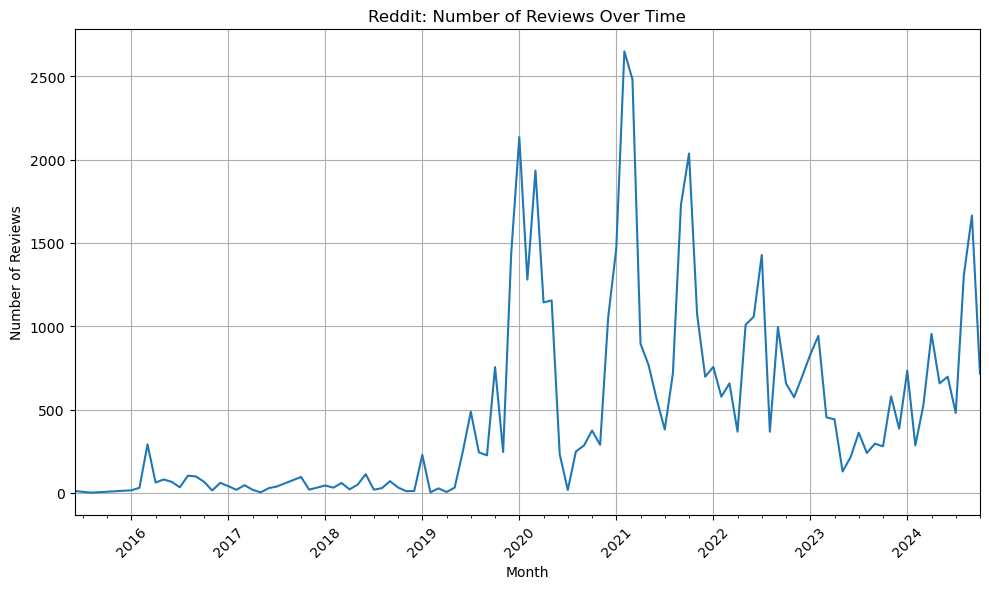

In [36]:
import matplotlib.pyplot as plt

# Convert the 'timestamp_created_converted' to the date format (if not done yet)

reddit_df['date'] = pd.to_datetime(reddit_df['timestamp']).dt.to_period('M')

# Group reviews by date (monthly) and count how many reviews were submitted each month
reviews_per_month = reddit_df.groupby('date').size()

# Plot the number of reviews over time
plt.figure(figsize=(10,6))
reviews_per_month.plot()
plt.title("Reddit: Number of Reviews Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### the Number of Reviews Yearly

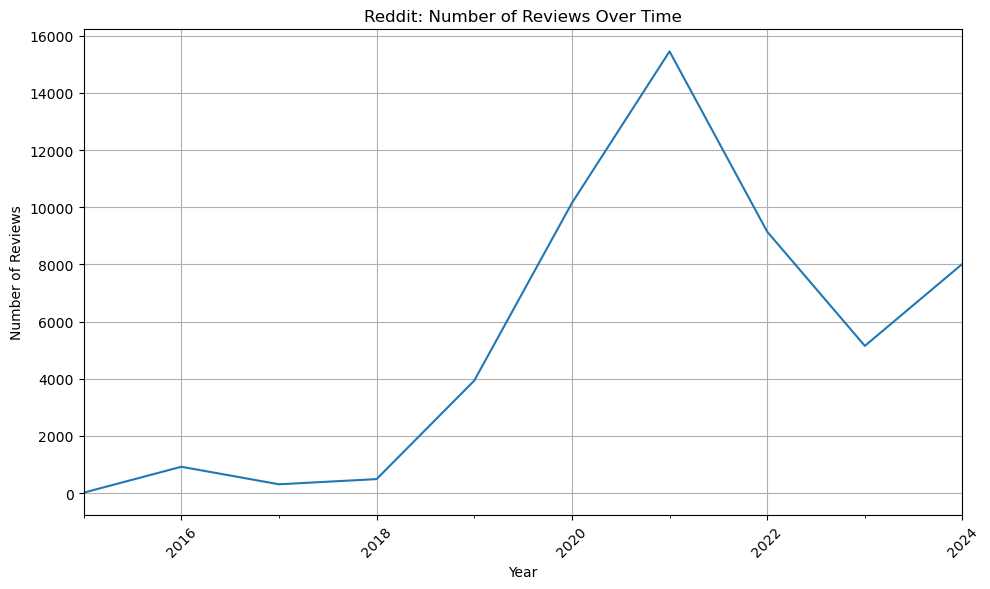

In [37]:

# Convert the 'timestamp_created_converted' to the date format (if not done yet)
reddit_df['date'] = pd.to_datetime(reddit_df['timestamp']).dt.to_period('Y')

# Group reviews by date (monthly) and count how many reviews were submitted each month
reviews_per_month = reddit_df.groupby('date').size()

# Plot the number of reviews over time
plt.figure(figsize=(10,6))
reviews_per_month.plot()
plt.title("Reddit: Number of Reviews Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Data Processing

In [38]:
from nltk.corpus import words
# Load the set of valid English words
valid_words = set(words.words())

# Slang dictionary for replacement
slang_dict = {
    'gg': 'good game',
    'noob': 'newbie',
    'op': 'overpowered',
    'nerf': 'weaken',
    'idk': "i don't know",
    'afk': 'away from keyboard',
    'ftw': 'for the win',
    'smh': 'shaking my head',
    'lol': 'laughing out loud',
}

def replace_slang(text, slang_dict):
    """Replace slang terms in text using the provided slang dictionary."""
    words = text.split()
    replaced_text = ' '.join([slang_dict.get(word.lower(), word) for word in words])
    return replaced_text


def filter_filler_words(tokens):
    """Remove short or meaningless words such as 'wa', 'ha', and words with less than 3 characters."""
    filler_words = {'wa', 'ha', 'uh', 'um'}
    return [token for token in tokens if len(token) > 2 and token not in filler_words]

def processText(text, tokenizer, lemmatizer, stemmer, stopwords, slang_dict):
    """
    Tokenize, lemmatize, and stem the text, removing stopwords, extra words, and invalid/nonsense words.
    """
    # Check if the input text is valid
    if not isinstance(text, str):
        return []
    
    # Remove URLs and special characters
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Step 1: Replace slang using the slang dictionary
    text = replace_slang(text, slang_dict)

    # Tokenise the text
    lTokens = tokenizer.tokenize(text)

    # Custom words to remove
    extra_remove_words = ['game', 'stardew', 'valley', 'video','youtube','dont']

    # Process tokens: lowercase, lemmatize, and filter non-alphabetic tokens
    lTokens = [lemmatizer.lemmatize(token.lower().strip()) for token in lTokens if token.isalpha()]

    # Apply filtering: remove short words, invalid words, and stopwords
    filtered_tokens = [stemmer.stem(token) for token in lTokens 
                       if len(token) > 2  # Filter out short words (less than 3 characters)
                       and token not in stopwords 
                       and token not in extra_remove_words
                       and token in valid_words]  # Only keep valid English words
    
    # Step 5: Remove filler words (like 'wa', 'ha')
    final_tokens = filter_filler_words(filtered_tokens)

    return final_tokens


## Top 30 Most frequent words

In [39]:
# number of most frequent terms to display
freqNum = 30

# use the punctuation symbols defined in string.punctuation
lPunct = list(string.punctuation)
# use stopwords from nltk and a few other twitter specific terms like 'rt' (retweet)
lStopwords = nltk.corpus.stopwords.words('english') + lPunct + ['rt', 'via', '...', '…', '"', "'", '`',"’","“","”",".."]
# Initialize the lemmatizer and stemmer
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()

# our term frequency counter
termFreqCounter = Counter()
# tweet tokeniser to use
tweetTokeniser = nltk.tokenize.TweetTokenizer()

In [40]:
# Loop through each review and process it with both lemmatizer and stemmer

for reviews in reddit_df['content']:
    lTokens = processText(text=reviews, tokenizer=tweetTokeniser, lemmatizer=lemmatizer, stemmer=stemmer, stopwords=lStopwords,slang_dict=slang_dict)
    termFreqCounter.update(lTokens)

# print out most common terms
thirtyfreq_words_reviews = {}
for term, count in termFreqCounter.most_common(freqNum):
    print(term + ': ' + str(count))
    thirtyfreq_words_reviews[term] = count

like: 8831
get: 6040
one: 4616
peopl: 4313
make: 4224
think: 3808
would: 3796
love: 3731
time: 3702
know: 3322
thing: 3019
that: 2986
realli: 2931
want: 2802
see: 2746
look: 2713
also: 2693
even: 2559
much: 2498
day: 2410
good: 2305
way: 2289
farm: 2244
say: 2219
work: 2212
feel: 2195
play: 2166
need: 2120
charact: 2118
year: 2071


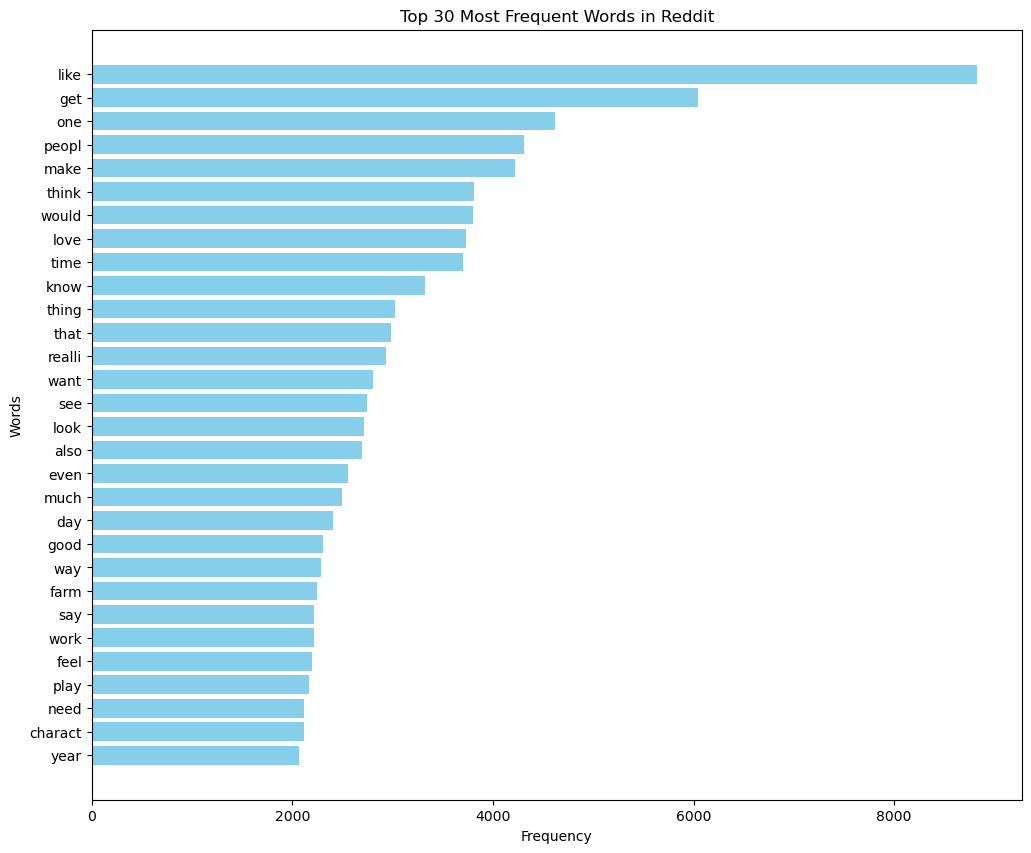

In [41]:
words= list(thirtyfreq_words_reviews.keys())
counts= list(thirtyfreq_words_reviews.values())

plt.figure(figsize=(12,10))
plt.barh(words, counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 30 Most Frequent Words in Reddit')
plt.gca().invert_yaxis()  # Invert y-axis to have the most frequent words on top
plt.show()

## Sentiment Analysis

In [42]:
def vaderPrintTokens(lTokens, dSentimentScores):
    """
    Print out the tokens and sentiment score.
    
    @param lTokens: List of tokens to print and colour.
    @dSentimentScores: Dictionary of sentiment from Vader.

    """
    print(*lTokens, sep=', ')
    for cat,score in dSentimentScores.items():
        print('{0}: {1}, '.format(cat, score), end='')
    print()

In [43]:
def vaderSentimentAnalysis(df, bPrint):
    """
    Use Vader lexicons instead of a raw positive and negative word count.

    @param df: DataFrame containing review text and timestamp columns.
    @param bPrint: whether to print the stream of tokens and sentiment.

    @returns: list of posts, in the format of [date, sentiment].
    """

    # Initialize the VADER sentiment analyzer
    sentAnalyser = SentimentIntensityAnalyzer()

    lSentiment = []
    
    # Iterate over each row in the DataFrame
    for idx, row in df.iterrows():
        # Extract the 'review' and 'timestamp_created_converted' for the current row
        postText = row['content']
        postDate = row['timestamp']
        
        # Pre-process the post text
        lTokens = processText(text=postText, tokenizer=tweetTokeniser, lemmatizer=lemmatizer, stemmer=stemmer, stopwords=lStopwords,slang_dict=slang_dict)

        # Compute the sentiment scores using VADER
        dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))

        # Save the date and compound sentiment score (used for time series)
        lSentiment.append([pd.to_datetime(postDate), dSentimentScores['compound']])

        # Print the tokens and sentiment scores if bPrint is True
        if bPrint:
            vaderPrintTokens(lTokens, dSentimentScores)

    return lSentiment


In [44]:
# input file of set of postive words
posWordFile = 'positive-words.txt'
# input file of set of negative words
negWordFile = 'negative-words.txt'

# flag to determine whether to print out tweets and their sentiment
flagPrint = True
# load set of positive words
lPosWords = []
with open(posWordFile, 'r', encoding='utf-8', errors='ignore') as fPos:
    for sLine in fPos:
        lPosWords.append(sLine.strip())

setPosWords = set(lPosWords)


# load set of negative words
lNegWords = []
with codecs.open(negWordFile, 'r', encoding='utf-8', errors='ignore') as fNeg:
    for sLine in fNeg:
        lNegWords.append(sLine.strip())

setNegWords = set(lNegWords)

In [45]:
# compute the sentiment
lSentiment = vaderSentimentAnalysis(reddit_df, flagPrint)

that, incred, stori, think, littl, person, project, million, peopl, happier, must, feel, pretti
neg: 0.0, neu: 0.779, pos: 0.221, compound: 0.5267, 
super, cool, dude, friend, teacher, run, game, club, farm, student, sent, cute, littl, donat, bunch, steam, key, game, club
neg: 0.0, neu: 0.547, pos: 0.453, compound: 0.9081, 
develop, look, lot, ador, fact, time, effort, love, put, stori, clean, theater, bedroom, million, find, inspir
neg: 0.0, neu: 0.67, pos: 0.33, compound: 0.7845, 
eric, good, noodl, success
neg: 0.0, neu: 0.233, pos: 0.767, compound: 0.765, 
bought, time, best
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
think, hell, keep, end
neg: 0.605, neu: 0.395, pos: 0.0, compound: -0.6808, 
bless, incred, human, person, sent, unsolv, issu, mani, care, enough, incred
neg: 0.0, neu: 0.6, pos: 0.4, compound: 0.7184, 
heart, harvest, hole, could, fill, thank
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.3612, 
soon, get, switch, one, first, system, exagger, say, top, time, 

like, love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.7717, 
bought, liter, yesterday, thank, great, far
neg: 0.0, neu: 0.377, pos: 0.623, compound: 0.765, 
roommat, came, room, told, look, front, page, awesom, happi, thank, amaz
neg: 0.0, neu: 0.8, pos: 0.2, compound: 0.3612, 
bought, six, time, sale, twice, switch, four, copi, friend, also, super, inexpens, keep, free, updat, man, give, much, thank
neg: 0.0, neu: 0.538, pos: 0.462, compound: 0.9169, 
heck, yeah, thank, concern, ape, amaz, work, youv, continu, put, sinc, releas, thank, old, harvest, moon, inspir, masterpiec, harvest, moon, sequel, alway, boy
neg: 0.0, neu: 0.735, pos: 0.265, compound: 0.7351, 
thank, amaz
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
month, back, put, mayb, min, give, real, need, meet, one, townsfolk, cant, find
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
come, right, bought, copi, abl, play, coop, switch, third, copi, overal, version
neg: 0.0, neu: 0.821, pos: 0.179, compound: 0.34, 
mean, al

pro, tip, start, fruit, tree, farm, everi, one, town, like, fruit, except
neg: 0.0, neu: 0.815, pos: 0.185, compound: 0.3612, 
saw, twitter, complain, want, alway, learn, thing, build, shed, actual, new, path, also, need, someon, time, skip, peopl, get, upset, time, skipper
neg: 0.201, neu: 0.748, pos: 0.051, compound: -0.5859, 
anyon, tell, carrot
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
penni, take
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
also
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
never, comment, convinc, pull, stick
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
honestli, man
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
first, ever, got, swept, gorgeou, lock, decid, tri, romanc, without, know, much, anyth, play, found, pretti, dandelion, hand, bridg, feel, pretti, accomplish, respons, disgust, insert, face, never, tri, woo, anyon, save, even, hour, laugh, loud, differ, save, cours, see, fun, romanc, lot, fun, figur, gift, like
neg: 0.091, neu: 0.48, pos: 0.429, com

met, nook, monument, capit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
show, peopl, deepli, capit, hard, know, inform
neg: 0.189, neu: 0.811, pos: 0.0, compound: -0.1027, 
post, obvious, capit, doe, empow
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
doe, everyth, need, annoy, critiqu, person, doe, realiz, get, maximum, product, farm, basic, first, thing, human, could, plant, seed, harvest, later
neg: 0.127, neu: 0.873, pos: 0.0, compound: -0.4404, 
cant, cave, carrot
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yep, like, carrot, talk, cannot, farm, carrot
neg: 0.0, neu: 0.515, pos: 0.485, compound: 0.5719, 
made, want, carrot, though
neg: 0.0, neu: 0.698, pos: 0.302, compound: 0.0772, 
parsnip, carrot, close, relat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
instal, artisan, good, lot, new, crop, carrot
neg: 0.0, neu: 0.674, pos: 0.326, compound: 0.4404, 
base, price, grow, time, reaction, probabl, sweet, gem, berri, look, like, carrot, definit
neg: 0.0, neu: 0.667, pos: 0.333, 

also, let, experi, home
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
forget, braveri, actual, talk, cute, chick
neg: 0.213, neu: 0.449, pos: 0.337, compound: 0.2732, 
cheap, hous
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
know, post, live, outskirt, citi, small, villag, honestli, feel, small, commun, genuin, amaz, basic, thing, store, local, woman, store, market, one, bigger, store, network, shop, cours, villag, doctor, well, feel, citi, born, peopl, appreci, quiet, heart, small, life
neg: 0.0, neu: 0.946, pos: 0.054, compound: 0.2732, 
wish, differ, mode, like, mayb, someth, know, that, point, sometim, would, like, start, debt, hous, get, debt, seed, medial, emerg, mine, get, even, debt, cant, crawl, save
neg: 0.268, neu: 0.529, pos: 0.204, compound: -0.3459, 
also, work, get, opposit, real, life, get, low, wage, matter
neg: 0.188, neu: 0.714, pos: 0.098, compound: -0.25, 
post, industri, fantasi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thing, live, outsid, citi, small, villa

popular, big, live, stream, fri, get, increasingli, make, profit, final
neg: 0.0, neu: 0.584, pos: 0.416, compound: 0.6908, 
someon, find, relationship, neighbor, mayb, theyr, problem
neg: 0.31, neu: 0.69, pos: 0.0, compound: -0.4019, 
wow, sound, pretenti
neg: 0.0, neu: 0.345, pos: 0.655, compound: 0.5859, 
terribl, incred, privileg, take, low, creativ, experi, consist, drip, fantasi, part, farm, fantasi
neg: 0.149, neu: 0.851, pos: 0.0, compound: -0.2732, 
love, peopl, blame, person, problem, choic, societi, unlik, person, understand, put, bodi, fat, walk, mile, industri, revolut, fault
neg: 0.3, neu: 0.538, pos: 0.162, compound: -0.3818, 
way
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
know, everi, person, planet, yank, everi, stori, season, fan, yank, stop, tri, rub, toxic, cultur, duck, restaur, watch, bike
neg: 0.102, neu: 0.791, pos: 0.107, compound: 0.0258, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
gen
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
funni, mani, peopl, wi

dev, crush, never, seen
neg: 0.348, neu: 0.652, pos: 0.0, compound: -0.1531, 
wish, everi, happi, player, thousand, time, wonder, develop
neg: 0.0, neu: 0.722, pos: 0.278, compound: 0.4019, 
love, share, birthday
neg: 0.0, neu: 0.135, pos: 0.865, compound: 0.7506, 
deserv
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
polit, polit, thank
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
year, sound, extrem, honestli, know, would, done, past, year, without, lot, stage, depress, sad, boredom, anxieti, dad, got, sick, disassoci, tool, time, unfortun, away, year, great, way, distract, everyth, live, fun, world, garden, give, present, friend, import, tool, mental, health, toolbox, pretti, high, cute, kitten, sigh, depress, write, realli, doe, mean, much, ever, intens, alreadi, got, bit, tire, even, would, without, grate
neg: 0.133, neu: 0.623, pos: 0.244, compound: 0.8425, 
genuin, love, man, wish, etern, happi
neg: 0.0, neu: 0.367, pos: 0.633, compound: 0.7845, 
aspir, good, dev, person


notifi, blue, chees, day, finish, spring, year, love, wonder, littl, world, year
neg: 0.0, neu: 0.724, pos: 0.276, compound: 0.6369, 
wow, guy, support, bought, board, know, produc, start, finish
neg: 0.0, neu: 0.519, pos: 0.481, compound: 0.7579, 
dude, birthday, today, birthday
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
havent, devot, much, time, sinc, earli, love, work, commun, continu, delight, shine, small, bright, light, dark, time
neg: 0.0, neu: 0.56, pos: 0.44, compound: 0.9001, 
wholesom
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
fun
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.5106, 
happi, anniversari, absolut, chad, develop
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realli, happi, huge, stress, reliev, therapeut, get, switch, play, anim, cross, decid, tri, best, decis, yet, thank, happi, fifth, anniversari
neg: 0.096, neu: 0.514, pos: 0.39, compound: 0.8225, 
could, easili, solid, purchas, much, content, playabl, option, everyth, offer, much, much, love, support, cape

absolut, treasur, develop, think, similar, time, frame, like, five, night, fraction, book, turn, complet, cash, cow
neg: 0.0, neu: 0.857, pos: 0.143, compound: 0.3612, 
millionair
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yeah, liter, like, time, differ, system, account, cant, get, enough
neg: 0.0, neu: 0.63, pos: 0.37, compound: 0.5719, 
cosmet, better, appreci, bug, fix, offici, section, bug, fix, area, concern, ape, bug, bug, month, ago, sinc, attent, would, like, free, content, sorri, take, entir, week, fix, issu, might, doubl, size, end, lot, ground, cover
neg: 0.0, neu: 0.786, pos: 0.214, compound: 0.8271, 
one, reason, bought, board, news, alon, would, play, like, afterward, want, support, great, stuff, done, singl, purchas, doesnt, justic, singl, year, partner, multipl, farm, multipl, even, content
neg: 0.0, neu: 0.629, pos: 0.371, compound: 0.9001, 
littl, question, doe, updat, appli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
name, chang, wholesom, ape
neg: 0.0, neu: 1.

imagin, say, open, bracket, one, hundr, sixti, three, close, bracket, open, bracket, seventi, four, close, bracket
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
somehow, fish, time, stand, still, magic, power
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
understand, joke, money, exploit
neg: 0.25, neu: 0.357, pos: 0.393, compound: 0.2023, 
role, player, weird, laugh, loud
neg: 0.205, neu: 0.361, pos: 0.434, compound: 0.4404, 
patch, fix, magic, sad
neg: 0.508, neu: 0.492, pos: 0.0, compound: -0.4767, 
purpl, lettuc, display
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
tri, super, clingi, girl, look, like, could, daughter
neg: 0.0, neu: 0.484, pos: 0.516, compound: 0.7506, 
make, sad, creepi
neg: 0.608, neu: 0.392, pos: 0.0, compound: -0.4767, 
persona, style
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, terrifi, power, move, ever, one
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mean, far, make
neg: 0.0, neu: 1.0, pos: 0.0, compou

someon, anim, tweet, coupl, day, ago
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
alway, fenc, loyal, unlock, new, heart, event, save, life, moment, leav, new, farm, tho
neg: 0.0, neu: 0.656, pos: 0.344, compound: 0.743, 
best, girl, best, boy, alway, feel, bit, bad, steal, sinc, usual, end, marri, one, depend, type, farmer, relat, better, candid
neg: 0.203, neu: 0.455, pos: 0.342, compound: 0.6808, 
maru, best, girl
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
yeah, cant, help, feed, amethyst, whenev, one
neg: 0.239, neu: 0.529, pos: 0.233, compound: -0.015, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
evil, like
neg: 0.638, neu: 0.0, pos: 0.362, compound: -0.4404, 
that, evil, definit, start, new, save, file
neg: 0.349, neu: 0.397, pos: 0.254, compound: -0.296, 
though
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
edibl, pancak, plate
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
definit, eaten, wors, plate
neg

cum
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
face
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
excus, racism, draw, line, anim, cruelti
neg: 0.451, neu: 0.549, pos: 0.0, compound: -0.6249, 
man, build, amaz, whole, crazi, detail, give, thing, eat, mad, caus, two, item, cant, eat, also, gross
neg: 0.154, neu: 0.723, pos: 0.123, compound: -0.1645, 
cant, drink, get, spoon
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
eat, quart
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
answer, that, probabl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
plate, made, waffl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
drink, mayonnais
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
best, time
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
eat, pickl, without, shell
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
someon, hate, pickl, everi, fiber, love, fulli, endors
neg: 0.266, neu: 0.432, pos: 0.302, compound: 0.128, 
could, use, drink, anim
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
meanwh

easi, pepper, beer, pizza, husband, easi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
doe, like
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
like, fact, nobodi, terrarium
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
plu, coupl, nexu, tab, make, sure, heart, event, requir, met, marri, wizard, judg
neg: 0.0, neu: 0.839, pos: 0.161, compound: 0.3182, 
alway, open, ton, differ, one, home, make, sure, everyth, match
neg: 0.0, neu: 0.796, pos: 0.204, compound: 0.3182, 
believ, favorit, fish, lobster
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
serious, make, easier, like, want, start, want, spend, time, outsid
neg: 0.092, neu: 0.352, pos: 0.556, compound: 0.6808, 
first, tab, miner, lunch, sometim, pumpkin
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
almost, everyon, like, chees, get, cow, chees, press, golden
neg: 0.0, neu: 0.783, pos: 0.217, compound: 0.3008, 
citi, run, everi, morn, gift, everyon, day, knew, everyon, schedu

hate, forc, alway, page, order, play, properli, play, damn
neg: 0.395, neu: 0.309, pos: 0.296, compound: -0.3818, 
made, printabl, guid, doc, pain, like, billion, open
neg: 0.28, neu: 0.508, pos: 0.212, compound: -0.2023, 
mobil, havent, abl, realli, get, give
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
damn, accur, yeah, use, unoffici, guid, phone
neg: 0.273, neu: 0.505, pos: 0.222, compound: -0.128, 
year, touch, final, grab, whim, last, week, sub, keep, make, front, page, joke, feel, like, person, attack, relev
neg: 0.136, neu: 0.658, pos: 0.206, compound: 0.1531, 
someon, creat, mobil, like, monster, gener, ultim, doe
neg: 0.0, neu: 0.737, pos: 0.263, compound: 0.3612, 
wife, say, trick, question, doesnt, like, fish, like, duck, feather
neg: 0.436, neu: 0.564, pos: 0.0, compound: -0.5299, 
anyon, els, use, last, resort, thing, part, fun
neg: 0.0, neu: 0.68, pos: 0.32, compound: 0.5106, 
item
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
post, like, wonder, death, actual, real, tr

bond, level, beyond, heart, lead, success, farm, grandpa
neg: 0.0, neu: 0.654, pos: 0.346, compound: 0.5719, 
realli, hope, marriag, like
neg: 0.0, neu: 0.27, pos: 0.73, compound: 0.6597, 
love, stuff, right, folk, ever, stumbl, across, post, lot, peopl, fantast, time, side, note, hope, wife, happi, year
neg: 0.0, neu: 0.693, pos: 0.307, compound: 0.7964, 
cute, love, much, look, like
neg: 0.0, neu: 0.171, pos: 0.829, compound: 0.8658, 
cute
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4588, 
that, sweet
neg: 0.0, neu: 0.25, pos: 0.75, compound: 0.4588, 
relationship, goal
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
god, love, cute, never, know
neg: 0.0, neu: 0.177, pos: 0.823, compound: 0.8519, 
sweet, beauti
neg: 0.0, neu: 0.25, pos: 0.75, compound: 0.4588, 
goal
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
good, hope, million, adventur, togeth, magic
neg: 0.0, neu: 0.408, pos: 0.592, compound: 0.7003, 
wait, til, find, skull, cavern
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ador


neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
make
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sweet, wholesom
neg: 0.0, neu: 0.25, pos: 0.75, compound: 0.4588, 
post, made, realiz, could, get, mobil, never, play, minut, top, put, hour
neg: 0.266, neu: 0.734, pos: 0.0, compound: -0.3875, 
real, test, marriag, come, discov, wallet, may, end, friendship
neg: 0.0, neu: 0.734, pos: 0.266, compound: 0.4404, 
make, smile
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
cute, love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.802, 
dam, right
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
easi, man
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
everyon
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cute
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4588, 
relationship, goal
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
first, thing, ever, get, interest, want, build, littl, villag, whatev, wife, back, work, tomorrow, job, suddenli, essenti
neg: 0.0, neu: 0.777, pos: 0.223, compound: 0.5106, 
real,

use, play, super, would, ask, could, play, said, one, minut, got, beat, super, togeth, hot, pancreat, cancer, year, wish, could, play, togeth
neg: 0.119, neu: 0.404, pos: 0.477, compound: 0.9062, 
that, actual, choic, sorri, rude, head, thought, funni, best
neg: 0.211, neu: 0.493, pos: 0.296, compound: 0.296, 
well, work
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.2732, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
that, awesom, love, doubt, could, get, though
neg: 0.214, neu: 0.427, pos: 0.359, compound: 0.4019, 
relat, post, sure, post
neg: 0.0, neu: 0.566, pos: 0.434, compound: 0.3182, 
great
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6249, 
hormon, man
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
joke, first, spend, day, mine, tri, find, gift, win, heart, know, least, get, back, comment, made, start, yeah, much, sour, face, bitch
neg: 0.119, neu: 0.533, pos: 0.348, compound: 0.743, 
sound, like, dad, catch, didnt, think
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.3612, 
well,

came, say, peopl, legitimaci, understand, know, know
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
lucki, thank, sweet, comment
neg: 0.0, neu: 0.267, pos: 0.733, compound: 0.6705, 
confirm, daughter, true, theyr, cute
neg: 0.0, neu: 0.341, pos: 0.659, compound: 0.7003, 
super, wholesom, may, also, correct, answer
neg: 0.0, neu: 0.562, pos: 0.438, compound: 0.5994, 
cant, tell, sick, burn, dad, mayb
neg: 0.0, neu: 0.649, pos: 0.351, compound: 0.4023, 
penni, sweet, let, know, choos
neg: 0.0, neu: 0.571, pos: 0.429, compound: 0.4588, 
think, realli, person, prefer, partner, know, could, never, marri, someon, like, penni, younger, damn, near, big, bullet, want, oblig, feel, like, save, someon, someth, theyr, incap, save, meek, timid, constant, seek, escap, book, instead, actual, work, toward, problem, exactli, like, penni, substitut, book, live, vicari, rather, put, gun, head, deal, sad, thing, penni, obvious, sweet, person, put, fault, first, interest, partner, reveal, desir, deni, probl

make
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cuti
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
follow, keep
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
pretti, great, stori, glad, see, effort, inspir, keep, great, thing
neg: 0.0, neu: 0.385, pos: 0.615, compound: 0.9042, 
look, amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
great, keep, make, awesom
neg: 0.0, neu: 0.423, pos: 0.577, compound: 0.6249, 
cute, bob, hold, stuff, everyth, bump, love
neg: 0.0, neu: 0.41, pos: 0.59, compound: 0.802, 
didnt, concern, ape, singl, person, time, alway, assum, dev, team, especi, base, big
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
awesom, ever, develop, experi, prior
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
amaz, use, make, stuff, art, interest, develop
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.4588, 
possibl, would, love, background, art
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.6369, 
love, jig, make, happi
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.6369, 
beg, ma

sure, nice, work
neg: 0.0, neu: 0.164, pos: 0.836, compound: 0.6249, 
wish, would, dare, instead, wash, pallet, use
neg: 0.0, neu: 0.69, pos: 0.31, compound: 0.4019, 
love, danc, scarecrow
neg: 0.257, neu: 0.143, pos: 0.6, compound: 0.5267, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
make, happi, would, play
neg: 0.0, neu: 0.556, pos: 0.444, compound: 0.34, 
dude, got, realli, nice, style, come, good, concept, could, well
neg: 0.0, neu: 0.473, pos: 0.527, compound: 0.7783, 
ador, thank
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
god, wish, transform, graphic, like
neg: 0.0, neu: 0.215, pos: 0.785, compound: 0.743, 
great, stuff
neg: 0.0, neu: 0.196, pos: 0.804, compound: 0.6249, 
cant, stop, see, danc, love
neg: 0.0, neu: 0.33, pos: 0.67, compound: 0.7259, 
amaz, look, forward, follow, journey
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ador
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
cat, real
neg: 0.0, neu: 1.0, p

ador, congratul
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ador, pair, congratul
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, sweet, wish, guy, best, new, adventur
neg: 0.0, neu: 0.288, pos: 0.712, compound: 0.872, 
love, congratul, lucki, made, shed, happi, tear
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.6369, 
goal, two, ador
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
super, creativ
neg: 0.0, neu: 0.204, pos: 0.796, compound: 0.5994, 
obtain, command, quaint, butter, childlik, chunki, seriou, exult, gold, deserv, post, mass, redact
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
congratul, proof, would
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
made, full, ugli, cri, good, way, absolut, amaz, job, wish, everi, happi, life, togeth
neg: 0.0, neu: 0.682, pos: 0.318, compound: 0.6808, 
amaz, beauti, gestur, book, love, wish, best, mani, year, come, congratul
neg: 0.0, neu: 0.419, pos: 0.581, compound: 0.9022, 
idea, much, happi, brought
neg: 0.0, neu: 1.0, pos: 0.0, comp

wow, wont, marri, alreadi, happili, marri, excel, propos, also, awesom, way, preserv, memori, sinc, book, pendant, forev, truli, super, creativ, wish, best
neg: 0.0, neu: 0.491, pos: 0.509, compound: 0.9559, 
one, thing, ever, seen, two, happi, life
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
win, congratul
neg: 0.0, neu: 0.208, pos: 0.792, compound: 0.5859, 
make
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
absolut, beauti, propos, ever, seen, congratul
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
perfect, propos, congratul
neg: 0.0, neu: 0.351, pos: 0.649, compound: 0.5719, 
congratul, coupl, play, togeth, stay, togeth
neg: 0.0, neu: 0.676, pos: 0.324, compound: 0.34, 
one, perfect, propos, ever, seen
neg: 0.0, neu: 0.519, pos: 0.481, compound: 0.5719, 
wow
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.5859, 
sweet, talent, congratul, gecko, manti
neg: 0.0, neu: 0.341, pos: 0.659, compound: 0.7003, 
bar, risen, peep, cute
neg: 0.0, neu: 0.5, pos: 0.5, compound: 0.4588, 
damn, idea, f

comic, look, similar, situat, except, room, barg, say, good, morn, much, good, friend, look, drawer, found, lewi, pant, dash, hous
neg: 0.0, neu: 0.654, pos: 0.346, compound: 0.8402, 
confus, thought, second, thought, realli, nich, insid, joke, like, like, look, complet, differ, sub
neg: 0.0, neu: 0.604, pos: 0.396, compound: 0.7351, 
exactli, gave, diamond, book, straight, room, ill, never, return, except, fuel, alcohol, son, addict, buy, odd, chicken, goat
neg: 0.218, neu: 0.598, pos: 0.184, compound: -0.2023, 
pleas
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, comic
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
proceed, never, speak
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
recip, frequent
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, way, awesom
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
heart, corpor, crime
neg: 0.636, neu: 0.364, pos: 0.0, compound: -0.5423, 
best, post, seen, far, love
neg: 0.0, neu: 0.263, pos: 0.737, compound: 0.8555, 
laugh, 

mayor, find, underwear, bedroom, cant, enter, bedroom, without, heart, charact, heart, retriev, good, leav
neg: 0.0, neu: 0.818, pos: 0.182, compound: 0.4404, 
guarante, guy, featur
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
year, old
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
throw, potluck, soup
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
new, flag
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
good, thing, alway, carri, two, gun
neg: 0.258, neu: 0.43, pos: 0.312, compound: 0.128, 
flame, dragon
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
littl, brother, could
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
afford, whose, hay, price, babi, also, remind, cut, hay, earli, cut, often
neg: 0.296, neu: 0.704, pos: 0.0, compound: -0.4939, 
serious, never, store, guess, could, look, much, troubl, find, give, gift, could, raid, bedroom
neg: 0.08, neu: 0.741, pos: 0.179, compound: 0.3818, 
throw, town, soup, commun, event, influenti, polit

note, self, get, unless, solid, week, work, food, told, forese, futur
neg: 0.0, neu: 0.862, pos: 0.138, compound: 0.1531, 
concern, ape, secret
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
year, hold, dearli, heart, excit, see, new, develop, let, ape, definit, look, like, well, hous, sort, well, abl, open, world, let, acquir, resourc, make, chocol
neg: 0.0, neu: 0.767, pos: 0.233, compound: 0.6908, 
look, interest, combat, import, flesh, see, shield, energi, bar, wonder, fire, risk, eta, one, question, fish
neg: 0.315, neu: 0.548, pos: 0.137, compound: -0.4404, 
love, love, chocol, love, ghost, excit
neg: 0.136, neu: 0.118, pos: 0.746, compound: 0.9062, 
instant, buy, itch, year, hope, keep, good, time
neg: 0.0, neu: 0.508, pos: 0.492, compound: 0.7003, 
tier, press, concern, ape, make, open, eye
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
liter, morn, feel, say, wish, could, play, first, time, cant, believ, manifest, liter, excit
neg: 0.0, neu: 0.702, pos: 0.298, compound: 0.6249, 

word, tell, excit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wasnt, magic
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
work, done, dedic, updat, shown, made, ill, buy, anyth, guy, make, excit, see, new, thing, hell, show
neg: 0.33, neu: 0.67, pos: 0.0, compound: -0.8126, 
ape, get, money, banana, cant, wait
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sick, cri, trailer, nice, peac, cant, wait, till, releas, song
neg: 0.234, neu: 0.567, pos: 0.199, compound: -0.128, 
iridium, chocol
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
would, preorder, today, could, play, anyth, ape, make, look, delici, delight
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.743, 
excit, new
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
autumn, favorit, season, real, life, hope, lot, cozi, slightli, spooki
neg: 0.0, neu: 0.756, pos: 0.244, compound: 0.4404, 
instantli, buy
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
excit, new, discov, covid, realli, kept, sane, new, thank, cant, wait
neg: 0.0, neu: 0.8, 

tab, open, time, calcul, what, profit, crop, find, schedul, villag, rais, friendship, creation, problem
neg: 0.131, neu: 0.485, pos: 0.383, compound: 0.6369, 
cola, compani, doesnt, ever, realli, anyth, luke, activ, fight, laugh, loud
neg: 0.171, neu: 0.592, pos: 0.237, compound: 0.25, 
spent, two, full, day, weekend, whole, winter, season, mayb, day, accomplish, littl, built, two, shed, work, fake, greenhous, farm, seriou, dollar, pineappl, plant, someday, last, tool, iridium, heart, villag, friendship, duck, coop, near, pond, got, walnut, ginger, island, unlock, trade, hut, took, quest, willi, catch, good, grief, chore, fish, eat, dish, sea, fish, cork, bobber, wild, bait, attach, bar, still, danc, place, took, least, one, real, human, hour, focu, catch, fish, lucki, bait, gave, two, fish, twice, sure, would, made, otherwis
neg: 0.068, neu: 0.813, pos: 0.118, compound: 0.5574, 
love, peac, chill, money, hungri, maniac, empir
neg: 0.252, neu: 0.407, pos: 0.341, compound: 0.2732, 
got,

never, relationship, unsur, say
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
eventu, mass, produc, wine, gift, everyon, often
neg: 0.0, neu: 0.674, pos: 0.326, compound: 0.4404, 
play, pretti, chill, volcano, keep, get, floor, twice, row, last, night, want, get, top, bring, plenti, food, get, energi, health, delay, inevit
neg: 0.089, neu: 0.698, pos: 0.213, compound: 0.296, 
catch, legendari, fish, tell, chill
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
stress, let, look, object, downsid, townspeopl, technic, farm, fall, weed, never, anim, perfectli, reason, well, could, wander, like, interact, choos, oblig, ultim, doesnt, progress, stori, unless, make, move, sens, lot, like, purgatori, time
neg: 0.128, neu: 0.696, pos: 0.176, compound: 0.2425, 
blink, miss, season, exact, fish, need, bundl
neg: 0.211, neu: 0.789, pos: 0.0, compound: -0.1531, 
cant, play, anim, know, dairi, cow, last, natur, need, get, pregnant, keep, make, milk, doesnt, matter, much, get, munch, field
neg: 0.147, n

panic, silo, run, hay, winter, stand, kitchen, day, pleas, anim, starv, walk, foot, give, money, hay, also, swarm, floor, cavern
neg: 0.148, neu: 0.852, pos: 0.0, compound: -0.5106, 
get, get, anxieti, tri, get, done, time, energi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
skull, cavern, almost, gave, panic, attack, today, wish, exagger
neg: 0.402, neu: 0.412, pos: 0.185, compound: -0.4867, 
need, know, everyth, play, peac
neg: 0.0, neu: 0.625, pos: 0.375, compound: 0.34, 
jeff, cola, die
neg: 0.661, neu: 0.339, pos: 0.0, compound: -0.5994, 
war, thunder, grind, annoy, relationship, mechan
neg: 0.63, neu: 0.37, pos: 0.0, compound: -0.7783, 
date
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
like, corpor, felt, bit, offend, see, cola, corpor, laugh, loud
neg: 0.144, neu: 0.458, pos: 0.399, compound: 0.5994, 
sometim, stress, play, session, like, settl, half, hour, doom, etern
neg: 0.335, neu: 0.366, pos: 0.299, compound: -0.1531, 
nearli

also
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
interest, fish, also, love, pomegran
neg: 0.0, neu: 0.294, pos: 0.706, compound: 0.802, 
see, peopl, favorit, youv, given, thing
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
husband, min, tabl, hous
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
full, fear
neg: 0.762, neu: 0.238, pos: 0.0, compound: -0.4939, 
relat, terrarium
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
friend, case, text, time, answer, instead, look
neg: 0.0, neu: 0.652, pos: 0.348, compound: 0.4939, 
that, want, print, hard, cover, glossi, paper, vivid, color, guid, book
neg: 0.12, neu: 0.769, pos: 0.111, compound: -0.0258, 
hey, stop, call
neg: 0.524, neu: 0.476, pos: 0.0, compound: -0.296, 
use, instead, better, ram, look, also, block, anim, cross, theme
neg: 0.21, neu: 0.58, pos: 0.21, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
live, die
neg: 0.796, neu: 0.204, pos: 0.0, compound: -0.5994, 
lobste

awesom, thank
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
love, thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.7717, 
never, use, idea, even, attempt, put
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wow, look, awesom, final, set, mac, first, time, ever, thank
neg: 0.0, neu: 0.559, pos: 0.441, compound: 0.743, 
look, like, god, send, immedi, thank, much
neg: 0.0, neu: 0.36, pos: 0.64, compound: 0.7269, 
anyth, way, play, cut, make, actual, control, time, hard, chill, stop, smell, rose, mean, tomorrow, didnt, get, anyth, done
neg: 0.247, neu: 0.649, pos: 0.104, compound: -0.3182, 
good, sadli, doesnt, provid, everyth, doe
neg: 0.0, neu: 0.633, pos: 0.367, compound: 0.4404, 
cri, switch, version
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
save, later, sound, awesom
neg: 0.0, neu: 0.484, pos: 0.516, compound: 0.4939, 
alreadi, save, file, run, ruin, add, without, start
neg: 0.292, neu: 0.462, pos: 0.246, compound: -0.1531, 
commun, nice, could, find, link, thank, offer
neg: 0

save, pictur, set, phone, wallpap, that, cool
neg: 0.0, neu: 0.476, pos: 0.524, compound: 0.6705, 
well, drawn, rememb, fish, midnight
neg: 0.0, neu: 0.656, pos: 0.344, compound: 0.2732, 
thought, actual, pictur, first, good
neg: 0.0, neu: 0.58, pos: 0.42, compound: 0.4404, 
would, frame, someth, like, may, wall, well, done
neg: 0.0, neu: 0.566, pos: 0.434, compound: 0.5574, 
beauti
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realli, pleasant, total, fit, feel, nice, work
neg: 0.0, neu: 0.317, pos: 0.683, compound: 0.8225, 
never, wow, great, job
neg: 0.761, neu: 0.239, pos: 0.0, compound: -0.7481, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
amaz, thank
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
love, talent
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.7906, 
would, give, life, citi, move, look, good
neg: 0.0, neu: 0.674, pos: 0.326, compound: 0.4404, 
absolut, perfect, love, thank
neg: 0.0, neu: 0.088, pos: 0.912, compoun

hope, thing, bit, better, friend, one, happi, place, moonlight, jelli, beauti, event, glad
neg: 0.0, neu: 0.429, pos: 0.571, compound: 0.9001, 
good, news, bell, jellyfish, moon, complet, harmless, bad, news, tentacl, look, similar, lot, venom, speci, look, amaz
neg: 0.156, neu: 0.625, pos: 0.219, compound: 0.1027, 
one, sky, photo, admittedli, found, imag, search, right, pretti, bad, think, look, someth, bit, better
neg: 0.18, neu: 0.67, pos: 0.149, compound: -0.1531, 
cours, feel, free, done, post, check, profil, take, look, account, work, realli, appreci, kind, word, thank
neg: 0.0, neu: 0.586, pos: 0.414, compound: 0.8481, 
offens, taken, appreci, feedback, wasnt, sure, peopl, would, distract, jelli, tri, make, peopl, secondari, read, imag, total, hear, say, someth, said, keep, thing, simpl
neg: 0.159, neu: 0.841, pos: 0.0, compound: -0.4874, 
none, realli, use, sinc, typic, architectur, render, mention, actual, jellyfish, rest, done, though
neg: 0.0, neu: 1.0, pos: 0.0, compound: 

age, come, bachelor, sam, abigail, penni, maru
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
agre, good, point
neg: 0.0, neu: 0.408, pos: 0.592, compound: 0.4404, 
also, would, mean, late, would, still, child
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
exactli, realli, shouldnt, tri, marri, understand, earli, mid, either, way, illeg
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yeah, peopl, find, peopl, feel, comfort, hate, make, charact, attract, romant, scene, like, year, old, battl, veteran
neg: 0.146, neu: 0.472, pos: 0.382, compound: 0.6124, 
plu, would, start, age
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
girl, creepi, friend, said, thought, clint, mid, like, way, definit, like, will, concern, ape, got, messag, next, day, guess, technic
neg: 0.0, neu: 0.675, pos: 0.325, compound: 0.802, 
agre, main, point, tri, argu, friend, like, age, gap, much, like, age, gap, like
neg: 0.0, neu: 0.483, pos: 0.517, compound: 0.8658, 
clint, d

think, would, around, mid, old, think, laugh, loud
neg: 0.0, neu: 0.66, pos: 0.34, compound: 0.5574, 
alway, assum, clint, least, earli, noth, say, anyth, age, like, bachelor, penni, alway, came, older, penni, older, one, like, figur, late, old, enough, consent, adult, young, enough, way, clint, crush
neg: 0.046, neu: 0.754, pos: 0.2, compound: 0.6486, 
see, year, old, woman
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
age, woman, make, creepi, man, hit, one, mid
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, like, year, gap, that, big, gap, talk, two, grown, adult, anyth, concern, clint, keep, clearli, interest, depend, player, choic, taken, marri
neg: 0.0, neu: 0.784, pos: 0.216, compound: 0.6705, 
give, someon, late, decid, way, live, life
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
know
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
alway, rang, like, much, matur, type, despit, wacki, sort, like, miss, frizzl, think, much, younger, like, sort, took, role, guardian, younger
n

becom, friend, someon, busi, grind, fish
neg: 0.0, neu: 0.61, pos: 0.39, compound: 0.4939, 
friendship, stalk, person, everyday, learn, time, give, gift, runaway, thing
neg: 0.0, neu: 0.58, pos: 0.42, compound: 0.7003, 
wait, trash, year, didnt, know
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
poor, eyesight, fish, glass, river, thought, could, give, discov, machin, thought, would, fix, glass, didnt
neg: 0.181, neu: 0.819, pos: 0.0, compound: -0.4767, 
that, chao, get, chao, garden
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
found, whole, bar, gold, iridium, ore, blacksmith, trash
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
highest, post, time
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
stop, yuck, want, bread
neg: 0.4, neu: 0.364, pos: 0.236, compound: -0.2263, 
probabl, person, around
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
play, coop, judg, sever, doe
neg: 0.0, neu: 0.625, pos: 0.375, compound: 0.34, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
option, becom, serial

tell, real
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
pic, didnt, happen
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
old, man, told, rummag, stop, fall, year, spring, year, found, one, thing, machin, turn, fish, trash, resourc, amaz, got, refin, quartz, that, also, figur, put, quartz, furnac, get, refin, idea, beforehand, set, far, behind
neg: 0.062, neu: 0.937, pos: 0.0, compound: -0.296, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
friend, raccoon, raccoon
neg: 0.0, neu: 0.385, pos: 0.615, compound: 0.4939, 
whole, chocol, cake, trash, would, join, see, what
neg: 0.0, neu: 0.761, pos: 0.239, compound: 0.296, 
octopu, let, real
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mine, would, assum, raccoon, obsess, new, level, know, cool, stuff, might, bin
neg: 0.14, neu: 0.699, pos: 0.161, compound: 0.0772, 
that, accident, got, heart, someth, didnt, hous, trigger, heart, event
neg: 0.256, neu: 0.744, pos: 0.0, compound: -0.4767, 
happi, birthday, ground
neg: 0.0, neu: 1.0, pos: 0.

cute, extrem, talent
neg: 0.0, neu: 0.147, pos: 0.853, compound: 0.7003, 
that, wow, feel, play
neg: 0.0, neu: 0.244, pos: 0.756, compound: 0.7351, 
poke
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
cute
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4588, 
ador, littl, guy, affection, call, poke
neg: 0.0, neu: 0.595, pos: 0.405, compound: 0.5267, 
absolut, ador
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, much, want, give, money
neg: 0.0, neu: 0.353, pos: 0.647, compound: 0.6705, 
stuff, well
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.2732, 
great, work
neg: 0.0, neu: 0.196, pos: 0.804, compound: 0.6249, 
duck, ador
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
would, die, littl, guy
neg: 0.565, neu: 0.435, pos: 0.0, compound: -0.5994, 
thing, realli, love, color, look, like, perfect, autumn, day
neg: 0.0, neu: 0.366, pos: 0.634, compound: 0.886, 
cute, art, twitter
neg: 0.0, neu: 0.4, pos: 0.6, compound: 0.4588, 
alon, could

poke, absolut, preciou
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
feel, sad, hat, mous, lone, wood
neg: 0.565, neu: 0.435, pos: 0.0, compound: -0.6369, 
would, wall, love
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
nice
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4215, 
cute, lot, love
neg: 0.0, neu: 0.122, pos: 0.878, compound: 0.802, 
amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
alway, thought, cat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
fantast, thank
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
log, give, art, use
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
give, potter
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
bring, coin, gud, sell, hat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
love, ador
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
almost, 

make, similar, want, like
neg: 0.0, neu: 0.345, pos: 0.655, compound: 0.4215, 
watch, make, shop
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wouldnt, problem, roll, eye, past, like, pale, imit, stop, comment, let, know, actual, look, realli, good, like, ident, cheap, knockoff, steam, look, forward, see, updat
neg: 0.068, neu: 0.618, pos: 0.314, compound: 0.7881, 
look, amaz, love, cant, wait, chang, name, someth, catchi, tell, come, one
neg: 0.0, neu: 0.724, pos: 0.276, compound: 0.6369, 
least, feel, like, good, idea, knowledg, would, need, pursu, like, realli, background, insurmount, goal
neg: 0.0, neu: 0.582, pos: 0.418, compound: 0.7845, 
nice, love, overal, aesthet, clear, took, inspir, youv, enough, much, thing, interest, hear, mechan, work, someth, akin, papa, work, hour, tend, custom, order, quickli, possibl, earn, rate, outsid, work, hour, abl, thing, like, gather, ingredi, organ, shop, interact, busi, run, aspect, hand, arent, directli, make, food, serv, custom, theyr, stuf

look, absolut, beauti
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, look, realli, interest, one, thing, think, could, anim, tool, stiff, opinion
neg: 0.0, neu: 0.786, pos: 0.214, compound: 0.4588, 
get, updat, post, well, final, time, put, love, get
neg: 0.0, neu: 0.526, pos: 0.474, compound: 0.743, 
look, great, consid, earli, access
neg: 0.0, neu: 0.494, pos: 0.506, compound: 0.6249, 
amaz, look, forward, keep, good, work, twitter
neg: 0.0, neu: 0.674, pos: 0.326, compound: 0.4404, 
chanc, come, definit, someth, ill, get, switch, look, amaz
neg: 0.259, neu: 0.741, pos: 0.0, compound: -0.4215, 
hey, mate, follow, channel, time, cant, wait, play, love, idea, seasid, town, charm, wish, best, luck
neg: 0.193, neu: 0.357, pos: 0.45, compound: 0.8018, 
that, neat
neg: 0.0, neu: 0.25, pos: 0.75, compound: 0.4588, 
hell, ill, play, look, amaz
neg: 0.627, neu: 0.169, pos: 0.203, compound: -0.7184, 
holi, abl, afford, send, money, toward, idea, pleas, let, know, rough, idea, love, play


actual, wholesom
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
farmer, local, confirm
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
habit, rapid, stab, dagger, instead, talk, talk, whoever, could, imagin, friend, see, usual, knife, stab, say, hello
neg: 0.306, neu: 0.565, pos: 0.129, compound: -0.6597, 
would, serious, dream, know, everyon, hard, farmer
neg: 0.31, neu: 0.46, pos: 0.23, compound: 0.0772, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
yeah, definit, fall, someon, like
neg: 0.0, neu: 0.39, pos: 0.61, compound: 0.5719, 
egg, roll, around, pocket, stone, log, still, whole
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, suppos, eat, seawe, know, good, pick, crack, butt, beach, realli, food
neg: 0.0, neu: 0.791, pos: 0.209, compound: 0.4404, 
farmer, hous, carri, pile, stick, approach, talk, instead, give, one
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
imag, head, farmer, multipl, entir, raw, halibut, mouth, energi, keep, fish, abruptli
neg: 0.0, neu: 1.0, pos: 0.0, 

refer, abigail, eat, amethyst
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
give, remark, food, hilari
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thing, know, abigail, often, say, hey, know, hungri, look, delici, give
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
els, suppos, pave, pathway, lead, bed, heart, edit, road, pomegran, duck, feather
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
geniu, lazi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
clay, valuabl, miss, someth
neg: 0.348, neu: 0.652, pos: 0.0, compound: -0.1531, 
yeah, think, may, social, situat
neg: 0.0, neu: 0.645, pos: 0.355, compound: 0.296, 
shini, green, rock, radioact, gem
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
garlic, potato, that, gift, didnt, know, love, three, especi, theoret, combin, three
neg: 0.207, neu: 0.615, pos: 0.178, compound: -0.12, 
opposit, gal, see, text, would, make, much, food, basic, head, heel
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
two, peopl, insist, cook, partner, get, togeth,

stop
neg: 1.0, neu: 0.0, pos: 0.0, compound: -0.296, 
ultra
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, wonder, happi, wish, could, see, much, farm
neg: 0.0, neu: 0.722, pos: 0.278, compound: 0.4019, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
want, see, someon, hack, four, switch, stick, togeth, bed
neg: 0.0, neu: 0.86, pos: 0.14, compound: 0.0772, 
life, dream
neg: 0.0, neu: 0.333, pos: 0.667, compound: 0.25, 
somehow, squint, eye, left, side, screen, look, like
neg: 0.0, neu: 0.737, pos: 0.263, compound: 0.3612, 
two, jar, weed, lighter, desk, nice
neg: 0.0, neu: 0.641, pos: 0.359, compound: 0.4215, 
god, wish
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.5859, 
beauti
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
monitor, inde, wonder, almost, see, everyth, farm
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
look, good
neg: 0.0, neu: 0.256, pos: 0.744, compound: 0.4404, 
ugh, want
neg: 0.683, neu: 0.0, pos: 0.317, compound: -0.3612, 
scarecrow
neg: 1.0, neu: 0.0, pos: 0.0, c

look, cool, better, play, normal, screen, screen, larg, much, horizont, without, cant, hold, button, default, follow, straight, line, automat, keg, must, move, mous
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.8176, 
first, step, get, pro, chair, second, step, month, suppli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
know
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
imagin, drop, face, ouch
neg: 0.412, neu: 0.588, pos: 0.0, compound: -0.2732, 
mount, ceil, dock, switch, profit
neg: 0.0, neu: 0.58, pos: 0.42, compound: 0.4404, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
cant, unse
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, incred
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
see, face, left, side, monitor
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
god, made, day
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.2732, 
well, ill, never, unse
neg: 0.406, neu: 0.29, pos: 0.304, compound: -0.1779, 
super, clean, desk, probabl, badger, brush, sweep
neg: 0.0, neu: 0.431, pos: 

honestli, look, like, like, seen, cute, love
neg: 0.0, neu: 0.197, pos: 0.803, compound: 0.9042, 
look, like
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
realli, well, pickl
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.2732, 
doc, took, breath, away
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
innoc, look, person, ever, seen
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
simpli, preciou, great, first, spous, pretti, much, look, exactli, like
neg: 0.0, neu: 0.548, pos: 0.452, compound: 0.765, 
look, like, version, actual, enjoy, mayb, tend, avoid
neg: 0.171, neu: 0.388, pos: 0.442, compound: 0.5423, 
wholesom
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hey, look, like
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
damn, good, look
neg: 0.409, neu: 0.152, pos: 0.439, compound: 0.0516, 
doe, feel, know, hundr, thousand, peopl, want
neg: 0.0, neu: 0.822, pos: 0.178, compound: 0.0772, 
follow, look, great
neg: 0.0, neu: 0.328, 

look, like, clint
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
husband, great, job
neg: 0.0, neu: 0.328, pos: 0.672, compound: 0.6249, 
cougar
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
perfect
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.5719, 
honestli, like, commission, much, like, dent
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.6124, 
man, look, like, farm
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
alway, charact, amaz, job
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
great
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6249, 
ador
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ted, lasso, next
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realli, cute, wonder, smile
neg: 0.0, neu: 0.267, pos: 0.733, compound: 0.6705, 
would, give, truffl, oil, twice, week
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, pickl
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
milk
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
coffe, doctor
neg: 0.0, neu: 1.0, pos: 0.0, compoun

sorri, quick, question, item, first, squar, sell
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
welcom, anoth, episod, want, millionair
neg: 0.0, neu: 0.755, pos: 0.245, compound: 0.0772, 
get, much, wine, would, take, least, year, get, much
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
make, pay, money, grass, never, forgiv, long, live
neg: 0.167, neu: 0.833, pos: 0.0, compound: -0.1027, 
name, scroll, past, explain
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
nice
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4215, 
think, afford
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
second, worst, thing, happen, carolin, wizard
neg: 0.451, neu: 0.549, pos: 0.0, compound: -0.6249, 
sell
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
level, money
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wait, hors, ride, around, hour, ever
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sell, liar
neg: 0.767, neu: 0.233, pos: 0.0, compound: -0.5106, 
littl, disappoint, littl, money, final, total, would
neg: 0.31

petti, cash, grab
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
profit, lot
neg: 0.0, neu: 0.256, pos: 0.744, compound: 0.4404, 
wonder, much, money, buy, anyth, doesnt, get, littl, bore
neg: 0.0, neu: 0.821, pos: 0.179, compound: 0.1877, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
fish, still, didnt, figur
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
didnt, know, could, sell, stuff, alway, put, everyth, box, night, spring, year, feel, realli, dumb, right
neg: 0.18, neu: 0.82, pos: 0.0, compound: -0.5106, 
must, taken, forev, make
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
dang
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
incred, satisfi, long, take, get, wine
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
starfruit, wine, coupl, year, ago, tho
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
awesom, dog, name, peac
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thing
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ridicul, satisfi, watch
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

beat, everi, year, path
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
get, like, beat
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
prize, straw, hat, sure, differ, everybodi, differ, yearli
neg: 0.0, neu: 0.517, pos: 0.483, compound: 0.6808, 
think, straw, hat, someth, like
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
yeah, doesnt, matter, villag, get, number, egg, matter, actual, move, around, collect, egg, block, make, differ
neg: 0.258, neu: 0.563, pos: 0.179, compound: -0.1401, 
true, love, right
neg: 0.0, neu: 0.125, pos: 0.875, compound: 0.7906, 
get, twelv, easili, got, fourteen
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
collect, least, egg, beat, first, time, win, straw, hat, win, purchas, straw, hat, mous, get, egg, hunt, win, subsequ, year
neg: 0.0, neu: 0.599, pos: 0.401, compound: 0.9081, 
actual, hard, beat, even, without, map, follow
neg: 0.189, neu: 0.811, pos: 0.0, compound: -0.1027, 
mayb, mate, still, c

that, regret, multipl, platform, deserv, everi, support, provid
neg: 0.243, neu: 0.522, pos: 0.235, compound: -0.0258, 
come, sound, like, alreadi, fix, point
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.3612, 
patch, bug, even, find
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
significantli, two, hour, that, minut
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
amount, dedic, love, put, astound, cant, wait, continu, support, futur, endeavor
neg: 0.132, neu: 0.466, pos: 0.402, compound: 0.685, 
bug, code, bug, code, take, patch, around, bug, code
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
eric, best
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
eric, confirm
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
last, night, gloriou, moment, famili, wife, alreadi, lot, cours, saw, fun, play, got, two, switch, got, night, rude, good, time
neg: 0.109, neu: 0.58, pos: 0.312, compound: 0.6808, 
speed
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
get, work, stuff, actual, care, rather, wor

hope, everyon, keep, dude, even, play, level, profession, dedic, make, sure, complet, without, bug, exampl, develop
neg: 0.0, neu: 0.631, pos: 0.369, compound: 0.765, 
amaz, fact, passion, thought, make, want, play
neg: 0.0, neu: 0.374, pos: 0.626, compound: 0.6908, 
horizon, took, day, fix, seri, respect
neg: 0.0, neu: 0.617, pos: 0.383, compound: 0.4767, 
updat, come, mobil
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
definit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
kingdom, come, deliver, develop, seemingli, abandon, cannot, even, complet, main
neg: 0.244, neu: 0.756, pos: 0.0, compound: -0.4404, 
love, passion, player
neg: 0.0, neu: 0.122, pos: 0.878, compound: 0.802, 
love, care, make, much, satisfi, know, care, went
neg: 0.0, neu: 0.321, pos: 0.679, compound: 0.891, 
curiou, bug
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
releas, new, version, morn, fix, love, guy
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.6369, 
cowboy, reason, tri, get, rid, modern, dev, world
neg: 0

crash, error, log, log, contain, stack, trace, stack, trace, essenti, snapshot, function, line, code, lead, caus, break, actual, error, display, well, dev, basic, walk, analyz, step, see, went, wrong, depend, type, error, someth, simpl, valu, specif, variabl, valu, variabl, complic, requir, write, fix, lot, line, code
neg: 0.248, neu: 0.714, pos: 0.037, compound: -0.8957, 
run, code, display, variabl, chang, within, scope, also, util, log, period, updat, file, event, happen, incorrect, correct, event, even, specifi, logger, tell, function, output, wrote, good, log, code, wrote, get, overview, went, wrong, found, output, know, code, step
neg: 0.074, neu: 0.857, pos: 0.069, compound: -0.0516, 
problem, friend, asid, also, look, forward, updat
neg: 0.248, neu: 0.459, pos: 0.294, compound: 0.128, 
still, wait, updat, though
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
get, get, much, hate, peopl, say, care, unfinish, theyr, polish
neg: 0.248, neu: 0.537, pos: 0.215, compound: -0.128, 
mad

give, free, award, good
neg: 0.0, neu: 0.093, pos: 0.907, compound: 0.8658, 
watch, entir, regret, noth
neg: 0.483, neu: 0.517, pos: 0.0, compound: -0.4215, 
amaz, could, never, creativ
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
nice
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4215, 
laugh, loud, amaz, would, total, listen, repeat
neg: 0.0, neu: 0.625, pos: 0.375, compound: 0.5574, 
laugh, loud
neg: 0.0, neu: 0.217, pos: 0.783, compound: 0.5574, 
wow
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.5859, 
even, mad, that, amaz
neg: 0.516, neu: 0.484, pos: 0.0, compound: -0.4939, 
absolut
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
drum, beat, tho, cool, well, done
neg: 0.0, neu: 0.476, pos: 0.524, compound: 0.5267, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
love, marbl
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
best, thing, seen, year
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.6369, 
legendari
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
amaz, statu, end
neg: 0.0, neu: 1

peopl, arent, capabl, freedom, give, freedom, know, that, need, hold, player, hand, actual, engag
neg: 0.322, neu: 0.525, pos: 0.153, compound: -0.5478, 
must
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, what, cool, game, anyth
neg: 0.0, neu: 0.635, pos: 0.365, compound: 0.3182, 
word, cloud, comment, fun, bot, convers, enjoy
neg: 0.0, neu: 0.435, pos: 0.565, compound: 0.7579, 
import, lesson, design, doe, much, rel, littl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cannot, whatev, reason, get, tri, repeatedli, doesnt, hold, man, that, one, hell, drug
neg: 0.277, neu: 0.723, pos: 0.0, compound: -0.6808, 
usual, problem, massiv, open, world, anyth, arent, abl, illus, ton, stuff, understand, core, loop, fool, think, much, succeed, like, made, feel, way, right, like, wait, farm, still, call, success, wish, could, play, second, time, enjoy
neg: 0.108, neu: 0.502, pos: 0.39, compound: 0.9274, 
realli, farfetch, want, realist, sens, accomplish, farmer, believ, way, reach, goal
neg: 

play, elit, danger, lot, space, scale, milki, way, although, know, that, look, cant, realli, give, guid, tri, explain, everyth, ill, tri, suggest, ask, question, ill, tri, give, answer, end, also, includ, anoth, havent, know, littl, explor, option, elit, even, though, liter, whole, galaxi, also, roughli, light, year, area, known, bubbl, name, human, inhabit, space, doe, get, bigger, singl, player, mode, wont, ever, meet, player, still, solo, mode, affect, galaxi, whole, focu, part, space, day, day, rather, mundan, also, pretti, steep, imposs, learn, curv, total, possibl, trade, mine, join, player, faction, whatev, small, guy, stupidli, larg, galaxi, mayb, leav, bubbl, explor, space, mad, discov, rock, one, ever, seen, enjoy, atmospher, rock, wont, youv, land, long, know, give, guid, get, warn, follow, grind, ship, money, rank, grind, believ, trap, follow, close, kill, enjoy, lead, burnout, find, reason, play, continu, grind, get, ship, money, feel, secondari, mayb, accident, part, what

speak, newli, wed, like
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
like, amethyst, hoe
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
marri, wife
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mani, layer, joke, make, funni
neg: 0.0, neu: 0.645, pos: 0.355, compound: 0.296, 
sweet, purpl, iridium, hoe, well, best, girl
neg: 0.0, neu: 0.301, pos: 0.699, compound: 0.8519, 
iridium, hoe
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
clint, wrote, messag, know, full, well, mean, one, bachelor, town, steal, belov
neg: 0.209, neu: 0.654, pos: 0.137, compound: -0.2732, 
call, wife, iridium, hoe
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realli, well, done, ask, doe, everyon, marri, abigail, mayb, doe, seem, like, trend
neg: 0.0, neu: 0.705, pos: 0.295, compound: 0.5574, 
sub, love, abigail, weird
neg: 0.215, neu: 0.253, pos: 0.532, compound: 0.5423, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
iridium, readi, though, forget, wed, get
neg: 0.275, neu: 0.725, pos: 0.0, compo

much, better, face, kind, thing, sens, pois, ration
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.743, 
sound, like, lot, math
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
song, actual
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
two, week, halfway, also, home, disabl, noth, except, play
neg: 0.0, neu: 0.769, pos: 0.231, compound: 0.34, 
carri, around, rabbit, foot, neg, effect, scene
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, goal, laugh, loud
neg: 0.0, neu: 0.455, pos: 0.545, compound: 0.5574, 
like, theyr, bottom, girl, favorit, guy, havent, realli, gotten, around, yet, sinc, havent, gotten, routin, like, work, yet
neg: 0.0, neu: 0.762, pos: 0.238, compound: 0.6124, 
made, new, char, romanc, stop, flower, danc, experi, romant, attract, men, thought, tri, sinc, realli, like, quickli, learn, like, like, laugh, loud, switch, target, abigail
neg: 0.063, neu: 0.546, pos: 0.391, compound: 0.886, 
choos, best, girl
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
far,

love, specif, remind, laugh, loud
neg: 0.0, neu: 0.278, pos: 0.722, compound: 0.8316, 
pleas, pay, sunflow, seed, poke
neg: 0.259, neu: 0.741, pos: 0.0, compound: -0.1027, 
bring, coin, good, sell, hat
neg: 0.0, neu: 0.58, pos: 0.42, compound: 0.4404, 
two, one, hors
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
look, exactli, like
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
strang, behind
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ador
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
what, preciou
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thought, like, wrong, mous, probabl, didnt, translat, right, someth, like, someon, learn
neg: 0.181, neu: 0.526, pos: 0.292, compound: 0.2263, 
alway, thought, like
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
came, ask, thing, alway
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
believ, never, confirm, pronounc, leav, player
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hamster, name, kat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0

want, unearth, old, love, much, effort, put
neg: 0.0, neu: 0.476, pos: 0.524, compound: 0.6705, 
much, buy, right, away, great, work, love, hidden, littl, touch
neg: 0.0, neu: 0.491, pos: 0.509, compound: 0.8519, 
love, back, childhood, almost, forgotten, pocket
neg: 0.164, neu: 0.408, pos: 0.428, compound: 0.5563, 
bought, print
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
tini, god
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.2732, 
redo, graphic
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wow, hear, littl, plastic, piec, jingl, around, close
neg: 0.0, neu: 0.648, pos: 0.352, compound: 0.5859, 
boy, alway, poli, pocket, didnt, make, boy, version, mayb, micro, machin
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
got, better
neg: 0.0, neu: 0.256, pos: 0.744, compound: 0.4404, 
buy, someth, phone, background, dreami
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
alreadi, love, incred
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
anim, cross, one, recent, still, phone, backgrou

great, gift, thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.8591, 
today, kent, red, mushroom, forgot, click, accept, quest, gave, one, gave, pow, camp, went, accept, quest, gave, anoth, happi, put, chain
neg: 0.0, neu: 0.785, pos: 0.215, compound: 0.6369, 
quest, give, cling, copper, ore, tri, copper, becom, depress, immedi
neg: 0.262, neu: 0.738, pos: 0.0, compound: -0.4939, 
confus, first, found, pretti, rainbow, shell, beach, like, yeah, make, friend, respons, basic, gift, that, nice
neg: 0.0, neu: 0.447, pos: 0.553, compound: 0.9118, 
tri, talk, hold, void, egg, wow, suck, hate, hate, hate, everyth, would, give, didnt, mean, give, give, back, pleas, hate, away, shut, die, perish
neg: 0.509, neu: 0.401, pos: 0.09, compound: -0.9571, 
theyr, perfectli, happi, drink, fish, river, pizza, bought, like, three, day, ago, seduc, sam, easi, hell, look, back
neg: 0.199, neu: 0.693, pos: 0.108, compound: -0.4767, 
sad, one, neighbor, anim, vacat
neg: 0.437, neu: 0.563, pos: 0.0, compound: -

copper, start, take, quest, gener, mine, start, around, floor, harvest, copper, move, easili, get, day, leav, soon, get, talk, clint, tavern, finish, day, motiv, sometim, get, ore, alway, anyway
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
snob, first, hubbi, one, sinc, got, duck, love, feather, reason, like, kink, shame
neg: 0.28, neu: 0.413, pos: 0.307, compound: 0.1531, 
morn, spous, made, coffe, gift, thank, suddenli, coffe, made
neg: 0.0, neu: 0.565, pos: 0.435, compound: 0.6597, 
arent
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
one, time, dig, trash, sam, found, cola, trash, gave
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
garbag, boy, win
neg: 0.0, neu: 0.345, pos: 0.655, compound: 0.5859, 
take, ice, cream, back, pocket, week, give, amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
three, day, ago, pizza, lie, around, chest, got, year, ago, mail, better, believ, someon, secret, gift, one, day
neg: 0.0, neu: 0.734, pos: 0.266, compound: 0.7003, 
think, peopl, hate, bevera

wonder, gone
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realli, thought, sam, cool, farmer, dig, trash
neg: 0.0, neu: 0.723, pos: 0.277, compound: 0.3182, 
give, gift, like, funni, thank, look, like, interest, specimen, gave, orang
neg: 0.0, neu: 0.309, pos: 0.691, compound: 0.9081, 
sam, like
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
that, probabl, true
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.4215, 
put, chest, insid, home, typic, hangout, spot, favorit, gift
neg: 0.0, neu: 0.734, pos: 0.266, compound: 0.4404, 
yeah, learn, like, daffodil, like, third, day, spring, look, around, map, day, stock, rest, year, marri, use, gift, sandi, mostli
neg: 0.0, neu: 0.613, pos: 0.387, compound: 0.8442, 
hey, that, wife
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yeah, villag, posit, affect, relationship, actual, caus, better, person, best
neg: 0.0, neu: 0.429, pos: 0.571, compound: 0.8519, 
cant, vote, multipl, time
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realli, nice, 

wow, definit, look, like, hospic, cot, someon, set, wouldnt, get, death, germ, good, bed, upstair
neg: 0.0, neu: 0.471, pos: 0.529, compound: 0.9071, 
day
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
includ, chang, bed, fact, tweet
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
joke, give, swimmer, somewher
neg: 0.0, neu: 0.577, pos: 0.423, compound: 0.296, 
use, willi, seen, childish, like, one, use, like, brit, mean, butt, vagina
neg: 0.136, neu: 0.556, pos: 0.309, compound: 0.4215, 
dick, also, short, name
neg: 0.524, neu: 0.476, pos: 0.0, compound: -0.5106, 
willi, also, slang
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
probabl, dick, didnt, willi
neg: 0.524, neu: 0.476, pos: 0.0, compound: -0.5106, 
willi, still, also, slang, peni, well, along, last, name, word, probabl, say, daili, basi
neg: 0.0, neu: 0.861, pos: 0.139, compound: 0.2732, 
definit, know, willi, sound
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
conced, cousin, fundament, better, averag, like, sensibl, improv
ne

still, hope, mobil, want, play
neg: 0.0, neu: 0.233, pos: 0.767, compound: 0.6808, 
doe, anyon, updat, come
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
make, lot, high, end, studio, look, bad
neg: 0.368, neu: 0.632, pos: 0.0, compound: -0.5423, 
dumb, question, would, couch
neg: 0.524, neu: 0.476, pos: 0.0, compound: -0.5106, 
concern, ape, exampl, develop, truli, love, make, player, put, well, hour, lot
neg: 0.0, neu: 0.613, pos: 0.387, compound: 0.743, 
wonder, ever, come, would, amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
heart, event, happen
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
chanc, drop, point
neg: 0.512, neu: 0.488, pos: 0.0, compound: -0.2732, 
love, dude, realli, doe, offici, site, merch, like, give
neg: 0.0, neu: 0.511, pos: 0.489, compound: 0.7717, 
realli, hope, updat, come, end, year
neg: 0.0, neu: 0.633, pos: 0.367, compound: 0.4404, 
holi, stretch, consol
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
local, awesom, news, want, play, long, brother, one,

agre, right, legend
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
account, everi, day, wait, time, drop
neg: 0.296, neu: 0.704, pos: 0.0, compound: -0.2732, 
confirm, suspect, ape, actual, wizard
neg: 0.355, neu: 0.645, pos: 0.0, compound: -0.296, 
play, split, screen, housem, abl, see, blow, year, money, useless, thing, festiv, sweat
neg: 0.173, neu: 0.679, pos: 0.148, compound: -0.1027, 
twitter, make, harvest, moon, much, young, alway, felt, like, look, genr, didnt, exist, kind, word, happi, enjoy, way, kind, peopl, like, make, sens, wholesom, heart, behind
neg: 0.16, neu: 0.604, pos: 0.236, compound: 0.3915, 
classic, move, alway, say, stuff, technic, work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
split, screen, coop, avail
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
play, togeth, without, get, second, comput
neg: 0.0, neu: 0.676, pos: 0.324, compound: 0.34, 
fast, one
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sike
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
never, thou

pretti, sure, couch, coop
neg: 0.0, neu: 0.566, pos: 0.434, compound: 0.3182, 
marri, live, beach, farm, doe, still, talk, miss, sound, ocean
neg: 0.151, neu: 0.849, pos: 0.0, compound: -0.1531, 
love, beach, farm, put, sprinkler, littl, dirt, section, cave, lake, score
neg: 0.154, neu: 0.577, pos: 0.269, compound: 0.4215, 
beach, farm, best, farm, let, grubbi, miner, wash, wave, let, cow, frolic, sand
neg: 0.0, neu: 0.741, pos: 0.259, compound: 0.6369, 
know, peopl, like, abl, use, sprinkler, sand, whole, point, farm, use, farm, late, money, maker
neg: 0.0, neu: 0.848, pos: 0.152, compound: 0.3612, 
beach, farm, farm, forc, tri, someth, old, fruit, wine, strategi, genuin, differ, play, style, crab, pot, pig, truffl, strategi, honestli, compar, popular, keg, wine, strategi
neg: 0.0, neu: 0.816, pos: 0.184, compound: 0.6369, 
put, sprinkler, grass, put, one, grass, next, lake, get, sand, area, next, effici, sinc, half, sprinkler, lake, option, keep, mind, would, put, flower, beehiv, bea

wish, bigger, enjoy, beach, life
neg: 0.0, neu: 0.337, pos: 0.663, compound: 0.7096, 
sub, wholesom, refresh
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
love, focu, mostli, anim, anyway, mind, littl, sprinkler, space
neg: 0.0, neu: 0.656, pos: 0.344, compound: 0.6369, 
farm, kind, bum, cant, sprinkler, though
neg: 0.0, neu: 0.595, pos: 0.405, compound: 0.5267, 
one, one
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
farm, need, make, food, take, mine, trip, especi, volcano, desert, mine, even, late, need, ton, food, quest
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
least, make, think, rememb, done, much, purpos, beach, map
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
well, play, variou, way, delux, retain, soil, harvest, crop, total, bypass, sprinkler, issu, late, water, retent, late, still, standard, ancient, fruit, farm, want, person, wish, fish, better, map, least, pier, good, ocean, fish, ideal, better, standard, farm, still, like,

didnt, check, first, thought, life, pro, tip, make, lot, sens
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realiz, youv, someth, sever, year, realiz, didnt, think, lose, karma
neg: 0.0, neu: 0.799, pos: 0.201, compound: 0.3089, 
thought, everyon, alreadi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
dude
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
note, alway, sync, festiv, day, screw, time, build, outsid, build, edit, see, repli, alreadi
neg: 0.097, neu: 0.903, pos: 0.0, compound: -0.1027, 
thought, read, like, time, tri, understand
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.3612, 
els, wast, time, winter, laugh, loud
neg: 0.0, neu: 0.581, pos: 0.419, compound: 0.5574, 
use, tell, much, time, left, stuff, finish
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
smart
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4019, 
definit, help, although, sometim, get, sync, event
neg: 0.0, neu: 0.69, pos: 0.31, compound: 0.4019, 
use, person, use, let, pile, chest, even
neg: 0.0, neu: 1.0, pos: 0.

similar, thing, tapper, tree, right, next, hous, area, farm, get, check, tree, type, done
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, good, idea
neg: 0.0, neu: 0.408, pos: 0.592, compound: 0.4404, 
geniu
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
real, superhero
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
geniu
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
awesom, quarri, never, see, diamond, appear, one, one, farm
neg: 0.203, neu: 0.797, pos: 0.0, compound: -0.2584, 
geniu, problem, beet, season, stuck, greenhous, rang, sprinkler, let, three, day, water, sucker, done
neg: 0.424, neu: 0.576, pos: 0.0, compound: -0.7964, 
hour, feel, inadequ
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thought, yesterday, hour
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
use, brain
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
see, rest, farm, curiou, small, segment, probabl, look, gorgeou
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
better, work, shed, visit, drop, stuff, also, jar, keg

love, smell, fresh, bread
neg: 0.0, neu: 0.235, pos: 0.765, compound: 0.7579, 
peopl, harass, rais, right
neg: 0.516, neu: 0.484, pos: 0.0, compound: -0.4939, 
origin, comment, want, show, love
neg: 0.0, neu: 0.353, pos: 0.647, compound: 0.6705, 
expand, even, question, neutral, still, bunch, extra, pressur, human, alreadi, know, bunch, peopl, want, see, updat, lay, guy, said, hell, provid, news, news
neg: 0.163, neu: 0.709, pos: 0.128, compound: -0.4588, 
peopl, need, leav, man, alon, one, guy, superman
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
free, updat, even, theyr, late, theyr, ask, current, state, game, concern, ape, take, year, updat, care, free, updat, free, that, crazi, enough, laugh, loud
neg: 0.0, neu: 0.532, pos: 0.468, compound: 0.9493, 
peopl, genuin, need, get, hobbi, someth, insan
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hate, mani, time, feel, depress, tire, anxiou, given, daughter, reason, bond, talk, someth, realli, relationship, mother, daughter, multipl, 

show, matter, like, done, someon, want, dick
neg: 0.295, neu: 0.268, pos: 0.438, compound: -0.1027, 
one, downsid, player, alway, lot, extra, work, free, give, peopl, lot, peopl, right, grate, alway, want, take, advantag, generos, demand, get, upset, usual, habit, beyond, sustain, forev, peopl, alway, want, hope, folk, updat, way, origin, state, alreadi, fantast, valu, doesnt, owe, updat, anyth, still, gone, way, keep, make, experi, better, player, hand, dev, alreadi, bought, three, copi, gift, friend, primarili, felt, like, price, one, copi, tini, fragment, amount, fun, valu, got, say, thank, someth, that, sourc, much, fun, tough, time, read, know, set, reason, boundari, player, admir, respond, mani, peopl, provid, much, free, absolut, owe, anyon, either, thing, let, anyon, make, feel, like, youv, done, bad, job, make, demand, youv, alreadi, given, look, forward, probabl, end, least, mani, copi, bought
neg: 0.071, neu: 0.673, pos: 0.256, compound: 0.9794, 
make, free, updat, fast, eno

hey, eric, case, see, thank, make, hour, entertain, gotten, lot, bigger, would, lock, new, thing, like, romanc, differ, farm, layout, behind, small, pay, wall, youv, constantli, mani, love, free, say, lot, get, hour, content, small, new, content, constantli, made, thank, sincer, work, mean, lot, lot, peopl
neg: 0.024, neu: 0.676, pos: 0.3, compound: 0.9423, 
offens, mobil, player, see, appeal, mobil, like, control, switch, mous, see, appeal, tap, screen
neg: 0.0, neu: 0.839, pos: 0.161, compound: 0.3612, 
wonder, guy, amount, work, done, sole, dev, amount, effort, put, commun, help, player, definit, doesnt, deserv, get, hate, thrown, way
neg: 0.0, neu: 0.76, pos: 0.24, compound: 0.6906, 
upset, even, post, peopl, truli, genuin, want, take, time, need, kind, updat, that, end, best, product, kind, patient, support, favorit
neg: 0.082, neu: 0.443, pos: 0.475, compound: 0.9081, 
peopl, bother, time, super, annoy
neg: 0.473, neu: 0.179, pos: 0.348, compound: -0.1027, 
awe, man, ever, see, g

that, beauti, love, didnt, tri, hide, nail
neg: 0.0, neu: 0.467, pos: 0.533, compound: 0.6925, 
nice, job
neg: 0.0, neu: 0.263, pos: 0.737, compound: 0.4215, 
mani, time, hit, finger, hammer
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
gorgeou, could, mayb, see, piec, togeth, easi, letter, wouldnt, know, begin, shape, round, one, especi, great, job, hope, farm
neg: 0.0, neu: 0.708, pos: 0.292, compound: 0.7906, 
make, door, alien, come, click, bunch
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, good, look, ident, love
neg: 0.0, neu: 0.297, pos: 0.703, compound: 0.7964, 
shrine, danger, bottom
neg: 0.63, neu: 0.37, pos: 0.0, compound: -0.5267, 
sun, gun
neg: 0.706, neu: 0.294, pos: 0.0, compound: -0.34, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
cant, believ, perfect, think, ever, seen, sign, perfect, incred, thank
neg: 0.387, neu: 0.452, pos: 0.161, compound: -0.5417, 
like, salmon, dinner
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
that, realli, cool
neg: 0.0, neu

that, dream
neg: 0.0, neu: 0.333, pos: 0.667, compound: 0.25, 
get
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
man, peanut, butter, jealou
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
land, free, home, purpl, short, stew
neg: 0.0, neu: 0.602, pos: 0.398, compound: 0.5106, 
found
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
took, exactli, wood, hardwood, build, tri, craft, one, bronz, axe, cannot, yet, get, sweet, piec, hardwood
neg: 0.217, neu: 0.783, pos: 0.0, compound: -0.4367, 
someth, first, imag, give, thing
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
look, awesom, dude, husband, begin, journey, togeth, blast, make, assumpt, two, photo, repres, well
neg: 0.0, neu: 0.861, pos: 0.139, compound: 0.2732, 
know, stand, garden, bare, sock
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
respect, that, attract
neg: 0.0, neu: 0.152, pos: 0.848, compound: 0.6808, 
never, imagin, chad, would, farm, laugh, loud
neg: 0.0, neu: 0.625, po

first, day, felt, competit, rememb, friend, spent, first, made, money, laugh, loud, mine, chest, fix, blood, day
neg: 0.0, neu: 0.688, pos: 0.312, compound: 0.7783, 
thank, player, mention, steam, forum, laugh, loud, cant, even, look, gotten, bad
neg: 0.188, neu: 0.484, pos: 0.328, compound: 0.3818, 
neither, modern, warfar, sub, laugh, loud
neg: 0.0, neu: 0.581, pos: 0.419, compound: 0.5574, 
game, sub, realli, sub, arent, bad, though
neg: 0.0, neu: 0.678, pos: 0.322, compound: 0.431, 
like, peopl, genuin, gather, tri, motiv, share, thing, like
neg: 0.0, neu: 0.455, pos: 0.545, compound: 0.7351, 
friendli, help, although, somewhat, unhealthi, fascin, marri, realli, find, think, that, let, becom, mention, applaud, weird, like, turn, pope, gay, lover, also, leader, satan, cult, quit, friendli, help
neg: 0.044, neu: 0.573, pos: 0.383, compound: 0.9186, 
guy, want, pretend, argu, angrili, berri, farm, way, properli, play, think, anyth, farm, need, restart, save, file
neg: 0.066, neu: 0.61

good, friend, hay, almost, everi, week
neg: 0.0, neu: 0.396, pos: 0.604, compound: 0.7269, 
shrug, face, copi, past
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
add, onslaught, didnt, read, post
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
anim, cant, die, right
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.4847, 
better, first, year, didnt, look, anyth, advic, first, day, winter, shock
neg: 0.179, neu: 0.621, pos: 0.2, compound: 0.0772, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
didnt, realiz, led, realli, coupl, minut
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
doesnt, know, tell
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
anim, hey, found, diamond, someon, trash, one, sentenc
neg: 0.0, neu: 0.745, pos: 0.255, compound: 0.34, 
look, winter, come, better, stock, get, well, sell, anyth, wait, think, leaf, alon, hous
neg: 0.0, neu: 0.706, pos: 0.294, compound: 0.6124, 
like, time, month, didnt, check, sub, thought, legit, dark, h

confus
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
also, confus, dive, livestock, farmer
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
confus, convers
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
happen, lot, late, post
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
exact, situat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
laugh, loud, holi, hell, saw, post, like, read
neg: 0.293, neu: 0.318, pos: 0.389, compound: 0.128, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
dude, call, wife
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
call, everybodi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
better, yet, call
neg: 0.0, neu: 0.408, pos: 0.592, compound: 0.4404, 
call, dude, sometim, get, mad, like, man, excit, tell, someth, thing, prefac, holi, check, statement
neg: 0.171, neu: 0.695, pos: 0.134, compound: -0.1779, 
thought, play, fun, win, anyway
neg: 0.0, neu: 0.174, pos: 0.826, compound: 0.8591, 
thought, pro, move, anim
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
whoop
neg: 0.0

fake, account, run, hard, drive, think, game, onion
neg: 0.429, neu: 0.571, pos: 0.0, compound: -0.5423, 
ladi, gentleman, guy
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
exactli, joke, account
neg: 0.0, neu: 0.476, pos: 0.524, compound: 0.296, 
right, probabl, ahead, snap, next, one, doe, good, laugh, loud
neg: 0.0, neu: 0.552, pos: 0.448, compound: 0.7579, 
mayor, lewi, around, busi, collect, tax, fair, say, take, tax, sell, stuff, chest
neg: 0.0, neu: 0.839, pos: 0.161, compound: 0.3182, 
eat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
also, cant, ever, leav
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
rent, mortgag
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
year, old, still, swing, axe, time, day
neg: 0.189, neu: 0.811, pos: 0.0, compound: -0.1027, 
unless, use, longev, shill
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, know, real
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
kent, explos, mail, big, deal
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
liter
neg: 0.0, 

programm, funnili, enough, mention, peopl, take, serious, think, mess, around, comput
neg: 0.297, neu: 0.703, pos: 0.0, compound: -0.4215, 
think, rememb, part, one, heart, scene
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, meant, sell
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
use, ship, chest, know, featur
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
clarifi, didnt, know
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
bug, fix, updat, doesnt, work, edit, thought, talk, exploit, fenc, bomb, level, get, skull, cave, still, get, explos, ammo, time, soon, combat, unlock
neg: 0.259, neu: 0.741, pos: 0.0, compound: -0.7184, 
dead, hors
neg: 0.811, neu: 0.189, pos: 0.0, compound: -0.6486, 
thought, ship, bin, one, dealt
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
comment, said, also, get, stuff, chest, everi, night, pay, even, profit, mayor, lewi, realiz, bought, thing, chest
neg: 0.073, neu: 0.777, pos: 0.15, compound: 0.3612, 
pretti, late, admit, havent, done, earli, see, any

seem, rememb, similar, thing, happen, paper, pleas, basic, back, past, day, restart, make, tree, like, structur, one, dude, realli, wide, deep, tree, dev, fix, also, fix, bug
neg: 0.0, neu: 0.912, pos: 0.088, compound: 0.3612, 
sweet, angel
neg: 0.0, neu: 0.25, pos: 0.75, compound: 0.4588, 
love, peopl
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
realli, concern
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sent, broken, save, spent, time, man, legend
neg: 0.274, neu: 0.442, pos: 0.283, compound: 0.0258, 
blindli, buy, whatev, man, releas, damn, wholesom
neg: 0.31, neu: 0.69, pos: 0.0, compound: -0.4019, 
aquarium, guy, dead, tho
neg: 0.589, neu: 0.411, pos: 0.0, compound: -0.6486, 
special, compar, compani, profit, piec, entertain
neg: 0.0, neu: 0.275, pos: 0.725, compound: 0.7845, 
didnt, censor, thing
neg: 0.0, neu: 0.446, pos: 0.554, compound: 0.357, 
play, like, time, month
neg: 0.0, neu: 0.29, pos: 0.71, compound: 0.5994, 
reason, mani, wont, thing, like, theyr, busi, man

unlik, tripl, compani, actual, care, made, commun
neg: 0.0, neu: 0.652, pos: 0.348, compound: 0.4939, 
better, reput, sell, copi, get
neg: 0.0, neu: 0.58, pos: 0.42, compound: 0.4404, 
realli, want, pedant, mean, like, comment, made
neg: 0.0, neu: 0.568, pos: 0.432, compound: 0.4215, 
forget
neg: 1.0, neu: 0.0, pos: 0.0, compound: -0.2263, 
alreadi, work, futur, updat, solo, small, team, work, new, alon
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
tri, hire, singl, employe, everyth, got, bit, feedback
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
first, man, skill, wonder, hell, make, new, one, follow, entir, sure, could, realli, make, one
neg: 0.231, neu: 0.653, pos: 0.116, compound: -0.5106, 
mean, wasnt, life, good, year, believ, would, sell, end, wasnt, learn, project, also, believ, degre
neg: 0.147, neu: 0.853, pos: 0.0, compound: -0.3412, 
nope, music
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wasnt, fun, plagu, still, bought
neg: 0.403, neu: 0.597, pos: 0.0, compound: -0.402


neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
either, bear, anim, cross, bear, question, nook
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yeah, toddler, think, that, went
neg: 0.0, neu: 0.645, pos: 0.355, compound: 0.296, 
face, doesnt, chang, opinion
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
complet, irrelev, sound, like, perfect, combin, heart, attack, congratul
neg: 0.203, neu: 0.392, pos: 0.405, compound: 0.4767, 
havent, clue, what, ill, act, like
neg: 0.0, neu: 0.453, pos: 0.547, compound: 0.5903, 
that, thing, ever
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
one, beard, dragon
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mani, would, catastroph
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
lion, said, clever
neg: 0.0, neu: 0.4, pos: 0.6, compound: 0.4588, 
guess, beardi, roommat, one, watch, adventur, time
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
let, blow
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yeah, felin
neg:

feel, like, could, use, stuff, make, thing, differ, experienc, player, great, person, wish, could, someth, make, day, last, longer, sprinkler, avail, easili, sure, peopl, wish, fish, could, made, bit, easier, much, content, think, make, good, direct
neg: 0.0, neu: 0.592, pos: 0.408, compound: 0.9584, 
doe, everi, new, farm, suck, vanilla, farm
neg: 0.326, neu: 0.674, pos: 0.0, compound: -0.4404, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
like, challeng, sprinkler, lose, interest, farm, excit, tri, new, farm
neg: 0.178, neu: 0.461, pos: 0.362, compound: 0.4215, 
purpos, farm, toggl, enemi, even
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
guarante, year
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
releas
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
updat, end, playabl, current, save, realli, want, start
neg: 0.0, neu: 0.571, pos: 0.429, compound: 0.5423, 
cant, wait
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, 

realli, know, mayb, commun, center, bundl, would, complet, easili, year, thing, like, red, cabbag, number, item, pretti, hard, come, year, one, theori, though
neg: 0.056, neu: 0.794, pos: 0.151, compound: 0.34, 
man, love, option, alway, thought, silli, sometim, complet, one, item
neg: 0.0, neu: 0.682, pos: 0.318, compound: 0.6369, 
sound, like, way, get, red, cabbag, year, outsid
neg: 0.0, neu: 0.737, pos: 0.263, compound: 0.3612, 
yep, fun, keep, sprinkler, greenhous, tri, someth, new, beach, farm
neg: 0.0, neu: 0.593, pos: 0.407, compound: 0.6705, 
actual, got, kind, farm, got, sprinkler, know, water, everyth, hand, kind, fun, laugh, loud, make, focu, thing, want, farm, area, massiv, spend, day, water
neg: 0.0, neu: 0.497, pos: 0.503, compound: 0.9531, 
commun, center, club
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
like, random, need, complet, commun, center, bundl
neg: 0.0, neu: 0.706, pos: 0.294, compound: 0.3612, 
like, requir, bundl, mix, way, start, year, one, probabl, bund

glad, rest, tweet, love
neg: 0.0, neu: 0.217, pos: 0.783, compound: 0.802, 
made
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
want, avoid, much, specul, hey, guy, look, make
neg: 0.232, neu: 0.632, pos: 0.137, compound: -0.2263, 
els, want, soon, put, much, work, project, think, around, lot, could, sequel
neg: 0.0, neu: 0.894, pos: 0.106, compound: 0.0772, 
fish, learn, thing, two
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wise, move, part, want, avoid, pressur
neg: 0.229, neu: 0.312, pos: 0.458, compound: 0.296, 
wait, one, person, marri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
world, treasur
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
call, right, either, take, place, citi, war
neg: 0.394, neu: 0.606, pos: 0.0, compound: -0.5994, 
clearli, kent, break, pow, camp
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
work, erot, date, novel, ala, fate, franchis
neg: 0.0, neu: 0.723, pos: 0.277, compound: 0.3182, 
readi, preorder, whatev, make, next
neg: 0.0, neu: 1.0, pos: 0.0, comp

pleas, bless, lord, concern, ape
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.4215, 
honestli, best
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
think, would, nice, say, switch, like, built, would, commun, like, would, take, sure, lot, peopl, would, love, current, year, would, love, save, could, build, farm, would, look, better, trash, farm, work, even, build, cool, art, would, cool, think, wouldnt, possibl
neg: 0.0, neu: 0.507, pos: 0.493, compound: 0.9803, 
love, show, creator, thought
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.6369, 
make, syndic, style, center, around, corpor
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
gem, need, cost
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
scream
neg: 1.0, neu: 0.0, pos: 0.0, compound: -0.4019, 
hope, eric, read, comment, everyon, cute
neg: 0.0, neu: 0.404, pos: 0.596, compound: 0.7096, 
let, begin, way, game, happen
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
set, make, next, smash, hit, want, make, anoth, enjoy, happi, mean

pleas, give, credit, card, inform, buy, new, microphon, continu, make, music
neg: 0.0, neu: 0.794, pos: 0.206, compound: 0.3818, 
joke, asid, child, that, case, hope, guy, burn, keep, burn, etern, hell, choos
neg: 0.234, neu: 0.508, pos: 0.259, compound: -0.128, 
send, man, money, get, pelican, town, secret
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
theyr, lie, secret, friend, make, along, way, alreadi, due
neg: 0.0, neu: 0.714, pos: 0.286, compound: 0.4939, 
anyon, get, messag, probabl, legit, person, wouldnt, send, money
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, everyth, much
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
know, pelican, town, secret, alreadi, mayor, lewi, grandpa, use, affair
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hello, concern, ape, need, help, need, money, finish, make, updat, send, gift, card, tell, pelican, town, secret
neg: 0.0, neu: 0.728, pos: 0.272, compound: 0.6808, 
that, need, send, monster
neg: 0.0, neu: 1.0, pos: 0.0, compound:

inflat, hard
neg: 0.583, neu: 0.417, pos: 0.0, compound: -0.1027, 
that, slow, cash, tho, like, tie, invest, need, gift, card, way, store, money
neg: 0.0, neu: 0.671, pos: 0.329, compound: 0.6597, 
accord, need, gift, card, need, instantan
neg: 0.0, neu: 0.633, pos: 0.367, compound: 0.4404, 
amaz, hard, work, pay, like
neg: 0.384, neu: 0.274, pos: 0.342, compound: 0.1779, 
youd, peopl, fall, day, high, school, friend, realli, smart, got, great, grade, almost, effortlessli, great, common, sens, pretti, shrewd, came, tri, take, advantag, well, sever, year, got, call, guy, told, would, activ, warrant, arrest, unless, get, went, pick, gift, card, sent, without, second, thought, felt, bad, god, obviou, sound, scam, ever
neg: 0.134, neu: 0.571, pos: 0.295, compound: 0.891, 
job, someon, actual, fell, receiv, gift, card, moron, bought, compani, end, offic, chair, gift, card
neg: 0.152, neu: 0.571, pos: 0.276, compound: 0.3818, 
nobodi, know, lewi, town, tax, money, build, solid, gold, statu
n

man, love, commun, long, sinc, one, favorit, commun, wholesom
neg: 0.0, neu: 0.656, pos: 0.344, compound: 0.6369, 
glad, duck, world, equival, time, parti, alway, parti, hard
neg: 0.123, neu: 0.614, pos: 0.263, compound: 0.3818, 
switch, need, get, duck
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
duck, seriou, night
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
what, song, name
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
bed, cant, sleep, parti, duck, nearbi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, parti, duck, teach, chicken, parti
neg: 0.0, neu: 0.543, pos: 0.457, compound: 0.6369, 
parti, parti, duck
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cute, special, name, bug
neg: 0.0, neu: 0.26, pos: 0.74, compound: 0.6908, 
type, content, wholesom
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
bug, featur
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
look, like, smoke, quack
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0

groov
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
well, know, like, outsid, observ
neg: 0.0, neu: 0.395, pos: 0.605, compound: 0.5574, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
save
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4939, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
worker, duck, dig, hole
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
school, alumnu
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cant, wait, read, screen, rant, articl, parti, duck
neg: 0.255, neu: 0.745, pos: 0.0, compound: -0.34, 
willi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
funki, littl, guy, hand
neg: 0.0, neu: 0.484, pos: 0.516, compound: 0.4939, 
half
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cocain, hell, drug
neg: 0.697, neu: 0.303, pos: 0.0, compound: -0.6808, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
take
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sure, that
neg: 0.0, neu: 0.303, p

that, dock
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
open, run, though
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
holi, cow, episod, lot
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
interact, anim, turn, abil, get, pregnant
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hope, take, pictur
neg: 0.0, neu: 0.408, pos: 0.592, compound: 0.4404, 
name, goat, goat, jordan
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
that, truffl, oil
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
one, dirti, anim, worth, roll, hay, that
neg: 0.0, neu: 0.759, pos: 0.241, compound: 0.2263, 
drunk
neg: 1.0, neu: 0.0, pos: 0.0, compound: -0.34, 
year, current, farm, even, talk, townspeopl, often, like, see, dialogu, option, think, would, realli, neat, event, townspeopl, condit, event, happen, multipl, townspeopl, certain, valu, heart, mayor, lewi, could, tell, start, treat, better, heart, could, give, relationship, advic, mayor, lewi, relationship, way, boost,

beauti, one, done, amaz, job, realli, see, today, thank, wish, best, wherev
neg: 0.0, neu: 0.489, pos: 0.511, compound: 0.8555, 
day, die, anyon
neg: 0.661, neu: 0.339, pos: 0.0, compound: -0.5994, 
holi, crap, awesom
neg: 0.565, neu: 0.435, pos: 0.0, compound: -0.3818, 
god, love, live
neg: 0.0, neu: 0.137, pos: 0.863, compound: 0.743, 
beauti, make, feel, littl, warmer, insid, someth, desper, last, coupl, week
neg: 0.0, neu: 0.82, pos: 0.18, compound: 0.296, 
didnt, know, right
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
version, dri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
look, cool, secret, wood, one, background, littl, ill, print, point, birthday, gift
neg: 0.165, neu: 0.529, pos: 0.306, compound: 0.34, 
beauti
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hope, someday, futur, get, cute, style
neg: 0.0, neu: 0.404, pos: 0.596, compound: 0.7096, 
favorit, thing, shadow, backsid, cloud, nice
neg: 0.0, neu: 0.641, pos: 0.359, compound: 0.4215, 
love, everyth
neg: 0.0, neu: 0

man, mention, format, doesnt, realli, work, unfortun
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
thank, much
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
thank, much
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
yeah, theyr, avail
neg: 0.0, neu: 0.476, pos: 0.524, compound: 0.296, 
realli, that, funni, idea, twitter, post, make, sens, thank, might, make, futur, wrap, seri, season, one
neg: 0.0, neu: 0.857, pos: 0.143, compound: 0.3612, 
thank, much
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
thank, realli, appreci, theyr, shop
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 
thank, great
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.765, 
thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
print, previou, paint
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
glad, hear
neg: 0.0, neu: 0.25, pos: 0.75, compound: 0.4588, 
thank
neg: 0.0, neu: 0.0, pos: 1

favorit, game, commun, reason, attract, mostli, kindheart, folk, love, see, even, seemingli, insignific, post, small, thing, farm
neg: 0.0, neu: 0.691, pos: 0.309, compound: 0.7717, 
love, post
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
wholesom, commun, ever, seen, play, often, apart, love, sub, thank, awesom
neg: 0.0, neu: 0.468, pos: 0.532, compound: 0.8442, 
final, beat, commun, center, scaveng, hunt, year
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
best, wholesom
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
finish, commun, center, month, week, ago, get, winter, year, liter, finish, commun, center, friend, that, current, level, regular, mine, die, get, iridium, get, iridium, sprinkler, love, much, updat, level
neg: 0.105, neu: 0.697, pos: 0.198, compound: 0.5423, 
dresser, fill, cloth, hat, ring, dress, farmer, base, mood, event, small, joy, insecur, wear, cloth, guess, live, vicari, farmer, way, unrel, note, found, napalm, ring, burglar, ring, pair, iridium, ba

legit, havent, coupl, year, stay, wholesom, posit, commun
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
best, sub, look, post, agre
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.6369, 
across, differ, platform, differ, save, everi, one, differ, save, current, switch, new, content, even, without, farm, differ, done
neg: 0.0, neu: 0.714, pos: 0.286, compound: 0.7506, 
that
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thing, get, excit, get, right, back, love, see, everyon, els, doe
neg: 0.0, neu: 0.704, pos: 0.296, compound: 0.6369, 
well, said, thing, person, may, care, care, farm, even, long, person, cool
neg: 0.0, neu: 0.426, pos: 0.574, compound: 0.8689, 
actual, finish, museum, first, time, day, put, hour, numer, excit, cri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sweet, see
neg: 0.0, neu: 0.25, pos: 0.75, compound: 0.4588, 
got, five, day, reach, third, year, consid, complet, mark, next, goal, would, tri, money
neg: 0.0, neu: 0.922, pos: 0.078, compound: 0.0258, 
got, marri, 

thank, post
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
wholesom, gosh, love
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
super, wholesom, commun, best
neg: 0.0, neu: 0.198, pos: 0.802, compound: 0.8442, 
realli, doe, wholesom, thank
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
cant, commun, wholesom, wholesom, enough, commun, also, god, turn, good, person
neg: 0.0, neu: 0.643, pos: 0.357, compound: 0.6124, 
use, lot, wholesom, hit, hard, guy, amaz
neg: 0.189, neu: 0.811, pos: 0.0, compound: -0.1027, 
wholesom, commun, moment
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wholesom, place, whole
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wholesom, sub
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
care, week, somehow, lost, step, away, appar, prompt, next, day, show, sell, someth
neg: 0.139, neu: 0.667, pos: 0.194, compound: 0.2263, 
wholesom
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realli, wholesom
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wholesom
ne

impress
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4404, 
impress
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4404, 
twin, pine, farm, becom, lone, pine, farm
neg: 0.259, neu: 0.741, pos: 0.0, compound: -0.2732, 
amaz, way, access, high, version, art, chanc, sell, print
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cute, realli, talent
neg: 0.0, neu: 0.147, pos: 0.853, compound: 0.7003, 
that, realli, cool, turn, hors
neg: 0.0, neu: 0.635, pos: 0.365, compound: 0.3182, 
color, super, authent, origin, kind, soil, color, found, laugh, loud
neg: 0.0, neu: 0.391, pos: 0.609, compound: 0.8979, 
holi, may, favorit, art, time
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
like, best, paint, seen
neg: 0.0, neu: 0.23, pos: 0.77, compound: 0.7717, 
absolut, love
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
dude, art, style, cute, love, much
neg: 0.0, neu: 0.357, pos: 0.643, compound: 0.802, 
absolut, incred
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
absolut, beauti
neg: 0.0, neu: 1.0, pos

activ, run
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
beauti, babi, famili
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
harvest, moon, got, farm
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
person, make, isometr, farm, art, exquisit, frontier, stori, would, challeng, match, depth, hope, pull
neg: 0.0, neu: 0.818, pos: 0.182, compound: 0.4404, 
mean, like
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
coral, island, promis
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mean
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
keep, eye, coral, island
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
peopl, color, code, chest, exist
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
chicken, like, smell, fresh, meat
neg: 0.0, neu: 0.385, pos: 0.615, compound: 0.5859, 
stereotyp, gossip, chicken, old, cartoon, theyr, spread, news, rest, farm
neg: 0.159, neu: 0.841, pos: 0.0, compound: -0.1779, 
goat, p

chicken, brother, werent, birth, male, chicken, pictur, reason
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
giant, murder, fowl, well, past, age, dinosaur, even, like, terror, bird
neg: 0.411, neu: 0.355, pos: 0.234, compound: -0.6705, 
mean, didnt, help, didnt, start
neg: 0.361, neu: 0.639, pos: 0.0, compound: -0.3089, 
got, someon, stash, magic, mushroom, ate, bunch, tablet, kind, ranch
neg: 0.0, neu: 0.726, pos: 0.274, compound: 0.5267, 
thought, poison, kill, anyth, eat, mous, afterward, suck, way, use, poison
neg: 0.676, neu: 0.324, pos: 0.0, compound: -0.9393, 
doe, chicken, overdos, guess, never
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
chicken, justic
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, that, chicken, sex, look, like, duck, realli, one
neg: 0.0, neu: 0.762, pos: 0.238, compound: 0.3612, 
share
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.296, 
sorri, took, long, find, laugh, loud
neg: 0.0, neu: 0.581, pos: 0.419, compound: 0.5574, 
mayb
neg: 0.0, neu: 1.0, po

holi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sign, cult
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hear
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
bless, fruit
neg: 0.0, neu: 0.263, pos: 0.737, compound: 0.4215, 
geniu
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
star, fruit, fungu
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
get, player
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
magnific
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.5106, 
need, skip, cut, chase
neg: 0.412, neu: 0.588, pos: 0.0, compound: -0.2732, 
cute
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4588, 
man, wish, could, give, award, coin, unfortun, cute, funni
neg: 0.0, neu: 0.395, pos: 0.605, compound: 0.8481, 
find, short, look, year
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
witchcraft, level, mushroom, valu
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
know, exactli, eye, tell, brain, still, quit, sure, take, may, never, meet
neg: 0.0, neu: 0.827, pos: 

cant, tell, mani, time, tri, talk, someon, theyr, come, hous, rummag, trash, instead
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hot
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
need, cabin, creat, anoth, farmer
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
call, trash, man
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
town, right, time, right, day, catch, walk, winter, night, market, otherwis, catch, trash
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yeah, wish, add, featur, player, share, hous, need, extra, cabin, partner, life, anyway, that, imper, good, dev, anyway
neg: 0.0, neu: 0.583, pos: 0.417, compound: 0.8402, 
take, furnitur, second, cabin, use, shed
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
feel, like, eyesor, anyway, might, make, queer
neg: 0.0, neu: 0.706, pos: 0.294, compound: 0.3612, 
love, littl, aesthet, thing, like, rather, whole, farm, effici, noth, els, friend, thing, main, farm, turn, shed, restaur, could
neg: 0.0, neu: 0.618, pos: 0.382, compound: 0.872, 

would, agre
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
came, say
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
came, say, cant, unse, whenev, see, willi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yeah, robin, wasnt, filthi, degener, eat, trash, like
neg: 0.0, neu: 0.561, pos: 0.439, compound: 0.5719, 
funni, mention, got, relev, cut, scene, heart, today, wont, spoil, though
neg: 0.174, neu: 0.826, pos: 0.0, compound: -0.2732, 
hear, nomad, right, like, travel, move, tent, farm, instead, move, hous
neg: 0.0, neu: 0.8, pos: 0.2, compound: 0.3612, 
path, player, charact, like, gave, previou, life, citi, becom, farmer, simpli, taken, one, step, given, sedentari, altogeth, would, player, charact, back, citi, taken, offic, job, say, pay, bit, better, probabl, that, fundament, someth, want, similarli, would, also, give, current, live, farm, even, given, hous, free, life, difficulti, life, chose, made, peac, happi
neg: 0.024, neu: 0.805, pos: 0.171, compound: 0.8225, 
said, basic, spat, 


neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
look, amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
congratul, beauti
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
would, pay, wow, great, job, look
neg: 0.114, neu: 0.244, pos: 0.642, compound: 0.8176, 
damn, skippi
neg: 0.73, neu: 0.27, pos: 0.0, compound: -0.4019, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
talent
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4215, 
wow, extrem, talent, love
neg: 0.0, neu: 0.085, pos: 0.915, compound: 0.8957, 
stun, especi, love, sky
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.6369, 
great, job, talent
neg: 0.0, neu: 0.127, pos: 0.873, compound: 0.7845, 
incred
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
saw, fair, saw, amaz, almost, post, laugh, loud
neg: 0.0, neu: 0.516, pos: 0.484, compound: 0.683, 
congratul
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
well, deserv
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.2732, 
look, absolut, amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
god, e

that, awesom, congratul, talent
neg: 0.0, neu: 0.517, pos: 0.483, compound: 0.4215, 
fantast, although, would, prefer, imperi, shawl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sure, doe, blanket, amaz, detail, amaz, job
neg: 0.0, neu: 0.723, pos: 0.277, compound: 0.3182, 
post, coupl, day, check, account, see, great, pictur, piec
neg: 0.0, neu: 0.661, pos: 0.339, compound: 0.6249, 
win
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.5859, 
thank, laugh, love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.8834, 
ill, get, pictur, later, quit, neat, say
neg: 0.259, neu: 0.463, pos: 0.278, compound: 0.0516, 
that, compliment, ever
neg: 0.0, neu: 0.392, pos: 0.608, compound: 0.4767, 
head, canon, accept
neg: 0.0, neu: 0.435, pos: 0.565, compound: 0.3818, 
spring, strip, may, finish, earli, august, strip, took, week, solid, knit, burnt, end
neg: 0.0, neu: 0.882, pos: 0.118, compound: 0.1531, 
sky, favorit, part, especi, summer, winter, summer, look, exactli, like, sky, drop, school, also, realli, l

quaint, normal, bedroom, vers, shi, wild, snatch, governor, wipe, shelter, post, mass, redact
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
find, happi, parsnip, iridium, bar, well, drop, parsnip, crate, give, birthday
neg: 0.159, neu: 0.682, pos: 0.159, compound: 0.0, 
thank, maru, doesnt, want, mapl, syrup
neg: 0.158, neu: 0.518, pos: 0.324, compound: 0.3134, 
night, prismat, shard, week, skull, cave, plunder, made, prismat, shard, univers, love
neg: 0.0, neu: 0.724, pos: 0.276, compound: 0.6369, 
whole, town, addict, coffe
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
actual, gift, everyon, diamond
neg: 0.0, neu: 0.274, pos: 0.726, compound: 0.6486, 
wow, first, time, person, frozen, tear, feel, realli, dumb
neg: 0.234, neu: 0.496, pos: 0.27, compound: 0.128, 
also, love, pumpkin, soup, got, layer
neg: 0.0, neu: 0.543, pos: 0.457, compound: 0.6369, 
also, void, egg
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
still, understand, though,

well, rip, fat, line, watch, jolli, old, tenni, match, clearli, togeth, guess, mean, pizza
neg: 0.0, neu: 0.861, pos: 0.139, compound: 0.2732, 
exact, thing, squid, quest, especi, earli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
know, realli, strang, cant, rememb, think, might, someth, latest, updat, sorri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
press, doubt, think, that, confirm, edit, true, peep
neg: 0.221, neu: 0.531, pos: 0.248, compound: 0.0772, 
real
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
want, gold, digger, real, life, peopl, want, gift, enjoy
neg: 0.0, neu: 0.365, pos: 0.635, compound: 0.7717, 
iridium, bar, rare, valuabl, choos, one, thing, differ, item, requir, differ, amount, effort, depend, want, produc, strawberri, still, think, one, year, ahead, sacrific, indoor, space, could, give, peopl, iridium, bucket, first, year, wouldnt, case, cours
neg: 0.0, neu: 0.963, pos: 0.037, compound: 0.0772, 
also, fun, fact, fair, see, smoke, someth, sam
neg: 0.0, neu: 0.5

sorceri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
also, push, insid, outsid, build, chest, cellar, outsid
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
year, academi, train, wast
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
excus
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
chang, everyth
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
pleas, tell, new, joy, mobil
neg: 0.0, neu: 0.513, pos: 0.487, compound: 0.5859, 
know, mani, time, box, move, around, everyth
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
figur, last, night
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sorceri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
get
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mani, time, feel, like, fool, top, time
neg: 0.259, neu: 0.357, pos: 0.384, compound: 0.1027, 
even, theyr, full, open, mani, conveni, bench
neg: 0.0, neu: 1.0, pos: 0

excus
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
move, outsid, destroy, put, back
neg: 0.467, neu: 0.533, pos: 0.0, compound: -0.5423, 
speak, move, thing, mayb, common, knowledg, move, greenhous, bin, robin, wizard, move, build, well, handi, want, move, robin, close
neg: 0.0, neu: 0.833, pos: 0.167, compound: 0.34, 
seriou
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
magic
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
good, know, serious
neg: 0.25, neu: 0.192, pos: 0.558, compound: 0.3818, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
wait, didnt, guy, know, till, knew, think, found, mistak, though
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wish, knew, three, year, ago, build, new, chest, move, stuff, around
neg: 0.0, neu: 0.787, pos: 0.213, compound: 0.4019, 
holi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
sad, thing, surpris, featur
neg: 0.508, neu: 0.492, pos: 0.0, compound: -0

still, mobil, version
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
feel, like, idiot, whole, time, thought, spellbound, next, old, publish, next
neg: 0.223, neu: 0.608, pos: 0.169, compound: -0.2023, 
mean, self
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
simpl, fun, wish, best, luck, hope, work, qualiti, work, beat, lot, opinion
neg: 0.0, neu: 0.303, pos: 0.697, compound: 0.9442, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
consol, updat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mobil, mobil, player
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
know, much, signific, doe
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
good, tri, piraci, local, publish, noth, would, abl, contact, report
neg: 0.0, neu: 0.756, pos: 0.244, compound: 0.4404, 
good, even, far, curiou, would, publish, let, alon, mayb, would, never, werent, publish, market, first, time, forum, post, talk, harvest, moon, like, someon
neg: 0.0, neu: 0.795, pos: 0.205, compound: 0.6597, 
affect, alreadi, copi, switch
neg:

well, switch, version, dearli, need, love, optim, frame, rate, larg, farm, support, thread, month, mayb, buri, issu, final, get
neg: 0.0, neu: 0.64, pos: 0.36, compound: 0.8402, 
could, see, much, longer, life, cycl, get, whole, take, get, money, per, unit, sold, might, feel, develop, someth, new, diversifi, incom, self, might, take, enough, continu, updat, expand, feel, need, rush, new, thought, knowledg, develop, pretti, limit
neg: 0.0, neu: 0.94, pos: 0.06, compound: 0.3182, 
need, hire, second, person, maintain, either, rather, short, overal, stori, start, sequel, wouldnt, mind, new, stuff, way, year, without, need
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
honestli, play, regularli, feel, like, done, possibl, sequel, would, amaz, wish, would, hire, peopl, help, burn
neg: 0.0, neu: 0.538, pos: 0.462, compound: 0.8519, 
honestli, think, need, much, market, content, alreadi, found, nich, audienc, darl, even, peopl, arent, interest, genr, least, know, name, take, beyond, like, upda

hot, cant
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
take, deserv
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
penni
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
amaz, piec, art, especi, love, one, sam, facial, express, great
neg: 0.0, neu: 0.491, pos: 0.509, compound: 0.8519, 
phenomen, sam, pizza, sock, stellar, ador, perfect, one, favorit, truli
neg: 0.0, neu: 0.709, pos: 0.291, compound: 0.5719, 
firstli, gorgeou, love, second, spici
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.6369, 
doe, void, face
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
relat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
one, favorit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
farmer, way, ginger, island, climb, volcano
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, especi, ador, live, best, life, end
neg: 0.0, neu: 0.373, pos: 0.627, compound: 0.8555, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
love, style
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
cute, would
neg: 0.0, neu: 0.2

good, realli, captur, person
neg: 0.0, neu: 0.508, pos: 0.492, compound: 0.4404, 
love, much
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
realli, think, would, someth
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
amaz, love, way, draw, eye, especi, sam, say, love, look, like, cute
neg: 0.0, neu: 0.365, pos: 0.635, compound: 0.9313, 
actual
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
incred, charm
neg: 0.0, neu: 0.27, pos: 0.73, compound: 0.4019, 
best, potato
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
worri, husband, actual, cute, hell
neg: 0.434, neu: 0.283, pos: 0.283, compound: -0.3818, 
love, much, critiqu, doesnt, look, like, big, seafar, beach, boy, put, littl, semi, obvious, littl, buff, pictur, thing, ador, love, theyr, extrem, accur
neg: 0.069, neu: 0.656, pos: 0.275, compound: 0.8069, 
understand
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, much
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369,

usual, frown, multipl, platform, due, versatil, qualiti, didnt, think, twice, switch, anoth, level
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
someon, music, background, tri, learn, amaz, great, music, simpl, yet, intric, kind, background, essenti, part, almost, much
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.8176, 
true, modern, day, renaiss, man
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.4215, 
actual, hour, ago, saloon, use, jukebox, scroll, song, find, name
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mayb, wind, still, that, favorit, track
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mine, cloth, masterpiec
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
know, talk, music, late, day, think, brain, took, power, saw, titl, thought, recip, didnt, know, wont, mind, laugh, tire, sometim, make
neg: 0.128, neu: 0.872, pos: 0.0, compound: -0.4449, 
alright, sold
neg: 0.0, neu: 0.333, pos: 0.667, compound: 0.25, 
got, game, love, pretti, sure, could, run, potato
neg: 0.0, neu: 0.48

send, perfect, notif, like, deserv, one
neg: 0.0, neu: 0.392, pos: 0.608, compound: 0.7351, 
amaz, wow
neg: 0.0, neu: 0.208, pos: 0.792, compound: 0.5859, 
god, good
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6124, 
talent
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4215, 
awesom
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
beauti
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
pattern, tri, cross, stitch, forev, noth, got, excit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cool, use, love, cross, stitch, beauti
neg: 0.0, neu: 0.381, pos: 0.619, compound: 0.7579, 
best, thing, ever, seen, love
neg: 0.0, neu: 0.263, pos: 0.737, compound: 0.8555, 
amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
look, amaz, great, job
neg: 0.0, neu: 0.423, pos: 0.577, compound: 0.6249, 
that, cool
neg: 0.0, neu: 0.303, pos: 0.697, compound: 0.3182, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
wow, perfect, thing, ever, seen
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.8176, 
that, incred
neg: 0

love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
total, perfect
neg: 0.0, neu: 0.213, pos: 0.787, compound: 0.5719, 
would, propos, partner, right, gave
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
look, beauti, well, done
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.2732, 
amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
steal, idea, sorri, thank, inspir
neg: 0.368, neu: 0.345, pos: 0.287, compound: -0.1779, 
see, obsess
neg: 0.667, neu: 0.333, pos: 0.0, compound: -0.25, 
absolut, gorgeou
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, much, beauti, consist, work, mine, alway, lumpi, chef, kiss
neg: 0.0, neu: 0.533, pos: 0.467, compound: 0.7906, 
that, impress
neg: 0.0, neu: 0.256, pos: 0.744, compound: 0.4404, 
beauti
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
someon, cross, stitch, wow, feel, incred
neg: 0.0, neu: 0.568, pos: 0.432, compound: 0.5859, 
love, thing
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
p

doctor, sung
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, type
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
see, obvious
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
god, love, much, partner, also, look, like, longer, hair, day, made, complet, breakfast, real, life, almost, cri
neg: 0.0, neu: 0.614, pos: 0.386, compound: 0.8316, 
might, need, tad, bit, success, becom, charact
neg: 0.0, neu: 0.619, pos: 0.381, compound: 0.5719, 
man, pickl, coffe
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, hilari
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thing, seen, year, wish, could, get, wife, play, could, come, back, togeth, level, hero
neg: 0.0, neu: 0.558, pos: 0.442, compound: 0.8271, 
amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
devastatingli, cute
neg: 0.0, neu: 0.25, pos: 0.75, compound: 0.4588, 
read
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mayb, take, wrong, deep, post, make, anyon, els, sad, like, shouldnt, tri, imit, charact, get, wife, attent, marri, someo

share, comput, access, would, absolut, love, find, way, make, happen
neg: 0.0, neu: 0.556, pos: 0.444, compound: 0.7506, 
real, answer
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
offer, take, pictur, easi, deploy, share, comput, access, sure, figur, instal, heck, take, hot, air, balloon, ride, make, happen
neg: 0.0, neu: 0.791, pos: 0.209, compound: 0.5423, 
like, coffe, truffl, paint, model, airplan
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.3612, 
happi, cake, day
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
happi, cake, day
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, got, board, marriag
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
glad, hung, around, sub, much, good, materi, three, thing, known, weird, horror, stori, queen, guess
neg: 0.242, neu: 0.493, pos: 0.265, compound: 0.128, 
realli, grate, post, read, almost, great
neg: 0.0, neu: 0.568, pos: 0.432, compound: 0.5868, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
liter, that, perman, ruin, ever, marri, charact

photo, taken
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
pretti, harvest, moon, wonder, life
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
perfect
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.5719, 
move, laugh, loud
neg: 0.0, neu: 0.357, pos: 0.643, compound: 0.5574, 
witch, swamp, cool
neg: 0.431, neu: 0.172, pos: 0.397, compound: -0.0516, 
real
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
way, mani, appl, tree, sir
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
beauti
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
holi, put, appl, tree, exact, spot
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
beauti
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
look, like, ultra
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
make, wonder, would, look, like
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 
secret, wood, would, beauti, like, look, great, youv, got, skill, friend
neg: 0.0, neu: 0.449, pos: 0.551, compound: 0.8689, 
want, live, even, gorgeou
neg: 0.0, neu: 0.698, pos: 0.302, com

give, salad, float, space, spin, like, demon, old, god, say, love
neg: 0.0, neu: 0.476, pos: 0.524, compound: 0.8316, 
twister, best, movi, childhood
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.6369, 
mous, sell, hat, store, would, incred
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realism, wise, havent, found, octan, better, someth, like, engin, doe, semi, well
neg: 0.133, neu: 0.442, pos: 0.425, compound: 0.6479, 
octan, far, realli, laugh, loud
neg: 0.0, neu: 0.526, pos: 0.474, compound: 0.5574, 
say, love, despit, set, happen, save, still, sure
neg: 0.0, neu: 0.34, pos: 0.66, compound: 0.8658, 
believ, memori, lane, love, movi, much, still, favorit, mine
neg: 0.0, neu: 0.656, pos: 0.344, compound: 0.6369, 
guess, curiou
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sound, right, never, saw, one, one, kill, witch, cave, one, lay, ground, normal, look, around, loot, stuff, turn, back, stuck, float, air, move, anyth, head, back, arm, like, crucifi, someth, ever
neg: 0.238, neu: 0.

good, day
neg: 0.0, neu: 0.256, pos: 0.744, compound: 0.4404, 
actual, make, realli, great, spous, super, nice, help
neg: 0.0, neu: 0.229, pos: 0.771, compound: 0.926, 
first, ever, post, sub, didnt, know, could, happen, total, coincid, made, laugh, thought, would, take, enjoy
neg: 0.0, neu: 0.673, pos: 0.327, compound: 0.7783, 
never, seen, everyon, ton, time, sub
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
direct
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
say, wholeheartedli, didnt, thought, tool, took, two, day, wed, three
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wed, right, start, day, also, direct
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
feel, like, walk, eggshel, around, doesnt, like, lot, thing, chanc, ill, accid, interact, stone, hand
neg: 0.127, neu: 0.5, pos: 0.373, compound: 0.6597, 
think, that, gold, scyth
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
marri, cat, ear, mayor, gold, purpl, short
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wed, end, either, w

learn, doesnt, event, marri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
one, two, day, get, gift, lucki, enough, yet, finger, cross, pop, make, happen
neg: 0.0, neu: 0.805, pos: 0.195, compound: 0.4404, 
skeleton, day, one, easier, group, complet, opinion, think, load, level
neg: 0.0, neu: 0.763, pos: 0.237, compound: 0.4215, 
intim, bath, put, bath, hous, hoe
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
penni
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
nope, two, complet, interchang, alway, return, gold, short, hell, reaction, regular, short, put, grang, display, soup
neg: 0.235, neu: 0.765, pos: 0.0, compound: -0.6808, 
like, said, take, staircas, put, trouser, slot, turn, pair, lucki, purpl, short, gave, lewi, back, origin, pair, annoy, thing, wont, dresser, like, item, cloth
neg: 0.1, neu: 0.727, pos: 0.173, compound: 0.2732, 
sorri, staircas, pant, slot, charact, like, staircas, get, super, special, secret, learn
neg: 0.0, neu: 0.497, pos: 0.503, compound: 0.8442, 
right, stu

awesom, use, trope, quot, zero, punctuat, etern, game, paradox, use, therefor, never, use
neg: 0.104, neu: 0.896, pos: 0.0, compound: -0.1027, 
one, time, follow, rule, use, super, rare, item, immedi, fight, wrong, time, get, pretti, bitter, laugh, loud
neg: 0.304, neu: 0.429, pos: 0.268, compound: -0.0, 
problem, real, life, make, sens, littl, farm, would
neg: 0.278, neu: 0.722, pos: 0.0, compound: -0.4019, 
cough, hardwood, cough
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hoard, melon, summer, harvest, hunger, sell, melon, need, make, progress, mine, money, get, ore, mine, die, babi
neg: 0.26, neu: 0.617, pos: 0.123, compound: -0.4767, 
prismat, shard, think
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
everyth, find, commun, chest
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
much, crap, first, time, motorcycl, part, like, crazi, think, could, get, one, run, someday
neg: 0.152, neu: 0.702, pos: 0.146, compound: -0.0258, 
level, legendari, gear, face, final, good, time, use, rare,

see, also, soma, persona, seri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hallow, bar, first, mechan, like
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 
well, actual, spend, first, opportun, live, life, without, youv, time
neg: 0.0, neu: 0.811, pos: 0.189, compound: 0.2732, 
skit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
first, play, resid, evil, ammo, first, start, laugh, loud
neg: 0.268, neu: 0.366, pos: 0.366, compound: 0.1531, 
stori, tell, gone, parachut, open, tell, fall, like, million, mile, hour, chute, serious, debat, reserv, pull, one, wont, left
neg: 0.062, neu: 0.817, pos: 0.12, compound: 0.296, 
diamond
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.34, 
never, sell, prismat, shard, even, know, need, theyr, rare, never, bring, sell
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wish, knew, use, hardwood, care
neg: 0.0, neu: 0.337, pos: 0.663, compound: 0.7096, 
hoard, everyth, sell, stuff, like, need, one, day, wont, long, stori, short, like, chest, fill, crap, hav

batteri, alway, make, nervou, realli, come, drawer, gather, dust, think
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
well, laugh, loud
neg: 0.0, neu: 0.149, pos: 0.851, compound: 0.6908, 
like, everi, food, gift, gotten, wife
neg: 0.0, neu: 0.426, pos: 0.574, compound: 0.6597, 
laugh, loud, almost, alway, immedi, gift, gift, right, back, love, made, babe, deserv, lot, work, look, good
neg: 0.0, neu: 0.429, pos: 0.571, compound: 0.943, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
feel, final, decid, use, ancient, arrow, holi, hell, beatabl
neg: 0.365, neu: 0.635, pos: 0.0, compound: -0.6808, 
never, alon
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
green, bean
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
guess, might, possibl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
feel
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
definit, see, point, also, happi, cake, day
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
put, bundl, festiv
neg: 0

pattern, avail, finish, product, wall
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
patienc, definit, work, noth, like, project, realli, realli, want, would, give, spleen, wall, make, turn, wip
neg: 0.0, neu: 0.787, pos: 0.213, compound: 0.4215, 
sound, made, finish, frame, spring, last, one, morn
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
pattern, cross, stitch, back, stitch, fanci, half, stitch, complex, deal, thread, manag, roughli, color, across, four, pattern
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
hour, fair, make, two, spring
neg: 0.0, neu: 0.635, pos: 0.365, compound: 0.3182, 
recommend
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
inch, diamet, coaster, like, trivet
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 
hear, chant, sound, remark, like, mind
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.3612, 
cross, stitch, easi, learn, like, tell, peopl, theyll, feel, littl, clumsi, first, come, quickli, littl,

sorri, purpl, doesnt, even, glass, sure
neg: 0.282, neu: 0.718, pos: 0.0, compound: -0.2411, 
fine, though
neg: 0.0, neu: 0.357, pos: 0.643, compound: 0.2023, 
feel, like, look, wait, open, walk, work
neg: 0.0, neu: 0.706, pos: 0.294, compound: 0.3612, 
glad, home, look, cozi
neg: 0.0, neu: 0.5, pos: 0.5, compound: 0.4588, 
pretti, sure, photo, perfect, consol, take, listen, interest, learn, bit
neg: 0.0, neu: 0.438, pos: 0.562, compound: 0.8402, 
think, first, pictur, seen, wear, signatur, jacket
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
truli, excel, blanket
neg: 0.0, neu: 0.4, pos: 0.6, compound: 0.4588, 
first, dev, seen, look, handsom
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realli, cool, blanket
neg: 0.0, neu: 0.465, pos: 0.535, compound: 0.3182, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
realli, handsom
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
disappoint, see, sinner


goat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
icon, legend, hero
neg: 0.0, neu: 0.357, pos: 0.643, compound: 0.5574, 
face, reveal
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
goat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wife
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
goat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
bless
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4215, 
good, man
neg: 0.0, neu: 0.256, pos: 0.744, compound: 0.4404, 
king
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
doe, look, much, like, concern, ape
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.3612, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
ever, seen, goat, room, time
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wear, signatur, jacket, hope
neg: 0.0, neu: 0.508, pos: 0.492, compound: 0.4404, 
one, best, human, histori
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.6369, 
guy, goat, ever
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu:

perspect, awesom
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
made, think, first, panel, comic, book, farm, boy, super, power, end, first, issu
neg: 0.0, neu: 0.755, pos: 0.245, compound: 0.5994, 
fianc
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
move, look, peac
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
new, wallpap, hope, mind, look, awesom
neg: 0.0, neu: 0.633, pos: 0.367, compound: 0.4404, 
mani, rick, comparison, funni, even, cross, mind, cant, unse, art, style, fall, book, spectrum, see, comparison, come
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
draw, citi, would, nice
neg: 0.0, neu: 0.517, pos: 0.483, compound: 0.4215, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
feel, like, could, anim, show, amaz
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.3612, 
beauti, play
neg: 0.0, neu: 0.294, pos: 0.706, compound: 0.34, 
that, beauti
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
know, courag, cowardli, dog
neg: 0

look, like, tree, crowd
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
need, avocado
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ill, take, much, appreci, pretti, lemon, tree, joy
neg: 0.222, neu: 0.476, pos: 0.302, compound: 0.25, 
love, avocado
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
avocado, tree, would, pretti, cool, could, make, mani, recip
neg: 0.0, neu: 0.777, pos: 0.223, compound: 0.3182, 
mango, bore, one, typic, fruit, similar, peopl, crave, someth, differ, avocado, nice, banana, also
neg: 0.119, neu: 0.714, pos: 0.167, compound: 0.2023, 
avocado
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
must, avocado
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
banana, mango, passion, fruit, avocado, presid, fruit, said, bother
neg: 0.194, neu: 0.565, pos: 0.242, compound: 0.1531, 
plot, twist, add
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
like, liter, decid
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
make,

hope, add, mountain, peak, switch, risk, switch
neg: 0.21, neu: 0.5, pos: 0.29, compound: 0.2023, 
passion, fruit, best, fruit
neg: 0.0, neu: 0.217, pos: 0.783, compound: 0.802, 
feel, like, banana, tree, alway, split, vote
neg: 0.0, neu: 0.706, pos: 0.294, compound: 0.3612, 
option, tree, need, winter, harvest
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
banana
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
dude, banana, tree, rip
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
lemon, option
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
papaya, bunni, love, papaya, posit, bunni, love, wasnt, choic
neg: 0.0, neu: 0.455, pos: 0.545, compound: 0.8555, 
doesnt, forbidden, fruit, appeal
neg: 0.0, neu: 0.563, pos: 0.437, compound: 0.3252, 
dragon, fruit, make, drop, serpent, skull, cave
neg: 0.259, neu: 0.741, pos: 0.0, compound: -0.2732, 
must, spend, lot, money
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wait
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
life, lie
neg: 0.0, neu: 1.0, pos:

someon, actual, marri, love, tell, brat, first, meet, still, tini, bit, chang, heart, love, sweet, person, love, final, drop, popular, glamour, charad, great, simpl, commun, life, guess, that, differ, bachelor, everyon, like, differ, flavor, happen, like, thank, beauti, beauti, choic, romanc
neg: 0.032, neu: 0.458, pos: 0.51, compound: 0.9853, 
bitch, honestli
neg: 0.792, neu: 0.208, pos: 0.0, compound: -0.5859, 
fianc, alway, tri, marri, make, worri, tast, woman, bitch
neg: 0.322, neu: 0.678, pos: 0.0, compound: -0.5859, 
hate
neg: 1.0, neu: 0.0, pos: 0.0, compound: -0.5719, 
favorit, sure, super, mean, first, that, love
neg: 0.0, neu: 0.278, pos: 0.722, compound: 0.886, 
think, neg, dialogu, caus, brought, daffodil, almost, everi, day, could, caus, easi, shed, alway, park, right, next, daffodil, felt, like, brainer, think, made, fall, faster, didnt, even, turn, first, danc, happili, marri, ask, better, wife
neg: 0.0, neu: 0.859, pos: 0.141, compound: 0.6597, 
give, swamp, witch, coco

true, mess, peopl, like, rescu, done, appeal, laugh, loud
neg: 0.152, neu: 0.305, pos: 0.543, compound: 0.7506, 
say, someth, slightli, mean, wow, jerk, nice, give, stuff, shake, head, spit, king
neg: 0.208, neu: 0.457, pos: 0.335, compound: 0.5423, 
full, far, first, spous, second, laugh, loud
neg: 0.0, neu: 0.625, pos: 0.375, compound: 0.5574, 
fan
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3182, 
least, mean, reason, needlessli, cruel, give, present, thank
neg: 0.309, neu: 0.488, pos: 0.203, compound: -0.3182, 
laugh, loud, two, mani, interact, apart, event, talk, doe, inde, better, person, commun, becom, lot, rude, everyon, spoiler, postmarriag, everi, youv, marri, choos, visit, old, hous, occasion, never, seem, argument
neg: 0.08, neu: 0.691, pos: 0.229, compound: 0.6818, 
agre, think, doe, great, job, explain, reason, somewhat, douch, think, unfair, peopl, look, past, obviou, issu, famili, feel, trap, small, town, sure, could, begin, mani, arent, super, welcom, either, got, reason

chortl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
willi, real, one
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
canada, make, sure, product, work
neg: 0.0, neu: 0.635, pos: 0.365, compound: 0.3182, 
havent, actual, care, differ
neg: 0.467, neu: 0.533, pos: 0.0, compound: -0.3875, 
pretti, shadi, similar, former, one
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
willi, bachelor, updat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
still, want, know, cant, date, see, ring, finger
neg: 0.0, neu: 0.843, pos: 0.157, compound: 0.0772, 
wish, heart, event
neg: 0.0, neu: 0.426, pos: 0.574, compound: 0.4019, 
tech, tip
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
vibrat, rock
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
lie
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
want, throw, shade, yeah, didnt, like, move, either
neg: 0.199, neu: 0.471, pos: 0.33, compound: 0.1002, 
love, willi, what
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 


master, banger, believ, titl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
got, dialogu, without, confus, wonder, shouldnt, sell, croup, least, silver, star
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
good, friend, shop, close, think, cant, enter, sometim, finish, around, farm, late, want, stay, island, farm, cant, take, boat, also, know, put, spoiler, bar, sorri, edit, spoiler, bar, hope
neg: 0.0, neu: 0.708, pos: 0.292, compound: 0.8519, 
return, scepter, cours
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
also, parrot, right, near, island, hous, give, walnut, construct, farm, warp, obelisk
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mayb, monkey, could, help, monkey, alreadi, mayb, toggl, sign, turn
neg: 0.0, neu: 0.769, pos: 0.231, compound: 0.4019, 
pretti, sure, also, get, money, well
neg: 0.0, neu: 0.476, pos: 0.524, compound: 0.5267, 
especi, good, commun, center
neg: 0.0, neu: 0.508, pos: 0.492, compound: 0.4404, 
geniu
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
real, f

tri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wait, til, doom, music, kick
neg: 0.403, neu: 0.597, pos: 0.0, compound: -0.4019, 
play, cave, music, good
neg: 0.0, neu: 0.274, pos: 0.726, compound: 0.6486, 
thought, found, chill, bottl, wine, hand, long
neg: 0.0, neu: 0.652, pos: 0.348, compound: 0.4939, 
dark, soul, sound, track, work, one, point, away, feel, incred, anxiou, turn, listen, music, demon, fight
neg: 0.148, neu: 0.852, pos: 0.0, compound: -0.3818, 
play, silent, hill, whatev
neg: 0.0, neu: 0.556, pos: 0.444, compound: 0.34, 
piano, solo, breath, wild
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wait, hear, guard, line, sound, steel
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
avoid, dark, soul, music
neg: 0.423, neu: 0.577, pos: 0.0, compound: -0.296, 
look, like
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
offer, nice, egg, tri, time
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.4215, 
weird, friend, love, eat, rock
neg: 0.153, neu: 0.18, pos: 0.667, compoun

present, uninhabit, ladi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
better, way
neg: 0.0, neu: 0.256, pos: 0.744, compound: 0.4404, 
til
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mani, golden, walnut, cost
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
learn, time, everyon, got, avian, flu
neg: 0.342, neu: 0.658, pos: 0.0, compound: -0.3818, 
cant, fake, republ
neg: 0.0, neu: 0.439, pos: 0.561, compound: 0.3724, 
club, card
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
appar
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
one, fern, island
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
new, near, launch, start, lot, new
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
play, mobil, know, even, someth, access, laugh, loud
neg: 0.0, neu: 0.5, pos: 0.5, compound: 0.7184, 
realli, ginger, island, real, island, virgin, isl, real, covid, restrict, pick
neg: 0.206, neu: 0.794, pos: 0.0, compound: -0.3818, 
confus
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
equival
neg: 0.0, neu: 1.0, pos: 0.

think, never, late, bill, gate, start, fenc, well, done
neg: 0.0, neu: 0.792, pos: 0.208, compound: 0.2732, 
read, banter, asid, made, laugh, loud, serious, amaz, even, look, nice, extent
neg: 0.078, neu: 0.539, pos: 0.383, compound: 0.7269, 
least, get, part, fenc, want
neg: 0.0, neu: 0.755, pos: 0.245, compound: 0.0772, 
reason, need, gate, around, barn, someon, help, explain, year, bit, new
neg: 0.0, neu: 0.787, pos: 0.213, compound: 0.4019, 
earli, coop, buddi, like, hey, crop, area, look, wack, like, wait, minut
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.6124, 
honey
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
curs
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
real, life, year, year
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
best, post, ever
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
hilari, thank, best, wish, futur, endeavor
neg: 0.0, neu: 0.242, pos: 0.758, compound: 0.8555, 
liter
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
caus, great, agoni
neg: 0.0, neu: 

also, keep, truffl, one, place, otherwis, pig, could, anywher
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
pure, keep, anim, one, spot, mostli, aesthet
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
prefer, gate, want, pet, cow, goat, wander, around, hassl, find, fenc, lot, easier
neg: 0.0, neu: 0.728, pos: 0.272, compound: 0.4767, 
aesthet
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
theyr, gate, fenc, probabl, mind
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
what, point, hoe, tho
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
made, lot, mistak, one, guess, thing
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
one, point, let, use, sew, machin, make, cloth, cloth, right, materi, search, tailor
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wast, much, wood
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
robin, chang, build, color, option, ne

even, need, talk, throw, pepper, keep
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
next, farm, must, farm
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
diamond, far, best, thing, use, sever, peopl, love, valuabl, miner, work
neg: 0.0, neu: 0.426, pos: 0.574, compound: 0.8957, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
first, thing, said, thar, cloth, ugli, spent, sever, minut, choos, got, soggi, newspap, rock, day, gave, anoth, wet, piec, old, news, told, birthday, felt, sorri, get, rock, present, either, like, much
neg: 0.0, neu: 0.923, pos: 0.077, compound: 0.3612, 
penni
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
alway, feel, weird, sad, ruin, social, life, heart, stop, join, bar, want, best, friend, friend, time
neg: 0.339, neu: 0.219, pos: 0.442, compound: 0.5106, 
good, visit, grandpar, heart, event, make, room, saloon, everi, watch, footbal, kent
neg: 0.0, neu: 0.791, pos: 0.209, compound: 0.4404, 
think, saw, make, spous, schedul
neg: 0.0, neu: 1.0, pos: 0.0, compound:

link, tweet, concern, report, tor
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
year, ago, still, free, content, updat, valu, damn, near, unmatch
neg: 0.193, neu: 0.571, pos: 0.236, compound: 0.1531, 
interfac
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
deserv, man
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, permit, activ, make, easier
neg: 0.0, neu: 0.3, pos: 0.7, compound: 0.7906, 
dollar, mobil, version, make, huge, look, like, absolut
neg: 0.0, neu: 0.556, pos: 0.444, compound: 0.5859, 
much, well, yeah, farm, steam, content, person, hope, add, new, accessori, put, farm, puppi, need, new, toy
neg: 0.0, neu: 0.66, pos: 0.34, compound: 0.7351, 
unabl, stop, love
neg: 0.297, neu: 0.135, pos: 0.568, compound: 0.4588, 
concern, ape, like, cant, quit
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 
farmer, pick, birthday, marri, sandi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
best, creator, excit, even, much, laugh, loud
neg: 0.0, neu: 0.391, pos: 0.609, compound: 0.831

man, everi, time, think, make, start, look, get, min, immedi, close, everyth, peopl, tho
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
might, hope, gener, support, brought, consol, look, last, two, gener, consol
neg: 0.0, neu: 0.616, pos: 0.384, compound: 0.6808, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
give, tractor, want
neg: 0.0, neu: 0.606, pos: 0.394, compound: 0.0772, 
sinc, mostli, assum, wont, updat, switch, version, would, nice, new, content
neg: 0.0, neu: 0.781, pos: 0.219, compound: 0.4215, 
hope, chang, chang, tile, sheet, thing, like, furnitur, cloth, hair, use, like, abl, see, cute, set, cloth, drop, folder, hope, theyr, way, wont, replac, work, sheet, abil, dye, cloth, good, start
neg: 0.049, neu: 0.561, pos: 0.39, compound: 0.9274, 
bought, mobil, steam, copi, friend, love
neg: 0.0, neu: 0.351, pos: 0.649, compound: 0.8126, 
sad, news, consol, player, still, glad, get, new, content
neg: 0.237, neu: 0.534, pos: 0.229,

might, put, done, everyth, give, everyth
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, alway, concern, keep
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.6369, 
buy, everi, platform
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
absolut, legend
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
keep, mind, guy, chang, content, one, howev, may
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, daddi, eric
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
hope, loser, stay, back, terribl
neg: 0.366, neu: 0.323, pos: 0.312, compound: -0.128, 
that, great, develop, know, never, perfect, bring, interest, thing, look, use, made, full, content
neg: 0.266, neu: 0.535, pos: 0.199, compound: -0.0971, 
even, better, work, guy, content, patcher, main, way, peopl, make, chang, improv, code
neg: 0.0, neu: 0.805, pos: 0.195, compound: 0.4404, 
work, commun, honestli, unmatch, develop, continu, make, chang, code, also, make, easier, extent, unpreced, far, know, realli, doe, deserv, posit, thank
ne

accept, take, awhil, salti, high, key, sound, like, anoth, month, minimum
neg: 0.0, neu: 0.638, pos: 0.362, compound: 0.6249, 
honestli, feel, bad, feel, bad, sure, best
neg: 0.424, neu: 0.182, pos: 0.394, compound: -0.128, 
cant, neg, feel, old, gave, huge, free, imagin, life, amaz
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.6808, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
make, feel, sad, peopl, eric, creator, sourc, much, happi, life, take, much, time, need, dude, take, time, ill, still, whenev, drop
neg: 0.308, neu: 0.692, pos: 0.0, compound: -0.7906, 
kind, dude, want, support, got, slow, get, still, great, cool
neg: 0.0, neu: 0.266, pos: 0.734, compound: 0.9153, 
hope, descend, feral, state, commun, like, wait, platform, way, peopl, chose, treat, made, pretti, sad, repeatedli, said, someth, outsid, control, could, solv, throw, money, problem, would
neg: 0.166, neu: 0.602, pos: 0.232, compound: 0.3182, 
happi, play, whenev, come, hope, take, time, need, good, balanc,

peopl, weak, like, entir, decad, profession
neg: 0.309, neu: 0.426, pos: 0.266, compound: -0.1027, 
peopl, get, mad, act, like, like, free, substanti, updat
neg: 0.194, neu: 0.303, pos: 0.503, compound: 0.6249, 
imagin, stress, team, right, get, work, fine, wait, month, year, use, wait, mobil, get, updat, sure, great
neg: 0.117, neu: 0.542, pos: 0.342, compound: 0.6597, 
happi, get, updat, ultim, updat, come, come, excit, abl, play, final, done
neg: 0.0, neu: 0.821, pos: 0.179, compound: 0.34, 
ape, chill, wait, thank
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
peopl, wait, around, updat, cant, liter, play
neg: 0.253, neu: 0.747, pos: 0.0, compound: -0.2584, 
dude, good, ape, old, backlog, keep, rush, come, consol
neg: 0.0, neu: 0.734, pos: 0.266, compound: 0.4404, 
anyon, gog, luna, buy, gog, updat, play, luna, sale, pretti, often, bought, differ, platform, everywher
neg: 0.0, neu: 0.854, pos: 0.146, compound: 0.34, 
honestli, care, long, take, dear, eric, like, nice, person,

hero, icon, support, delay, new, profit, stream, provid, continu, massiv, free, updat, across, platform, prof, commun, money
neg: 0.086, neu: 0.448, pos: 0.466, compound: 0.8807, 
think, might, need, hire, peopl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
honestli, peopl, time, energi, legit, angri, updat, come, must, easiest, life, idea, develop, work, lucki, get, updat, across, multipl, platform, dev, time, remind, talk, actual, human, best, peopl, doesnt, owe, anyth, entitl, reek, direct, human, anxieti, figur, say, case
neg: 0.073, neu: 0.776, pos: 0.151, compound: 0.5574, 
grate, free, work, hard, get, realli, difficult, avoid, spoiler, across, board, end, got, steam, deck, last, week, longer, wait, think, major, frustrat, consol, crew, valid, yell, thing, though, honest, bought, cult, lamb, switch, releas, day, break, bug, meant, progress, get, around, could, wait, patch, fix, got, fix, two, day, later, end, wait, month, play, think, overal, need, streamlin, process, cross, pla

last, panel, even, know, would, hate
neg: 0.425, neu: 0.575, pos: 0.0, compound: -0.5719, 
slime, heart, ador
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
awesom, stori, would, web, comic, gorgeou
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
utter, exhaust, water, crop, year, one, real
neg: 0.268, neu: 0.732, pos: 0.0, compound: -0.296, 
know, never, thought, bathroom, thing, probabl, outhous, farm, bathhous, open, guess, could, sanitari, need
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
real, want, beef, like, sir, befriend
neg: 0.0, neu: 0.513, pos: 0.487, compound: 0.4215, 
favorit, work, fan, art
neg: 0.0, neu: 0.566, pos: 0.434, compound: 0.3182, 
ill, bet, hate
neg: 0.867, neu: 0.133, pos: 0.0, compound: -0.7579, 
cute, love, also, know, obviou, love, calendar, actual, show, day
neg: 0.0, neu: 0.38, pos: 0.62, compound: 0.9081, 
absolut, incred, perfectli, captur, first, move, nobodi, like
neg: 0.0, neu: 0.737, pos: 0.263, compound: 0.3612, 

neg: 0.0, neu: 0.0, pos: 0.0, comp

love, excel, art, funni, cup, half, empti, much, alway, peopl, find, neg, innoc, littl
neg: 0.0, neu: 0.625, pos: 0.375, compound: 0.802, 
least, monster, judg
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
fact
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
right, nutshel
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
even, eat, farmer, face, must, realli, love
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.6369, 
laugh, loud, didnt, even, notic
neg: 0.0, neu: 0.526, pos: 0.474, compound: 0.5574, 
probabl, didnt, chang, cat, water
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
hard, agre, part, would
neg: 0.318, neu: 0.682, pos: 0.0, compound: -0.1027, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
pleas, love, see, art, style
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.6369, 
like, lot, doe, get, nerv, bit, sometim, keep, talk, neg, long, look, ever, friendli, given, berri, last, time, spoke, 

medium, realli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
follow, thread, month, alway, make, play
neg: 0.0, neu: 0.676, pos: 0.324, compound: 0.34, 
oddli, enough, bunch, peopl, truli, love
neg: 0.0, neu: 0.543, pos: 0.457, compound: 0.6369, 
also
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, commun
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
havent, like, year, still, love, sub
neg: 0.205, neu: 0.388, pos: 0.407, compound: 0.4749, 
true, one, wholesom, sub, love, posit, much, love
neg: 0.0, neu: 0.309, pos: 0.691, compound: 0.9042, 
probabl, toxic, probabl, wholesom
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
guy, got, back
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
confirm, commun, smooth, wrinkl, brain, long, stress, day, get, readi, play
neg: 0.197, neu: 0.634, pos: 0.169, compound: -0.1027, 
even, take, month, stay, sub, remind, human, nice, love, see, creativ
neg:

meanwhil, sub, never, let, complet, main, quest, one, day, start, sweet, new, sneak, thief, build
neg: 0.175, neu: 0.67, pos: 0.155, compound: -0.1027, 
never, complain, mayb, never
neg: 0.0, neu: 0.587, pos: 0.413, compound: 0.2755, 
definit, type, well
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.2732, 
popular, breed, toxic, somehow, flown, cloud, mayb, crowd, market
neg: 0.0, neu: 0.741, pos: 0.259, compound: 0.4215, 
last, actual, player, never, realli, group, relat, neg, attitud, anyway, got, sub, bit, also, lot, took, like, understand, commun, love, guy, wholesom, like, nobodi, els, keep, wholesom, stori, everyon, know, sometim, come, sub, feel, safe, happi
neg: 0.0, neu: 0.726, pos: 0.274, compound: 0.9022, 
wholesom, sub, king, queen, love, much
neg: 0.0, neu: 0.543, pos: 0.457, compound: 0.6369, 
curious, enough, pretti, tens, new, come
neg: 0.0, neu: 0.685, pos: 0.315, compound: 0.3182, 
even, sub, tri, claim, end, anyon, doesnt, love, like
neg: 0.439, neu: 0.561, pos: 0.0,

get, board
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
charact, art, realli, nice
neg: 0.0, neu: 0.517, pos: 0.483, compound: 0.4215, 
head, think, ensur, someon, learn, rule, moder, complex, youv, board, monopoli, risk, littl, time, commit, tri, discourag, get, sever, copi, wouldnt, get, might, patienc, learn, definit, tutori, play, also, tri, save, money, live, area, wait, coupl, month, peopl, might, sell, copi, complex
neg: 0.044, neu: 0.793, pos: 0.163, compound: 0.6908, 
buy, feed, obsess, even, read, may, run, depend, interest, know, probabl, thing, definit, popular, kick, forev, anoth, run
neg: 0.088, neu: 0.658, pos: 0.254, compound: 0.5859, 
wow, bet, would, make, great
neg: 0.0, neu: 0.275, pos: 0.725, compound: 0.836, 
pretti, neat, young, play, board, least, coupl, year, still, support, concern, ape, know, ill, love, look, everyth, like, guidebook, thank
neg: 0.085, neu: 0.393, pos: 0.523, compound: 0.926, 
holi, moli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
would, g

cool, thank, order
neg: 0.0, neu: 0.172, pos: 0.828, compound: 0.5859, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
holi, god, need, friend, edit, order
neg: 0.0, neu: 0.43, pos: 0.57, compound: 0.6486, 
made, board, like, week, ago
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 
love, see, excit, board, arent, realli, glad, peopl, seem
neg: 0.181, neu: 0.512, pos: 0.307, compound: 0.4059, 
tee, shirt, puzzl, board, water, love, one, cours, kiss, ador
neg: 0.0, neu: 0.533, pos: 0.467, compound: 0.7906, 
excit, person, feel, like, would, seem, way, rush, play, board, short, time, tri, complet, within, hour, almost, year, sound, odd, write, hope, someon, know, mean, ill, curiou, hear, review, folk, play
neg: 0.121, neu: 0.624, pos: 0.255, compound: 0.6557, 
gosh, excit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
god
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.2732, 
wow, look, amaz, love, play
neg: 0.0, neu: 0.161, pos: 0.839, compound: 0.886, 
normal, make, impuls, purchas, let,

cat, simpli, wont, leav, alon, actual, sure, morn, cat, cat, pay, attent, laugh, loud
neg: 0.077, neu: 0.601, pos: 0.322, compound: 0.6705, 
glad, cat, near, big, love, jump, lap, walk, around, desk, tri, farm
neg: 0.0, neu: 0.581, pos: 0.419, compound: 0.802, 
heck, wheel, mark, floor, chair, share, secret, pleas
neg: 0.0, neu: 0.761, pos: 0.239, compound: 0.296, 
beauti
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
dramat, would, die, anim
neg: 0.565, neu: 0.435, pos: 0.0, compound: -0.5994, 
hey, kind, cup
neg: 0.0, neu: 0.37, pos: 0.63, compound: 0.5267, 
taken, dog, work, without, reason, shed, access, food, water, interest, gave, put, lap, continu, work, comput, minut, later, cell, phone, shutter, sound, giggl, pictur, went, place
neg: 0.0, neu: 0.893, pos: 0.107, compound: 0.4588, 
leg, hair, husband, look
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
life, goal, cant, get, cuddli, puppi, yet
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 

look, see, anyon, live, old, school, that, neat
neg: 0.0, neu: 0.7, pos: 0.3, compound: 0.4588, 
that, preciou, love, see, babi, pet
neg: 0.0, neu: 0.543, pos: 0.457, compound: 0.6369, 
mean
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
worth, arent, trust, mid, thirti, kneecap, fire, everyday, exact, postur, year, take, care, doggo, happi, farm
neg: 0.23, neu: 0.54, pos: 0.23, compound: -0.0005, 
littl, maniac, never, dog, crazi, tri, herd, away, pool, laugh, loud, awesom, dog
neg: 0.175, neu: 0.621, pos: 0.203, compound: 0.128, 
second, look, wrong, weird, misrememb, thing
neg: 0.545, neu: 0.455, pos: 0.0, compound: -0.5859, 
breed, love, colour, wish, dog, mischiev
neg: 0.0, neu: 0.367, pos: 0.633, compound: 0.7845, 
husband, desk, right, next, mine, sure, day, pictur
neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.3182, 
cute, one, half, hope, stay, cuddli
neg: 0.0, neu: 0.404, pos: 0.596, compound: 0.7096, 
right, jacket
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
kind, laugh, lou

pretti, delusion, think, coffe, healthi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
current, scienc, say, moder, consumpt, black, coffe, slightli, benefici, may, pretti, good, plant, milk, cow, milk, protein, big, bind, benefici, stuff, cant, cite, sourc, game, forum, post, current, drink, coffe, enjoy, constant, fatigu, need, plan, alway, wont, get, stuck, headach, two, day, later
neg: 0.0, neu: 0.836, pos: 0.164, compound: 0.7808, 
hot, bean, water
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
coffe, drinker, slightli, lower, mortal
neg: 0.355, neu: 0.645, pos: 0.0, compound: -0.296, 
nonsens, pant
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
work, never, home
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yeah
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.296, 
yep, cant, get, past, reason, except, bad, crop
neg: 0.299, neu: 0.513, pos: 0.188, compound: -0.3182, 
nobodi, singl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
spell
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hate, peopl

see, rais, get, stuck, pig, cart, caus, thought, could, talk, hors, till, get
neg: 0.143, neu: 0.857, pos: 0.0, compound: -0.25, 
run, replant, crop
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
barn, door
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
collaps, skull, cavern, sometim, make, mine, youd, save, run, bed, even, though, realli, much, grand, scheme, thing
neg: 0.0, neu: 0.708, pos: 0.292, compound: 0.7351, 
done, accid, alway, success
neg: 0.0, neu: 0.448, pos: 0.552, compound: 0.5719, 
true
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4215, 
say, chess, pure, adrenalin
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
dog, bed, liter
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
long, make, first, build, farm, good
neg: 0.0, neu: 0.633, pos: 0.367, compound: 0.4404, 
also
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
even, though, move, slow, make, run, late, night, stress, real, break, sweat, tri, get, stuck, tree, lose, preciou, second
neg: 0.319, neu: 0.681, pos: 0.0, compound: 

bought, scepter, last, week, year, year, stop, beauti
neg: 0.239, neu: 0.761, pos: 0.0, compound: -0.296, 
think
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
enjoy, right
neg: 0.0, neu: 0.238, pos: 0.762, compound: 0.4939, 
damn, spoiler, care, bound, learn, what, grandpa, poke, around, sub, that, good, know, first, year, ill, continu, along, normal, mayb, sinc, earli, restart, first, bit, effici, first, day, didnt, know, could, sell, one, thing, bought, like, ship, box, suppos, readi, grandpa, return
neg: 0.108, neu: 0.724, pos: 0.168, compound: 0.4767, 
spoiler
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
doe, end, year, figur, went, forev
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
luckili, trip, spa, fix, right
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
reduct
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
energi, alreadi, low, percentag, know
neg: 0.344, neu: 0.656, pos: 0.0, compound: -0.2732, 
true, certain, instanc, never, stay, everi, night
neg: 0.0, neu: 0.505, pos: 0.4

addict, real
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wow, amaz, setup, perfect, skull, cavern, mine
neg: 0.0, neu: 0.4, pos: 0.6, compound: 0.8176, 
stupid, question, doe, monitor, effect, much, map, see, play, consol, clue
neg: 0.23, neu: 0.608, pos: 0.162, compound: -0.25, 
see, basic, pelican, town, singular, screen, slay
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
god, look, incred
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.2732, 
extrem, jealou, monitor
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
never, thought, play, damn, real, estat
neg: 0.245, neu: 0.482, pos: 0.272, compound: 0.0572, 
cool, perspect, view, actual, look, realli, crisp
neg: 0.0, neu: 0.723, pos: 0.277, compound: 0.3182, 
see, everyth
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
monitor
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
like, think, bought, nice, set
neg: 0.0, neu: 0.361, pos: 0.639, compound: 0.6486, 
egg, hunt, festiv, monitor
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
never, knew,

wonder, look, screen, like, stop
neg: 0.286, neu: 0.39, pos: 0.325, compound: 0.0772, 
definit, wide, one, inch, curv, monitor, curv, perfect, equidist, whole, monitor, immers, never, back, game, normal, monitor
neg: 0.0, neu: 0.812, pos: 0.188, compound: 0.5719, 
right, mani, produc, realli, weird, experi, display, especi, corner, realli, hard, make, truli, compat, normal, hud, corner, display, corner, realli, far, away
neg: 0.134, neu: 0.866, pos: 0.0, compound: -0.2732, 
never, wide, laugh, loud
neg: 0.494, neu: 0.506, pos: 0.0, compound: -0.4449, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
mean, muscl, memori
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
forc, chang, resolut, look, guid, zoom, screen, point, see, huge, mine, level, without, move
neg: 0.0, neu: 0.85, pos: 0.15, compound: 0.3182, 
spiral, floor
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
take, entir, level, help
neg: 0.0, neu: 0.526, pos: 0.474, compound: 0.4019, 
might, better, floor, mine, vertic, one, resolu

thank, god, need, coffe
neg: 0.0, neu: 0.303, pos: 0.697, compound: 0.5574, 
need, sweet, gem, berri
neg: 0.0, neu: 0.5, pos: 0.5, compound: 0.4588, 
see, red, cabbag, last, thing, need, commun, center
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
great, break, steal, rare, seed
neg: 0.311, neu: 0.291, pos: 0.398, compound: 0.2263, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
close
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
look, like, trader, person
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
tell, thank, pomegran, last, thing, commun
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.3612, 
whole, time, thought, dude
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sell, rare, seed, sold, alreadi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ditchwat, sal, shell, turn, bluebird
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
buy, thank
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0,

thought, wizard
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realli, play, make, joke, hoe, profici, make, smile, everi, time
neg: 0.0, neu: 0.496, pos: 0.504, compound: 0.7269, 
made, smile
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
final, hoe, profici, nice
neg: 0.0, neu: 0.517, pos: 0.483, compound: 0.4215, 
wait, find, request, truffl, oil, sea, cucumb, reason
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
discord, server, would, love, take, award
neg: 0.201, neu: 0.224, pos: 0.575, compound: 0.7184, 
keep, come
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wish, level, bewilder, friend, longer, friend, effici, run, everywher, constantli, explain, thing, ahead, happen, could, time, cut, scene, togeth, didnt, lose, time, someon, still, stuck, cut, scene, finish, run, farm, way, like, real, job, throw, tantrum, upgrad, hous, got, cellar, starfruit, wine
neg: 0.161, neu: 0.591, pos: 0.248, compound: 0.7057, 
wonder, made, joke, charact, got, realli, look, like, joke
neg: 0.0

that, feel, watch, mani, top
neg: 0.0, neu: 0.69, pos: 0.31, compound: 0.2023, 
one, restart, time, away, still, fresh, feel
neg: 0.0, neu: 0.723, pos: 0.277, compound: 0.3182, 
worth, tho, never
neg: 0.0, neu: 0.513, pos: 0.487, compound: 0.2263, 
youv, give, wood, villag, least, laugh
neg: 0.369, neu: 0.631, pos: 0.0, compound: -0.4449, 
cant, read, think, ken
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yeah, look, like, cool, never, tri
neg: 0.0, neu: 0.3, pos: 0.7, compound: 0.7184, 
like, wholesom, version, text
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
think, everyon, point, made, joke, like, never, get, old, laugh, loud
neg: 0.187, neu: 0.512, pos: 0.301, compound: 0.1965, 
rune, factori, cheap, hoe
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
find, locat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank, feel, free, repost, want
neg: 0.0, neu: 0.22, pos: 0.78, compound: 0.7269, 
didnt, know, discord, server, sub, thank
neg: 0.0, neu: 0.457, pos: 0.543, compound:

got, menu, cheat, built, instead, time, thing, entir, set, time, wouldnt, indoor, dick, around, hous, visit, shop, without, sneak, also, let, paus, time, mine, even, indefinit, turn, cheat, felt, like, indoor
neg: 0.157, neu: 0.707, pos: 0.136, compound: -0.2018, 
platform, use, steam, switch, buy, physic, like, packag
neg: 0.0, neu: 0.737, pos: 0.263, compound: 0.3612, 
ill, friend
neg: 0.467, neu: 0.0, pos: 0.533, compound: 0.1027, 
stuck, bit, volcano, around, sub, pointer, found, ancient, seed, super, excit
neg: 0.134, neu: 0.604, pos: 0.262, compound: 0.4404, 
although, confirm, past, work, project, set, univers, consid, mani, asset, like, mountain, rang, similar, art, style, nut, fan, would, one, think, pretti, like
neg: 0.0, neu: 0.66, pos: 0.34, compound: 0.8316, 
like, think, that, train
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
fire, risk, sign, interest, dynam
neg: 0.474, neu: 0.211, pos: 0.316, compound: -0.128, 
well, know, egg, milk
neg: 0.0, neu: 0.588, pos: 0

final, got, ill
neg: 0.583, neu: 0.417, pos: 0.0, compound: -0.4215, 
weve, discord, channel, two, univers, would, make, happi, felt, like, would, put, pressur, concern, ape, second, lot, peopl, think, let, whatev, want, howev, want, anoth, wait, thought, share
neg: 0.082, neu: 0.697, pos: 0.221, compound: 0.3818, 
think, univers
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
would, cool, see, easter, egg, refer, like, mayb, corpor, also, least
neg: 0.0, neu: 0.652, pos: 0.348, compound: 0.5859, 
cant, wait, see, happi, happi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
blunt
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
could, background
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
someon, like, blacksmith, grandfath
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
look, like, road, way, right, background
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.3612, 
mayb, take, place, countri, side, war
neg: 0.438, neu: 0.562, pos: 0.0, compound: -0.5994, 
would, love, merger, would, swee

crazi, screen
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
good, local, singl, player
neg: 0.0, neu: 0.508, pos: 0.492, compound: 0.4404, 
make, everyth, better, apart, temp, screw
neg: 0.169, neu: 0.482, pos: 0.349, compound: 0.3612, 
jealou
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
miss
neg: 1.0, neu: 0.0, pos: 0.0, compound: -0.1531, 
reason, want, curv, monitor
neg: 0.0, neu: 0.698, pos: 0.302, compound: 0.0772, 
doe, monitor, compar, say, three, monitor, instead, keep, middl, stuff, side
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
need
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, screen, realli, want, play, soon, jealou
neg: 0.0, neu: 0.575, pos: 0.425, compound: 0.4019, 
jealou, laugh, loud, amaz
neg: 0.0, neu: 0.455, pos: 0.545, compound: 0.5574, 
ridicul, mayb, amaz, definit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
jealou
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
geniu
neg: 0.0, neu: 1.0, pos: 0.0, compound:

reaction, garbag, dig, edit, guy, strang, feel, think, tile, actual
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
map, locat, best, friend
neg: 0.0, neu: 0.213, pos: 0.787, compound: 0.8126, 
imagin, get, hook, system, play, roller, coaster, tycoon, hard
neg: 0.13, neu: 0.648, pos: 0.222, compound: 0.25, 
switch, alreadi, got, monitor, stop, think, whether, would, fit, amaz, like, small, window, middl, load, perfectli, surpris, mess, set, realli, thing, place, like, stop, arent, big, enough, fit, get, littl, buggi
neg: 0.169, neu: 0.587, pos: 0.244, compound: 0.4767, 
know, adapt, use, use, make, custom, resolut, full, farm
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
even, support, monitor, resolut, like
neg: 0.0, neu: 0.366, pos: 0.634, compound: 0.6369, 
support, ultra, wide, actual, fairli, easi, like, aka, high, level, graphic, devic, manag, event, thing, easili, get, dimens, screen, draw, loop, draw, alway, use, bound, rectangl, resolut, draw, bound, rectangl, cut, point, render

get, level, mine, like, kill, dust, sprite, bounti, adventur, guild, burglar, ring, get, small, chanc, find, prismat, shard, enemi, reach, floor, often, find, one, unlock, good, weapon, readi, kill, monster, everi, day, skull, cavern, purpl, slime, drop, iridium, bar, often, enough, that, slowli, gather
neg: 0.24, neu: 0.647, pos: 0.114, compound: -0.8481, 
never, even, made, year, got, time, alway, done, year, even, half, gone
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
first, two, year, complet, commun, marri, child, fulli, upgrad, hous, think, grandfath, appear, begin, year, give, statu, give, free, iridium, everi, day, swim, past, rate, get, anoth, one, diamond, grandpa, shrine
neg: 0.0, neu: 0.836, pos: 0.164, compound: 0.6908, 
probabl, minor, purpl, slime, great, get, slime, kill, charmer, ring
neg: 0.251, neu: 0.374, pos: 0.374, compound: 0.3182, 
mine, lucki, day, bring, food, prefer, cook, give, plu, one, luck, bonu, like, spici, eel, spici, eel, great, choic, sinc, buy, la

know, think, word, weird, good, word, qualifi, someth, unusu, way, doesnt, matter, play, want, see, like, watch, movi, speed, get, remov, guitar, string, like, bongo, drum, like, cours, free, disingenu, disagre, call, weird, noth, wrong, spend, life, someth, wrong, peopl, free, ignor, anyon, judgment, doesnt, matter, boot, like, think, let, see, fast, complet, everyth, skip, dialogu, ignor, element, wast, time, weird, want, though
neg: 0.215, neu: 0.551, pos: 0.234, compound: 0.763, 
fine, point, dead, currenc, like, beani, babi
neg: 0.341, neu: 0.317, pos: 0.341, compound: -0.25, 
also, year, robin, jack, price, still, bitter, chang
neg: 0.286, neu: 0.714, pos: 0.0, compound: -0.4215, 
use, make, jade, trade, jade, one, staircas, desert, trader
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
need, buy, stair
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
case, anyon, curiou, cash, crop, strawberri, spring, blueberri, summer, cranberri, fall, greenhous, time, fall, end, usual, quit, rich


wed
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, wholesom
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wish, happi, mum, super
neg: 0.0, neu: 0.233, pos: 0.767, compound: 0.765, 
gave, nostalgia, weird, sinc, reason, sure, never, marri, switch
neg: 0.155, neu: 0.636, pos: 0.209, compound: 0.1531, 
get, behind, look, gorgeou
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
perfect, singl, marri
neg: 0.0, neu: 0.351, pos: 0.649, compound: 0.5719, 
mood, wed, day, next, year
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
nearli, tear, happi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
must, say, dress, beauti
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
congratul
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wholesom
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
instead, whole, thing, grown, man, child, hous, broken, could, clean, prefer, degre, colleg, fund, like, vacat, fund, also, great, grandpar, could, eat, hard, candi, one,

link, never, watch, life, laugh, loud, famili, name, sometim, peopl, ask, relat, basketbal, player, labor, recent, switch, desk, job, due, arthriti, ankl, wrist, aerodynam, profil, pretti, safe, assum, cant, jump, lift, real, good, get, ground, well, ill, respond, like, yeah, short, stocki, white, dude, zero, athlet, abil, see, youd, make, connect, also, ident, twin, peopl, see, theyr, like, guy, twin, liter, look, like, mirror, copi, ill, act, confus, turn, look, brother, act, like, dark, sorceri, afoot, day
neg: 0.09, neu: 0.697, pos: 0.212, compound: 0.8617, 
well, share, wealth, hold
neg: 0.0, neu: 0.118, pos: 0.882, compound: 0.7579, 
laugh, loud, well
neg: 0.0, neu: 0.149, pos: 0.851, compound: 0.6908, 
song, titl, ironi, caus, ironi, song, whether, writer, knew, unknown
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
build, staircas, level, doe, work, desert, cave, well
neg: 0.0, neu: 0.769, pos: 0.231, compound: 0.2732, 
marri, playe

menu, write, much, possibl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
nice, banana, theyr, definit, favorit
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.4215, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
starfruit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
fungal, infect, includ
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hate, banana, kill, banana
neg: 0.808, neu: 0.192, pos: 0.0, compound: -0.8555, 
sort, doe, anyon, know, easi, way, plum, tree, grown, see, messag, everyday, cant, seem, find, proper, tree
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hope, futur, updat, certain, charact, dialogu, chang, depend, charact, marit, statu, doesnt, differ, dialogu, becom, law, pam, becom, grandmoth, mayb, charact, mother, could, visit, get, marri, child
neg: 0.0, neu: 0.833, pos: 0.167, compound: 0.6124, 
like, everyon, ape, banana
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
one, welcom, new, herb, overlord, though, strongli, avocado, run, fri, burrito, cover
neg: 0.0, 

upset, cant, turn, poppi, heroin, would, work, like, coffe, except, move, time, speed, full, day, edit, think, cocain, guess, would, make, charact, want
neg: 0.093, neu: 0.678, pos: 0.229, compound: 0.4268, 
mean, realli, grow, well, place, experi, winter, snow, varieti, surviv, heavi, damag, regrowth, spring, ornament, provid, ined, fruit, mango, avocado, better, choic, climat, though, probabl, struggl
neg: 0.0, neu: 0.828, pos: 0.172, compound: 0.6124, 
peep, lack, banana, carrot, celeri, lettuc, passion, fruit, cucumb, suggest, check, fruit, given, much
neg: 0.133, neu: 0.694, pos: 0.173, compound: 0.1779, 
know, carrot
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
said, though, get, two, fruit, tree, next, updat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
probabl, get, sinc, nice
neg: 0.0, neu: 0.517, pos: 0.483, compound: 0.4215, 
allerg, mango, still, rip, sorri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mango, nation
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
name
neg: 0

beauti, competit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
whoa, that, amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sec, thought, actual, hous
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hot, damn, amaz, work, youv, done
neg: 0.351, neu: 0.649, pos: 0.0, compound: -0.4019, 
bless, awesom, like, doesnt, gift, anyth, also
neg: 0.206, neu: 0.342, pos: 0.453, compound: 0.4393, 
amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
whoa, took, good, second, realiz, fine, done, cross, stitch, digit, art, great, job
neg: 0.0, neu: 0.532, pos: 0.468, compound: 0.8316, 
that, beauti, tension, stitch, consist
neg: 0.365, neu: 0.635, pos: 0.0, compound: -0.3182, 
must, taken, age, kudo, good, work
neg: 0.0, neu: 0.633, pos: 0.367, compound: 0.4404, 
great, job
neg: 0.0, neu: 0.196, pos: 0.804, compound: 0.6249, 
liter, amaz, great, work
neg: 0.0, neu: 0.423, pos: 0.577, compound: 0.6249, 
amaz, talent
neg: 0.0, neu: 0.263, pos: 0.737, compound: 0.4215, 
thank, much, didnt, even, notic
ne

hate
neg: 1.0, neu: 0.0, pos: 0.0, compound: -0.5719, 
awesom
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
truth, dude, doesnt, even, need, flex
neg: 0.0, neu: 0.685, pos: 0.315, compound: 0.3182, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
feel, like, ask, glad
neg: 0.0, neu: 0.267, pos: 0.733, compound: 0.6705, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
god
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.2732, 
concern
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sometim, know, thank, show, light
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 
nobodi, want
neg: 0.0, neu: 0.435, pos: 0.565, compound: 0.0772, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
toe, hair
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
like
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
one, one, ungrat, either
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cant, stop, look, beauti
neg: 0.0, neu: 0.614, pos: 0.386, compound: 0.2235, 
perfect
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.5719, 
yep, inde

correct
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
crusad
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ape, purr
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
didnt, ask, didnt, need, yet, made, wish, would, stop, project, commun
neg: 0.158, neu: 0.647, pos: 0.194, compound: 0.128, 
lord, forgiv
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
bless
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4215, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
daddi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
made
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hate
neg: 1.0, neu: 0.0, pos: 0.0, compound: -0.5719, 
like
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
thank, hate
neg: 0.597, neu: 0.0, pos: 0.403, compound: -0.296, 
enough, unnecessari, crossov, harri, potter, supernatur, smash, brother
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
mayb, that, ape, concern
neg: 0.0, neu: 1.0, pos: 0.0, compoun

realli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
easter, egg
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thought
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
chicken, egg, like
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
thank, cant, stop, think
neg: 0.0, neu: 0.313, pos: 0.687, compound: 0.5248, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
didnt, make, dad, joke, made, dad, joke, stain, perman, record
neg: 0.321, neu: 0.679, pos: 0.0, compound: -0.4168, 
articl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
honestli, theori, feel, like, one, lit, class, assign, write, three, page, hero, chose, wear, blue, hat, sunni, day
neg: 0.0, neu: 0.724, pos: 0.276, compound: 0.7269, 
concern, ape, start, feel, concern, fandom
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
probabl, chicken, asleep, rather, word, play
neg: 0.0, neu: 0.676, pos: 0.324, compound: 0.34, 
probabl, visit, place, sparingli, mental, health, reason
neg: 0.0, 

use, pray, time, like
neg: 0.0, neu: 0.294, pos: 0.706, compound: 0.5859, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
made, million, peopl, happi, count
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
final, date, look, forward
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, shat, lewi, short
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
excit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sorri, dumb, question, doe, mean, updat, switch
neg: 0.355, neu: 0.645, pos: 0.0, compound: -0.5106, 
pregnant, play, matern, leav, releas, right, back, work, glad, final, come, total, understand, thing, take, time, wasnt, think, babi, month, old, came, switch
neg: 0.0, neu: 0.795, pos: 0.205, compound: 0.6597, 
final, date, readi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
amaz, news, quit, readi, anoth, farm
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hell, tho, guess, player, due, time, zone, keen
neg: 0.351, neu: 0.458, pos: 0.191, compound: -0.4767, 
hell, yeah, cant, wait, use, lot, g

good, least, releas, date
neg: 0.0, neu: 0.508, pos: 0.492, compound: 0.4404, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
thu, journey, wait, end, cant, wait
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
havent, month, anticip, wait, almost, could, cri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cant, wait, smoke, fish
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
merri, earli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
way
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
excit, hope, found, know, taken, long, time
neg: 0.0, neu: 0.674, pos: 0.326, compound: 0.4404, 
time, birthday, weekend
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
final
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
much, rejoic
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
great, get, steam, deck, back, partner
neg: 0.0, neu: 0.549, pos: 0.451, compound: 0.6249, 
excit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
qu

one, favorit, charact, current, save, person, got, full, friendship
neg: 0.0, neu: 0.534, pos: 0.466, compound: 0.7269, 
queen
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
liter, cri, first, time, bless
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.4215, 
turn, pelican, town, commun
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
meanwhil, talk, air
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
havent, gotten, voic, line, yet, fantast
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
like, nice, energi, time, great
neg: 0.0, neu: 0.175, pos: 0.825, compound: 0.8555, 
still, sad, refus, come, help, far, shelter, food
neg: 0.263, neu: 0.508, pos: 0.229, compound: -0.1027, 
new, play, like, watch, onto, see, front, page
neg: 0.0, neu: 0.55, pos: 0.45, compound: 0.5994, 
need, mayor
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
local, businessman, feed, commun
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
forgot, that, true, nice, see, first, time, gave, warm, thank
neg: 0.0, neu: 0.375, pos: 0

despit, fact, live, hermit, doesnt, mean, want, badli, peopl, even, break, tent, definit, someth, even, want, live, wood
neg: 0.133, neu: 0.867, pos: 0.0, compound: -0.1139, 
two, realli, need, mutual, exclus
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
feel, weird, doesnt, accept, offer, build, hous, farm, dialogu, point, upset, feel, like, outcast, friend, famili, cold, outsid, feel, like, one, member, commun, event, wish, could, give, nice, warm, home, farm, guess, happi
neg: 0.141, neu: 0.521, pos: 0.339, compound: 0.8448, 
defenc, trash, say, townspeopl, know, well, make, sens, give, food
neg: 0.0, neu: 0.811, pos: 0.189, compound: 0.2732, 
yeah, scene, want, peopl, wast, food, food, eat, still, good, laugh, loud
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.8402, 
potluck, kill, governor
neg: 0.701, neu: 0.299, pos: 0.0, compound: -0.6908, 
love, peopl, true
neg: 0.0, neu: 0.125, pos: 0.875, compound: 0.7906, 
interest, think, dialogu
neg: 0.0, neu: 0.4, pos: 0.6, compound: 0.45

love, way, youv, provid, select, like, engag, buffet
neg: 0.0, neu: 0.472, pos: 0.528, compound: 0.7717, 
beauti, good, luck
neg: 0.0, neu: 0.145, pos: 0.855, compound: 0.7096, 
cool, best, luck, would, mind, found, shell, ring, box
neg: 0.0, neu: 0.387, pos: 0.613, compound: 0.8591, 
beauti, send, without, send, buy, pendant
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
need, updat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, includ, ring, read, post, someon, necklac, idea, littl, disappoint, caus, still, ring, sure, partner, love, good, luck
neg: 0.086, neu: 0.383, pos: 0.53, compound: 0.9313, 
absolut, gorgeou, best, luck
neg: 0.0, neu: 0.217, pos: 0.783, compound: 0.802, 
good, luck
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.7096, 
leav, hang, get, marri, day
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
good, luck
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.7096, 
god, that, beauti, best, luck, world
neg: 0.0, neu: 0.244, pos: 0.756, compound: 0.8519, 
amount, thought, love, l

good, luck, man
neg: 0.0, neu: 0.145, pos: 0.855, compound: 0.7096, 
good, luck
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.7096, 
finger, cross
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sweet, thought, good, luck
neg: 0.0, neu: 0.101, pos: 0.899, compound: 0.836, 
man
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
let, know
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
good, luck
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.7096, 
luck
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4588, 
good, luck
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.7096, 
cute, good, luck
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.836, 
day
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
gorgeou, best, wish, farmer
neg: 0.0, neu: 0.225, pos: 0.775, compound: 0.7845, 
incred, sweet, thought, would, melt
neg: 0.0, neu: 0.571, pos: 0.429, compound: 0.4588, 
good, luck
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.7096, 
cool, youv, got, sure, cool, find, someon, share, someth, like
neg: 0.0, neu: 0.301, pos: 0.699, compound: 

play
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.34, 
realli, bad, fish, doe, get, easier, level, bar, get, bigger, order, highli, recommend, fish, farm, pond, catch, mostli, trash, involv, get, use, thing, use, machin, get, small, soon, get, level, sorri, forget, purchas, crab, pot, bait, get, lot, crab, pot, bait, set, farm, beach, could, town, forest, mountain, lake, well, heck, could, even, oasi, least, farm, conveni, sake, check, pot, day, slowli, build, fish, level, time, get, actual, fish, use, crab, pot, beach, chanc, catch, lobster, use, get, recip, willi, along, milk, cow, eat, grass, make, lobster, bisqu, give, fish, either, way, high, make, fish, bar, much, bigger, even, easier, next, get, whole, bunch, geod, break, fill, museum, miner, get, rusti, key, sewer, fish, carp, mani, carp, lot, lot, carp, season, time, weather, carp, eventu, build, fish, skill, point, much, much, easier, also, mention, barn, coop, anim, eat, grass, cant, get, hay, plant, grass, lightn, rod, top, gr

fish, first, time, hour, game, fish, still, hate
neg: 0.346, neu: 0.654, pos: 0.0, compound: -0.5719, 
get, coop
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
play, shell, fine, great, switch
neg: 0.0, neu: 0.194, pos: 0.806, compound: 0.8074, 
laugh, loud, need, stori
neg: 0.0, neu: 0.455, pos: 0.545, compound: 0.5574, 
think, right, start, realli, fun, complic, kind, control, arent, clear
neg: 0.137, neu: 0.441, pos: 0.422, compound: 0.6722, 
anim, cross, camper, mostli, play, pocket, camp, problem, get, rid, one, ugli, pocket, camp, realli, anyth, els, feel, like, dialogu, pretti, much
neg: 0.102, neu: 0.714, pos: 0.184, compound: 0.296, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
could, get, crab, pot, never, fish, hit, fish, fish, breez, level, like, normal, person
neg: 0.0, neu: 0.839, pos: 0.161, compound: 0.3612, 
ever, gotten, made, get, retir, would, love, know, think, cool, though
neg: 0.0, neu: 0.581, pos: 0.419, compound: 0.7579, 
wait, havent, one, way, easier, hit, f

yeah, man, bought, switch, version, alreadi, sold, android, version
neg: 0.0, neu: 0.784, pos: 0.216, compound: 0.296, 
man, legend, liter, shape, life, everyth, give, commun, time, want, updat, mention, theyr, free, content, updat
neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.5574, 
ill, one, make, refer, year
neg: 0.412, neu: 0.588, pos: 0.0, compound: -0.4215, 
one, time, concern, ape, said, thank, make, great, made, happier, posit, feedback, work, discuss, celebr, reason, meant, much, genuin, good, dude, work, hard, make, fan, happi, care, put, incred
neg: 0.033, neu: 0.526, pos: 0.44, compound: 0.9517, 
absolut, legend, deserv
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
guess, buy, somebodi, gift, list, absolut, ador, guy, commit, fan
neg: 0.0, neu: 0.486, pos: 0.514, compound: 0.7506, 
regret, bought, discount, full, price
neg: 0.412, neu: 0.588, pos: 0.0, compound: -0.4215, 
nice
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4215, 
ape, soon, use, man, that, take, ape, done, enjoy

preach, everi, platform, except, next, gen, consol, even, bought, friend, probabl, wont, play, help, love, care, work, put, commun, incred
neg: 0.264, neu: 0.516, pos: 0.22, compound: -0.0675, 
look, credit, help, sinc
neg: 0.0, neu: 0.274, pos: 0.726, compound: 0.6486, 
last, check, one, person, work, third, least, one, person, work, previous, net, code, solo, basic, team, possibl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
say, consol, live, hit, midnight
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
still, wait, appear, gog, use, accord, announc, gog, offer, still, come, around, eventu, sure, updat, gog, first, without, time, later, fix, translat, issu
neg: 0.0, neu: 0.905, pos: 0.095, compound: 0.3182, 
news, mind, wait, curiou
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wish, cross, save, compat, would, awesom, jump, platform, continu, save
neg: 0.0, neu: 0.435, pos: 0.565, compound: 0.8442, 
bought, copi, wont, stop, liter, anyon

difficulti, dev, world, get, someon, review, holiday
neg: 0.0, neu: 0.69, pos: 0.31, compound: 0.4019, 
honestli, fairli, major, compani, process, pretti, accur, realli, use, test, new, featur, system, main, hurdl, get, someth, code, review, build, platform
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
dev, least, suck, tri, fix, break, lot, trial, error
neg: 0.223, neu: 0.578, pos: 0.199, compound: -0.0757, 
exactli, complain
neg: 0.714, neu: 0.286, pos: 0.0, compound: -0.3612, 
said, chang, larg, number, dramat, effect, sound, like, lack, full, pipelin, everyth, need, manual, sign, point, chang, need, isol, much, possibl, bug, affect, area, still, iter, fix, local, fashion, call, new, librari, leav, part, unfix, could, tie, abil, rollback, turn, might, releas, cycl, cost, custom, amount, stuck, extern, reason, main, issu, lie, point, delay, neglig
neg: 0.109, neu: 0.828, pos: 0.063, compound: -0.4215, 
test, selenium, cucumb, talk, differ, thing, answer, yet, fail, see, bug, patch, s

amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
tell, never, mind, stupid, saw, awesom
neg: 0.0, neu: 0.643, pos: 0.357, compound: 0.4168, 
ador, love, made, speech, bubbl
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.6369, 
could, total, sell, love
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.6369, 
best, thing, saw, today, save, idea, futur, realli, want, thank, much, also, granni, taught, fact, techniqu, wholesom, total, tri
neg: 0.0, neu: 0.573, pos: 0.427, compound: 0.8807, 
love, amaz, work
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
cute
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4588, 
honestli, that, realli, cool, buy, full, scale, farm, poster, use, plan, farm
neg: 0.0, neu: 0.827, pos: 0.173, compound: 0.3182, 
need, one, amaz, job
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
someon, without, greenhous, feel, person, seriou, note, great, idea, make, wonder, easi, way, sprite, sketch, doesnt, involv, trace
neg: 0.0, neu: 0.806, pos: 0.194, compound: 0.6249, 
inge

initi, would, need, fix
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yet, one, tri, fix, penni
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
well, garbag, togeth, talk, spous, way, door, come, home, midnight, everi, night, smell, like, bug, meat, old, chees, will, cut, slack
neg: 0.085, neu: 0.729, pos: 0.186, compound: 0.3612, 
thing, though, tri, fix, shown, well, cut, back, start, date, may, relaps, that, incred, common, condon, fix, peopl, support, peopl, get, help, need, someth, good, person, would, happen, find, attract, well, say, though, post, marriag, relaps, far, know, that, end, stori, realli, suck
neg: 0.091, neu: 0.636, pos: 0.273, compound: 0.8402, 
post, give, dragon, age, fandom, real, bunch, cute, farm, simul, touch, grass, pleas
neg: 0.0, neu: 0.8, pos: 0.2, compound: 0.4588, 
mani, peopl, act, like, struggl, substanc, abus, instantli, make, someon, bad, person, alcohol, one, substanc, quit, highli, access, social, accept, consum, top, alcohol, deadli, sick, doe, nee

alcohol, arent, worth, fix, anyway, even, take, away, aspect, everyon, town, unprovok, self, piti
neg: 0.114, neu: 0.886, pos: 0.0, compound: -0.1695, 
one, ever, usual, start, new, save, file, mostli, gross, room, though
neg: 0.203, neu: 0.588, pos: 0.209, compound: 0.0258, 
also
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
year, old, daughter, said, marri, could, fix, life, make, better, like, fortun, marri, penni, instead, pretti, sweet, want, child, clear, hate, stori, line, want, lesson, nine, year, old, child, walk, away
neg: 0.09, neu: 0.581, pos: 0.329, compound: 0.7845, 
got, seriou, persecut, complex
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mani, peopl, get, complet, befriend, rude, hard, want, get, close, befriend
neg: 0.321, neu: 0.584, pos: 0.095, compound: -0.4767, 
like, way, better, need, help, sure, job, help, poor, treatment, piti, realli, fair
neg: 0.127, neu: 0.245, pos: 0.629, compound: 0.8834, 
final, someon, said
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0,

seen, version, love, make, want, run, squander, next, hour, check, work, great, talent
neg: 0.0, neu: 0.421, pos: 0.579, compound: 0.9081, 
amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wow, realli, love, fall, thank
neg: 0.0, neu: 0.16, pos: 0.84, compound: 0.8885, 
stabl, fit, hous, chef, kiss, thing, farm, layout
neg: 0.0, neu: 0.531, pos: 0.469, compound: 0.6486, 
awesom
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
night, time, look
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
awesom, cute, perfect
neg: 0.0, neu: 0.13, pos: 0.87, compound: 0.7717, 
isometr, view
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
want, move
neg: 0.0, neu: 0.435, pos: 0.565, compound: 0.0772, 
god, would, play, art, style, cozi, comfort, youv, realli, essenc
neg: 0.0, neu: 0.5, pos: 0.5, compound: 0.7184, 
great, work, version, beauti
neg: 0.0, neu: 0.423, pos: 0.577, compound: 0.6249, 
favorit, season, realli, feel
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
good
neg: 0.0, neu: 0.0, pos: 1.0, co

laugh, loud, smelter, chest, setup, exactli, setup, mine, awesom
neg: 0.0, neu: 0.69, pos: 0.31, compound: 0.5574, 
wallpap, poke
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wish, could, look, like, amaz, job
neg: 0.0, neu: 0.435, pos: 0.565, compound: 0.6369, 
would, refresh, see, point, view
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wish, art, style, absolut, gorgeou
neg: 0.0, neu: 0.597, pos: 0.403, compound: 0.4019, 
love, much, wow, art, like, someth
neg: 0.0, neu: 0.222, pos: 0.778, compound: 0.8885, 
one, beauti, thing, ever, seen
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, beauti, warm, think, favorit, bit, speech, bubbl, detail
neg: 0.0, neu: 0.534, pos: 0.466, compound: 0.7269, 
beauti, cri, littl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
talent, amaz, would, love, see, season, done, style, great, work
neg: 0.0, neu: 0.387, pos: 0.613, compound: 0.9022, 
amaz, want, phone, bad
neg: 0.515, neu: 0.294, pos: 0.191, compound: -0.4939, 
beauti
neg: 0.0, neu: 1.0,

heck, yeah
neg: 0.0, neu: 0.312, pos: 0.688, compound: 0.296, 
year, would, year, four, day, period
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
peac, mode, hell, yeah
neg: 0.523, neu: 0.227, pos: 0.25, compound: -0.5267, 
better, find, vault, year
neg: 0.0, neu: 0.508, pos: 0.492, compound: 0.4404, 
hour, yesterday, end, night, round, dead, daylight, rip
neg: 0.381, neu: 0.619, pos: 0.0, compound: -0.6486, 
dude, even, worth
neg: 0.0, neu: 0.513, pos: 0.487, compound: 0.2263, 
nice
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4215, 
ark, surviv
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
probabl, die, ill, time, life
neg: 0.691, neu: 0.309, pos: 0.0, compound: -0.7717, 
new, could, wors, stay, stay, troubl, hope, gecko, get, get, water
neg: 0.0, neu: 0.775, pos: 0.225, compound: 0.4404, 
sun, let, plant, crop, slay, monster
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
maker, make, chill, level, live, fine
neg: 0.0, neu: 0.735, pos: 0.265, compound: 0.2023, 
planet, coaster, yeah, cou

rust
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mine, door, kicker, either, get, blown, lunat, swat, offic, charg, random, wall, get, enemi, better, gun
neg: 0.124, neu: 0.725, pos: 0.15, compound: 0.128, 
resid, evil
neg: 0.815, neu: 0.185, pos: 0.0, compound: -0.6597, 
dark, soul, chanc
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
evil, within
neg: 0.815, neu: 0.185, pos: 0.0, compound: -0.6597, 
would, gladli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
say, stint, didnt, even, find, accept, planet, yet
neg: 0.238, neu: 0.762, pos: 0.0, compound: -0.2924, 
mine, could, get, sure, ever, leav
neg: 0.0, neu: 0.685, pos: 0.315, compound: 0.3182, 
dead, daylight
neg: 0.811, neu: 0.189, pos: 0.0, compound: -0.6486, 
duck, yeah, royal
neg: 0.0, neu: 0.476, pos: 0.524, compound: 0.296, 
least, life, interest
neg: 0.0, neu: 0.4, pos: 0.6, compound: 0.4588, 
laugh, loud, anim, cross
neg: 0.0, neu: 0.455, pos: 0.545, compound: 0.5574, 
ill, a

perfect
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.5719, 
lost, life
neg: 0.697, neu: 0.303, pos: 0.0, compound: -0.3182, 
hey
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
obviou, next, evolut, count
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sorri, loss, see, thing, share, dad, thing, adjust
neg: 0.219, neu: 0.571, pos: 0.21, compound: -0.0258, 
sorri, loss, mate, sound, like, wonder, person
neg: 0.235, neu: 0.51, pos: 0.255, compound: 0.0516, 
sorri, loss, send, hug
neg: 0.311, neu: 0.27, pos: 0.419, compound: 0.2023, 
friend, watch, famili, guy, pictur, head, whenev, one, get
neg: 0.0, neu: 0.714, pos: 0.286, compound: 0.4939, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
would, one, hell, crossov
neg: 0.605, neu: 0.395, pos: 0.0, compound: -0.6808, 
great, time, let, know, want, recommend
neg: 0.0, neu: 0.275, pos: 0.725, compound: 0.7845, 
happi, cake, day
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hardli, call, bed, got, gran

tell, get, finish, day, realiz, alreadi, half, way, next, day, cycl, repeat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
babi, doe, littl, nap, get, small, burst, time, worth
neg: 0.0, neu: 0.808, pos: 0.192, compound: 0.2263, 
updat, like, wait, end, fall, first, day, spring
neg: 0.0, neu: 0.737, pos: 0.263, compound: 0.3612, 
realli, sad, getaway, real, life
neg: 0.437, neu: 0.563, pos: 0.0, compound: -0.4767, 
excit, dialogu, fan, sad, festiv, didnt, new, dialogu, mayb, eric, add, futur, would, chang, one
neg: 0.168, neu: 0.707, pos: 0.125, compound: -0.2023, 
dang, check, first, eventu, got, tire, repetit, dialogu, mayor, keep, talk, mayor, year, look, gosh, much, variat, probabl, still, stuff, havent, seen, yet
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, dualiti, like, final, time, switch, bit, open, make, coat, prison
neg: 0.183, neu: 0.444, pos: 0.372, compound: 0.5267, 
that, know
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
page, still, work, though
neg: 0.0, neu: 1.

like, love, amaz
neg: 0.0, neu: 0.13, pos: 0.87, compound: 0.7717, 
thank, love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.7717, 
calm, seren, feel, could, easili, imagin, sit, dock, drink, hot, coffe, saloon, realli, feel, fantast, job
neg: 0.0, neu: 0.867, pos: 0.133, compound: 0.3182, 
extrem, talent, paint, amaz
neg: 0.0, neu: 0.517, pos: 0.483, compound: 0.4215, 
wow, potent, arcan, energi, thank
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.743, 
feel, perfectli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
amaz, talent
neg: 0.0, neu: 0.263, pos: 0.737, compound: 0.4215, 
damn, that, beauti
neg: 0.574, neu: 0.426, pos: 0.0, compound: -0.4019, 
made, think, hous, amazingli, done
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
beauti, sell, piec, would, love, frame
neg: 0.0, neu: 0.543, pos: 0.457, compound: 0.6369, 
gorgeou, end, pier
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
request
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realli, cool, give, cozi, feel, one, adventur
neg: 

differ, season, theme, love, purchas, set, style, amaz, sceneri, life
neg: 0.0, neu: 0.682, pos: 0.318, compound: 0.6369, 
statu, secret, wood, perhap
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
moonlight, jelli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank, definit, stop, soon
neg: 0.328, neu: 0.299, pos: 0.373, compound: 0.0772, 
thank, get, nice, size, print, resolut, much, print, edit, saw, post, store, link, thank
neg: 0.0, neu: 0.585, pos: 0.415, compound: 0.7783, 
meant
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
name
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
get, link, get, link, everyon, get, link
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank, kind, sir
neg: 0.0, neu: 0.145, pos: 0.855, compound: 0.7096, 
crew, repeat, oper, mission
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, cool, idea, think, winter, one, next, sinc, time, feel, appropri, might, whole, seri
neg: 0.0, neu: 0.85, pos: 0.15, compound: 0.3182, 

neg: 0.0, neu: 0.0, pos: 0.0, compound:

give, pam, hous, give, upgrad
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
find, basic, took, abandon, farmhous, recess, bunch, farmer, bankrupt, make, sens, would, look, like, doesnt, mean, stay, way, right
neg: 0.26, neu: 0.64, pos: 0.1, compound: -0.6124, 
give, enough, bell, talk, nook, right
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, bear, boy, make, sens, balanc, perspect, bless, pure, cosmet
neg: 0.0, neu: 0.763, pos: 0.237, compound: 0.4215, 
add, littl, billboard, hous, variou, request, make, request, cloth, hat, tailor, quest, associ, make, cloth, progress, harder, acquir, tri, put, togeth, real, desperado, look, could, use, cowboy, poncho, cowboy, hat, someth, like, cloth, would, help, repair, hous, match, cloth, hat, feel, like, complimentari, quest, line, littl
neg: 0.0, neu: 0.8, pos: 0.2, compound: 0.8591, 
like, stuff, idea, differ, repair, certain, amount, hat, bought, also, abl, give, gift
neg: 0.0, neu: 0.571, pos: 0.429, compound: 0.7579, 
achiev, mean, g

hous, new, favorit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
complet, agre, concern, ape, ingeni, put
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
phonet, doe, make, sens, cat, sell, hat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
put, wont, disappear
neg: 0.0, neu: 0.546, pos: 0.454, compound: 0.1695, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
love, mental, imag
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
thank, never, knew, damn, drive, nut
neg: 0.0, neu: 0.457, pos: 0.543, compound: 0.5801, 
long, thing, never
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
get
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wouldnt, set, tent, fire
neg: 0.0, neu: 0.596, pos: 0.404, compound: 0.2584, 
know, say, fulli, believ
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, that, littl, much, deviat, charact, doubt, marriag, make, sens, unless, will, move
neg: 0.172, neu: 0.828, pos: 0.0, compound: -0.3612, 
doesnt, want, job
neg: 0.379, neu: 0.621, pos: 0.0, compound: -0.0572, 

love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
make, love, coupl
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
ador, love
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
that, awesom, good
neg: 0.0, neu: 0.408, pos: 0.592, compound: 0.4404, 
nice
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4215, 
would, cute, like, high, affect, map, section, take, home
neg: 0.0, neu: 0.56, pos: 0.44, compound: 0.6705, 
doe, realli, happen, refer, scrub
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
honestli, mood
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
fell, love
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
make, question, choic, husband, dang, ador, well, done, way
neg: 0.0, neu: 0.792, pos: 0.208, compound: 0.2732, 
best, boy
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
doe, actual, heart
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
freckl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
legit, romant
neg: 0.0, neu: 1

well, darn
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.2732, 
eye, true, beauti, that, sure
neg: 0.0, neu: 0.37, pos: 0.63, compound: 0.6249, 
fair, enough
neg: 0.0, neu: 0.303, pos: 0.697, compound: 0.3182, 
simultan, one, heartfelt, show, ever, made
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.5423, 
scrub, say
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
big, fact, show, like, year, ago, inspir, pursu, career, turn, hard, stress, live, didnt, know, deal, see, process, talk, profession, way, cope, depress, get, day, scrub, alway, came, camaraderi, charact, whilst, countless, test, strength, work, person, life, inspir, ill, day, wish, didnt, wake, day, want, chang, world, latter, larg, due, turk, sorri, longer, respons, damn, love, show, good, luck, endeavor, next, time, feel, rememb, eagl
neg: 0.165, neu: 0.619, pos: 0.216, compound: 0.749, 
doe, hulu, good, music
neg: 0.0, neu: 0.508, pos: 0.492, compound: 0.4404, 
happi, cake, day, button
neg: 0.0, neu: 1.0, pos: 0.0, compound:

never, marri, someon, let, second, past, radar, tini, squar, haunt, rest, day, togeth, mayb, congratul, though, bet, littl, cinnamon, roll
neg: 0.124, neu: 0.876, pos: 0.0, compound: -0.4019, 
well, wasnt, entir, wrong, catch, fish, part
neg: 0.0, neu: 0.518, pos: 0.482, compound: 0.5653, 
cold, dead, heart, ador
neg: 0.589, neu: 0.411, pos: 0.0, compound: -0.6486, 
love, much, keep
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
cute, cri
neg: 0.0, neu: 0.25, pos: 0.75, compound: 0.4588, 
goal
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
even, know, fortuit, match
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thought, gamma, want, instant, noodl
neg: 0.0, neu: 0.755, pos: 0.245, compound: 0.0772, 
absolut, ador
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
fit, perfectli, cute, need, guess, make, belov, perfect, idea
neg: 0.0, neu: 0.395, pos: 0.605, compound: 0.8481, 
lone, laugh, loud

mad, maru, beyond
neg: 0.615, neu: 0.385, pos: 0.0, compound: -0.4939, 
could, work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
need, get
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
similar, look, someth, like
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
would, tote, play, crap
neg: 0.371, neu: 0.286, pos: 0.343, compound: -0.0516, 
citi, look, rough, back
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, wagon, could, attach, hors, transport, thing
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.6369, 
ruler
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thought, read, titl, post, gritti, everyon, addict, drug
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
raider, overlord, rule, countri, forc, tax, food, money, reach, quota, slowli, build, entourag, take, back, protect, use, old, museum, build, defens, commun, center, rebellion, bought, back, theater, establish, enemi, tax, offic, forc, danc, bar, also, danc, doctor, jet, teach

would, actual, nice, keep, rel, core, instead, town, alreadi, built, would, rebuild, littl, corner, wasteland, thrive, commun, grow, farm, attract, seem, survivor, want, build, around, help, grow, time, prosper, put, risk, raid, hostil, human, mutant
neg: 0.049, neu: 0.676, pos: 0.275, compound: 0.8271, 
long, could, romanc, super, mutant
neg: 0.0, neu: 0.506, pos: 0.494, compound: 0.5994, 
void, chicken, good, stuff, anyway
neg: 0.0, neu: 0.58, pos: 0.42, compound: 0.4404, 
would, best
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
wow, pleas, someon, make, would, play
neg: 0.0, neu: 0.392, pos: 0.608, compound: 0.7351, 
need, chicken
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
make, area, much, area, gun, let, goo
neg: 0.286, neu: 0.714, pos: 0.0, compound: -0.34, 
damn, whoever, spin, actual, would, probabl, get, lot, sale, heck, fun, make, opinion, list, townfolk, would, surviv, reason, pam, kind, obviou, well, may, old, good, 

eat, bot
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
disturb, would, chose, mind, set
neg: 0.403, neu: 0.597, pos: 0.0, compound: -0.4019, 
kill, kill
neg: 1.0, neu: 0.0, pos: 0.0, compound: -0.886, 
stage, year
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
broke, charact, woke, leek, cure
neg: 0.412, neu: 0.588, pos: 0.0, compound: -0.4215, 
cri, littl, bit, everi, time, final, watch, new, save, file
neg: 0.0, neu: 0.738, pos: 0.262, compound: 0.4939, 
first, first, charact, rais, friendship, saw, besid, wizard, spirit, eve, festiv, like, said, first, could, man, life, wild, bum, pretti, cool, tho
neg: 0.0, neu: 0.657, pos: 0.343, compound: 0.8126, 
alway, first, person, befriend, love, much
neg: 0.0, neu: 0.543, pos: 0.457, compound: 0.6369, 
pleas, tell
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
grandpa, year, back, one, charact
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, dialogu, punch, morri
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.6369, 
absolut, love, month, gr

also
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
may, requir, percuss, leek, mainten
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
extra, effect, spin
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
like, imagin, touch, forest, magic, like, anim, help, thrive, surviv, wilder, that, stay, despit, travel, lot
neg: 0.0, neu: 0.628, pos: 0.372, compound: 0.7717, 
mayb, druid
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
would, like, see, spin, mani, stori, travel, across, world, except, wizard, ambiti, feel, like, still, got, number, stori, wrap, insid
neg: 0.0, neu: 0.73, pos: 0.27, compound: 0.6486, 
new, well, still, heart
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.2732, 
man, live, adventur, life, sure
neg: 0.0, neu: 0.635, pos: 0.365, compound: 0.3182, 
asid, salmonberri, like, better, befriend, pragmat, though, sinc, actual, give, gift, get, friendship, higher, level
neg: 0.0, neu: 0.495, pos: 0.505, compound: 0.8807, 
way
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
chairman
neg

alway, first, play, next, usual, dream, gay, relationship, cant, help, love, everi, time, blue, skin, alien, person
neg: 0.244, neu: 0.565, pos: 0.191, compound: -0.3018, 
cant, normal, trash, option
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
bad, that, good, ill, never, good, that, bad, one, rather
neg: 0.476, neu: 0.243, pos: 0.282, compound: -0.6124, 
would, play, wake, bitch, everi, day
neg: 0.373, neu: 0.392, pos: 0.235, compound: -0.34, 
two, kind, peopl, want, escap, want, escap, surround
neg: 0.0, neu: 0.455, pos: 0.545, compound: 0.6124, 
thank, know, could, spark, interest, convers
neg: 0.0, neu: 0.288, pos: 0.712, compound: 0.7506, 
use, default, chang, one, two, thing
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
absolut, alway, make, charact, differ, time, possibl, endless, except, often, remak, charact, alway, dude, hair, beard, alway, brown, black, alway, wood, elf, play, man, usual, long, hair, one, braid, alway, dark, red, black, light, brown, eye, woman, shave, sid

still, got, hair, made, charact, bald, tri, look, virtual, realiti, take, plung
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
iron, make, bald, option
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
power, trip
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
fair, play, damn, wholesom, trip, wasnt, still, readi, bust, clipper, yet, definit, made, feel, littl, better, someth, gnaw, corner, brain, yesterday, cheer
neg: 0.088, neu: 0.556, pos: 0.356, compound: 0.802, 
found, younger, insecur, hot, skinni, cool, elf, type, charact, chubbi, grow, older, comfort, skin, prefer, funni, look, silli, ridicul, charact, want
neg: 0.0, neu: 0.747, pos: 0.253, compound: 0.6249, 
also, mainli, alien, look, creat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, peopl, includ, beat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
orc
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
except, hot, girl, instead, guy, fantasi, attract, also, cool, magic, prowess, least, one, unattain
neg: 0.0, neu: 0.714, pos: 0

man, laugh, loud, mean, yeah, play, woman, everi, like, that, rather, see, woman, menu, laugh, loud, even, tall, real, feminin, featur, hair, pronoun, laugh, loud
neg: 0.0, neu: 0.515, pos: 0.485, compound: 0.9509, 
normal, look, rest, screen, instead, charact, actual, play, instead, bait
neg: 0.0, neu: 0.789, pos: 0.211, compound: 0.34, 
well, guess, need, reinstal
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.2732, 
need, skirt
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
plenti, time, courag, rock, turquois, hair, probabl, hair, probabl, light, get, right, tone, fact, hair, wash, realli, fast, sadli, miss, tho, might, dye
neg: 0.068, neu: 0.932, pos: 0.0, compound: -0.1531, 
achiev, unlock, labour, love
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.6369, 
individu, squar, put, togeth, may, may, take
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
amaz, see, mum, make, blue, chicken, pear
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mum, amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0

way, progress, lose, health, make, look, like, doesnt, hit, grind
neg: 0.18, neu: 0.467, pos: 0.353, compound: 0.3818, 
almost, perform, emerg, surgeri, floor, got, insur
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
awak, found, corps, piec, strewn, across, railroad, perform, surgeri, owe, stole, iridium
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
whole, new, mean, get, suppos
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
know, next, time, train, pass
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sure, farmer, kind, god, get, train, need, surgeri, cost, like, dollar, mayb
neg: 0.0, neu: 0.437, pos: 0.563, compound: 0.8519, 
much, like, real, life, didnt, even, slow, hit, mad, lad
neg: 0.234, neu: 0.584, pos: 0.182, compound: -0.1779, 
man, train, oper, must, heartless
neg: 0.444, neu: 0.556, pos: 0.0, compound: -0.4939, 
emerg, surgeri, leaf, floor
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
like, die, instantli, like, slowli, get, train, final
neg: 0.281, neu: 0.36, pos: 0.36, co

damn, better
neg: 0.482, neu: 0.0, pos: 0.518, compound: 0.0516, 
disappoint, didnt, catch, tri, cross, border
neg: 0.351, neu: 0.649, pos: 0.0, compound: -0.4019, 
like, charg, base, rich, hospit, visit, arent, cheap, laugh, loud
neg: 0.182, neu: 0.437, pos: 0.381, compound: 0.4898, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
pain, slow, death
neg: 0.878, neu: 0.122, pos: 0.0, compound: -0.802, 
get, hit, train, dude, charg, pass, doorstep, declar, shenanigan
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
luckili, return, scepter, handi, learn, lesson, train, hurt
neg: 0.327, neu: 0.673, pos: 0.0, compound: -0.5267, 
seen, notif, train, walk, around, got, hit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
got, stuck, train, station, think, train, terrifi, moment, caus, move
neg: 0.182, neu: 0.818, pos: 0.0, compound: -0.25, 
say, surgeri, health, bar, make, look, like, charact, still, bleed
neg: 0.0, neu: 0.783, pos: 0.217, compound: 0.3612, 
nice, look, realli, good
neg: 0.0, neu: 

farm, first, know, got, skill, level, didnt, farm, first, year
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
curs
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
dark, soul, fish, monster
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
grampa, roll, grave
neg: 0.565, neu: 0.435, pos: 0.0, compound: -0.3818, 
though, glass, saw, good, work
neg: 0.0, neu: 0.58, pos: 0.42, compound: 0.4404, 
look, fabul, along, way, bow, beard, everi, season
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
see, forgot, pet, worri, forget, sometim
neg: 0.275, neu: 0.725, pos: 0.0, compound: -0.2263, 
relev
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cant, rememb, probabl, wasnt, import
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
laugh, loud, amaz
neg: 0.0, neu: 0.357, pos: 0.643, compound: 0.5574, 
damn, farm, bit, manag
neg: 0.474, neu: 0.526, pos: 0.0, compound: -0.4019, 
feel, like
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
glad, see, peopl, play, farm, simul, way
neg: 0.0, neu: 0.481, pos: 0.519

starfruit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
like, bit, reserv, way, need, extra, mine, provis, upgrad, someth, winter, sell, stockpil, real, quick, need
neg: 0.0, neu: 0.857, pos: 0.143, compound: 0.3612, 
exact, thing, never, even, consid, keep, regular, qualiti, stuff, saw, comment, chain, like, yeah, want, keep, gold, that, import, never, back
neg: 0.0, neu: 0.75, pos: 0.25, compound: 0.6124, 
gold, qualiti, crop, better, sell, plan, point, keep, regular, qualiti
neg: 0.0, neu: 0.756, pos: 0.244, compound: 0.4404, 
keep, gold, crop, laugh, loud, commun, center, rhe, bin, quest, get, like, gold, grow, gold, crop, mean, focu, free, fertil, alway, get, get, gold, crop, fill, box, gold, crop, think, quest, ask, gold, star, crop, realli, sure
neg: 0.0, neu: 0.738, pos: 0.262, compound: 0.8934, 
idea, decid, keep, gold, regular, though, doesnt, make, much, sens, laugh, loud, could, gift, gold, star, one, perhap
neg: 0.0, neu: 0.711, pos: 0.289, compound: 0.7579, 
alway, found,

honestli, giant, one, thought, wow, didnt, place, effici, much, opportun, big, melon, god, big, melon
neg: 0.0, neu: 0.688, pos: 0.312, compound: 0.7096, 
scarecrow, melon
neg: 0.643, neu: 0.357, pos: 0.0, compound: -0.2023, 
mani, season, save, seed
neg: 0.0, neu: 0.484, pos: 0.516, compound: 0.4939, 
honey, would, dew, look
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sudden, bout
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
pleas, tell, use, rain, totem
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
anyth, best, feloni
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
would, marri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
involv, serious, vanilla, mode
neg: 0.302, neu: 0.698, pos: 0.0, compound: -0.0772, 
river, land, farm, amaz, jealou, amount, space, nice, melon
neg: 0.0, neu: 0.741, pos: 0.259, compound: 0.4215, 
like, neatli, everi, shed, stabl, one, nice, clean, swipe, melon, everywher
neg: 0.0, neu: 0.5, pos: 0.5, compound: 0.7906, 
curios, much, fetch, went, sell, tha

honestli, tho, melon, sell, much, rich
neg: 0.0, neu: 0.581, pos: 0.419, compound: 0.5574, 
great, tho
neg: 0.0, neu: 0.196, pos: 0.804, compound: 0.6249, 
that, big, shed
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
melon, maze, melon, maze
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
post, right, draw, feed, idea, happi, made, laugh, loud
neg: 0.0, neu: 0.69, pos: 0.31, compound: 0.5574, 
penni, head, locat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
like, first, degre
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
melon, lord, dawn
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wonder, much, money, would
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sprinkler, water, must, bitch
neg: 0.559, neu: 0.441, pos: 0.0, compound: -0.5859, 
see, tractor, water, rain, totem, exist
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
melodi, feloni
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
doe, put, smile, face
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
would, take, forev
neg: 

doe, beach, farm, standard, farm, coop, next, pond, bottom, anyon, know, theyll, swim, never
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wait, fenc, anim
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
god, wait, say, happi, could, final, see, duck, swim
neg: 0.0, neu: 0.792, pos: 0.208, compound: 0.2732, 
cute
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4588, 
cute
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4588, 
cute, love, updat
neg: 0.0, neu: 0.122, pos: 0.878, compound: 0.802, 
cant, get, mine, swim, standard, farm
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
make
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
updat, made, rearrang, entir, farm, swim
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, cute, featur
neg: 0.0, neu: 0.4, pos: 0.6, compound: 0.4588, 
til, babi, duck
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank, much
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.361

way
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, like, call, drive
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
chang, everyth
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
read, comment, morn, didnt, repli, coupl, hour, want, say, finish, farm, much, faster
neg: 0.0, neu: 0.902, pos: 0.098, compound: 0.0772, 
thank, guess, havent, got, enough, luck
neg: 0.276, neu: 0.445, pos: 0.278, compound: 0.0052, 
tri, later, laugh, loud
neg: 0.0, neu: 0.455, pos: 0.545, compound: 0.5574, 
bed
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
man, that, shame, like, year, head, perfect, guess, ill, wait, till, start, new, farm
neg: 0.267, neu: 0.452, pos: 0.281, compound: 0.0772, 
hope
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4404, 
dang, thank
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
look, realli, cute, laugh, loud
neg: 0.0, neu: 0.312, pos: 0.688, compound: 0.765, 
duck, swim, pond, origin, farm, layout
neg: 0.0, neu

want, polic, chase, horseback, hous
neg: 0.0, neu: 0.755, pos: 0.245, compound: 0.0772, 
sling, explos, ammo, villag
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
laugh, night, owl
neg: 0.0, neu: 0.357, pos: 0.643, compound: 0.5574, 
mad, man, mess
neg: 0.851, neu: 0.149, pos: 0.0, compound: -0.6908, 
legal, doesnt, mean, safe, public, disapprov
neg: 0.304, neu: 0.506, pos: 0.19, compound: -0.2278, 
penni, hard
neg: 0.583, neu: 0.417, pos: 0.0, compound: -0.1027, 
display, underp, repeatedli, public, privat, land
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
anarchi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
monster
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
limit, two
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
lord, legal
neg: 0.0, neu: 0.4, pos: 0.6, compound: 0.128, 
give, five, gift, week, noth, stop
neg: 0.242, neu: 0.44, pos: 0.319, compound: 0.1779, 
holi, crap, dude
neg: 0.565, neu: 0.435, pos: 0.0, compound: -0.3818, 
chang, name, goat
neg: 0.0, neu: 1.0, pos: 0.0, co

look, fantast, amaz, job, way, light, look, way, show, sawdust, air, beauti
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
look, amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ever, read, book, love, see, art, style
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.6369, 
amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, look, like, compet, profession, age, fantast, use, angl, light, dang
neg: 0.0, neu: 0.573, pos: 0.427, compound: 0.7717, 
that, absolut, beauti, wonder, talent
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.4215, 
look, like
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
sorri, thought, second
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
like
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
doe, count
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, damn, good
neg: 0.409, neu: 0.152, pos: 0.439, compound: 0.0516, 
amaz, love, style
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
new, furnitur, ho

affect, perform, fine
neg: 0.0, neu: 0.526, pos: 0.474, compound: 0.2023, 
run, perfectli, fine, time, randomli, turn, close, restart, stop, lag, definit, issu, random, lag, spike, happen, matter, applic
neg: 0.306, neu: 0.568, pos: 0.127, compound: -0.6249, 
bare, run, base
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
actual, spoke, develop, want, updat, stuff, watch, face, lock, say, copyright, design, wish, could, give, permiss, develop
neg: 0.0, neu: 0.789, pos: 0.211, compound: 0.4588, 
exact, good, qualiti, watch, littl, duck, walk, around
neg: 0.0, neu: 0.707, pos: 0.293, compound: 0.4404, 
watch, stay, late, get, close, check, watch, god, jump, bed, time
neg: 0.0, neu: 0.826, pos: 0.174, compound: 0.2732, 
what, money, slot
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
gee, thank, buy, cool
neg: 0.0, neu: 0.294, pos: 0.706, compound: 0.5859, 
thing, appl, watch
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
didnt, know, time, chang, mine, right
neg: 0.0, neu: 1.0, pos: 0.0, com

would, like, show, actual, bank, account, would, need, digit
neg: 0.0, neu: 0.762, pos: 0.238, compound: 0.3612, 
old, avail, current, one, buy
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, get, major, watch, except, appl, could, wrong, spent, last, minut, look, cant, find, one, brand, facer, instal, way, feel, watch, laugh, loud
neg: 0.112, neu: 0.758, pos: 0.13, compound: 0.128, 
god, hope
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6124, 
real, question
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
set, pictur, background, good, might, abl, creat, someth, nice, set, clock, design, though
neg: 0.0, neu: 0.659, pos: 0.341, compound: 0.6908, 
believ, appl, watch, doesnt, allow, third, parti
neg: 0.217, neu: 0.783, pos: 0.0, compound: -0.1695, 
facer, design, watch, face, background, live, element, pleas, could, make, think, minu, duck
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
elabor, peopl, said, would, way, get, someth, similar, pseudo, parti, though, run, clock, function, st

pond, public, enemi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
walter
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
awesom, job, laugh, univers, one, day, mysteri, new, farmer, come, town, everyon, excit, see, grow, new, farm, instead, build, ton, wooden, chest, one, know, one, day, plane, fli, get, shot, chest, like, farmer, spoken
neg: 0.0, neu: 0.84, pos: 0.16, compound: 0.7269, 
cook
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
chest, bedroom, wood, wood, serious, caught, guard, cant, stop, laugh
neg: 0.322, neu: 0.534, pos: 0.144, compound: -0.3261, 
put, starfruit, away
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
first, incred, second, long, take, look, like, ton, work
neg: 0.0, neu: 0.762, pos: 0.238, compound: 0.3612, 
question, motiv, admir, dedic
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
one, chop
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
favorit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
flatter, lip, look, unim

incred, creepi, love
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
nice, chest
neg: 0.0, neu: 0.263, pos: 0.737, compound: 0.4215, 
think, ill, marri, last, one, next
neg: 0.359, neu: 0.641, pos: 0.0, compound: -0.4215, 
last, one, hit, like, bag
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 
long, take
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
got, number, one, potato, paint, mona
neg: 0.0, neu: 0.794, pos: 0.206, compound: 0.0772, 
made, spit, drink, wow, find, last, love, marri
neg: 0.0, neu: 0.429, pos: 0.571, compound: 0.8402, 
amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
awesom, talent
neg: 0.0, neu: 0.263, pos: 0.737, compound: 0.4215, 
white
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
real, life, cool, thing
neg: 0.0, neu: 0.566, pos: 0.434, compound: 0.3182, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
abigail
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thought, chest, look, like
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
last, one, got,


neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
make, time
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
also, known, trick, requir, actual, help, want, physic, person, nearbi, think, brain, feel, find, sourc, entertain, talk, person, nearbi
neg: 0.053, neu: 0.667, pos: 0.28, compound: 0.6249, 
whenev, ask, peopl, help, cook, ask, need, say, sit, talk, anyth, even, theyr, tell, stupid, theyr, look, phone, love, compani, kitchen
neg: 0.12, neu: 0.636, pos: 0.244, compound: 0.5423, 
social, speci, compani, help, anyth
neg: 0.0, neu: 0.597, pos: 0.403, compound: 0.4019, 
that, say, husband, love, help, like, touch, seedl, care, bed, water, much, doesnt, know, hell, tree, near, keep, compani, plant, absolut, love, compani, garden, one, favorit, pastim
neg: 0.0, neu: 0.506, pos: 0.494, compound: 0.966, 
fair, busi, grow, drug, greenhous
neg: 0.0, neu: 0.635, pos: 0.365, compound: 0.3182, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
deep, know
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 


liter
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
get
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
arm, buff, comic
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
would, alway, give, berri, enjoy, nice, guy
neg: 0.0, neu: 0.455, pos: 0.545, compound: 0.7184, 
yep, frist, person, good, friend, heart, still, give, stuff
neg: 0.0, neu: 0.42, pos: 0.58, compound: 0.8074, 
first, time, mime, save, real
neg: 0.0, neu: 0.556, pos: 0.444, compound: 0.4939, 
liter, brick, hous, confirm
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
need, alway, befriend, first
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wish, could, move, hous, guest, cabin, grandpa
neg: 0.0, neu: 0.69, pos: 0.31, compound: 0.4019, 
fish, win
neg: 0.0, neu: 0.208, pos: 0.792, compound: 0.5859, 
know, switch
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
convinc, steal, stuff, cave, kind, person, refus, hous, pet
neg: 0.235, neu: 0.515, pos: 0.25, compound: 0.0516, 
love, pleas, stop, away, liter, give, stuff, get, cold, shoul

like, flower, vincent, like, grape, easi, find, forg, free, gift, also, sometim, lucki, find, cooki, saloon, trash
neg: 0.0, neu: 0.537, pos: 0.463, compound: 0.8807, 
imagin, wholesom, version, uncl, red, dead, redempt, relat, famili, blood, alway, around, imposs, forget
neg: 0.341, neu: 0.659, pos: 0.0, compound: -0.7351, 
exactli, rememb, that, hut, instead, cabin, mayb, said, tent, want, interfer, choic, safe, place
neg: 0.0, neu: 0.741, pos: 0.259, compound: 0.4939, 
take, care
neg: 0.0, neu: 0.238, pos: 0.762, compound: 0.4939, 
curios, els, look, decor, town, around, town, give, robin, garag, driveway, look, suggest, spruce, yard, home
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
part, choos, build, home, got, embarrass, declin
neg: 0.268, neu: 0.732, pos: 0.0, compound: -0.296, 
that, thought, cant, help, put, one
neg: 0.311, neu: 0.689, pos: 0.0, compound: -0.3089, 
good, week, sponsor
neg: 0.0, neu: 0.408, pos: 0.592, compound: 0.4404, 
stockpil, parsnip, spring, get, farm, 


neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
support, wonder
neg: 0.0, neu: 0.27, pos: 0.73, compound: 0.4019, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
made, account, support
neg: 0.0, neu: 0.426, pos: 0.574, compound: 0.4019, 
support, never, much, genuin, want, build
neg: 0.154, neu: 0.505, pos: 0.341, compound: 0.3565, 
realli, hope, becom, creation
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.6124, 
account, made, one, vote
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
mar, congratul, support, farmhous, congratul, reach, support, mileston, achiev, offici, advanc, project, review, phase
neg: 0.0, neu: 0.629, pos: 0.371, compound: 0.6705, 
boom
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
way, everyon
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
close
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hit, day
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 

support
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4019, 
done
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
make, pin, post, get, traction
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, cool, would, set
neg: 0.0, neu: 0.566, pos: 0.434, compound: 0.3182, 
made, account, well, hope, work
neg: 0.0, neu: 0.375, pos: 0.625, compound: 0.6124, 
support, almost
neg: 0.0, neu: 0.27, pos: 0.73, compound: 0.4019, 
support
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4019, 
done, number
neg: 0.0, neu: 0.435, pos: 0.565, compound: 0.0772, 
account, vote
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
understand, creator, tri, match, origin, cabin, color, miss, vibrant, color, style, becom, set, get, anyway
neg: 0.089, neu: 0.722, pos: 0.189, compound: 0.4215, 
done
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
almost
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0

everyon, talk, shallow, judg, peopl, superfici, judg, superfici, least, chang, better, charact, stay, mostli
neg: 0.0, neu: 0.818, pos: 0.182, compound: 0.4404, 
gang, gang
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
pam, doesnt, seem, partner, still, cant, date
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
elig
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
clint, come, mind, poor, poor, clint
neg: 0.608, neu: 0.392, pos: 0.0, compound: -0.7351, 
doesnt, help, elig
neg: 0.53, neu: 0.47, pos: 0.0, compound: -0.3089, 
far, end, realli, famili, thank, life, togeth, cours, spous
neg: 0.0, neu: 0.762, pos: 0.238, compound: 0.3612, 
get, nice, sell, rock, sell, wood, sell, junk, fish, lake, plant, roll, money
neg: 0.0, neu: 0.811, pos: 0.189, compound: 0.4215, 
realli, abigail, like, adventur, excit, also, like, home, much, gripe, famili, marri, farmer, give, freedom, explor, away, town, much, want, also, let, stop, everi, check, famili, spend, night, hang, friend, saloon
neg: 0.054, neu: 

favorit, line, marri, desir, ash, use, fertil, feed, hen
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
dude, relax
neg: 0.0, neu: 0.256, pos: 0.744, compound: 0.4404, 
exactli, give, mermaid, pendant, help, rais, babi, anoth, save, make, alreadi, almost, done, friendship, heart, divorc, roommat, mayb, god, roommat, sens
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.8632, 
yea, especi, sinc, get, feel, doesnt, like, thing, say, even, say, sure, maru, glad, hous, although, sure, project, treatment
neg: 0.085, neu: 0.607, pos: 0.308, compound: 0.6694, 
probabl, nice, maru, fault, reason, would, never, marri, cold, toward, littl, sister, want, close
neg: 0.152, neu: 0.618, pos: 0.23, compound: 0.1027, 
yet, sister, build, sentient, robot, realli, seem
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
would, absolut, freak, threw, comic, away, glad, good, parent
neg: 0.196, neu: 0.405, pos: 0.399, comp

wow, that, full, time, job, right, see, pic, farm
neg: 0.0, neu: 0.678, pos: 0.322, compound: 0.5859, 
legend
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
peopl, make, much, money, got
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
tell, add, like, expand, shell, want, tri
neg: 0.0, neu: 0.396, pos: 0.604, compound: 0.6249, 
noth, edit, that, four, million
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
number, seem, low, first, play, littl, hour, way, money
neg: 0.178, neu: 0.508, pos: 0.314, compound: 0.1531, 
fake
neg: 1.0, neu: 0.0, pos: 0.0, compound: -0.4767, 
let, husband, know
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
choos
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
even, day, damn
neg: 0.574, neu: 0.426, pos: 0.0, compound: -0.4019, 
get, good, haul, pumpkin, melon, singl, run, pumpkin, get, day, magic
neg: 0.0, neu: 0.775, pos: 0.225, compound: 0.4404, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
wife, nag, long, tell, play, hour, second, thought, wouldnt, well, eithe

one, punch, den, ber, dich
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ich, mein
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ich, ist, super, ich, ber, candi, crush
neg: 0.152, neu: 0.476, pos: 0.371, compound: 0.5106, 
ich, bin, fan, den, post, popular
neg: 0.0, neu: 0.44, pos: 0.56, compound: 0.6249, 
pic, identif, german, speaker
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yeah, staircas, rock, would, get, floor, food, improv, luck, improv, chanc, find, stair, break, rock, well, stock, lucki, lunch
neg: 0.0, neu: 0.687, pos: 0.313, compound: 0.743, 
understand, mean
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
right
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mean, beauti, though, translat, farm, name, wonder, forest, forest, wonder, farm, well
neg: 0.0, neu: 0.84, pos: 0.16, compound: 0.2732, 
scari
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
second, marri, everi, time, alway, end, whoever, anyway, best
neg: 0.0, neu: 0.656,

great, idea
neg: 0.0, neu: 0.196, pos: 0.804, compound: 0.6249, 
never, thought, save, much, time
neg: 0.396, neu: 0.604, pos: 0.0, compound: -0.3875, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
never, think
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yeah, care, lot, societi
neg: 0.0, neu: 0.27, pos: 0.73, compound: 0.6597, 
incred, geniu, holi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
damn, would, use, coin, right
neg: 0.403, neu: 0.597, pos: 0.0, compound: -0.4019, 
thing, romanc, current, also, doubl, place, store, cloth, use, sow, machin
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
could, put, sign, item
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
make, sure, get, check
neg: 0.0, neu: 0.566, pos: 0.434, compound: 0.3182, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
lot, happi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
clue, could, even, year
neg: 0.0, neu: 1.0, p

think, pumpkin, whoever, made, map, use, jack, test, walk, path
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
good, question, think, event, separ, map, chest, item, wont
neg: 0.0, neu: 0.734, pos: 0.266, compound: 0.4404, 
plant, jack, turn, winter, start
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
laugh, loud
neg: 0.0, neu: 0.217, pos: 0.783, compound: 0.5574, 
get
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hey, final, awak
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
east, dock, safe, space, also, nondestruct, doe, say, tin
neg: 0.0, neu: 0.734, pos: 0.266, compound: 0.4404, 
realli, sad, gener, strive, make, depress, gift
neg: 0.477, neu: 0.303, pos: 0.22, compound: -0.5267, 
page, clint, look, heart, event, section, see, friendship, get, everi, villag, two, recip
neg: 0.0, neu: 0.805, pos: 0.195, compound: 0.4404, 
sorri, meant, tool, upgrad
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, mean, tool, upgrad
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
theyr
neg: 0.0, ne

thank, except, fact, gone, bed, hour, ago, busi, watch, short
neg: 0.0, neu: 0.783, pos: 0.217, compound: 0.3612, 
obstacl, part, got, laugh, hard
neg: 0.175, neu: 0.375, pos: 0.45, compound: 0.4939, 
robin, forest, witch, day, ritual, summon, farm, build, nether, realm
neg: 0.217, neu: 0.783, pos: 0.0, compound: -0.3612, 
birthday, skeleton
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
everyon, end, marri, first, run
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
right, robin, first, current, remain, love, shame, unrequit
neg: 0.233, neu: 0.451, pos: 0.316, compound: 0.2732, 
half, say, sound, like, mayb, thirsti
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.3612, 
that, classic, anim, style, look, fresh, eye, strang, that, art
neg: 0.0, neu: 0.796, pos: 0.204, compound: 0.3182, 
drive, wild, see, peopl, sleep, shirtless
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
seen, lot, autist, peopl, seem, pair, peopl, could, laugh, loud
neg: 0.0, neu: 0.714, pos: 0.286, compound: 0.5574, 
high

love, facial, express, laugh, loud
neg: 0.0, neu: 0.278, pos: 0.722, compound: 0.8316, 
ghost
neg: 1.0, neu: 0.0, pos: 0.0, compound: -0.3182, 
god, accur
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.2732, 
button, until, dead
neg: 0.683, neu: 0.317, pos: 0.0, compound: -0.6486, 
would, make, combat, even, slightli, better, combat, basic, biggest, gripe
neg: 0.327, neu: 0.476, pos: 0.197, compound: -0.2263, 
express, magnific
neg: 0.0, neu: 0.233, pos: 0.767, compound: 0.5106, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
exact, express, laugh, loud, level, time, tri, complet, quest, level, skull, cavern, time, abl, make, far, forev, didnt, want, mess, darn, bat, persist, fli, away, also, stop, find, ladder, hole, drop, add, get, close
neg: 0.137, neu: 0.721, pos: 0.142, compound: 0.2933, 
ghost, piss, much
neg: 0.833, neu: 0.167, pos: 0.0, compound: -0.6124, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
number, hit, take, alway, chang
neg: 0.0, neu: 0.755, pos: 0.245, compound: 0

find, combat, easi, until, screen, get, color, spawn, without, reason, need, run
neg: 0.179, neu: 0.821, pos: 0.0, compound: -0.34, 
sapphir, time, went, toward, sky, pillar, tri, catch, use, jingl, sang, pitch, kind, went, like, know, hope, hear, thought, know
neg: 0.0, neu: 0.659, pos: 0.341, compound: 0.8316, 
came, entir, life, fight, bunch, serpent, time, actual, grind, ever, felt
neg: 0.206, neu: 0.794, pos: 0.0, compound: -0.3818, 
ill, honestli, take, bat, serpent, magma, sprite, hate
neg: 0.52, neu: 0.48, pos: 0.0, compound: -0.7579, 
took, day, get, still, floor, hurri, alreadi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
liter, deal, right, annoy
neg: 0.492, neu: 0.508, pos: 0.0, compound: -0.4404, 
one, favorit, sound
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
best, kill, like, ghost, row, make, sound, one, anoth
neg: 0.374, neu: 0.267, pos: 0.358, compound: -0.0772, 
funni
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
knoc

second, got, worri, made, someth, new, style
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
opportun, say
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
singl, girl, live, parent, whatev, make, seem, lot, younger, one, like, grown
neg: 0.0, neu: 0.815, pos: 0.185, compound: 0.3612, 
queen
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
beg
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
need, charact, good
neg: 0.0, neu: 0.408, pos: 0.592, compound: 0.4404, 
grown, grown, grown
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
look, like, misti
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
thought
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
look, like
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
art, style, use, spirit, away, deliveri, servic, great, job
neg: 0.0, neu: 0.547, pos: 0.453, compound: 0.7003, 
holi, crap, need, style, movi
neg: 0.394, neu: 0.606, pos: 0.0, compound: -0.3818, 
best, girl
neg: 0.0, neu: 0.192, pos: 0.808,


neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
month, remind, link, click, link, send, also, reduc, parent, comment, delet, messag, hide, remind
neg: 0.116, neu: 0.884, pos: 0.0, compound: -0.1779, 
well, cant, realli, like, wrong, liter, see, littl, guy
neg: 0.165, neu: 0.47, pos: 0.365, compound: 0.3703, 
liter, shadow, monster, roommat, knock, believ, magic
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
agre, still, kind, strang, belief, abigail, reason, believ, commun, talk
neg: 0.0, neu: 0.726, pos: 0.274, compound: 0.5267, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
liter, wizard, live, outsid, town, doesnt, make, attempt, conceal, believ, magic, spirit, unreason, live, fantasi, world
neg: 0.0, neu: 0.898, pos: 0.102, compound: 0.1779, 
cough, wizard, cough, daughter, what, stop, believ
neg: 0.268, neu: 0.732, pos: 0.0, compound: -0.296, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
wizard, stroll, around, town, buy, thing, stay

grief, like, softbal, roll, around, alway, softbal, shrink, bit, bit, first, month, might, feel, like, everyth, rotten, around, edg, rotten, way, sorri, moment, experi, feel, feel, peopl, ask, anyth, ask, thing, like, tea, dishwash, tablet, sheet, peopl, might, want, help, food, alway, someth, want, honestli, tell, make, sure, hous, suppli, easi, way, peopl, contribut, worri, thing, expir
neg: 0.136, neu: 0.654, pos: 0.21, compound: 0.3182, 
sorri, loss, doubli, sorri, doubt, lost, father, went, work, day, way, cope, refus, face, grief, lost, roughli, ago, never, stop, hurt, hurt, chang, eventu, find, normal, without, life, may, support, close
neg: 0.335, neu: 0.497, pos: 0.168, compound: -0.752, 
may, memori, bless
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.4215, 
know, anyth, think, that, beauti, way, honor, bet, would
neg: 0.0, neu: 0.714, pos: 0.286, compound: 0.4939, 
lost, mum, accid, home, right, way, way, wonder, thing, next, hard, know, everi, day, make, anoth, day, continu

right, way, deal, loss, met, best, friend, colleg, away, day, birthday, today, birthday, still, think, day, wonder, think, daughter, world, everyth, that, sinc, left, year, come, grief, like, weight, wear, around, neck, someon, first, pass, weight, unbear, take, tremend, effort, get, ground, support, famili, friend, make, day, lean, heavili, time, pass, get, weight, never, away, learn, crawl, walk, hold, upright, look, like, weight, alway, friend, famili, help, day, tire, cant, hold, upright, one, day, walk, talk, strong, enough, navig, world, occasion, hard, bear, like, grief, weight, medal, carri, proudli, monument, person, becom, even, pass, hope, find, small, comfort, know, incred, weight, feel, loss, reflect, love, feel, never, away, alway, way, feel, sad, chang, time, way, art, great, tremend, memori
neg: 0.097, neu: 0.611, pos: 0.292, compound: 0.9853, 
start, servic, kind, stuff, peopl
neg: 0.0, neu: 0.541, pos: 0.459, compound: 0.5267, 

neg: 0.0, neu: 0.0, pos: 0.0, compound:

want, support, dick
neg: 0.452, neu: 0.0, pos: 0.548, compound: -0.0772, 
what, wrong
neg: 0.756, neu: 0.244, pos: 0.0, compound: -0.4767, 
long, peopl, see
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
dude, confus, got, hat, didnt, know, new, thing, like, steal, lid
neg: 0.218, neu: 0.612, pos: 0.17, compound: -0.1779, 
real, end
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
want, hat, bad
neg: 0.603, neu: 0.172, pos: 0.224, compound: -0.4939, 
give, peopl, food, found, trash
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
give, mushroom, homeless
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
get, salad, instead, hat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
give, person, handshak, even, though, know, peopl, fecal, matter, hand
neg: 0.0, neu: 0.65, pos: 0.35, compound: 0.5106, 
think, bulletin, far, annoy
neg: 0.492, neu: 0.508, pos: 0.0, compound: -0.4404, 
two
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
first, day, first, trash,

believ, recent, updat, system, initi, problem, caus, lot, issu, tri, get, onto, consol, decid, patch
neg: 0.162, neu: 0.838, pos: 0.0, compound: -0.4019, 
cave, hope, caus, paranoia
neg: 0.29, neu: 0.29, pos: 0.42, compound: 0.2263, 
didnt, actual, anyth, bad, morri, threw, punch, went, probabl, million, dollar, build, larg, supermarket, fail, town, mayor, like, build, golden, statu, tri, bribe, governor, job, also, construct, crew, rebuild, fail, town, modest, fee, lewi, never, anyth, town, make, bank, ignor, everyth, els, complain, everyth, els, done, thing, arent, well
neg: 0.217, neu: 0.695, pos: 0.088, compound: -0.7759, 
third, bitch, hate, want, disappoint, poor, love, much, want, approv
neg: 0.576, neu: 0.13, pos: 0.294, compound: -0.8176, 
appreci, disdain, make, sure, awar, doe, start, open, commun, center, complet, tri, prop, know, someth
neg: 0.168, neu: 0.707, pos: 0.125, compound: -0.2023, 
realli, like, support, small, famili, kept, produc, sold, grown, garden, townsfolk

like, rip
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
realli, wholesom, love, guy
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.6369, 
take, hobbi, equal, obsess
neg: 0.4, neu: 0.6, pos: 0.0, compound: -0.25, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
brother, husband, bundl, farm, think, that, fun, laugh, loud
neg: 0.0, neu: 0.504, pos: 0.496, compound: 0.7845, 
platform, also, got, good, luck
neg: 0.0, neu: 0.337, pos: 0.663, compound: 0.7096, 
tri, method, typic, minut, work, minut, break, arent, tight, schedul, lengthen, break, help, got, lot, school, work, done, minut, work, minut, break
neg: 0.0, neu: 0.886, pos: 0.114, compound: 0.4019, 
serious, recommend, time, remind, give, regular, like, real, world, time, use, snap
neg: 0.085, neu: 0.588, pos: 0.327, compound: 0.5719, 
cute
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4588, 
doesnt, help, either, sinc, small, file, fast, took, delet
neg: 0.22, neu: 0.78, pos: 0.0, compound: -0.3089, 

neg: 0.0, neu: 0.0, pos: 0.0

that, loader, easi, pretti, like, unusu, comput, make, easier, especi, day, rais, bar, high, exceedingli, difficult, consid, good, say, dark, soul, like, everybodi, look, next, rung, climb, particularli, difficult, doe, real, challeng, stock, form
neg: 0.114, neu: 0.641, pos: 0.245, compound: 0.6908, 
teacher, often, tell, one, love, fantast, wholesom, infinit, potenti, make, easi
neg: 0.0, neu: 0.704, pos: 0.296, compound: 0.6369, 
bring, rabbit, foot, everyon, love
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.6369, 
cool, professor, alert
neg: 0.0, neu: 0.182, pos: 0.818, compound: 0.5423, 
tell, would, time, wouldnt, make, easi, wasnt, hound, much, work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
escap, room, class, read, passag, tri, find, item, passag
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
teacher, also, play
neg: 0.0, neu: 0.455, pos: 0.545, compound: 0.34, 
friend, uniqu, name
neg: 0.0, neu: 0.385, pos: 0.615, compound: 0.4939, 
what, comma, placement
neg: 0.0, neu: 1.

cost, realiti, time, that, preciou, resourc, use, save, help, along, want, stori, grind, make, appreci, storytel, better, without, frustrat, made, much, fun
neg: 0.0, neu: 0.559, pos: 0.441, compound: 0.9081, 
name, laugh, loud
neg: 0.0, neu: 0.357, pos: 0.643, compound: 0.5574, 
site, languag, set, comma, turn, right, left, that, comma, left, sentenc, start, right
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
time, tell, super, cool, stori
neg: 0.0, neu: 0.326, pos: 0.674, compound: 0.7351, 
shame, take, joke
neg: 0.492, neu: 0.159, pos: 0.349, compound: -0.2263, 
also, make, easier, essenti, use, cheat, item, spawner, extens, develop, would, enorm, pain, without
neg: 0.313, neu: 0.547, pos: 0.139, compound: -0.5423, 
lot, also, make, certain, thing
neg: 0.0, neu: 0.656, pos: 0.344, compound: 0.2732, 
girl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mani, peopl, see, someth
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wait
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, ne

excus, year, old
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
recent, pick, pay, extra, physic, copi, thank, mayb, month, ago, man, man, blink, hour, later, year, ancient, fruit, yet, thank, doe, wonder, anxieti, better, dribbl, that, day, made, one, person
neg: 0.04, neu: 0.737, pos: 0.224, compound: 0.7579, 
also, sale, steam
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
feel, like, yesterday
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
year, alreadi, that, year
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
happi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank, give, amaz
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
boy, time, start, anoth, new, save, file
neg: 0.0, neu: 0.652, pos: 0.348, compound: 0.4939, 
damn, realli, year, that, crazi, happi, year, farmer
neg: 0.278, neu: 0.722, pos: 0.0, compound: -0.4019, 
that, awesom, year, mani, love, much, much, glad, around, seven, year, effect, load, peopl
neg: 0.0, neu: 0.625, pos: 0.375, compound: 0.802, 
legend, c

anxieti, battl, monster, make, anxieti, wors
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
also, sale, steam, like, mayb, insan, much, valu, get, price
neg: 0.0, neu: 0.783, pos: 0.217, compound: 0.3612, 
despit, born, gener, cannot, use, use, arrow, key, bound, arrow, key, perfect, glad, abl, get, welcom, game, world
neg: 0.0, neu: 0.705, pos: 0.295, compound: 0.7717, 
truli, magic, best, kind, therapi
neg: 0.0, neu: 0.283, pos: 0.717, compound: 0.8225, 
mani, wonder, year
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
brought
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
would, make, ancient, fruit, prismat, shard, rare, buy, cinder, shard
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
churn, blueberri, seed, maker, seed, packet, sell, think, berri, pretti, much, ancient, seed
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
fellow, arrow, key, user, make, much, sens
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mani
neg: 0.0, neu: 1.0, pos: 

doubl, dog, doubl, happi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
aint, bless
neg: 0.7, neu: 0.3, pos: 0.0, compound: -0.3252, 
lucki, sob, dear, pleas, final, crazi, cat, ladi, insid
neg: 0.172, neu: 0.603, pos: 0.224, compound: 0.1531, 
see, absolut, win
neg: 0.0, neu: 0.345, pos: 0.655, compound: 0.5859, 
mean, think, wors
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
lucki
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
congratul
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
twice, happi, fam
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
new, favorit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
man, dream
neg: 0.0, neu: 0.333, pos: 0.667, compound: 0.25, 
best, ever
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
tho, say, give, dog
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
good, thing, two, hand, doubl
neg: 0.0, neu: 0.33, pos: 0.67, compound: 0.7269, 
see, absolut, win
neg: 0.0, neu: 0.345, pos: 0.655, compound: 0.5859, 
exact, opposit, problem
neg: 0.574, neu: 0.426

imagin, lewi, stereotyp, mobster, accent, farmer, dad, cut, deal, aint, tax, clear, throat, tie, god, sonni, give, damn, year, old, man, show, easter, festiv, collect, damn, egg, hear, get, back, farm, littl, weasel, see, cant, replic, father, spaghetti, recip, like, mother, god, rest, soul, stubborn, bitch
neg: 0.27, neu: 0.618, pos: 0.112, compound: -0.8585, 
full, dish
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
first, file, kept, cherri, bomb, kent, almost, everyday
neg: 0.314, neu: 0.686, pos: 0.0, compound: -0.4939, 
that, ken, came, back
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
bomb, sound, like, familiar, scenario
neg: 0.368, neu: 0.345, pos: 0.287, compound: -0.1779, 
wound, give, bomb, fish
neg: 0.516, neu: 0.484, pos: 0.0, compound: -0.4939, 
kent, bloodi, father, law, scare, think, mani, thing, brought, back, war
neg: 0.441, neu: 0.559, pos: 0.0, compound: -0.7964, 
doe, anyon, els, feel, super, awkward, someon, shop, bump, mayor, lewi, one, low, level, shakedown, le

second, file, lost, still, wait, kent, come, back, search, edit, whole, pelican, town, like, cherri, nobodi, love, kent, love, hate, cherri, didnt, didnt, want, see, love, cherri, know
neg: 0.139, neu: 0.485, pos: 0.376, compound: 0.8824, 
true, protect
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6597, 
hey, give, easi, way, shift, respons, bunch, explos, look, suspici, logic, mine, farmer, possess
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sweet, thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6705, 
say, peopl, honest, question, deep, lore
neg: 0.0, neu: 0.602, pos: 0.398, compound: 0.5106, 
found, dad, send, letter, never, far, enough, gal, find
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wait, doe, mean, play, girl, get, letter, dad, swear, year, still, learn, someth, new, least, weekli
neg: 0.068, neu: 0.795, pos: 0.136, compound: 0.296, 
know, never, thought, actual, letter, alway, assum, farm, middl, night, put, letter, mailbox, except, dad, cours
neg: 0.0, neu: 1.0, pos: 0.0

hope, marriag, dialogu, either, way, dev
neg: 0.0, neu: 0.633, pos: 0.367, compound: 0.4404, 
excit, new, hope, get, festiv, person, spous, plu, would, like, charact, recogn, spous, would, feel, connect
neg: 0.0, neu: 0.722, pos: 0.278, compound: 0.6597, 
alway
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
well, doe, final, get, money, thrown
neg: 0.0, neu: 0.704, pos: 0.296, compound: 0.2732, 
worthi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cannot, believ, decid, leav, well, enough, alon, would, perfectli, good, end, point, gift, even, new, festiv
neg: 0.0, neu: 0.622, pos: 0.378, compound: 0.7845, 
hell, still, anyth
neg: 0.697, neu: 0.303, pos: 0.0, compound: -0.6808, 
mean, child, person, theyr, creepi, around, hous
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
honestli, thing, super, want, updat, someth, feel, like, object
neg: 0.0, neu: 0.438, pos: 0.562, compound: 0.7717, 
know, gud, updat, get, secret, secret
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
dialogu, marri, na

still, hold, mobil, dream
neg: 0.0, neu: 0.6, pos: 0.4, compound: 0.25, 
imagin, final, add, devic
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
still, wait, mobil
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
super, excit
neg: 0.0, neu: 0.204, pos: 0.796, compound: 0.5994, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
thank, wait, excit
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
secret
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
new, festiv
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
upgrad, greenhous
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
option, replay, start, pick, like
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 
one, favorit, part, harvest, alway, festiv, harvest, anim, competit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cant, soon, enough, enough
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wow, new, festiv, excit
neg: 0.0, neu: 0.441, pos: 0.559, compound: 0.5859, 
aint, way
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
excit
neg: 0.0, neu: 1.

would, sold, moment
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
next, thing, know, theyr, galaxi, sword, egg, festiv
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
guess, still, lot, learn, farm, laugh, loud
neg: 0.0, neu: 0.625, pos: 0.375, compound: 0.5574, 
get, real, miller
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank, link, wasnt, sure, provid, link, extern, site
neg: 0.188, neu: 0.574, pos: 0.239, compound: 0.1376, 
wish, friend, would, love, battl, affect, farmer
neg: 0.0, neu: 0.284, pos: 0.716, compound: 0.8779, 
interest, thank, free, play, wonder, work, legal, wise, free, guess, bit, like, work, arent, copyright, infring, non, profit
neg: 0.0, neu: 0.269, pos: 0.731, compound: 0.9702, 
thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
hour
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cute, thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6705, 
look, realli, great, thank, lot
neg: 0.0, neu: 0.312, pos: 0.688, compound: 0.765, 
thank
neg: 0.0, neu: 0.0, pos: 1.0,

first, arent, anyon, spread, fals, inform, could, end, someon, get, stop, second, line, focal, point, stop, monetari, peopl, music, typic, recov, full, amount, first, place, instead, block, touch, eloqu, come, time, distribut, channel, case, also, emul, develop, consum, hit, sourc, unless, cite, specif, rule, prove, otherwis, simpli, system, may, legal, like, reason, stop, seek, monetari, peopl, music, illeg, consid, audio, legal, grey, area, legal, consid, hell, get, troubl, copyright, reason, even, though, develop, longer, exist, someon, doe, still, right, whether, entiti, know, right, differ, stori, point, break, law, torrent, materi, torrent, still, break, law, doe, matter, torrent, materi, offici, channel, illeg
neg: 0.124, neu: 0.794, pos: 0.082, compound: -0.8316, 
need, cite, specif, rule, legal, action, even, didnt, period, cant, prove, doe, exist, spread, misinform, countless, complet, legal, innoc, act, line, focal, point, specif, refer, articl, doesnt, specif, cite, instanc

coupl, good, one, genr, still, immens, popular, sweetheart, obviou, reason, naughti, dog, mostli, agre, sure, slip, bit, releas, year, san, everyth, excel, good, sometim, bad, releas, thing, updat, know, get, bad, rap, undoubtedli, unpopular, opinion, footbal, doesnt, realli, chang, whether, new, everi, year, roster, slight, chang, lot, peopl, want, would, never, play, sport, obvious, target, audienc, edit, spell, error
neg: 0.148, neu: 0.606, pos: 0.246, compound: 0.7759, 
reason, havent, bought, switch, problem, time, hell, bought, twice, base, still, havent
neg: 0.273, neu: 0.593, pos: 0.134, compound: -0.5175, 
call, duti, zombi, mode, origin, side, project, almost, someth, develop, fun, turn, someth, nearli, everi, call, duti, includ, sinc, passion, project, pay, publish, arent, alway, will, take, chanc, concern, risk, profit, stockhold, feel, complet, forget, reason, passion, develop, take, chanc, best, arent, restrict, stockhold, thought, great, play, smaller, like, dungeon, muc

want, undermin, point, think, bring, lot, fair, point, talk, top, percent, compani, mean, talk, huge, percentag, industri, help, set, stage, establish, preced, control, surpris, chunk, base, especi, casual, occasion, brush, away, small, portion, disservic, put, anoth, way, think, shenanigan, put, grind, assassin, creed, gift, player, opportun, pay, reduc, grind, grind, either, unnecessari, didnt, need, necessari, shouldnt, skippabl, arent, egregi, even, doesnt, mean, industri, plagu, bad, behavior, compani, wors, leagu, wors, could, agre, stuff, much, good, thing, even, compani, feel, right, complain, complet, love, get, enjoy, also, glad, bought, time, hundr, hour, play, good, could, much, better, would, excus, hyperbol, appreci, balanc
neg: 0.058, neu: 0.656, pos: 0.286, compound: 0.9781, 
mean, ton, modern, massiv, stink, recent, ghost, recon, much, progress, sold, one, bad, one, rampant, premium, product, definit, exampl, hold, everi, got, past, sever, year, purchas, hand, exampl, 

stori, gener, control, truli, feel, bad, anyon, think, unchart, smooth, wise, truli, never, good, guess
neg: 0.281, neu: 0.571, pos: 0.148, compound: -0.4226, 
thank, much, encourag, take, advic, heart
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.3612, 
good, thank, support, unfortun, taken, break, farm, outsid, comfort, zone, start, smaller, still, love, write, visual, novel, actual, releas, visual, novel, next, year
neg: 0.0, neu: 0.452, pos: 0.548, compound: 0.9545, 
forgiv, mistak, fantast, plot
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
absolut, industri, reput, publish, whole, shortag, case, gambl, addict, drop, favorit, pastim, due, drain, bank, account, parent, understand, child, machin, turn, made, push, peopl, toward, spend, skip, grind, case, publish, call, massiv, disappoint, didnt, actual, turn, becom, next, lay, hundr, develop, massiv, bonu, higher, snuck, launch, player, report, advanc, want, say, theyr, total, neutral, god, forbid, posit, industri, see, want, see, a

stun, enough, fan, art, ask, one, cover, absolut, gorgeou
neg: 0.0, neu: 0.777, pos: 0.223, compound: 0.3182, 
love, beauti
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
wow, didnt, even, like, think, love
neg: 0.161, neu: 0.229, pos: 0.61, compound: 0.7839, 
amaz, never, fan, art, put, life, legitimaci, hope, make, despit, fiction, charact, bravo
neg: 0.124, neu: 0.693, pos: 0.183, compound: 0.2354, 
hate, made, like, charact, art, pictur, tremend, wife, sure, feel, ordinarili, marri, either, abigail, stay, singl, dream, either
neg: 0.151, neu: 0.571, pos: 0.278, compound: 0.2732, 
bartend, blue, hair, doe, make, choos, anyon, els
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
would, wife, wasnt, homeopath, medicin, cant, reconcil, modern, medicin
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sworn, renaiss, paint
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
art, profici
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, gave, freckl
neg: 0.0, neu: 0.323, pos: 0.677, compound:

exactli, type, nice, one
neg: 0.0, neu: 0.517, pos: 0.483, compound: 0.4215, 
thank, glad, like
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.7906, 
look, bit, like, grew, hair, bit, get, sound, music
neg: 0.0, neu: 0.762, pos: 0.238, compound: 0.3612, 
wake, late, shift, get, mysteri, farmer, name, dialogu, box, gift, mysteri, crystal
neg: 0.0, neu: 0.791, pos: 0.209, compound: 0.4404, 
pictur, gave, final, fantasi, work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank, glad, abl, captur, imagin
neg: 0.0, neu: 0.353, pos: 0.647, compound: 0.6705, 
thank, great, lovabl, charact, glad, abl, chang, mind, laugh, loud
neg: 0.0, neu: 0.312, pos: 0.688, compound: 0.9217, 
think, charact, design, love, person, think, harsh, color, style, end, make, look, like, clown, origin, concept, art, refer, doesnt, make, easier, fair, scene, like, clown, realli, doe, seem, way, person, favorit, concept, bottom, left, right, big, design, think, match, person, lot, better
neg: 0.133, neu: 0.645, pos: 0.223,

ever, done, civil, one, type, get, everi, time, edit, spell
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
add, gather, perk, get, bear, quest, unlock, potenti, berri, plu, buy, pig, bunch, whole, bunch
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
get, bed, last, raid, geotherm, gener, well, bed, build, one, crap, anoth, raid
neg: 0.166, neu: 0.701, pos: 0.134, compound: -0.128, 
way, late, get, cash, expens, fruit, alway, get, salmonberri, blackberri, nois, good
neg: 0.0, neu: 0.791, pos: 0.209, compound: 0.4404, 
normal, enough, heart, year, one, last, first, time, ever, potato, friendship, stung
neg: 0.0, neu: 0.791, pos: 0.209, compound: 0.4404, 
penni, fairli, easi, befriend, sinc, earli, give, point, easiest, sinc, birthday, earli, abigail, spend, lot, time, mine, one, person, got, everi, bachelor, heart, danc, show, could, done
neg: 0.0, neu: 0.903, pos: 0.097, compound: 0.4215, 
came, say, eat, preciou, stone, breakfast
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
met, daughte

bring, bomb, next, time, cute
neg: 0.348, neu: 0.326, pos: 0.326, compound: -0.0516, 
iridium, qualiti, fish, realli, broke, challeng, grang, display, especi, fish, largemouth, bass, give, point, top, qualiti
neg: 0.151, neu: 0.753, pos: 0.097, compound: -0.25, 
forgot, underwear
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
twist, good, trick
neg: 0.235, neu: 0.196, pos: 0.569, compound: 0.4019, 
fell, might, make, shooter
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
person, cultur, see, wear, garbag, lid, hat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
blob, fish, make, act
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
store, stuff, follow, year, one, year, got, beat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
need, mayor, boxer, impress
neg: 0.0, neu: 0.508, pos: 0.492, compound: 0.4404, 
farm, would, give, product, line, run, money
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, panel, laugh, loud
neg: 0.0, neu: 0.204, pos: 0.796, compound: 0.8316, 
forgot, mayor, underp
n

that, true, still, almost, certainli, better, varieti, point, individu, item, add, point, howev, item, give, varieti, bonu, get, addit, point, mean, item, give, point, varieti, bonu, oint, iridium, fish, anyth, point, higher, get, even, believ, point, get, iridium, oint, fish, point, nine, item, fish, categori, point, nine, oint, fish, point, threshold, first, place, point, edit, note, math, miss, chunk, point, expens, iridium, fish, get, first, place, fine, avoid, one, anchovi, carp, sardin, mussel, oyster, sunfish, her, lot, easi, way, add, item, get, higher, iridium, fish, buy, pizza, saloon, point, almost, gold, veget, fruit, add, net, point, gold, spice, berri, wild, plum, get, point, silver, gold, pumpkin, get, pumpkin, get, anoth, point
neg: 0.032, neu: 0.906, pos: 0.062, compound: 0.5302, 
get, point, varieti, though, need, much, point, win
neg: 0.0, neu: 0.648, pos: 0.352, compound: 0.5859, 
specif, say, get, point, varieti, also, mention, total, point, valu, varieti, may, how

also, like, think, pillar, cut, palm, tree, decor, laugh, loud
neg: 0.138, neu: 0.461, pos: 0.401, compound: 0.6124, 
year, old, everi, pretti, rock, chanc, could, magic, know, mistak, dump, box, home
neg: 0.178, neu: 0.822, pos: 0.0, compound: -0.3818, 
yeah, track, lazi, lazi, man, use, lot, word, word, trick
neg: 0.105, neu: 0.702, pos: 0.193, compound: 0.25, 
classic, mistak, rainbow, shell, prismat, shard, thing, unfortun
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
gosh, need, new, glass
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thought, coconut, sound, like, confus
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 
like, coconut
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
current, stuck, cant, figur, exit
neg: 0.333, neu: 0.667, pos: 0.0, compound: -0.25, 
might, bit, gener
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
peopl, think, take, gold, unfair, clearli, havent, street, tri, health, system
neg: 0.237, neu: 0.763, pos: 0.0, compound: -0.4767, 
item, head, p

that, amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
look, amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mani, thing, love, name, birthday, week
neg: 0.0, neu: 0.543, pos: 0.457, compound: 0.6369, 
give, man, diamond
neg: 0.0, neu: 0.455, pos: 0.545, compound: 0.34, 
poke, finger, like
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
effort, window
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
funni, thing, name, birthday, thank, realli, well, done
neg: 0.0, neu: 0.566, pos: 0.434, compound: 0.5574, 
ever, cake, like, never, eat, that, never, cake, like
neg: 0.0, neu: 0.583, pos: 0.417, compound: 0.6124, 
thank, lot, easier, pipe, terribl
neg: 0.0, neu: 0.361, pos: 0.639, compound: 0.6486, 
graham, cracker, hous, love, idea
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.6369, 
honestli, lot, clever, whole, thing
neg: 0.0, neu: 0.571, pos: 0.429, compound: 0.4588, 

neg: 0.0,

doe, work, way, know, thing, havent, done
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mean, real, life, like, visit, person, everi, nice, thing, gift, valid, love, languag, cours, real, life, alway, complic, like, ever, seen, anyon, asid, reliev, eat, asid, think, rather, similar, real, life, aspect
neg: 0.0, neu: 0.644, pos: 0.356, compound: 0.9313, 
make, money, easi, marriag, would, one, last, thing, worri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
gift, two, time, week, need
neg: 0.0, neu: 0.58, pos: 0.42, compound: 0.4404, 
pretti, much, work, like
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
first, thing, give, husband, coffe, bribe, tea, alway, might
neg: 0.184, neu: 0.816, pos: 0.0, compound: -0.2023, 
husband, got, ice, coffe
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
peopl, could, date, accept, melon
neg: 0.0, neu: 0.606, pos: 0.394, compound: 0.3818, 
said, ill, say
neg: 0.583, neu: 0.417, pos: 0.0, compound: -0.4215, 
someon, brought, pizza, everi, day, mont

know, would, marri, person, would, hold, special, place, heart
neg: 0.0, neu: 0.748, pos: 0.252, compound: 0.4019, 
liter, listen, breakfast, post, didnt, know, glad, love
neg: 0.494, neu: 0.506, pos: 0.0, compound: -0.7048, 
mean, someon, brought, like, hot, chocol, cupcak, everi, day, probabl, want, marri, eventu
neg: 0.0, neu: 0.743, pos: 0.257, compound: 0.4215, 
also, mean, someon, could, regardless, feel
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
first, two, week
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
husband, would, bring, coffe, everyday, work, date, count
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, fair, also, give, correct, respons, event, life, import
neg: 0.0, neu: 0.777, pos: 0.223, compound: 0.3182, 
mean, man, got, cheesi, crunch, engag
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
chocol, work, well, say
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.2732, 
fair, continu, bake, good, earli, relationship

didnt, tri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
look, fantast, forget, seal, last
neg: 0.322, neu: 0.678, pos: 0.0, compound: -0.2263, 
that, awesom, second, good, folk, say, sealant, coat, also, get, hand, acryl, varnish, protect, get, yellowi, time
neg: 0.0, neu: 0.617, pos: 0.383, compound: 0.8271, 
damn, son, tho, cloud
neg: 0.474, neu: 0.526, pos: 0.0, compound: -0.4019, 
never, thought, paint, look, good
neg: 0.0, neu: 0.58, pos: 0.42, compound: 0.4404, 
tri, take, tri, titl, asham, say, someth, linguist, rant, sec, peopl, hedg, say, plant, passiv, word, speech, remov, ownership, action, say, someth, use, avoid, mistak, coffe, sort, comput, rather, coffe, comput, often, time, peopl, confid, work, hedg, rememb, biggest, support, wont, stand, youv, made, signal, shouldnt, either, may, feel, like, bluster, work, pride, say, check, bomb, rendit, menu, screen, paint, one, call, take, joy, made, hope, see, art, futur
neg: 0.094, neu: 0.734, pos: 0.172, compound: 0.7579, 
kind,

mean, fish, want, diamond, democrat, want, coral, even, happen, right
neg: 0.0, neu: 0.583, pos: 0.417, compound: 0.4588, 
crunchi, coconut, caramel, think, even, amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
well, theyr, super, wrong, laugh, loud, thank, explan, friend
neg: 0.145, neu: 0.14, pos: 0.715, compound: 0.9042, 
thank, explan, theyr, super, wrong, see, would, think, said, thought, realli, seal, get, worn, certainli, wouldnt, thought, project, sad
neg: 0.188, neu: 0.496, pos: 0.317, compound: 0.5653, 
yeah, time, thank
neg: 0.0, neu: 0.175, pos: 0.825, compound: 0.5719, 
thread, show, wholesom
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
well, put, way, made, homag, harvest, moon, anim, cross, harvest, moon, pretti, much, farm, portion, anim, cross, interact, feel, part, commun, part, pretti, much, flesh, harvest, moon, even, creator, harvest, moon, said, anim, cross, still, thing, commun, interact
neg: 0.0, neu: 0.946, pos: 0.054, compound: 0.2732, 
wish, give, updat, 

amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
look, sad, lone
neg: 0.839, neu: 0.161, pos: 0.0, compound: -0.6369, 
realli, like
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
awe, ador, would, love, like, back, good
neg: 0.0, neu: 0.294, pos: 0.706, compound: 0.8625, 
amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
guess, ill, stand, watch, sit, floor
neg: 0.359, neu: 0.641, pos: 0.0, compound: -0.4215, 
look, straight, link, awaken, switch
neg: 0.0, neu: 0.678, pos: 0.322, compound: 0.2263, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
want, harvest, moon
neg: 0.0, neu: 0.606, pos: 0.394, compound: 0.0772, 
lot, wine
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
rustic
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
want, see, get, print
neg: 0.0, neu: 0.698, pos: 0.302, compound: 0.0772, 
light, fire
neg: 0.706, neu: 0.294, pos: 0.0, compound: -0.34, 
look, like, link, awaken, well, done
neg: 0.0, neu: 0.465, pos: 0.535, compound: 0.5574, 
give, possibl, amus, park
neg

insight, thank
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
first, day, damn, day, buy, fast, feel, like, cant, get, enough, done, end, first, spring, day, pretti, fast, anyway, may, well, parsnip, instinct, walk, outsid, morn, look, potato, crop, came, might, well, sell, replant, parsnip, spring, end
neg: 0.064, neu: 0.778, pos: 0.158, compound: 0.4588, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
yeah, listen, mother
neg: 0.0, neu: 0.476, pos: 0.524, compound: 0.296, 
listen
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
make, anxiou, think, uncanni, plu, big, black, void, would, look, better, cant, see, black
neg: 0.0, neu: 0.818, pos: 0.182, compound: 0.4404, 
sorri, regular, charact, sleep, head, point, toward, fireplac, graphic, make, weird, appar
neg: 0.134, neu: 0.866, pos: 0.0, compound: -0.1779, 
think, might, talk, bed, face, corner, room
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
theyr, talk, bed, like, peopl, bed, head, bed, wall, first, version, farmhous, doe

assum, littl, cabbag, patch, grow, giant, crop
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
player, sorri, dumb, question, get, rid, overhang, tree, around, perimet, build, pond, center
neg: 0.216, neu: 0.784, pos: 0.0, compound: -0.5106, 
think, jealou
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
look, like, town, youd, visit
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 
unbeliev, amaz, work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cute
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4588, 
dare, biggest, atroc, ever, seen, pet, water, bowl, empti
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
almost
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
circular, orchard, center, amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
still, brat, year
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, need, step, take, award, fam
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.5423, 
beauti
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
aint, farm, art
neg: 0.0, neu: 1.0, pos: 0.0, compound

suddenli, find, attract, straight, dude, great, work
neg: 0.0, neu: 0.32, pos: 0.68, compound: 0.8176, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
add, zucchini, popper, spici, sauc
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
knew, world
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
laugh, loud, amaz, love
neg: 0.0, neu: 0.204, pos: 0.796, compound: 0.8316, 
incred
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
brought, much, joy, heart
neg: 0.0, neu: 0.441, pos: 0.559, compound: 0.5859, 
never, better
neg: 0.706, neu: 0.294, pos: 0.0, compound: -0.3412, 
pleas, drop, eye, tutori, laugh, loud
neg: 0.216, neu: 0.412, pos: 0.371, compound: 0.3612, 
enough, burlesqu, rum, great, job, look, awesom
neg: 0.0, neu: 0.594, pos: 0.406, compound: 0.6249, 
amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wow, hair, point
neg: 0.0, neu: 0.345, pos: 0.655, compound: 0.5859, 
cant, help, love
neg: 0.849, neu: 0.151, pos: 0.0, compound: -0.

much, closer, natur
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yeah, awkward
neg: 0.421, neu: 0.0, pos: 0.579, compound: 0.1531, 
still, found, basket
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
mind, gener
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
joke, huh
neg: 0.0, neu: 0.312, pos: 0.688, compound: 0.296, 
take, scum, know, scum, glad, meet, scum, laugh, loud
neg: 0.0, neu: 0.515, pos: 0.485, compound: 0.765, 
open, arm, even
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
picki, guy, except, trash, would, die
neg: 0.438, neu: 0.562, pos: 0.0, compound: -0.5994, 
doesnt, like, bait, got, taught, excit, first, time, made, special, bait, gave, first, one
neg: 0.126, neu: 0.714, pos: 0.161, compound: 0.1506, 
alway, befriend, pretti, spous, give, someth, wait, get, damn, room
neg: 0.231, neu: 0.769, pos: 0.0, compound: -0.4019, 
give, whatev, find, pond, like, torn, newspap, broken, glass
neg: 0.375, neu: 0.441, pos: 0.184, compound

amaz, liter, favorit, seen, yet, maru
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mean, pull, wonder
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ador, maru
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
first, wife, real, life, also
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wow, exactli, maru, look, head, also, gorgeou, well, done
neg: 0.0, neu: 0.543, pos: 0.457, compound: 0.7096, 
step, look, exactli, like, charact, step, step, profit
neg: 0.0, neu: 0.526, pos: 0.474, compound: 0.6597, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
marri, maru, wife, make
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
cute
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4588, 
today, first, ever, seen
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
still, beat, heart
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
take, strawberri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
maru, marri
neg: 0.0, neu: 1.0, pos

love, cheesi, cauliflow
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
like, absolut
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
perfect, look, cute
neg: 0.0, neu: 0.13, pos: 0.87, compound: 0.7717, 
perfect
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.5719, 
maru, best, girl
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.6369, 
maru, call, success
neg: 0.0, neu: 0.351, pos: 0.649, compound: 0.5719, 
cute, exactli, look
neg: 0.0, neu: 0.4, pos: 0.6, compound: 0.4588, 
super, cute
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.7845, 
perfect, perfect, come, first, guy, look, like, anybodi
neg: 0.0, neu: 0.336, pos: 0.664, compound: 0.872, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
slam
neg: 1.0, neu: 0.0, pos: 0.0, compound: -0.3818, 
amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
laugh, loud, tri, complet
neg: 0.0, neu: 0.455, pos: 0.545, compound: 0.5574, 
came, see, maru, see, maru
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
look, exactli, pictur, great, job
n

look, like, leav, sewer, laugh, loud
neg: 0.0, neu: 0.396, pos: 0.604, compound: 0.7269, 
love, truli, creepi, cute, like
neg: 0.0, neu: 0.171, pos: 0.829, compound: 0.8658, 
post, year, right
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
new, littl, odd
neg: 0.535, neu: 0.465, pos: 0.0, compound: -0.3182, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
like, babi, green, dale, human
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
pumpkin
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
actual, love, mayb, tri, dark, purpl, sinc, seem, dark, purpl, want
neg: 0.0, neu: 0.621, pos: 0.379, compound: 0.6705, 
crack, honestli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
look, like, pulp, fiction, honestli
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
creatur, see, corner, room, sleep, para

trap, etern, time, loop, never, age, never, die, stuck, broken, disabl, decrepit, bodi, allow, bitter, hate, way, suffer
neg: 0.479, neu: 0.322, pos: 0.199, compound: -0.8656, 
typic, human, behaviour, fear, unknown
neg: 0.444, neu: 0.556, pos: 0.0, compound: -0.4939, 
cute, give, theyr, sell, chocol, energi
neg: 0.0, neu: 0.625, pos: 0.375, compound: 0.4588, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
love, leek
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
remov, line, definit, understand, peopl, may, want, realli, realli, like, part, feel, good, think, peopl, chang, also, see, much, love, also, make, lot, sens, context
neg: 0.0, neu: 0.658, pos: 0.342, compound: 0.872, 
like, support, gay, get, stay, nurs, home
neg: 0.0, neu: 0.49, pos: 0.51, compound: 0.6369, 
even, resist, sheer, forc, gift, briberi
neg: 0.0, neu: 0.633, pos: 0.367, compound: 0.4404, 
love, true, hilari, also, realli, like, charact, evolut, throughout
neg: 0.0, neu: 0.387, pos: 0.613, compound: 0.8591, 

see, repli, person, gay, like, gay, man, way, sexual, feel, imag, peopl, mind, preconceiv, notion, gay, person, even, meet, larg, part, way, import, thing, feel, reduct, person, said, theyr, autist, wish, way, ever, peopl, actual, know, assum, peopl, obvious, autist, peopl, know, repres, everyon
neg: 0.0, neu: 0.89, pos: 0.11, compound: 0.6369, 
point, taken, obvious, best, say, refer, individu, prefer, sure, autism, affect, basic, everi, area, life, way, sexual, exampl, doe, follow, wall, text, thing, everyon, experi, point, point, occasion, incid, come, across, aloof, still, realli, know, act, social, situat, understand, lot, social, convent, norm, sensori, issu, abl, ignor, convers, across, room, social, skill, forget, appar, rude, jump, someon, convers, think, someth, relev, add, fortun, colleagu, understand, shirt, hole, neck, rip, label, abl, eat, certain, food, make, sick, need, stim, hand, finger, twiddl, pen, anyth, close, hand, peopl, forget, engag, filter, say, wrong, thing,

hello, bee, wait, wrong, fandom
neg: 0.437, neu: 0.563, pos: 0.0, compound: -0.4767, 
gave, melon, birthday, might, add, marri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hell, never, understand, seat, adjust
neg: 0.535, neu: 0.465, pos: 0.0, compound: -0.6808, 
get, relationship, big, part, mean, real, life, context, would, funni
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hear, close, tie, parrot, polit, advantag, fern, island
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
want, marri, everybodi, easi, divorc, marri, amaz, may, wait, split, everyon, marri, best, moodi, mess, got, eye, next
neg: 0.109, neu: 0.652, pos: 0.239, compound: 0.4588, 
huh, interest, offer, lot, depth, explor, complex, relationship, super, high, level, doe, simplic, appeal
neg: 0.0, neu: 0.635, pos: 0.365, compound: 0.7845, 
alcohol, mind, show, way
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
clearli, sentient, drive, shown, use, warp, totem, desert, without, pam, one, big, warp, totem, sit
neg: 0.0, neu

worri, pink, cake, found
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
need, two, panel, farmer, take, back, home, throw, box, sell
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sure, hug
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6597, 
charact, lid, head
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
free, men, leav, cockpit
neg: 0.0, neu: 0.476, pos: 0.524, compound: 0.5106, 
grab, spray, bottl, need
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
alway, feel, bad, hate, even, suggest, build, cabin, farm, refus, want, see, homeless, guy, dig, food, that, spaghetti
neg: 0.306, neu: 0.638, pos: 0.055, compound: -0.7845, 
one, click
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
almost, cri, last, night, first, cut, scene
neg: 0.259, neu: 0.741, pos: 0.0, compound: -0.2732, 
pick, trash, yesterday, got, trout, soup
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
papyru, sweet, kind
neg: 0.0, neu: 0.135, pos: 0.865, compound: 0.7506, 
didnt, even, know, could, look, peopl, trash, behind
neg: 0

wouldnt, cake, death
neg: 0.0, neu: 0.389, pos: 0.611, compound: 0.4847, 
year, one, wasnt, laugh, loud
neg: 0.422, neu: 0.578, pos: 0.0, compound: -0.4449, 
thing, thought, cake, get, eaten, wed, peopl, wild
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
didnt, tell, horror, stori
neg: 0.0, neu: 0.5, pos: 0.5, compound: 0.4585, 
regift, said, cooki, thank, never, came, fresh, trash
neg: 0.188, neu: 0.574, pos: 0.239, compound: 0.1376, 
yeah, wonder, what, lore, behind
neg: 0.0, neu: 0.645, pos: 0.355, compound: 0.296, 
yeah, that, total, implic, concern, ape, intent, made, mysteri, think, agre, super, rich, certainli, think, highli, intellig, highli, skill, talk, learn, make, igloo, tundra, peopl, definit, well, travel, know, capabl, power, monetari, think, ever, express, hungri, make, assumpt, base, frugal, poor, well, well, fed
neg: 0.055, neu: 0.66, pos: 0.285, compound: 0.8979, 
lewi, also, awak, produc
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cant, grab, lid
neg: 0.0, neu: 1.

awesom, pic, could, stand, write, prompt, realli, human, forest, agricultur, spirit, sylvan, elf, fairi, tree, spirit, minor, goddess, decid, see, human, live, past, crime, realm, live, human, citi, brief, stint, naiv, way, human, steep, learn, curv, tri, navig, messi, natur, human, relationship, howev, could, ignor, past, realli, deep, small, littl, cottag, wood, reconnect, root, keep, true, natur, hidden, human, wizard, tower, know, inkl, strang, reclus, get, tower, two, mutual, silent, agreement, never, pri, busi, whenev, feel, draw, near, tower, know, disturb, villag, unsur, wizard, prefer, avoid, wherev, possibl, due, true, natur, alway, abl, find, susten, forag, forest, howev, alway, partial, offer, gift, especi, wine, certain, farm, good, truffl, everi, winter, becom, involuntarili, due, arcan, natur, draw, turn, season, natur, rhythm, cycl, also, creatur, forest, never, bother, whenev, human, close, visit, town, muster, enough, power, human, return, forest, pri, human, eye, pre

yeah, thought, second, took, realli, dark, turn, instead
neg: 0.0, neu: 0.761, pos: 0.239, compound: 0.296, 
good, know, bit, worri, confus, freez, death, bodi, water, like, willi, thing
neg: 0.213, neu: 0.492, pos: 0.295, compound: 0.128, 
keta, taa, pia, papa, ape, bate, pea, koi, pike, pro, keta
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
frozen, help
neg: 0.0, neu: 0.27, pos: 0.73, compound: 0.4019, 
doe, come, serious, though, look, good
neg: 0.159, neu: 0.488, pos: 0.354, compound: 0.3818, 
suggest, danc, moonlight, jelli, alreadi, shop, magic, work, amaz
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
one
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
long, spend, model, mind, question
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
see, wire
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
new, wallpap, howev, would, love, see, train, winter, mayb, view, upper, glass, room, look, onto, snow, train
neg: 0.0, neu: 0.792, pos: 0.208, compound: 0.6369, 
model, tree, bush, like, asset, so


neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
made, entir, day
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
silk, touch, hoe, cours
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ape, made, say, right
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
probabl, item, spawner
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
know
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, might, item, renam, charact
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
silk, touch, enchant
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mani, peopl, like, fish, much, hoe, necessari, upgrad, realli
neg: 0.0, neu: 0.762, pos: 0.238, compound: 0.3612, 
probabl, way, switch, get, prismat, shard, year, random, pickup, use, immedi, get, access, desert, current, day, summer, year, switch, galaxi, sword, iron, water, cash, hand, get, iridium, rod
neg: 0.0, neu: 0.894, pos: 0.106, compound: 0.4939, 
first, thought, mayb, focu, mine, combat, fish, farm
neg: 0.255, neu: 0.745,

iridium, hoe, super, necessari, feel, like, sure, need, someth, better, copper, hoe, plan, lot, crop, season, hundr, otherwis, spend, entir, day, two, hundr, individu, plot, land
neg: 0.0, neu: 0.655, pos: 0.345, compound: 0.891, 
want, spous
neg: 0.0, neu: 0.435, pos: 0.565, compound: 0.0772, 
nope
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
iridium, rod, let, attach, lure, lure, realli, nice, intend, catch, legendari, fish, definit, want, advantag
neg: 0.0, neu: 0.76, pos: 0.24, compound: 0.4767, 
iridium, rod, attach, tackl, exampl, trap, bobber, make, fish, escap, slowli, outsid, captur, bar, that, pretti, huge, differ
neg: 0.112, neu: 0.777, pos: 0.112, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
realli, doe, work, hit, button
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
inflect, certain, phrase, king, foot, lettuc
neg: 0.0, neu: 0.704, pos: 0.296, compound: 0.2732, 
understand, joke, pleas, elabor, feel, get, tri, say
neg: 0.0, neu: 0.761, pos: 0.239, compou

core, everi, time, see, tri, let, continu
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
let
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
alway, lead, area, nice, place, catch, trout
neg: 0.0, neu: 0.682, pos: 0.318, compound: 0.4215, 
keep, wonder, easter, egg, secret, nobodi, found, way, activ, yet
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
got, mad, tonight
neg: 0.615, neu: 0.385, pos: 0.0, compound: -0.4939, 
came, across, lower, level, thought, probabl, new, area, rare, loot, chest, insid, know, background, textur, laugh, loud
neg: 0.106, neu: 0.721, pos: 0.173, compound: 0.34, 
liter, tri, save, switch, cant, believ, fell, twice
neg: 0.0, neu: 0.686, pos: 0.314, compound: 0.4939, 
nope, thing, copper, iron, gold, coal, anyth, els, unnecessari, distract, clearli, see
neg: 0.167, neu: 0.833, pos: 0.0, compound: -0.296, 
better, someth, either, fool, updat, final, updat, ever, let, need, done, complet, silent, confus, peopl
neg: 0.154, neu: 0.691, pos: 0.154, compound: 0.0, 
disa

rock, stone, brother
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cave, system
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
way, that, cool, thought, entir, decor
neg: 0.0, neu: 0.685, pos: 0.315, compound: 0.3182, 
use, surf, panel, wall, entir, team, except, least, level, eventu, let, behind, truck, mew, attack, bobbi, told, recess, yesterday, work
neg: 0.14, neu: 0.86, pos: 0.0, compound: -0.4767, 
sure, didnt, get, high, wake
neg: 0.0, neu: 0.635, pos: 0.365, compound: 0.3182, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
see, last, comment, one, thing, expert, know, damn, thing
neg: 0.252, neu: 0.748, pos: 0.0, compound: -0.4019, 
thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
yeah, like, right
neg: 0.0, neu: 0.175, pos: 0.825, compound: 0.5719, 
everyon, talk, cart, bag, far, know, back, link, doesnt, look, like, get, coal, wall, lie
neg: 0.131, neu: 0.869, pos: 0.0, compound: -0.2755, 
fals, inform, dirti, stink, liar
neg: 0.667, neu: 0.333, pos: 0.0, compound: -0.71

pictur, liter, noth, get, might, break, point, sub
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
alien, capsul, find, leav, outsid, alien, break, think, apart, see, that, realli, doe
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
find, alien, pod, alien, left, that
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank, tho, post, sub, liter, imag, noth
neg: 0.0, neu: 0.706, pos: 0.294, compound: 0.3612, 
take, pictur, post, pictur, noth
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
might, alien, vessel, broke
neg: 0.483, neu: 0.517, pos: 0.0, compound: -0.4215, 
that, friendli, shadow, person, life, sewer
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
may, alien, capsul, break, sometim, seen, farm, know, anyon, said
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
got, random, event, alien, capsul, land, farm, broke, open, day, later, know, chanc, see, shadowi, silhouett, night, stop, doesnt, anyth, cool, littl, easter, egg
neg: 0.249, neu: 0.751, pos: 0.0, compound: -0.7151, 
new, next
neg: 

hey, current, run, user, poll, whether, add, art, post, list, remov, topic, read, context, convers, click, vote, comment, temporari, measur, ceas, poll, close, bot, action, automat, pleas, contact, moder, question, concern
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
final, get, mani, heart, cow
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, serious, bad, took, long, glad, final, got, hope, forward
neg: 0.287, neu: 0.359, pos: 0.353, compound: 0.2732, 
dude, peopl, sub, recogn, satir
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
anyon, confus, anim, anyon, look, see, egg, duck, feather, well, rabbit, foot, spend, day, spend, day, skull, cavern, farm
neg: 0.0, neu: 0.896, pos: 0.104, compound: 0.2732, 
congratul, pay, attent, everyon, run, well, done, great, see, commun, guy
neg: 0.09, neu: 0.513, pos: 0.397, compound: 0.7003, 
littl, hard, may, may, well, glad, final, got, item
neg: 0.112, neu: 0.48, pos: 0.408, compound: 0.5719, 
everyon, complet, normal, comment, like, brother,

except, determin, full, heart, cow, feed, everi, day, put, heater, barn, winter, put, full, heart, larg, milk, even, arent, truli, random, alreadi, certain, thing, happen
neg: 0.0, neu: 0.92, pos: 0.08, compound: 0.2732, 
item, take, care, anim, correctli, get, full, heart, even, full, heart, that, unbeliev, either, bug, one, seen, someth, els
neg: 0.0, neu: 0.849, pos: 0.151, compound: 0.4939, 
start, anoth, see, extrem, odd, bug, odd
neg: 0.479, neu: 0.521, pos: 0.0, compound: -0.5574, 
pet, everi, singl, day, sinc, year
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
conveni, date, highli, doubt, took, year, probabl, want, attent, laugh, loud
neg: 0.162, neu: 0.519, pos: 0.318, compound: 0.34, 
that, stori, karma, farm, period, way, year, milk, feed, cow, everi, day, plu, get, larg, milk, period, unless, cours, hors, hors, use, cheat, time, milk, product
neg: 0.107, neu: 0.893, pos: 0.0, compound: -0.4588, 
damn, didnt, expect, whole, drama, behind
neg: 0.351, neu: 0.649, pos: 0.0, co

never, thought, agre, high, fantasi, seri, magic, leav, stori, open
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yeah, mean, guy, find, pride, work, bit, embarrass, date, hardli, huge, behavior, laugh, loud, never, realli, agre, read, clint, begin, tho
neg: 0.077, neu: 0.557, pos: 0.366, compound: 0.8074, 
exactli, show, tri, kind, hope, optim, even, narrow, know, get, peopl, find, clint, creepi, area, could, definit, talk, guy, help, far, gone, deep, end
neg: 0.0, neu: 0.7, pos: 0.3, compound: 0.8402, 
like, take, better, mine, still, lost, sympathi, new, dialogu, heart, event, dude, realli, ever, like, help, much
neg: 0.092, neu: 0.482, pos: 0.426, compound: 0.8074, 
know, new, summer, rain, life, event, robin, grumbl, collect, sampl, instead, home, protect, famili
neg: 0.0, neu: 0.833, pos: 0.167, compound: 0.3818, 
right, like, get, thrown, around, lot, doesnt, hate, woman
neg: 0.0, neu: 0.56, pos: 0.44, compound: 0.6703, 
yeah, sandi, thing, cring, also, will, move, thing, enough

fair, enough, seed, far, enough, along, worri, yet, like, ill, hell, time, said, someth
neg: 0.333, neu: 0.45, pos: 0.216, compound: -0.5574, 
desert, take, bomb, stair, ham
neg: 0.444, neu: 0.556, pos: 0.0, compound: -0.4939, 
hope, alway, prismat, shard, luck, save
neg: 0.0, neu: 0.248, pos: 0.752, compound: 0.8442, 
time, luck
neg: 0.0, neu: 0.25, pos: 0.75, compound: 0.4588, 
sorri, laugh
neg: 0.0, neu: 0.217, pos: 0.783, compound: 0.5574, 
need, water, either, hand, move, sprinkler, closer
neg: 0.0, neu: 0.652, pos: 0.348, compound: 0.4939, 
sprinkler, far, away, iridium, sprinkler, water, everyth, within, tile, crop, tile, away, crop, grow, water, die, water, arent, ancient, fruit, though, look, like, starfruit
neg: 0.137, neu: 0.775, pos: 0.088, compound: -0.34, 
honey
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
definit, plant, ancient, get, water
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
well, first, ancient, fruit, grow, singl, ancient, fruit, seed, greenhous, second, ha

check, option, might, mode
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
damn, total, make, joke, feel, clever
neg: 0.248, neu: 0.275, pos: 0.477, compound: 0.3612, 
version
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sweet
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.4588, 
get
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
peopl, money, mention, like, mobil, version, platform, that, lot
neg: 0.0, neu: 0.762, pos: 0.238, compound: 0.3612, 
cri, also, agre, unless, that, stare, seri, didnt, know, screw, peopl, seri
neg: 0.0, neu: 0.895, pos: 0.105, compound: 0.0762, 
know, peopl, give, like, never, done, peopl, spend, money, especi, struggl, agre, didnt, know, get, mani, hour
neg: 0.0, neu: 0.865, pos: 0.135, compound: 0.3612, 
want, argument, everi, point, made, that, opinion, person, doesnt, much, money, agre, even, lot, kind, money, simpli, buy, new, play, one, alreadi, mani, good, free, say, theyr, best, way, enough, realist, live, within, budget, rang
neg: 0.052, neu: 0.583, pos: 0.

posit, comment, get, even, guess
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
engag, theyr, move, point
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
obvious, may, possibl, everi, languag, experi, dead, languag, mani, languag, option, peopl, sure, languag, could
neg: 0.219, neu: 0.663, pos: 0.117, compound: -0.4588, 
respons, definit, arent, nice, understand, peopl, act, like, option, difficult, alreadi, figur, gate, charact, creation, pronoun, choos, monster, shovel, knight, option, stori, season, option, way, mad, doesnt, add, especi, sinc, anyway, fair, shuck, reaction, lack, thereof
neg: 0.223, neu: 0.627, pos: 0.149, compound: -0.5318, 
know, think, theyr, seriou, either, troll
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yeah, actual, someon, exist, refus, use, ask, use, bigot, see, need, respect, peopl, basic, level, bigot, grammat, correct, hard, tough, titti, kitti, accept, nativ, speaker, tell, grammat, correct, use, singular, refus, grammat, correct
neg: 0.075, neu: 0.722,

mean, like, know, exactli, though
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 
realli, sorri, wrote, post, terribl, confusingli, mean, sound, like, troll, agre, say
neg: 0.0, neu: 0.815, pos: 0.185, compound: 0.3612, 
post, got, enjoy, ugli, multipl, way, simpli, like, wow, say, peopl, ugli, like, definit, reword, post, case, also, right, abl, share, opinion, freeli, kind, rub, wrong, way, said, send, hate, like, wasnt, even, case, woman, colour
neg: 0.126, neu: 0.501, pos: 0.373, compound: 0.9062, 
think, laugh, loud
neg: 0.0, neu: 0.357, pos: 0.643, compound: 0.5574, 
cant, find, thread, saw, talk, yesterday, terribl, memori, think, someon, post, someth, basic, say, dislik, know, peopl, like, comment, said, someth, like, hot, peopl, like, peopl, like, hot, someth, like, feel, bad, post, trigger, bad, memori, made, feel, bad, took, lightheart, comment, think, meant, impli, someon, ugli, like
neg: 0.163, neu: 0.605, pos: 0.233, compound: 0.3612, 
see, right, misread, part, stil

true, definit, charact, still, prefer, didnt, assault, though
neg: 0.0, neu: 0.505, pos: 0.495, compound: 0.707, 
cant, pull, revers, doesnt, appli, acknowledg
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
good, spent, day, much, work, put, much, effort, genuin, truli, appreci, problem, though, lack, represent, penni, heart, event, doesnt, make, bad, bad, dev, human, human, make, mistak, hope, also, feedback, minor, player, base
neg: 0.115, neu: 0.621, pos: 0.264, compound: 0.7579, 
commentari, matter, context, bitter, hate, disabl, trap, cycl, helpless, wife, forc, take, care, even, current, even, begin, grow, frail, possibl, crush, hit, alreadi, wound, much, grandfath, spent, hour, day, chair, doesnt, make, make, human, situat, cannot, get, best, wasnt, basic, wager, would, probabl, display, suicid, ideat, hate, dib, depress, easili, nomine, complex, need, like, represent, malign, dislik, insult, everyon, attack, polit, disagr, someon, attack, part, convers, attack, would, open, disc

comment, black, peopl, arent, known, like, rural, area, farm
neg: 0.209, neu: 0.791, pos: 0.0, compound: -0.2755, 
apolog, insinu, diplomat, make, fair, point, peopl, never, enough, read, origin, messag, could, feel, respect, concern, ape, put, forth, defens, think, intent, remind, peopl, read, show, support, doesnt, mean, concern, ape, open, discuss, thing, without, either, parti, becom, bad, guy, hindsight, though, comment, probabl, place, make, point, sinc, thought, care, respons, quit, diplomat, point, also, appreci
neg: 0.053, neu: 0.775, pos: 0.172, compound: 0.7783, 
hard, earli, magic, bait, late
neg: 0.259, neu: 0.741, pos: 0.0, compound: -0.1027, 
chang, new, updat, get, day, spawn, differ, season, weather
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
peopl, say, legendari, fish, hard, catch, probabl, iridium, rod, level, fish, magic, bait, pud, tackl
neg: 0.091, neu: 0.909, pos: 0.0, compound: -0.1027, 
curiou, use, specif, type, bait
neg: 0.0, neu: 1.0, pos: 0.0, compound: 

qualiti, discuss, realli, good, like, tiresom, thing, like, post, know, feel, like, rare, get, even, observ, fun, witti, exchang, way, basic, everi, sub, kind, like, everyon, stuck, dialogu, someth, know, explain, weird, stagnant, aura
neg: 0.077, neu: 0.518, pos: 0.406, compound: 0.9423, 
hey, thank, permiss, mind, long, taken, context, provid, context, charact, even, fine, post, lazi, karma, farm
neg: 0.0, neu: 0.765, pos: 0.235, compound: 0.5106, 
know, sub, way, like, sister, sub, that, also, approach, second, take, whole, minut, creat, sort, low, effort, post, never, even, start, actual, discuss, clutter, sub, nail, issu, issu, actual, charact, way, posit, neg, everyth, lower, overal, sub, qualiti
neg: 0.103, neu: 0.837, pos: 0.06, compound: -0.2023, 
incred, common, year, strategi, reason, sinc, everi, cover, categori, give, decent, sum, base, point, cant, cook, dish, hous, upgrad, mani, peopl, simpli, point
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
arent, man
neg: 0.0, neu: 

way, hail, potato, spring, howev, could, plant, coffe, bean, late, spring, sinc, grow, summer, summer, blueberri, king
neg: 0.0, neu: 0.925, pos: 0.075, compound: 0.0772, 
struggl, get, tri, train, rod, level, get, bit, worth
neg: 0.0, neu: 0.808, pos: 0.192, compound: 0.2263, 
sorri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ancient, fruit, star, fruit, star, fruit, wine, sell, ancient, fruit, doesnt, need, star, fruit, either, use, half, harvest, make, seed, spend, thousand, seed, take, time, replant
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
also, grow, hop, summer, trelli, take, addit, plant, right, away, water, consist, also, need, tap, oak, tree, craft, keg, one, bundl, give, free, one, turn, hop, pale, ale
neg: 0.0, neu: 0.891, pos: 0.109, compound: 0.5106, 
thank, much, life
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
anyth, caus
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
life, better, see, crazi, thread, power
neg: 0.0, neu: 0.633, pos: 0.367, compound: 0.440

huge, fan, fish, look, forward
neg: 0.0, neu: 0.395, pos: 0.605, compound: 0.5574, 
yet, end, thread, art, look, super, cute
neg: 0.0, neu: 0.42, pos: 0.58, compound: 0.7845, 
far, yep, season, sale, natur, best, time, usual, sell, day, noon, alreadi, sold, look, forward, see, number, strang, havent, yet, today
neg: 0.0, neu: 0.7, pos: 0.3, compound: 0.7717, 
start, like, yeah, one, one, massiv, get, closer, high, friendship, event, turn, around, complet, even, becom, selfless, initi, airhead
neg: 0.0, neu: 0.678, pos: 0.322, compound: 0.765, 
bitch, wife
neg: 0.792, neu: 0.208, pos: 0.0, compound: -0.5859, 
one, rude, start, fandom, certainli, act, like, hell, even, rude, peopl, somehow, manag, get, past, first, impress
neg: 0.379, neu: 0.429, pos: 0.193, compound: -0.7351, 
get, better, quickli, low, heart, pleasant
neg: 0.186, neu: 0.265, pos: 0.549, compound: 0.6249, 
get, heart, becom, realli, sweet
neg: 0.0, neu: 0.571, pos: 0.429, compound: 0.4588, 
spend, half, hour, sub, find,

love, feel, new, inspir, strike, best, luck, journey
neg: 0.089, neu: 0.237, pos: 0.675, compound: 0.8979, 
dialogu, difficult, actual, dabbl, got, inspir, recent, mine, much, line, person, comfort, insid, file, curiou, laugh, loud, page, concern, help, look, peopl, code, realli, illumin, also, never, done, pretti, seen, dialogu, tell, say, instead, date, option, heart, write, dialogu
neg: 0.054, neu: 0.756, pos: 0.19, compound: 0.743, 
thank, much, realli, mean, lot, put, heart, soul, probabl, number, one, passion, life, definit, recommend, give, shot, reward, experi, creat, someth, that, wholli, passion, get, done, write, part, alway, find, partner, will, help, part, even, learn, hear, pretti, easi, get, cant, vouch, havent, actual, tri, yet, yeah, creat, love, see
neg: 0.0, neu: 0.62, pos: 0.38, compound: 0.9723, 
that, help, encourag, hear, ill, definit, look, soon, get, long, done, laugh, loud
neg: 0.147, neu: 0.524, pos: 0.33, compound: 0.5423, 
current, look, new, moder, youd, l

commun, center, fun, work, toward, rout, tri, earn, enough, money, forc, interact, virtual, everi, part, get, reward, varieti, stuff, rather, biggest, money, maker, bore, way, play
neg: 0.06, neu: 0.659, pos: 0.281, compound: 0.8126, 
competit, capit, town
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
previou, save, got, auto, petter, strategi, stack, stair, get, cave, lucki, day, floor, reward, chest
neg: 0.0, neu: 0.653, pos: 0.347, compound: 0.7845, 
enjoy, challeng, random, thing, commun, center, especi, sinc, inclus, bundl, sometim, heavi, anim, run, ill, last, bundl, buy, membership, instead, way, get, fun, reward, come, auto, petter
neg: 0.078, neu: 0.639, pos: 0.283, compound: 0.8126, 
mechan, speak, explor, everi, aspect, rout, alreadi, know, know, farm, want, rout
neg: 0.0, neu: 0.894, pos: 0.106, compound: 0.0772, 
often, skull, cavern, run, lucki, day, six, spare, end, year, last, save, never, found, one, first, year, save, twice, per, week, fall, give, proper, chanc
neg: 0

cours, problem, flag, non, binari, intersex, imagin, alreadi, know, intersex, gener, term, use, varieti, situat, specif, someon, born, sexual, anatomi, doe, fit, box, male, femal, doesnt, fall, umbrella, figur, place, list, sam, flag, term, use, someon, feel, gender, ident, chang, time, sometim, week, week, day, day, mayb, even, hour, gender, liter, fluid, laugh, loud, person, doe, identifi, gender, commonli, confus, realli, think, neither, male, femal, noth, sort, blanket, term, someon, doe, feel, pinpoint, label, someon, doe, fulli, identifi, woman, like, half, woman, commonli, alway, use, visa, hope, help
neg: 0.027, neu: 0.829, pos: 0.144, compound: 0.8885, 
thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
honor, visibl, day, yesterday, flag, repres, ident
neg: 0.0, neu: 0.652, pos: 0.348, compound: 0.4939, 
pleas, get, bad, attitud, welcom, commun, peopl, spin, thing, like, post, keep
neg: 0.219, neu: 0.625, pos: 0.156, compound: -0.25, 
probabl, ever, seen, like, sound, lik

damn, wish, farmer, portrait, system, default
neg: 0.287, neu: 0.426, pos: 0.287, compound: 0.0, 
mayb, trust, get, stuff, thought, comment, thought, look, young, creep, reason
neg: 0.0, neu: 0.752, pos: 0.248, compound: 0.5106, 
could, marri, name, brand, wrist, watch
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
get, controversi, also, iffi, stuff, post, histori, never, post, anyth, child, except, brother, look, advic, chose, portrait, cute, fit, rest, better, didnt, think, one, would, lash, simpl, post, like
neg: 0.0, neu: 0.696, pos: 0.304, compound: 0.872, 
art, style, base, old, school, harvest, season, stop, weird
neg: 0.358, neu: 0.642, pos: 0.0, compound: -0.4404, 
actual, recogn, combin, name, thing
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
guy, weird, harvest, moon, inspir, portrait
neg: 0.254, neu: 0.746, pos: 0.0, compound: -0.1779, 
guy, need, calm, draw, like, art, doesnt, make, fandom, drive, insan
neg: 0.0, neu: 0.652, pos: 0.348, compound: 0.5859, 
love, portrait,

probabl, downsid, mobil, port, everyth, correctli, unto, mobil, port, sinc, chanc, function, would, caus, similar, name, thing, switch, version, sinc, would, crash, bit, harder, mobil, version, definit, possibl
neg: 0.091, neu: 0.909, pos: 0.0, compound: -0.4019, 
dude, much, land, work, need, put
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
know, never, thought, move, main, ship, bin
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
laugh, loud, want, put, hors
neg: 0.0, neu: 0.38, pos: 0.62, compound: 0.5994, 
put, stabl, side, blend, perfectli, hous, roof
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank, understand, laugh, loud, like, bad, wish, could, place, shed, next, hous
neg: 0.161, neu: 0.321, pos: 0.518, compound: 0.7783, 
still, prefer, right, side, put, left, side, know, put, behind, stabl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thing, shed, bit, big, block, partner, place
neg: 0.326, neu: 0.674, pos: 0.0, compound: -0.4404, 
put, obelisk, fit, path, blend, quit, nice

asid, line, dialogu, romanc, equal, marri, marriag, candid, regardless, charact, gender
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
glad, inform, sex, marriag, legal
neg: 0.0, neu: 0.4, pos: 0.6, compound: 0.5423, 
happi, inform, sure, marri, abigail, girl
neg: 0.0, neu: 0.685, pos: 0.315, compound: 0.3182, 
matter, gender, player, date, date
neg: 0.0, neu: 0.784, pos: 0.216, compound: 0.0258, 
know, work, though
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
fun, fact, romanc, girl, shell, femal, male, male, well, heart, event, appear, one
neg: 0.0, neu: 0.671, pos: 0.329, compound: 0.6597, 
noth, gender, lock, besid, room, one, build
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
peopl, welcom
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thing, pursu, male, gay, awaken, grandpa, doesnt, think, two, men, marri, happi, grandson, anyway, support, follow, heart
neg: 0.0, neu: 0.856, pos: 0.144, compound: 0.4019, 
put, anoth, way, candid
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
work

know, hate, chicken, coop, forc, onto, farm, hate, clearli, like, overal, marri
neg: 0.392, neu: 0.476, pos: 0.132, compound: -0.7096, 
matter, spous, theyr, special, thing, spot, want, trap, build
neg: 0.185, neu: 0.403, pos: 0.411, compound: 0.2023, 
day, week, day, everi, week, like, alway
neg: 0.0, neu: 0.706, pos: 0.294, compound: 0.3612, 
mayb, look, human, set, schedul
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
open, almost, everi, day, except, schedul
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
god, forbid, need, someth, woman
neg: 0.311, neu: 0.405, pos: 0.284, compound: -0.0516, 
tri, make, buy, catalogu
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
suffer, need, buy, someth, day, good, thing, anim, die, least
neg: 0.428, neu: 0.405, pos: 0.168, compound: -0.6705, 
busi, mayor
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
commun, hyster, see, post, parsnip, hundr, inspir, messag, one, player, find, hard, track, hour, comment
neg: 0.091, neu: 0.909, pos: 0.0, compound: -0

huh, hell, said, right, help, never, felt, like, penni, right, push, without, first, alway, say, line, right, also, action, charact, penni, far, use, mother, trailer, automat, tri, help, even, want, need, hand, initi, yell, soften, bad, guy, extrem, current, predica, whoever, say, stuff, shouldnt, listen
neg: 0.176, neu: 0.654, pos: 0.17, compound: -0.3204, 
loss, friendship, point, penni, never, alway, earn, point, back, give, gift, big, deal, never, felt, like, big, deal, either, think, penni, tri, help, howev, misguid, make, scene, wors, anger, issu, arc, learn, bitter, situat, farmer, tell, penni, wrong, reconcil, abl, move, past, misunderstand, mind, tell, penni, first, canon, choic, regardless, friendship, drop, sort, way, make, friendship, fall, give, gift, break, charact, mani, way, bring, point, back, view, penni, friendship, boost, agre, narr, viewpoint, rather, seek, approv, due, mother, also, stubborn, hate, help, stranger, penni, natur, would, want, act, kind, perfect, eit

major, base, problemat, societ, social, standard, scene, great, exampl, one, would, think, major, audienc, player, doe, like, everyon, look, away, hand, alcohol, mother, pale, ale, desert, subtl, tone, nihil, love, much
neg: 0.0, neu: 0.659, pos: 0.341, compound: 0.9325, 
part, dislik, penni, doe, doe, would, solut, inform, respons, help, educ, rather, fine
neg: 0.0, neu: 0.71, pos: 0.29, compound: 0.5423, 
yeah, agre, alway, felt, alway, choos, dialogu, option, tell, wrong, instead, like, give, option, like, result, mad, realli, feel, like, import, apolog, make, sound, like, side, equal, wrong, situat, wherea, move, someon, way, without, consent, yell, someon, respons, compar
neg: 0.208, neu: 0.563, pos: 0.229, compound: 0.0346, 
alway, thought, big, thing, lot, realli, flaw, peopl, whole, satir, part, make, fun, offset, tini, town, fill, peopl, suck, sometim, arent, irredeem, anyth, like, show, arent, perfect, altern, either, laugh, loud
neg: 0.196, neu: 0.636, pos: 0.169, compound: 

get, point, post, think, peopl, agre, know, one, chill, thing, arent, good, mean, thing, attack, tri, kill
neg: 0.422, neu: 0.578, pos: 0.0, compound: -0.8808, 
damn, thought, gener, consensu, penni, keep, peopl, say, otherwis
neg: 0.252, neu: 0.748, pos: 0.0, compound: -0.4019, 
even, though, thread, alreadi, run, good, cours, talk, alway, see, peopl, cite, six, heart, event, proof, crabbi, actual, consid, disabl, peopl, make, mountain, molehil, see, everi, one, kind, discuss, multipl, time, penni, scene, grab, push, translat, peopl, that, like, someon, physic, somewher, els, without, say, word, everi, person, know, disabl, would, react, badli, kick, scream, shout, get, constantli, told, ungrat, thing, honestli, reaction, scene, stand, next, reach, book, cant, fine, normal, thing, friend, fine, normal, thing, ask, user, like, public, that, high, shelf, otherwis, unreach, equival, someth, high, shelf, short, friend, peopl, seem, realiz, hard, person, stop, someon, push, train, lock, wh

take, possibl, cut, scene, may, educ, peopl, hate, cut, scene, much, would, prefer, exist, know, that, case, would, strongli, disagre, may, seem, like, obviou, etiquett, promis, plenti, peopl, world, know, rude, give, unsolicit, help, disabl, peopl, gener, arent, uniqu, case, either, realli, doesnt, matter, involv, lesson, help, someon, without, sometim, lesson, way, pain, person, unfortun, doesnt, mean, valu, demonstr, gener, also, huge, disagre, topic, titl, call, sound, irrat, preach, disabl, peopl, need, help, penni, becom, embarrass, withdrawn, player, correct, thing, preach, cut, scene, stori, neither, stori, human, dynam, first, one, dimens
neg: 0.177, neu: 0.706, pos: 0.117, compound: -0.6882, 
thank, post, agre, person, use, got, anoth, one, sure, anyon, interest, use, person
neg: 0.0, neu: 0.562, pos: 0.438, compound: 0.7783, 
felt, way, first, time, saw, cut, scene, like, girl, didnt
neg: 0.167, neu: 0.635, pos: 0.198, compound: 0.1027, 
hate, doe, good, job, someon, want, h

thank, correct, scene, make, apologet, upset
neg: 0.286, neu: 0.44, pos: 0.275, compound: -0.0258, 
teach, disabl, adult, find, offens, feel, bad, heartfelt, wrong, would, better, could, call, learn, instead, agre, help
neg: 0.238, neu: 0.433, pos: 0.329, compound: 0.3612, 
kind, want, chang, scene, convers, everi, day, think, hold, time, tenur, dev, longer, idea, may, time, one, get, meta
neg: 0.0, neu: 0.783, pos: 0.217, compound: 0.5719, 
yeah, user, alway, felt, uncomfort, scene, amount, peopl, think, assault, public
neg: 0.253, neu: 0.6, pos: 0.147, compound: -0.3818, 
also, dislik, bunch, scene, also, user, wrote, concern, ape, year, ago, would, sad, flaw, amaz
neg: 0.181, neu: 0.819, pos: 0.0, compound: -0.4767, 
learn, dad, also, move, hell, way, move, around, could, would, hit, back, ankl, footrest, didnt, move, fast, enough, got, eye, back, head, thank, never, ask, help, unless, someth, actual, help
neg: 0.242, neu: 0.691, pos: 0.066, compound: -0.7661, 
crutch, tri, educ, co

sorri, trigger, ill, total, calm, take, chill, pill
neg: 0.252, neu: 0.541, pos: 0.207, compound: -0.128, 
bulli, rant, didnt, state, went, place, weird, heck
neg: 0.406, neu: 0.594, pos: 0.0, compound: -0.4767, 
know, highlight, brand, new
neg: 0.0, neu: 0.556, pos: 0.444, compound: 0.34, 
think, stupid, mean, realli, unpleasantli, mean, without, bad, joke
neg: 0.374, neu: 0.424, pos: 0.202, compound: -0.3481, 
doe, get, tell, wear, trash, lid, head, dumb, even, get, cool, vintag, brown, shirt, shirt, believ
neg: 0.168, neu: 0.714, pos: 0.117, compound: -0.25, 
work, school, fill, monster, tri, fight, power, right, white, child
neg: 0.224, neu: 0.776, pos: 0.0, compound: -0.3818, 
know, mad, pirat, hat
neg: 0.516, neu: 0.484, pos: 0.0, compound: -0.4939, 
even, cool, leather, boot, found, mine, rubber
neg: 0.0, neu: 0.723, pos: 0.277, compound: 0.3182, 
still, chariti, mean, main, point, still, stand, agre, right
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
calm, joke, start, subject

think, peopl, case, never, take
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
gay, think, one, marri, honestli, two, could, easili, intent, two, farm, commun, center, doubt, plenti, peopl, togeth, without, romanc, forc, play, get, someon, sabotag, everyth
neg: 0.165, neu: 0.835, pos: 0.0, compound: -0.5478, 
hell, naw, aint, gay, tell, love, either, peopl
neg: 0.57, neu: 0.43, pos: 0.0, compound: -0.8388, 
would, argu, friend, say, gay, togeth, laugh, loud
neg: 0.0, neu: 0.469, pos: 0.531, compound: 0.7783, 
drop, friend
neg: 0.396, neu: 0.0, pos: 0.604, compound: 0.2732, 
suck, dick, would, gay, togeth, cannot, gay, unless, dick, suck
neg: 0.674, neu: 0.326, pos: 0.0, compound: -0.9081, 
friend, gay
neg: 0.0, neu: 0.238, pos: 0.762, compound: 0.4939, 
friend, think, either, tri, chang, get, differ, friend, even, gay, chill, also, togeth, liter, gay
neg: 0.0, neu: 0.67, pos: 0.33, compound: 0.7506, 
tell, friend, gay, thing, actual, gay, play, whatev, want, circumst, see, fit, anyth, k

guess, peopl, love, find, someon, roast, one, safe, laugh, loud
neg: 0.0, neu: 0.395, pos: 0.605, compound: 0.8934, 
right, made, comment, basic, thing, got, oblivion, guess, didnt, peopl, world, like, everyon, els, learn, hear, year, popular, man, even, say, genuin, upset, peopl, littl, strang, sub, still, help, look, forward, learn, charact, see, everyon, feel, way
neg: 0.109, neu: 0.764, pos: 0.127, compound: 0.1999, 
guess, ill, keep, see, turn, secret, villain, whatev, shi, dude, fix, tool, doesnt, seem, like, big, deal
neg: 0.378, neu: 0.622, pos: 0.0, compound: -0.8181, 
that, weird, mayb, clint, need, therapist, point
neg: 0.221, neu: 0.779, pos: 0.0, compound: -0.1779, 
lewi, genuin, peopl, though
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
common, question, say, peopl, didnt, feel, like, neg, let, face, peopl, care, lot, world, howev, sub, certain, thing, like, search, bar, away, wrong, answer, correct, answer, seen, top, wouldnt, take, person, know, pretti, easi, circumnav

think, prize, better, consid, harder, still, rout, help, advanc, rest
neg: 0.0, neu: 0.44, pos: 0.56, compound: 0.836, 
say, may, seem, like, cheat, find, lot, stuff, bundl, found, travel, cart, run, everi, keep, eye, stuff, know, hard, get, otherwis, person, finish, commun, center, think, time, rare, fish, never, actual, caught, said, noth, wrong, rout, actual, get, readi, first, run, kind, decid, combin, run, first, time, get, best, world, way, sinc, kind, morri, bit
neg: 0.109, neu: 0.696, pos: 0.196, compound: 0.7906, 
easier, especi, easi, realli, experienc
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.4215, 
mean, easier, cant, call, commun, still
neg: 0.0, neu: 0.641, pos: 0.359, compound: 0.4215, 
prefer, give, goal, without, feel, littl, aimless
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
use, super, anti, like, thing, recent, like, min, farm, run, finish, half, summer, need, wait, least, till, winter, addit, realli, feel, bad, commun, center, never, get, use, anyway, eventu

special, place, heart, due, simpl, fact, see, past, dialogu, well, written, bitter, alcohol, stay, famili, member, work, dead, end, job, charact, somewhat, caricatur, willi, realism, peopl, tend, dislik, charact, realist, person, probabl, touch, heart, bad, way
neg: 0.228, neu: 0.668, pos: 0.103, compound: -0.7783, 
alway, saw, depress, alcohol, secondari, cope, mechan, rather, alcohol, primari, problem, exampl, see, lake, say, someth, better, stop, night, sake, liver, like, someon, unhealthi, use, alcohol, fulli, control, think, mistak, make, room, like, issu, lot
neg: 0.18, neu: 0.644, pos: 0.176, compound: -0.0516, 
someth, lot, peopl, seem, forget, charact, either, written, stereotyp, fairi, tale, end, mind, flat, irredeem, that, someth, see, often, modern, medium, given, peopl, reaction, understand
neg: 0.073, neu: 0.927, pos: 0.0, compound: -0.2263, 
like, charact, one, especi, fact, child, final, heart, event, got, aggress, tone, valid, assumpt, bar, everi, night, one, suppos, t

think, major, differ, enjoy, charact, written, close, realiti, doesnt, fit, play, style, want, enjoy, charact, sad, disgust, alcohol, depend, slob, never, get, better, doesnt, deserv, marri, player, one, comment, charact, well, charact, within, comment, real, trait, experi, real, peopl, good, bad, understand, peopl, deal, trauma, close, someon, deal, alcohol, abus, depress, absolut, feel, realli, still, agre, latter, way, charact, guess, mani, might, read, along, told, exactli, peopl, think, feel
neg: 0.251, neu: 0.61, pos: 0.138, compound: -0.8847, 
also, definit, worth, though, mani, peopl, trauma, experi, peopl, suffer, alcohol, may, distanc, definit, target, peopl, wasnt, clear
neg: 0.348, neu: 0.574, pos: 0.078, compound: -0.7639, 
lot, peopl, also, mental, health, issu, perform, way, actual, face, someon, mental, health, issu, complet, mean, yeah, that, suppos, mental, health, issu, manag, manag, skin, back, problem, cant, peopl, around, put, extra, effort, help, oblig, unreason,

year, old, enough, loser, know, broken, man, worth, lose, peac, sacrif, mental, health, know, real, doe, affect, mental, health, attitud, toward, way, grown, man, pull, vomit, chao, that, liter, one, problem, mayb, farmer, make, friend, avoid, peopl, bring, life, miseri, miser, hate, stigma, someon, need, help, drop, everyth, use, mental, health, tri, save, someon, cant, even, save
neg: 0.281, neu: 0.544, pos: 0.176, compound: -0.8176, 
like, relationship
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
defend, whomev, want, wast, energi, toxic, peopl, must, comprehend, premis, post, absolut, never, said, person, would, absurd, say, extrem, insensit, peopl, suffer, abus, seem, type, person, cant, take, critic, demand, last, word, disagr, last, post, satisfact, may, besid, empti, word, charact, question, best
neg: 0.07, neu: 0.757, pos: 0.173, compound: 0.4912, 
huh, idea, neat
neg: 0.0, neu: 0.4, pos: 0.6, compound: 0.4588, 
girl, post, one, wax, philosoph, alcohol, statement, term

would, say, center, indic, whether, behind, profit
neg: 0.0, neu: 0.674, pos: 0.326, compound: 0.4404, 
differ, take, almost, everyon, tell, pace, cours, that, also, true, like, tri, find, kind, refer, point, what, play, style, challeng, tri, get, point, could, get, sprinkler, work, make, lot, money, way, ask, didnt, even, touch, commun, center, year, one, fund, much, winter, mine, save, build, sprinkler, spring, set, coop, barn, person, anim, make, product, farm, make, chees, get, sprinkler, take, care, one, two, profit, crop, one, exampl, mani, way
neg: 0.0, neu: 0.752, pos: 0.248, compound: 0.9607, 
want, focu, farmer, much
neg: 0.0, neu: 0.698, pos: 0.302, compound: 0.0772, 
need, play, mat, money, fine, financ
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.4939, 
say, winter, week
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
first, thing, rush, thing, flow, thing
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
soon, thank, old, think, competit, titl, post, hilari
neg: 0.0, neu: 0.73

look, good, ill, tri, thank
neg: 0.275, neu: 0.196, pos: 0.529, compound: 0.3818, 
think, youv, got, one, activ, thing, activ, phone, need, phone, set, turn
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
understand, time, limit, doesnt, ever, kick, like
neg: 0.26, neu: 0.74, pos: 0.0, compound: -0.2755, 
kind, bull, went
neg: 0.0, neu: 0.37, pos: 0.63, compound: 0.5267, 
appl, audac
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thing, well, even, without, timer, thing
neg: 0.0, neu: 0.704, pos: 0.296, compound: 0.2732, 
normal, doesnt, though, even, screen, time, limit, swear, ing, god, broken, thank, though
neg: 0.24, neu: 0.503, pos: 0.257, compound: 0.0772, 
set, buri, way, accid, karma, farm
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
know, appl, liter, par, real, world
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
tap
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
except, also, par, appl, set, someth, went, way, turn
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, fair, point,

could, man
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
holi, crap, idea, thank, post
neg: 0.321, neu: 0.37, pos: 0.309, compound: -0.0258, 
would, want, get, actual, creator, doesnt, approv
neg: 0.0, neu: 0.822, pos: 0.178, compound: 0.0772, 
concern, ape, doesnt, like
neg: 0.413, neu: 0.587, pos: 0.0, compound: -0.2755, 
what, point, disregard, post
neg: 0.412, neu: 0.588, pos: 0.0, compound: -0.2732, 
pretti, much, vast, major, question, sub, get, answer, right, away, instead, potenti, embarrass, least, wait, first, one, final, repli, even, add, word, question, actual, see, one, form, anoth, least, time
neg: 0.071, neu: 0.929, pos: 0.0, compound: -0.296, 
death, author
neg: 0.796, neu: 0.204, pos: 0.0, compound: -0.5994, 
would, want, fun, creator, doesnt, get, decid, purchas
neg: 0.0, neu: 0.566, pos: 0.434, compound: 0.5574, 
apolog, didnt, know
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sad, happen, show, rule, real
neg: 0.437, neu: 0.563, pos: 0.0, compound: -0.4767, 
apolog

easier, get, new, item, alway, check, bundl, menu, see, includ, open, unlik, close, everi, shop, would, open, everi, day, finish, take, lot, time, especi, guarante, year, complet, option, still, buy, fruit, tree, though, walk, use, get, bore, alway, choos, rout, auto, petter, obvious
neg: 0.044, neu: 0.895, pos: 0.061, compound: 0.2023, 
never, perfect, goal, find, make, money, far, easier, keep, track, thing, need, season, easili, perk, bought, within, singl, year, forag, specif, item, fish, specif, day, make, farm, pretti, make, lot, money, never, abl, complet, singl, season, unless, focu, rout, focu, anyth, want, also, movi, way, better, locat, rout
neg: 0.056, neu: 0.815, pos: 0.13, compound: 0.4592, 
find, faster, rout, unlock, everyth, especi, tini, gift, get, part, bundl, initi, outlay, get, seed, reduc, price, someth, said, everyon, play, way, long, fun, think, wrong, way, play
neg: 0.084, neu: 0.62, pos: 0.296, compound: 0.7845, 
yep, probabl, finish, fall, thing, want, everyt

derail, subject, respect, point, youv, never, seen, vitriol, direct, pam, way, treat, penni, youv, look, lot, sub, actual, lot, peopl, includ, bring, pretti, much, everi, time, either, pam, penni, come, lot, penni, action, read, len, abus, parent, consid, total, discu, charact, help, cant, say, whether, robin, talk, significantli, doe, maru, talk, often, entir, possibl, doe, point, that, kind, fix, say, seen, happen, especi, circumst, dynam, great, sometim, way, engag, extra, child, feel, well, steppar, feel, forgotten, unlov, biolog, parent, like, biolog, parent, abandon, favor, new, romant, partner, famili, someon, work, lot, way, robin, lead, time, spent, child, famili, time, gener, limit, certainli, best, approach, lead, understand, resent, parent, child, get, attent, sibl, unequ, attent, parent, wouldnt, put, level, abus, favorit, toward, maru, complet, failur, acknowledg, especi, sinc, maru, feel, posit, mother, unlik, penni, pam
neg: 0.055, neu: 0.77, pos: 0.175, compound: 0.962

main, project, someth, els, main, moment, usual, larg, updat, fix, someth, broken
neg: 0.22, neu: 0.78, pos: 0.0, compound: -0.4767, 
complet, forgot, yeah, would, amaz, actual
neg: 0.0, neu: 0.694, pos: 0.306, compound: 0.296, 
base, charact, sprite, asid, pronoun, great, gender, put, cloth, either
neg: 0.0, neu: 0.687, pos: 0.313, compound: 0.6249, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
make, want, pick
neg: 0.0, neu: 0.606, pos: 0.394, compound: 0.0772, 
total, educ, good, thing, know, learn, part, human, life
neg: 0.0, neu: 0.734, pos: 0.266, compound: 0.4404, 
want, learn, easili, day, human, right, foundat, project, good, place, start, short, version, non, binari, peopl, well, third, gender, around, thousand, year, new, thing, mean
neg: 0.0, neu: 0.777, pos: 0.223, compound: 0.6486, 
read, reach, someon, genuin, interest, learn
neg: 0.0, neu: 0.494, pos: 0.506, compound: 0.4767, 
glad, said, someth, didnt, know, could, may, fix, pronoun, thing, great, way, switch
neg: 0.

consid, new, item, list, remov, topic, pleas, vote, click, vote, maxim, commun, input, comment, run, poll, close, thank, bot, action, automat, pleas, contact, moder, question, concern
neg: 0.0, neu: 0.909, pos: 0.091, compound: 0.3612, 
mean, mushroom, thingi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mushroom, tree, blue, grass, tap, let, graze
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mean, mushroom, tree, common, tree, turn, mushroom, tree, due, rare, event, fall, yield, red, mushroom, purpl, mushroom, common, mushroom, drop, seed, grow, mushroom, tree, clear, ground, around, dormant, winter, turn, gray, stump, return, spring, see, also, spawn, moss, addit
neg: 0.05, neu: 0.887, pos: 0.062, compound: 0.128, 
spoiler, tag, case
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, tree, properti, chanc, turn, mushroom, tree, night, fall, actual, kind, rare, despit, say, chanc, either, unlucki, happen, twice, total, keep, tap, want, chop
neg: 0.0, neu: 0.824, pos: 0.176, compoun

base
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
right, also, get, cooki, first, gift
neg: 0.0, neu: 0.633, pos: 0.367, compound: 0.4404, 
yeah, would, say, total, marri, tell, brother, often, fine, think
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.4588, 
plan, date, possibl, marri, realli, hope, feel, gay, panic, still, definit, tri, woo
neg: 0.171, neu: 0.518, pos: 0.311, compound: 0.4019, 
absolut, famili, would, make, whole, thing, found, visibl, charact
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
actual, male, intend, play, femal, charact, without, realiz, said, new, guy, town, huh
neg: 0.0, neu: 0.833, pos: 0.167, compound: 0.34, 
yeah, arent, ton, differ, affect, situat, affect, friendship, level, margin, probabl, compil, list, differ, gender, section, player, page, mayb, ill, spend, time, work, one, day
neg: 0.094, neu: 0.736, pos: 0.171, compound: 0.3182, 
tell, girl, laugh, loud, ton, peopl, get, confus, long, hair, first, beauti, beau, tell, gay, wont, date, femal, far

that, get, well, soon
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.2732, 
laugh, loud, thought, meant, kept, differ
neg: 0.0, neu: 0.581, pos: 0.419, compound: 0.5574, 
entir, one, week, honeymoon, period
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
time, marri, mayb, differ, time
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
depress, immedi, wed, let, heart, fall, point, time, one, week, depress
neg: 0.416, neu: 0.584, pos: 0.0, compound: -0.7506, 
that, exactli, thought, read, comment, laugh, loud
neg: 0.0, neu: 0.625, pos: 0.375, compound: 0.5574, 
suggest, said, give, gift, kiss, everi, day, still
neg: 0.0, neu: 0.513, pos: 0.487, compound: 0.6908, 
fix
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
post, must
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
want
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.0772, 
sorri, get, back
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
expect, fan, art, cell, phone, farmer, brain
neg: 0.0, neu: 0.723, pos: 0.277, compound: 0.3182, 
gave
neg: 0.0,

love, make, garden, fruit, tree, place, coop, grass, decor, organ, make, botan, garden, fish, pond, love
neg: 0.0, neu: 0.625, pos: 0.375, compound: 0.8555, 
cave, look, find
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
blue, grass, color, grass, differ, way
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
pretti, still, prefer, forest, farm
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
big, anim, may, continu, beach, farm, love, layout, start, new, beach, layout, see, new, dialogu, get
neg: 0.0, neu: 0.781, pos: 0.219, compound: 0.6369, 
think, standard, one, still, favorit, havent, much, time, new, map, agre, mostli, tend, earn, crop, instead, anim, standard, farm, nice, basic, build, anyth, without, limit, let, see, much, new, one, stick
neg: 0.0, neu: 0.915, pos: 0.085, compound: 0.4215, 
cant, play, yet, curiou, deal, grass, benefici, way, doe, farm, kind, downfal, speak
neg: 0.124, neu: 0.669, pos: 0.207, compound: 0.3322, 
know, affect, crop, yet, like, extra, bit, grassi, terrain

agre, come, doesnt, trust, doctor, belief, cure, cancer, crystal, essenti, oil, also, incred, like, bachelor, becom, littl, flirti, rais, friendship, tri, hint, hard, heart, event, shallow, show, progress, relationship, theyr, quirki, whimsic, like, sister, bit, shallow, least, meaning, let, get, know, better, get, wit, acid, trip, obtain, probabl, illeg, exot, anim, alway, befriend, saw, machin, thank, even, rather, bore, cardboard, peak, high, school
neg: 0.132, neu: 0.666, pos: 0.202, compound: 0.6806, 
even, sub, name, curs, word, clutch, pearl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realli, truli, loath, disgust, clint
neg: 0.494, neu: 0.506, pos: 0.0, compound: -0.5994, 
talk, noth, seriou, part, someon, look, comment, histori, theyll, know, hate, actual, hate, charact, think, funni, bad, guy, actual, bad, even, tho, doe, dialogu, action, dislik, mean, close, doe, long, paragraph, sometim, realli, funni, insid, joke, like, funni, peopl, think, actual, fulli, whole, life, mi

well, whole, stori, beyond, sure, guess, judg, charact, base, read, first, page
neg: 0.0, neu: 0.694, pos: 0.306, compound: 0.5267, 
peopl, mad, singl, player, even, concern, ape, use, cheat, allow, player, perfect, farm, develop
neg: 0.284, neu: 0.459, pos: 0.257, compound: -0.1531, 
that, lot, green, alga
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
laugh, loud, whatev, peep, salti, salti, excit, share
neg: 0.0, neu: 0.508, pos: 0.492, compound: 0.7003, 
name, cheat, everi, time, say, charact, name, gave, tiger, slime, egg, sell, like, charact, repeat, chat, exampl, like, talk, saloon, gave, ton, slime, egg, sell
neg: 0.1, neu: 0.733, pos: 0.167, compound: 0.25, 
genuin, take, fun
neg: 0.0, neu: 0.377, pos: 0.623, compound: 0.5106, 
immedi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
use, cheat, engin
neg: 0.6, neu: 0.4, pos: 0.0, compound: -0.4588, 
sometim, differ, save, file, want, low, energi, day, nice, work, though
neg: 0.128, ne

better, marri, keep, heart, leav, switch, sparkl, water
neg: 0.0, neu: 0.707, pos: 0.293, compound: 0.4404, 
that, bad, guess, never, actual, got, relationship, caus, someon, similar, situat, feel, weird, end, wholesom, blue, chicken, like, understand, realli, love, stori, peopl, fight, bad, life
neg: 0.297, neu: 0.526, pos: 0.176, compound: -0.5574, 
also, would, marri, drunk
neg: 0.444, neu: 0.556, pos: 0.0, compound: -0.34, 
thank, save, file, year, doesnt, say, stuff, like, marri, guess, forgot, laugh, loud, affair, sam, anyway
neg: 0.09, neu: 0.513, pos: 0.397, compound: 0.8014, 
mean, switch, hitter
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
closet, gay, complet, agre, comment, weird, tri, hard, hide, real, self, marri, male, player, say, noth, perfect, husband, far, relax
neg: 0.182, neu: 0.568, pos: 0.25, compound: 0.5859, 
comment, previous, said, come, choos, someon, live, spous, best, option, sure, gone
neg: 0.0, neu: 0.606, pos: 0.394, compound: 0.7579, 
get, mean, felt,

think, see, cauliflow, seedl, museum, reward, pack, cauliflow, seed, look, like, seed, got, reward, mayb, didnt, plant, turnip, tulip, hey, sure, still, packet, turnip, tulip, seed, chest, somewher, mayb, differ, plot, land, see
neg: 0.0, neu: 0.704, pos: 0.296, compound: 0.9042, 
sure, convinc, tulip, turnip, even, rememb, get, spring, seed
neg: 0.0, neu: 0.777, pos: 0.223, compound: 0.3182, 
reduc, farm, forag, plant, grown, wild, seed, grant, farm, experi, point, experi, point, per, plant
neg: 0.0, neu: 0.848, pos: 0.152, compound: 0.3612, 
cool, that, good, know, didnt, realiz
neg: 0.0, neu: 0.435, pos: 0.565, compound: 0.6369, 
guess, day, parsnip, box, sold
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
arent, turnip, parsnip, lead, think, youv, made, mistak, somewher
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
gotten, spring, seed, spring, forag, bundl, commun, center
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
time, understand, chang, still, way, farm, easi, get, meanwhil, s

shop, time
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
bad, want, support
neg: 0.467, neu: 0.0, pos: 0.533, compound: -0.128, 
well, realli, hate, got, mad, wasnt, shop, laugh, loud
neg: 0.58, neu: 0.295, pos: 0.124, compound: -0.8282, 
current, look, new, moder, youd, like, help, moder, commun, pleas, see, announc, detail, appli, wed, love, hear, bot, action, automat, pleas, contact, moder, question, concern
neg: 0.0, neu: 0.701, pos: 0.299, compound: 0.8555, 
love, alon, time, music, frog, extrem, low, social, batteri, fact, often, want, thing, like, work, bike, ideal, also, hand, doesnt, deep, wouldnt, marri, charact, real, life, never, play, farmer
neg: 0.102, neu: 0.54, pos: 0.358, compound: 0.8876, 
what, wrong, differ, opinion, prefer
neg: 0.437, neu: 0.563, pos: 0.0, compound: -0.4767, 
everi, boy, love, high, school
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.6369, 
honestli, differ, stroke, differ, folk, see, lot, peopl, humour, didnt, align, specif, make, money, quot, th

man, make, get, possibl, energi, imposs
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
qualiti, crop, bundl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
actual, found
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
right, forgot, item, qualiti, level
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank, god
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.5574, 
actual, get, level, five, mine, coupl, coop, silo, pretti, much, set, money, depart, coop, actual, recommend, void, chicken, research, produc, money, per, day, part, get, bomb, mine, use, beach, far, get, packag, wash, ashor
neg: 0.085, neu: 0.849, pos: 0.066, compound: -0.1779, 
hope, got, trash, brought, dump, truck
neg: 0.274, neu: 0.421, pos: 0.305, compound: 0.0772, 
take, fault, cant, plan, better
neg: 0.63, neu: 0.37, pos: 0.0, compound: -0.6256, 
take, one, day, week, that, bad, care, niec, consid, nephew, might, take, care, anim, plan, hay, whenev, need, like, build, silo, grass, dri, hay, grow, wheat, turn, hay, free, anim, eat

abigail, often, visit, stand, near, wizard, tower, also, stand, tree, grave, guinea, pig, bunch, book, like, candid, occasion, anywher, realli, remark
neg: 0.108, neu: 0.788, pos: 0.104, compound: -0.0258, 
post, take, matter, understand, evid, toward, abigail, daughter, person, think, make, much, sens, thank
neg: 0.0, neu: 0.769, pos: 0.231, compound: 0.3818, 
think, right, amongst, candid, spirit, eve, penni, hang, around, near, steam, vapor, mess, head, think, mean, much, unless, altern, dialogu, whatev, what, know, though
neg: 0.095, neu: 0.84, pos: 0.065, compound: -0.2023, 
agre, wizard, would, event, like, everyon, els, even, way, someth, would, rememb, green, hair, affair, woman, one, els, like, also, think, carolin, wouldnt, outright, tell, farmer, affair, clearli, husband, paranoid, insecur, also, like, think, daughter, witch, mum, found, affair, also, could, explan, behind, secret, note, babi, mum, mona, buri, graveyard, mona, live, ranch, make, sens, wizard, cross, path, af

design, mostli, base, anim, portrait
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
give, wife
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
horni, tho
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
calm, first, imag, enough
neg: 0.0, neu: 0.566, pos: 0.434, compound: 0.3182, 
understand, want, learn
neg: 0.0, neu: 0.606, pos: 0.394, compound: 0.0772, 
knew, art, style, love
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.6369, 
sever, lack
neg: 0.697, neu: 0.303, pos: 0.0, compound: -0.3182, 
child
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
doe, mani, like
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
wife, peac, love, partner, cult, lamb, chao, destruct, murder
neg: 0.443, neu: 0.328, pos: 0.23, compound: -0.5994, 
miss, best, one
neg: 0.235, neu: 0.147, pos: 0.618, compound: 0.5574, 
understand, dislik, second, imag, also, even, pornograph, sincer, that, hat, saw, get, popular, everyon, much, problem, second, imag, even, pornograph, guy, need, learn, ignor
neg: 0.098, neu: 0.8

yet, peopl, thing
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
still, accept, bouquet, marri, farmer, though
neg: 0.0, neu: 0.658, pos: 0.342, compound: 0.3818, 
think, uncomfort, blatant, horni, fetish, second, pic
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
guess, face, second, pic
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thought, look
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
pretti, weird, share, draw, overcom, horni, wouldnt, expect, person, make, post, horni, would, part, post, done
neg: 0.095, neu: 0.782, pos: 0.123, compound: 0.128, 
get, upset, cheat, farmer, never, consent, partner, hide, relationship, canon, feel, actual, poli, relationship
neg: 0.387, neu: 0.532, pos: 0.081, compound: -0.6954, 
frog, happi, pan
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
tod
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
bless, pic, curs, flair
neg: 0.0, neu: 0.517, pos: 0.483, compound: 0.4215, 
laugh, loud, like, mine, like, peng

well, might, best, option, assum
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.743, 
fellow, agre, would, nice, though, doubt, fair, amount, dialogu, specif, gender, support, event, chocol, though
neg: 0.117, neu: 0.516, pos: 0.366, compound: 0.6486, 
like, mani, said, probabl, wont, complet, hope, gender, neutral, could, inspir, develop, gender, inclus, well, would, overal, great, thing
neg: 0.092, neu: 0.575, pos: 0.333, compound: 0.7426, 
root, choos, gender, gender, neutral, term, choos, bodi, type, one, that, feminin, one, male, one, that
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
fellow, person, think, unfortun, least, hold, hope, progress, time, reckon
neg: 0.0, neu: 0.584, pos: 0.416, compound: 0.6908, 
like, person, could, design, charact, ambigu, manner, gender, option, realli, relev
neg: 0.0, neu: 0.8, pos: 0.2, compound: 0.3612, 
know, thing, fashion, genderless, help
neg: 0.0, neu: 0.597, pos: 0.403, compound: 0.4019, 
believ, offici, stanc, imposs, add, structur, reaso

ask, youd, enjoy, fraction, much, forc, play, wrong, gender, person, think, beyond, real, life, play, wrong, gender, peopl, still, real, life, constantli, run, situat, doesnt, seem, like, option, peopl, alreadi, get, live, gender, plenti, play, gender, like, abl, make, charact, role, play, one, doesnt, repres, cant, choos, gender, player, charact, peopl, abl, directli, relat, situat, hope, understand, represent, especi, import, minor
neg: 0.135, neu: 0.661, pos: 0.204, compound: 0.6463, 
understand, big, deal, mani, peopl, agre, understand, anyon, outsid, gender, binari, would, choos, creat, charact, wouldnt, emot, tax, male, femal, farmer, edit, option, know, tri, add, discuss
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
user, thing, say, penni, heart, event, year, two, ago, someon, complet, dismiss, hate, say, roll, person, away, end, ton, hate, speech, cruel, sub, probabl, peak, regular, user, count, lot, peopl, streamer, time, see, lot, ignor, stuff, sub, tradit, use, see, doubt, 

instanc, charact, name, chose, know, like, would, tediou, tri, accommod, prefer, especi, come, topic, self, ident, charact, arent, even, actual, point, peopl, accept, inconveni, specif, option, though, admit, particular, request, fairli, simpl, chang, sinc, doesnt, seem, chang, much, anyth, say, someon, would, sometim, prefer, gender, neutral, differ, reason, yet, also, sometim, doe, enjoy, gender, specif, option, focu, though, small, detail, aspect, enjoy, hey, opinion, could, make, request, even, make, realli, super
neg: 0.0, neu: 0.791, pos: 0.209, compound: 0.9451, 
charact, right
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
know, intent, take, comment, malici, way, say, cant, want, point, lot, way, alreadi, doe, might, cant, chang, sorri, say
neg: 0.064, neu: 0.936, pos: 0.0, compound: -0.0572, 
code, farmer, class, get, use, place
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
bool
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
inde, option, unfortun
neg: 0.0, neu: 1.0, pos: 0.0, 

thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
absolut, parti, alway, accus, mind
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
would, assum, disagre, censorship, use, cancel, card, silenc
neg: 0.222, neu: 0.778, pos: 0.0, compound: -0.25, 
laugh, loud, alright, way, round, anyon, voic, differ, opinion, let, delet, comment, ban, complain, idiot, moron, stupid, thing
neg: 0.491, neu: 0.337, pos: 0.172, compound: -0.886, 
willi, call, wed, dialogu, pronounc, post, marriag, dialogu, charact, call, grandpa, call, often, doe, refer, gender, multipl, major, mileston
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
current, look, new, moder, youd, like, help, moder, commun, pleas, see, announc, detail, appli, wed, love, hear, bot, action, automat, pleas, contact, moder, question, concern
neg: 0.0, neu: 0.701, pos: 0.299, compound: 0.8555, 
feel, pain, echo, read, spoiler, prepar, homework, hard, wait, updat, least, know, updat, void, hiccup, bug, consid, long, take, sure, everyth, possib

cheat, sell, thing, strawman, fallaci
neg: 0.429, neu: 0.571, pos: 0.0, compound: -0.4588, 
steam, page
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
fals, alarm, jimmi
neg: 0.545, neu: 0.455, pos: 0.0, compound: -0.34, 
feel, close, almost, smell, manur, crop, sure, stuck, shoe
neg: 0.177, neu: 0.619, pos: 0.204, compound: 0.0772, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
long, know, page, year, store, page, think, brand, new, bad
neg: 0.28, neu: 0.72, pos: 0.0, compound: -0.5423, 
page, product, page, soon
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
laugh, loud, jimmi, also, laugh, loud, guess, plu, havent, stalk, steam, page, last, month, wait, updat, reset, alarm
neg: 0.098, neu: 0.61, pos: 0.293, compound: 0.7003, 
yeah, think, that, real, hero, sensibl, everi, scrap, inform, least, month, sheer
neg: 0.0, neu: 0.633, pos: 0.367, compound: 0.7003, 
possibl, wife, hors, two, dog, lot, smell, deal, daili, basi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
almost, month
neg: 0

yea, peopl, strang, gift, like, prismat, shard, huh
neg: 0.0, neu: 0.526, pos: 0.474, compound: 0.6597, 
interest, miner, still, give, weird, stone, sell, buy, new, cloth
neg: 0.134, neu: 0.63, pos: 0.236, compound: 0.3182, 
heart, type, dialogu, laugh, loud
neg: 0.0, neu: 0.526, pos: 0.474, compound: 0.5574, 
think, even, friend, anyon, that, say, right, silli
neg: 0.0, neu: 0.686, pos: 0.314, compound: 0.4939, 
entir, interact, fantast, thank
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
current, ongo, ticket, giveaway, festiv, season, concert, tour, pleas, visit, giveaway, thread, enter, make, sure, peopl, miss, comment, run, post, giveaway, close, thank, bot, action, automat, pleas, contact, moder, question, concern
neg: 0.047, neu: 0.814, pos: 0.14, compound: 0.4939, 
honestli, keep, good, pretti, self, sustain, high, replay, valu, opinion, get, caught, tri, rush, commun, center, especi, want, play, casual, worth, liter, cant, miss, reward, finish, start, year, enjoy, journ

didnt, even, know, popular, enough, yet
neg: 0.318, neu: 0.682, pos: 0.0, compound: -0.3252, 
know, get, danc, year, without, much, troubl, salad, avail
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
consid, new, item, list, remov, topic, pleas, vote, click, vote, maxim, commun, input, comment, run, poll, close, thank, bot, action, automat, pleas, contact, moder, question, concern
neg: 0.0, neu: 0.909, pos: 0.091, compound: 0.3612, 
sell, everyth, keep, least, one, everyth, might, need, later, make, sure, alway, check, sinc, give, tip, recip, tri, friend, everyon, worth, time, alway, check, trash, especi, lucki, day, tell, whether, day, lucki, afraid, tool, may, expens, worth, gold, hope, help, enjoy, new, farm, life
neg: 0.0, neu: 0.672, pos: 0.328, compound: 0.9442, 
biggest, tip, could, give, new, player, ignor, guid, worri, best, way, thing, liter, cannot, fail, experi, fun
neg: 0.114, neu: 0.589, pos: 0.297, compound: 0.654, 
one, that, extrem, import, fun
neg: 0.0, neu: 0.548, pos

know, lost, morn, forget
neg: 0.677, neu: 0.323, pos: 0.0, compound: -0.4939, 
farm, hardwood, ginger, island, ted, get, tree, tiger, slime, didnt, know, power, get, combat, level, ten, brute, thing, natur, thought, could, kill
neg: 0.262, neu: 0.738, pos: 0.0, compound: -0.7964, 
guess, danger, mine, got, one, possibl
neg: 0.405, neu: 0.595, pos: 0.0, compound: -0.5267, 
purchas, price, charg, bug, rememb, bug, like, cant, rememb, version, mobil
neg: 0.0, neu: 0.8, pos: 0.2, compound: 0.3612, 
pictur, titl, kind, mislead, that, confus
neg: 0.0, neu: 0.595, pos: 0.405, compound: 0.5267, 
buy, one, back, actual, get, despit, bug, might, worth, tri
neg: 0.0, neu: 0.826, pos: 0.174, compound: 0.2263, 
save, everi, day
neg: 0.0, neu: 0.385, pos: 0.615, compound: 0.4939, 
die, tell, immedi, lost, wake, clinic, day
neg: 0.554, neu: 0.446, pos: 0.0, compound: -0.7351, 
also, need, make, warp, totem, escap, get, place, faster
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
havent, unlock, room, 

know, never, problem, switch, got, use, mechan, fast
neg: 0.0, neu: 0.756, pos: 0.244, compound: 0.3089, 
know, get, understand, fish, hard, level, unlock, bobber, becom, much, easier, actual, fish, mechan, actual, like, player, well
neg: 0.061, neu: 0.614, pos: 0.325, compound: 0.7184, 
use, play, big, get, much, done, could, play, current, tri, realli, hard, let, want, farm, mine, hate, take, care, plant, coop, chicken, move, snail, pace, brain, realli, want, wild, good, enjoy, pace, knowledg, sourc, confus, fun, ever, gotten, spring, year
neg: 0.093, neu: 0.544, pos: 0.363, compound: 0.9169, 
happi, remind, brother, play, way, skill, help, lot, know, struggl, thing, slowli, exampl, often, fight, enemi, pick, flower, pet, anim, lot, fun, togeth, even, pace, fast
neg: 0.079, neu: 0.667, pos: 0.255, compound: 0.7003, 
think, that, one, best, part, differ, type, peopl, want, relax, decor, chop, hardwood, get, coral, beach, talk, local, plant, flower, entranc, farm, want, fight, hord, mo

definit, one, ever, develop, gleaner, height, say, accident, intent, use, bit, doubt, intend, also, cant, find, sourc, quick, minor, start, may, clearli, put, lot, thought, point, still, wasnt, nearli, popular, back, like, unfortun, concurr, develop, either, way, see, access, multipl, vari, long, theyr, good, bad, thing, might, wait, bit, pick, gleaner, height, account, bit, right, excit, possibl, point, time, grew, harvest, moon, grown, want, start, make, tri, genr, inevit, wed, see, end, get, earli, hit, right, spot, mani, peopl
neg: 0.127, neu: 0.799, pos: 0.074, compound: -0.6939, 
pleas, vote, whether, add, farmer, profil, list, remov, topic, maxim, commun, input, comment, run, post, poll, close, may, thank, bot, action, automat, pleas, contact, moder, question, concern
neg: 0.0, neu: 0.912, pos: 0.088, compound: 0.3612, 
step, demand, sandi, receiv, bed, step, demand, sandi, marriag, candid, step, skull, cavern, run
neg: 0.2, neu: 0.8, pos: 0.0, compound: -0.25, 
know, could, thi

though, know, marriag, upset, keep, talk, affection, simpli, standard, dialogu, despit, posit, interact, alreadi, happen, know, one, play, fact, offer, potenti, rotten, food, gift, that, old, unclear, origin, doesnt, even, know, came, long, forgotten, uncool, hey, still, good, enough, gift, spous, good, food, poison, actual, thing, dialogu, still, rub, wrong, way, one, black, mold, health, hazard, kitchen, window, cant, remov, shrug, bye, sure, mold, mechan, exactli, would, cost, make, say, thing, least, thing, that, sorri, take, care, mind, someon, aka, kind, manner, regardless, execut, factor, depress, could, depress, addict, doesnt, give, treat, spous, uncar, way, harm, way, tangibl, result, implic, still, clearli, addict, treat, everyth, everyon, addict, doesnt, give, either, addict, bad, partner, case, need, sick, widdl, babi, might, choic, addict, sure, choic, kind, spous, type, partner, aka, code, written, sake, immers, let, treat, like, person, line, code, still, deliber, choic

name, farm, name, farm, caus, farm, farm
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
new, dive, sub, made, feel, bit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
clear, whole, farm, clear, fiber, need, hay, anim, later, also, cut, tree, outsid, farm, realli, good, sourc, wood, instead, chop, tree, farm, laugh, loud
neg: 0.064, neu: 0.579, pos: 0.357, compound: 0.8625, 
fun, around, love
neg: 0.0, neu: 0.118, pos: 0.882, compound: 0.8176, 
play
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.34, 
day, town, squar, lewi, introduc, commun, possibl, moment, get, gold, buy, membership, make, much, money, potato, plant, water, readi, best, start, save, file
neg: 0.0, neu: 0.739, pos: 0.261, compound: 0.8126, 
never, fulli, awar, someth, absolut, check, seed, plant, much, time, take, see, plant, time, need, alway, know
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
liter, alway, open
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
also, bed
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
would, plant

never, got, past, first, rune, factori, found, background, design, overli, detail, combat, system
neg: 0.167, neu: 0.833, pos: 0.0, compound: -0.34, 
happi, interest, charact, guess
neg: 0.0, neu: 0.5, pos: 0.5, compound: 0.4588, 
normal, cover, amount, drink, danger, unhealthi, also, cover, fact, drink, symptom, depress, actual, alcohol, alcohol, wouldnt, abl, cut, back, reason, level, like, doe, quit, would, doctor, therapist, condon, behavior, peopl, focu, alcohol, fact, issu, overwhelm, depress
neg: 0.251, neu: 0.655, pos: 0.094, compound: -0.8012, 
guy
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
suppos, never, old, seri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
simpli, type, substanc, side, charact, much, like, find, disappoint, becom, basic, mindless, aesthet, piec, home, marriag, didnt, buy, complex, relationship, build, harvest, moon, proxi, essenti, understood, child, well, adult
neg: 0.159, neu: 0.71, pos: 0.131, compound: -0.25, 
topic, post, ill, still, talk, bad, goo

import, note, work, contract, piec, mean, updat, like, beta, divert, resourc, sinc, differ, peopl, said, clearli, work, number, project, time, clearli, highest, prioriti
neg: 0.0, neu: 0.847, pos: 0.153, compound: 0.4215, 
anoth, tweet, show, anoth, teas, type, pictur, littl, recent, think, least, could, find
neg: 0.0, neu: 0.902, pos: 0.098, compound: 0.0772, 
know, dude, mean, end, featur, long, time, ago, thing, come, mind, theyr, new, featur, like, everyon, room, hous, everyon, marri, differ, spous, time, thing, like, think, come, mind
neg: 0.0, neu: 0.839, pos: 0.161, compound: 0.6124, 
know, right, right, want, see, person, thing, like, thing, thing, craft, ton, useless, miner
neg: 0.159, neu: 0.625, pos: 0.216, compound: 0.0, 
thread, ill, keep, jargon, minimum, issu, solv, deal, packet, sync, term, data, set, anoth, thread, deal, take, packet, talk, thread, interact, player, assign, player, track, player, spoof, host, server, server, version, code, cogniz, multipl, player, run,

didnt, get, memo, fish, aliv, guess
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
give, good
neg: 0.0, neu: 0.256, pos: 0.744, compound: 0.4404, 
sorri, man, one, radic, even, simul, tortur, anim, creat, bond, top, ignor
neg: 0.0, neu: 0.859, pos: 0.141, compound: 0.2023, 
one, pretti, popular, though, also, add, lot, aspect, take, care, anim, could, bother, depend, ask
neg: 0.118, neu: 0.588, pos: 0.294, compound: 0.5574, 
eat, fish, caus, feel
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
drop
neg: 1.0, neu: 0.0, pos: 0.0, compound: -0.2732, 
duli, note, edit, look, block
neg: 0.42, neu: 0.58, pos: 0.0, compound: -0.4404, 
eat, fish, fish, ugli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
eat, fish, caus, foot
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
fish, absolut, feel
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
well, mayb, enter, notif, next, time, meat, eater, feel, fortun, peopl, would, love, run, virtual, slaughterhous, would, never, take, even, watch, footag, also, extr

thank, million, time, better, could, sens, belong, that, big, part, like, still, outsid, look
neg: 0.0, neu: 0.582, pos: 0.418, compound: 0.7845, 
understand, probabl, understand, white, develop, life, white, area, would, probabl, overlook, aspect, sinc, like, problem, ever, deal
neg: 0.134, neu: 0.743, pos: 0.124, compound: -0.0516, 
comment, pure, outrag, cultur, mostli, tell, thought, big, deal, never, tie, comment, directli, asid, comment, also, make, gener, sound, like, never, even, tie, begin, word, mouth, view, that, beauti
neg: 0.0, neu: 0.918, pos: 0.082, compound: 0.3612, 
reason, request, seem, like, outrag, demand, need, understand, need, request, blown, proport, seem, unreason, act, issu
neg: 0.083, neu: 0.778, pos: 0.139, compound: 0.25, 
peopl, white, peopl, exist, deserv, abl, play, see, peopl, like, difficult, concept
neg: 0.152, neu: 0.549, pos: 0.299, compound: 0.34, 
nobodi, think, charact, alon, greatli, improv, understand, familiar, suspect, charact, talk, uncrit,

fake, pictur, check, neck
neg: 0.508, neu: 0.492, pos: 0.0, compound: -0.4767, 
well, son, real, face
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.2732, 
laugh, loud, didnt, saw, till, could, see
neg: 0.0, neu: 0.625, pos: 0.375, compound: 0.5574, 
fine, didnt, catch, first, either, tad, bit, embarrass, see, took, semest, cours, graphic, design
neg: 0.138, neu: 0.75, pos: 0.113, compound: -0.1027, 
read, post, disturb, sensat, come, bolt, awak, mountain, gener, mind, futur, cannot, come, must, burn
neg: 0.162, neu: 0.838, pos: 0.0, compound: -0.4019, 
realli, feel, like, would, enjoy, get, constantli, miss, payment, believ, lose
neg: 0.253, neu: 0.412, pos: 0.335, compound: 0.34, 
nobodi, that, sad
neg: 0.608, neu: 0.392, pos: 0.0, compound: -0.4767, 
doe, everyon, feel
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
entir, post, friend, know, degrad, kink
neg: 0.0, neu: 0.61, pos: 0.39, compound: 0.4939, 
mean, love, clearli, wild, stanc, take, laugh, loud, factual, best, theyr, equal,

enjoy, rude, vain, childish, brat, cute, artist, girl, independ, kind, love, outdoor, stay, mad
neg: 0.361, neu: 0.194, pos: 0.445, compound: 0.5574, 
stand, said, home, girl, doesnt, owe, kind, doesnt, even, know, also, probabl, doesnt, realiz, written, type, charact
neg: 0.148, neu: 0.852, pos: 0.0, compound: -0.4168, 
least, get, marri, doesnt, insult, everyday
neg: 0.0, neu: 0.649, pos: 0.351, compound: 0.4023, 
complic, man, went, lot, trauma, best, friend, lead, parent, guardian, mental, health, bad, take, care, anyon, help, believ, theori
neg: 0.193, neu: 0.399, pos: 0.408, compound: 0.7906, 
well, get, date, locat, right, least, year, bolt, awak, citi, new, gener, mind, futur, cannot, come, must, burn
neg: 0.0, neu: 0.89, pos: 0.11, compound: 0.2732, 
whole, post, rant, nonsens, argument, idea, supremaci, like, argument, time, place, word, part, friend, might, fool, one, definit
neg: 0.368, neu: 0.429, pos: 0.204, compound: -0.5574, 
doe, cant, anyon, els
neg: 0.0, neu: 1.0, po

thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
think, mean, think, mean
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
save, still, playabl, updat
neg: 0.0, neu: 0.484, pos: 0.516, compound: 0.4939, 
abl, keep, old, save, file, chang, consol, mobil
neg: 0.0, neu: 0.686, pos: 0.314, compound: 0.4939, 
sure, part, like, lose, anyth, get
neg: 0.257, neu: 0.286, pos: 0.457, compound: 0.2732, 
get, mean, super, excit, new, stuff, explor, reachiev, perfect, thing, like, wish, second, consol, file, could, keep, play, laugh, loud
neg: 0.0, neu: 0.427, pos: 0.573, compound: 0.9571, 
sure, consol, switch, permiss, updat, click, launch, ignor, prompt, wont, updat
neg: 0.0, neu: 0.813, pos: 0.187, compound: 0.3182, 
excit, see, new, farm, layout, kind, stuff, seen, love, brought
neg: 0.0, neu: 0.513, pos: 0.487, compound: 0.8225, 
well, good, new, perfect, easier, ever, want, get, stuff, perfect, use, new, way, get, rest
neg: 0.0, neu: 0.353, pos: 0.647, compound: 0.9382, 
realli, eager, pl

want, finish, four, corner, farm, start, forest, farm
neg: 0.0, neu: 0.843, pos: 0.157, compound: 0.0772, 
current, year, six, around, give, gift, everyon, tend, farm, sometim, mine, ginger, island, unlock, want, focu, right
neg: 0.0, neu: 0.781, pos: 0.219, compound: 0.4939, 
year, got, solo, year, tri, complet, taken, slow, far, speed, complet, start
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
rush, import, mileston, want, abandon, farm, certain, aspect, earli, heavili, impact, enjoy, cant, stand, water, need, get, floor, mine, farm, level, qualiti, sprinkler, also, hate, default, walk, speed, need, farm, coffe, earli, possibl, mean, hold, reserv, case, travel, merchant, bean, farm, one, soot, sprite, rush, whole, qualiti, life, featur, cant, without, long
neg: 0.11, neu: 0.781, pos: 0.11, compound: -0.25, 
caus, fifth, farm, utterli, unless, put, skill, use, stuck, feel, first, year
neg: 0.154, neu: 0.846, pos: 0.0, compound: -0.25, 
also, someth, cozi, moment, build, idea
neg: 0.

wasnt, steal, legit, thought, matter, friend, would, give
neg: 0.0, neu: 0.419, pos: 0.581, compound: 0.7121, 
sens, miss, refer, sens, histori, actual, hous, hous, somewher, space
neg: 0.151, neu: 0.849, pos: 0.0, compound: -0.1531, 
never, ever, cross, mind, swear
neg: 0.231, neu: 0.769, pos: 0.0, compound: -0.0516, 
know, noth, life, either, cannot, prove, doesnt, place, sleep, know, could, sleep, peopl, place, entir, hous, secret
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
show
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
tasti, tho, probabl, cave, carrot, recip
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
big, chest, updat, two, day
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, type, thing, happen, get, peopl, got, mad, liter, lore, relat, charact, like
neg: 0.192, neu: 0.659, pos: 0.15, compound: -0.1779, 
chaotic, energi
neg: 0.762, neu: 0.238, pos: 0.0, compound: -0.4939, 
great, answer
neg: 0.0, neu: 0.196, pos: 0.804, compound: 0.6249, 
laugh, loud, even, want, rob,

yeah, that, take, peopl, relat, cool, autist, especi, low, empathi, autist, want, like, find, pretti, cring, cring, maru, black, charact, though, sort
neg: 0.077, neu: 0.62, pos: 0.303, compound: 0.6369, 
racism, doesnt, intent, even, direct, charact, color, still, present, activ, player, behavior, never, outright, hate, toward, maru, think, peopl, mostli, fine, use, vessel, express, dislik, given, question, heart, event, interact, player, mostli, want, peopl, understand, least, ask, regard, dislik, think, behavior, would, white, robin, also, black, would, honestli, reaction, like, point, get, much, hate, doe, despit, object, much, better, person, father, husband, activ, hide, secret, stash, presum, question, thing, wife, chauvinist, toward, abigail, incred, greedi, take, credit, player, good, produc, eta, never, behavior, knowledg, basic, everyth, peopl, say, yet, get, hit, equal, wors, honest, reason, even, realli, want, assum, dubiou, doubl, standard, best
neg: 0.047, neu: 0.722, po

know, ever, talk, caus
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
well, look, tomato, item, item, type, veget
neg: 0.0, neu: 0.741, pos: 0.259, compound: 0.2732, 
way, could, protect, bee, cant, add, insect, list
neg: 0.0, neu: 0.729, pos: 0.271, compound: 0.3818, 
tax, capit, decid, tomato, veget
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
tomato, wine, actual, thing
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
whole, argument, bother, also, person, say, bring, fruit, robin, specifi, want, also, think, believ, truli, thing, liter, genuin, doesnt, understand, wrong
neg: 0.19, neu: 0.66, pos: 0.15, compound: -0.2607, 
suck, fruit
neg: 0.744, neu: 0.256, pos: 0.0, compound: -0.4404, 
real, weird, classif
neg: 0.459, neu: 0.541, pos: 0.0, compound: -0.1779, 
make, sens, fruit, tomato, plant, veget, that
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realli, need, weigh, argument, robin, theyr, right, robin, doesnt, threaten, away, daughter, come, visit, alway, take, robin, side, righ

one, favorit, charact, hate, think, lot, peopl, like, relat, level, peopl, love, depress, fix, obviou, form, opinion, much, common, lone, hate, life, doesnt, self, confid, think, chang, peopl, also, think, come, creepi, farmer, certainli, understand, get, attach, one, person, town, that, kind, like, charact, version, real, world, person, trait, find, annoy, love, like, real, peopl, peopl, cant, stand, see, person, trait, shown, eye
neg: 0.18, neu: 0.598, pos: 0.222, compound: 0.5719, 
job, probabl, pretti, lone, one, villag, actual, need, blacksmith, mayb, past, could, social, awkward, mayb, that, lead, convinc, one, like, sinc, one, particularli, need, term, doe, agre, though, somewhat, annoy, think, could, ever, hate, even, dislik, one, favorit, though, probabl
neg: 0.211, neu: 0.737, pos: 0.053, compound: -0.7584, 
think, clint, hate, think, social, awkward
neg: 0.57, neu: 0.43, pos: 0.0, compound: -0.6486, 
experi, think, that, mani, peopl, peopl, see, mirror, weak, peopl, choos, b

sure, win, better, person, win, lotteri, ticket
neg: 0.0, neu: 0.19, pos: 0.81, compound: 0.9153, 
actual, care, resolv, issu, see, gloomi, bore, charact, mean, love, angel, favorit, charact, obvious, end, dislik, need, read, much
neg: 0.079, neu: 0.63, pos: 0.291, compound: 0.7506, 
still, treat, prize
neg: 0.0, neu: 0.143, pos: 0.857, compound: 0.7184, 
see, necessarili, bad, noth, wrong, assum, luck, that, offens, agenc
neg: 0.398, neu: 0.422, pos: 0.181, compound: -0.5574, 
everi, player, get, pregnant, get, line
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
odd, line, everyon, get
neg: 0.434, neu: 0.566, pos: 0.0, compound: -0.3182, 
gener, line, believ, everi, spous, femal, partner, theyr, pregnant
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sam, say
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
charact, spawn, want, one, highli, suggest, witch, hut, born, turn, sucker, dove
neg: 0.364, neu: 0.556, pos: 0.08, compound: -0.6808, 
say, everi, player
neg: 0.0, neu: 1.0, pos: 0.0, 

person, mind, doe, start, chunk, charact, immedi, come, mind, like, lot, dialogu, doe, come, across, misogynist, girl, fun, think, nice, heart, need, learn, think, ever, properli, behavior, lot, later, dialogu, event, much, endear, make, likabl, least
neg: 0.0, neu: 0.793, pos: 0.207, compound: 0.8225, 
hear, develop, better, play, male, charact
neg: 0.0, neu: 0.43, pos: 0.57, compound: 0.6486, 
didnt, like, begin, like, typic, frat, boy
neg: 0.458, neu: 0.542, pos: 0.0, compound: -0.4973, 
honestli, woman, start, actual, might, sinc, guy, build, relationship, someth, well, written, one, one, candid, actual, whole, like, guy, thing, though, understand, turn, especi, woman
neg: 0.0, neu: 0.833, pos: 0.167, compound: 0.5574, 
dislik, reason, dislik, theyr, shallow, mean, toxic, exampl, respect, sex, interest, motiv, get, know, learn, theyr, actual, realli, sweet, theyr, odiou, initi
neg: 0.0, neu: 0.676, pos: 0.324, compound: 0.8442, 
also, werent, girl, ask, play, catch, like, right, wa

life, choic, stay, singl, childless, laugh, loud
neg: 0.0, neu: 0.625, pos: 0.375, compound: 0.5574, 
god, done
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.2732, 
that, smart, work, gather, enough, hardwood, island
neg: 0.0, neu: 0.69, pos: 0.31, compound: 0.4019, 
alway, divorc, get, move, instead
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
want, get, rid
neg: 0.0, neu: 0.606, pos: 0.394, compound: 0.0772, 
lie, sort, creepi, look, right, toddler, want, know, thought, would, fun, laugh, loud
neg: 0.0, neu: 0.549, pos: 0.451, compound: 0.802, 
put, funni, hat, squid, hat, one, dinosaur, hat, look, silli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mean, imposs
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
never, grow, stay, toddler, forev
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, anoth, farm, anim, care, ill, fine
neg: 0.237, neu: 0.339, pos: 0.424, compound: 0.296, 
without, someth
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, kind, laugh, loud, get, everi, time,

realli, cross, line, even, know, definit, word, like, obvious, end, discuss, right
neg: 0.0, neu: 0.815, pos: 0.185, compound: 0.3612, 
yeah, fun, idea, taken, person
neg: 0.0, neu: 0.353, pos: 0.647, compound: 0.6705, 
what, point, oppos, cheat, menu, give, want, instantli
neg: 0.291, neu: 0.583, pos: 0.126, compound: -0.4019, 
understand, right, exploit, back, releas, switch, fix, switch, port
neg: 0.149, neu: 0.851, pos: 0.0, compound: -0.1027, 
imagin, need
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wait, confus, what, happen
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cool, item, spawn, exploit, day, rather, wait, til, marri, someon
neg: 0.12, neu: 0.684, pos: 0.197, compound: 0.2263, 
code, cheat, like, start, code, must, cheat, either
neg: 0.444, neu: 0.37, pos: 0.185, compound: -0.5423, 
also, remov, consol, pretti, sure
neg: 0.0, neu: 0.635, pos: 0.365, compound: 0.3182, 
imagin, singl, player, affect, way, whatsoev
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
name, hack


neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
expand, downward, red, stripe, would, cover, portion, art
neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.3182, 
make, sens
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
doesnt, matter, player, marri, singl
neg: 0.212, neu: 0.788, pos: 0.0, compound: -0.0191, 
heart, event
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
bachelor, bisexu, marri, either, man, woman
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
marri, elig, charact, regardless, ident
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
probabl, awhil, also, probabl, someth, activ, work, understand, handl, port, aspect, think, talk, self
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
underway, mean, develop, theyr, current, code, step, intern, submiss, time, estim, realli, possibl, updat, complex, everi, platform, differ, could, finish, develop, need, week, test, might, take, month, iron, bug, check, pin, thread, kept, latest, announc, tweet, question, twitter
neg: 0.0, neu: 1.0, pos: 0.0

look, penni, sure, look, like, boob, attach, one, shoulder, one, line, cant, unse, thank, genuin, appreci, construct, feedback, critic, help, anoth, set, eye, tell, what, wrong, sit, long, make, micro, adjust, face, life, figur, weird, laugh, loud, thank, appreci
neg: 0.213, neu: 0.574, pos: 0.213, compound: 0.2453, 
alway, pictur, abigail, belt, draw, one, intent, super, cool, way
neg: 0.0, neu: 0.563, pos: 0.437, compound: 0.7351, 
think, eye, back, bit, would, look, lot, natur, great, work, though, love, art, look, abigail
neg: 0.0, neu: 0.61, pos: 0.39, compound: 0.8519, 
hey, everyon, like, come, back, updat, post, hidden, got, human, actual, chat, let, kind, fellow, human, theyr, best
neg: 0.0, neu: 0.598, pos: 0.402, compound: 0.8779, 
comment, say, agre, tri, help, sit, right, noth, wrong, want, feel, love, agre, wish, wasnt, binari, howev, said, understand, small, project, one, person, amaz, job, right, fulli, appreci, least, gay, marriag
neg: 0.077, neu: 0.65, pos: 0.272, com

think, want, peopl, make, assumpt, autist, peopl, time, intent, similar, way, someon, better, thing, argu, someon, appar, behavior, anoth, block, kind, understand, pleas, leav, autist, peopl, alon, find, someth, els
neg: 0.079, neu: 0.712, pos: 0.208, compound: 0.5719, 
dude, autist, peopl, blunt, like, commun, lot, time, would, know, multipl, autist, famili, autist, fianc, arent, familiar, probabl, shouldnt, dig, heel, fan, analysi, weird, block, see, autist, hurt
neg: 0.281, neu: 0.649, pos: 0.07, compound: -0.7552, 
monopoli, behaviour, plenti, peopl, behav, way, logic, analog, anim, four, leg, cat, cat, four, leg, block, logic, faulti, weak, block, like, plenti, name, use
neg: 0.279, neu: 0.641, pos: 0.08, compound: -0.7351, 
show, robin, dislik, maru
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
give, advic, daughter, prefer, doe, signal, hate
neg: 0.381, neu: 0.619, pos: 0.0, compound: -0.5719, 
yeah, maru, best, robin, give, gift, avoid
neg: 0.152, neu: 0.207, pos: 0.641, compou

nobodi, feel, bad, clint, doesnt, like, romant, nice, guy, trope, borderlin
neg: 0.498, neu: 0.502, pos: 0.0, compound: -0.7871, 
marri, definit, agre
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yeah, disagre, feel, guilti, get, girl, like, guy, sulk, bush, outsid, hous, pine, feel, clearli, mutual, like, bud, relationship, hesit, get, involv
neg: 0.0, neu: 0.725, pos: 0.275, compound: 0.7351, 
avail, nexu, look, immers, find, make, tweak, want, spoil, actual, stop, drink, beer, stop, gift, cute, event, option, make, swear, turn, highli, recommend
neg: 0.179, neu: 0.511, pos: 0.31, compound: 0.6249, 
one, like, clint, one, would, feel, guilti
neg: 0.0, neu: 0.706, pos: 0.294, compound: 0.3612, 
realli, fair, enough
neg: 0.0, neu: 0.465, pos: 0.535, compound: 0.3182, 
get, undeserv, hate, laugh, loud, get, know, stop, prick
neg: 0.491, neu: 0.296, pos: 0.213, compound: -0.5719, 
yeah, disagre, feel, guilti, get, girl, like, guy, sulk, bush, outsid, hous, pine, may, peopl, peopl, pick,

sell, parsnip, buy, potato, plant, potato, start, get, wood, chest
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
liter, said, first, day, fish, yet
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
either, river, secret, wood, witch, swamp, spring, fall, must
neg: 0.238, neu: 0.762, pos: 0.0, compound: -0.3612, 
yeah, catch, catfish, raini, day, spring, fall, also, suggest, quit, use
neg: 0.0, neu: 0.82, pos: 0.18, compound: 0.296, 
gift, one, willi
neg: 0.0, neu: 0.408, pos: 0.592, compound: 0.4404, 
also, cart, may, one
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
catfish, willi, doe, experi, also, becom, friend, pam, give, someth, els, help, want, catch, one, forest, river, near, hous, alway, work, aim, patch, water, good
neg: 0.0, neu: 0.675, pos: 0.325, compound: 0.8442, 
catch, two, quest, chanc, ask, one
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
assum, fish, caught, rest, river, secret, wood, pond, midnight, edit, spring, fall, sec

also, case, last, day, season, come, along, harvest, honey, avail, beehiv, first, harvest, flower, theyll, wither, first, everi, new, season, left, unpick, that, pick, flower, first, honey, pick, later, wild, honey, honey, flower, pick, doesnt, save, type, type, flower, hard, honey, moment, harvest, honey, mean, moment, pick, honey, flower, fulli, grown, present, rather, actual, matter, revers, also, true, flower, yet, fulli, grown, honey, take, flavour, honey, readi, flower, might, worth, case, depend, mani, day, youd, wait, wait, day, flower, readi, give, honey, flavour, thu, let, harvest, expens, honey, rare, doe, wild, honey, also, put, honey, keg, make, mead, price, doe, chang, type, honey, wild, honey, type, product, lucr, start, valu, honey, turn, product, alway, worth, amount, money, matter, honey, valu, later, age, mead, last, hous, upgrad, age, barrel, cellar, that, irrelev, rais, price, mead, take, lot, time, price, age, mead, relat, base, price, mead, plu, profess, bonu, mi

question, without, intent, rude, wrote, didnt, even, notic, could, taken, rude, context
neg: 0.0, neu: 0.668, pos: 0.332, compound: 0.6072, 
like, month, ago, know, felt, need, come, comment, randomli, especi, without, read, comment, first, sorri, tone, read, aggress, sorri, comment, issu, charact, tend, play, cant, charact, least, amount, play, mostli, right, cannot, use, doesnt, mean, doesnt, matter, like, get, featur, avail, recommend, ask, player, like, felt, sure, leav, farm, much, still, enjoy, play, lot, even, point, perfect, steam, achiev, get, leav, farm, due, worri, doesnt, mean, fun, wonder, unfortun, everyon, see, charact, play, somebodi, els, super, easili, wish, could, like, fun, experi, everybodi, uniqu, see, thing, differ, way, nice, day
neg: 0.064, neu: 0.589, pos: 0.347, compound: 0.9835, 
hot, outsid, much, wait, cool, final, finish, paint, kitchen
neg: 0.0, neu: 0.777, pos: 0.223, compound: 0.3182, 
might, make, new, farm, funni, farmer, like, probabl, didnt, help, 

hate, effect, birth, control, method
neg: 0.481, neu: 0.519, pos: 0.0, compound: -0.5719, 
that, kind, small, differ, rest, structur, realli, similar
neg: 0.0, neu: 0.673, pos: 0.327, compound: 0.5267, 
theyr, commonli, known, head, confus, laugh, loud, everyon, know, stand
neg: 0.0, neu: 0.714, pos: 0.286, compound: 0.5574, 
peopl, hate, safe, sex
neg: 0.43, neu: 0.233, pos: 0.337, compound: -0.2023, 
rest, structur, straight, line
neg: 0.0, neu: 0.612, pos: 0.388, compound: 0.2263, 
that, true, make, sens, sorri
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.4215, 
comment
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ill, devil, advoc, doctor, liter, everyon, town, date
neg: 0.545, neu: 0.455, pos: 0.0, compound: -0.802, 
know, never, came, romant, like, hey, friend
neg: 0.205, neu: 0.485, pos: 0.31, compound: 0.2709, 
what, wrong, dialogu
neg: 0.608, neu: 0.392, pos: 0.0, compound: -0.4767, 
neutral, feel, toward, think, relationship, kind, inappropri, never, realli, took, serious, 

probabl, get, offici, suck, much, realli, suck, way, actual, want
neg: 0.411, neu: 0.496, pos: 0.092, compound: -0.6705, 
mobil, cant, add, use, mobil, android
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
unlik, creator, work, new, shown, interest, back, sake, divers, subject, brought, past, far, know, hope, take, account, next
neg: 0.0, neu: 0.731, pos: 0.269, compound: 0.7096, 
well, either, expect, develop, randomli, drop, current, project, add, specif, chang, longer, new, content, spend, second, add, hard, choic
neg: 0.162, neu: 0.741, pos: 0.097, compound: -0.1027, 
mani, gender, put, develop, gave, option, common
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
unfortun
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
repli, thing, laugh, loud, guid, found
neg: 0.0, neu: 0.581, pos: 0.419, compound: 0.5574, 
weird
neg: 1.0, neu: 0.0, pos: 0.0, compound: -0.1779, 
said, post, cant, get, could, got, one, even, made, first, save, also, didnt, know, dev, wasnt, updat
neg: 0.0, neu: 0.833,

hard, gift, gift, hard, get, especi, earli, alway, give, egg, like
neg: 0.164, neu: 0.351, pos: 0.485, compound: 0.7579, 
love, run
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
use, see, gift, charact, enjoy
neg: 0.0, neu: 0.33, pos: 0.67, compound: 0.7269, 
complet, breakfast, salmon, dinner, univers, love
neg: 0.0, neu: 0.543, pos: 0.457, compound: 0.6369, 
salmon, dinner, complet, breakfast, bit, much, think, give, salmon, dinner, whole, year, realli, stock, salmon, get, fall, alway, get, mine, river, trailer
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
give, egg, lazi, cook, favorit, dish, still, get, heart, take, littl, longer, least, easi, find
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
absolut, worst, wast, time, make, complet, breakfast, everi, villag, ghost
neg: 0.444, neu: 0.556, pos: 0.0, compound: -0.7506, 
one, never, marri, caus, work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
got, annoy, gift, better, much, ea

concern, ape, twitter, read, say, say, abandon, platform, straight, wrong
neg: 0.403, neu: 0.47, pos: 0.128, compound: -0.6249, 
answer, truth, lie, receiv, updat, month, sinc, releas, support, platform, action, show, abandon, without, updat, month, languag, suppos, avail, player, learn, buy, platform, opt, valv, appl, order, prefer
neg: 0.088, neu: 0.76, pos: 0.152, compound: 0.2732, 
said, ill, say, liter, side, stori, look, dude, best, updat, test, back, one, wasnt, instead, hold, liter, consol, worth, peopl, back, differ, consol, wouldnt, know, switch, wouldnt, best, work, wait, littl
neg: 0.07, neu: 0.673, pos: 0.257, compound: 0.8176, 
tri, releas, liter, didnt, work, abandon, steadili, talk, tri, get, especi, specif, wont, get, updat, would, ditch, activ, platform, say, thing
neg: 0.0, neu: 0.893, pos: 0.107, compound: 0.3412, 
call, platform, month, activ, like, intent, doe, chang, fact, platform, abandon, chose, switch, drive, sale, chose, leav, wait, mention, start, develop, 

yea, like, trash, bear, havent, gotten, later, stori, thank
neg: 0.0, neu: 0.583, pos: 0.417, compound: 0.6124, 
yeah, mean, none, farmer, busi, pam, chang, right, farmer, get, gift, without, anyth, result
neg: 0.0, neu: 0.702, pos: 0.298, compound: 0.6249, 
didnt, pick, anyth, crash, thank
neg: 0.0, neu: 0.387, pos: 0.613, compound: 0.5801, 
wasnt, clear, post, gener, make, sweep, stori, commentari, peopl, assum, familiar, whole, stori, otherwis, definit, work, inform
neg: 0.12, neu: 0.88, pos: 0.0, compound: -0.2924, 
well, like, peopl, realli, get, redempt, quit, realist
neg: 0.0, neu: 0.566, pos: 0.434, compound: 0.5574, 
sorri, mistak, post, clock, play, hour
neg: 0.0, neu: 0.676, pos: 0.324, compound: 0.34, 
make, clear, far, know, whole, charact, arc, make, comment, inform
neg: 0.0, neu: 0.776, pos: 0.224, compound: 0.3818, 
know, say, assum, listen, dude, made, post, sorri, structur, also, could, stori, sinc, came, hot, immedi, dumb, take
neg: 0.163, neu: 0.837, pos: 0.0, compo

clint, togeth
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
understand
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cant, stand, also, find, pretti, relat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
fragil, get, past, werent, cloth, might, actual, cute, actual
neg: 0.0, neu: 0.727, pos: 0.273, compound: 0.4588, 
think, case, stop, drink, becom, better, version, nice, walk, around, talk, bout, beer, cider, would, marriag, everyth
neg: 0.1, neu: 0.639, pos: 0.26, compound: 0.5423, 
rememb, see, articl, guy, set, fake, date, profil, photo, super, attract, girl, wrote, absolut, atroci, mean, profil, fill, hate, see, would, get, messag, overwhelmingli, assum, mayb, lot, guy, read, profil, pic, act, like, absolut, hate, bitch, make, constant, offens, remark, major, guy, still, continu, tri, talk, date, say, super, pretti, would, crazi, mani, player, would, get, arc, unattract, girl, tell, ugli, first, meet
neg: 0.174, neu: 0.67, pos: 0.156, compound: -0.3612, 
toward, thought, super, rude

well, mine, cri
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.2732, 
screen, deep, peopl, thing, howev, want, tri, dictat, shouldnt, done, tell, even, boo, edit, cri, one, care, theyr, overdon, got, like, like, person, one, also, one, uniqu, regardless, theyr, pierc
neg: 0.0, neu: 0.732, pos: 0.268, compound: 0.8176, 
gener, blond, girl, like, that, liter, point, charact, design, blond, girli, girl, attitud, els, expect, like, make, upset, instead, random, stranger
neg: 0.102, neu: 0.703, pos: 0.195, compound: 0.34, 
never, perman, albeit, last, experi, year, ago, make, perman
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
nice, galaxi, sword, find, trash, along, thousand, gold
neg: 0.0, neu: 0.714, pos: 0.286, compound: 0.4215, 
lie, cheat, obviou, dude
neg: 0.5, neu: 0.5, pos: 0.0, compound: -0.4588, 
field, golden, crop, galaxi, sword, tool
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
lie, least, crop, galaxi, sword, gold, tool, bad, enough, lie, thing, badli, downright, sad, laugh,

matter, prefer, person, love, divers, would, happili, popul, villag, queer, peopl, anyway, prefer, charact, defin, sexual, even, theyr, unsur, rather, everyon, bisexu, default, default, feel, give, charact, ident, rather, blank, slate, readi, player
neg: 0.0, neu: 0.854, pos: 0.146, compound: 0.6486, 
someth, lot, straight, peopl, take, warm, feel, chest, see, anoth, coupl, see, coupl, movi, final, get, togeth, show, flirt, hug, get, feel, right, peopl, reaction
neg: 0.0, neu: 0.761, pos: 0.239, compound: 0.7096, 
fact, marriag, huge, reason, bought, know, silli, got, romanc, sam, without, mask, femal, charact, felt, giddi, agre, lot, harder, associ, hetero, relationship, throughout, game, world, fact, got, lead, littl, gay, farm, life, realli, what, special, place, heart
neg: 0.0, neu: 0.875, pos: 0.125, compound: 0.6124, 
peopl, actual, question, matter, nice, post
neg: 0.0, neu: 0.506, pos: 0.494, compound: 0.4404, 
good, thing, give, candi, carrot, romant, stuff, never, bloodi, sex

think, make, everyon, happi, minor, charact, peopl, want, minor, charact, like, everyon, els, effect, person, percept, peopl, want, minor, charact, repres, realiti, life, minor, want, acknowledg, ident, cant, realli, way, without, larg, cast, charact, person, fine, approach, peopl, strong, opinion, right, way
neg: 0.0, neu: 0.758, pos: 0.242, compound: 0.8176, 
know, gay, male
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
make, sens, serf, greater, purpos, tick, imaginari, box, someon, thing, must, includ, think, necessarili, motiv, view, charact, write, one, line, code, open, everi, romanc, everyon, said, say, see, come, none, actual, singl, one, good, exampl, inclus, conflict, charact, world, whichev, person, want, romanc, gay, one, would, assum, gay, coupl, outsid, player, would, common, straight, coupl, think, realism, particularli, import, intern, consist, lack, charact, make, seem, like, kind, afterthought, note, way, comment, taken, moral, critic, write, design
neg: 0.076, neu: 

cool, stori
neg: 0.0, neu: 0.303, pos: 0.697, compound: 0.3182, 
yeah, dick, back, whine, inclus, gay, peopl, super, duper, import
neg: 0.324, neu: 0.335, pos: 0.341, compound: 0.0772, 
polit, nonsens, assum, doesnt, necessarili, affect, develop, given, choic, exclud, homosexu, relationship, sake, realism, make, entir, option, invis, well, forget, polit, screw, realism, invis, rainbow, option, expand, potenti, audienc, possibl, make, take, away, aspect, gain, gay, outweigh, loss, vocal, peopl, weirdli, care, absolut, impact, besid, nice, decent, thing, includ, pink, fluffi, make, busi, sens
neg: 0.086, neu: 0.703, pos: 0.211, compound: 0.8481, 
mine, spooki, skeleton
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
didnt, know, fez, cool
neg: 0.395, neu: 0.605, pos: 0.0, compound: -0.2411, 
option
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yeah, get, sick, gay, relationship, medium, much, suck, gay, like, let, date, whoever, want, like
neg: 0.262, neu: 0.38, pos: 0.359, compound: 0.077

yeah, bara, pretti, much, entir, broadli, alway, chanc, chang, except, like, pretti, set, current, target, audienc, also, pretti, much, heavili, base, manga, copiou, amount, fan, art, yeah, manga, scene, pretti, divers, lot, better, level, represent, even, start, get, print, stuff, though, holi, cow, still, lot, manga, industri, also, abl, appeal, lot, nich, market, remain, profit, think, case, medium, lower, cost, rel, eas, access, tend, allow, divers, flourish, allow, opportun, better, represent, anim, televis, film, lot, harder, sinc, high, initi, invest, cost, manga, comic, like, abl, freeli, inclus, represent, arent, costli, produc, need, appeal, biggest, demograph, profit
neg: 0.019, neu: 0.741, pos: 0.239, compound: 0.9678, 
everi, singl, charact, group, peopl, hate, happen, make, charact, charact, trait, good, bad, peopl, lock, onto, trait, like, hate, reason
neg: 0.348, neu: 0.479, pos: 0.173, compound: -0.7579, 
peopl, take, one, look, dress, talk, decid, pretenti, look, ever

give, googli, eye
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
giant, head, bodi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
pretti, good
neg: 0.0, neu: 0.256, pos: 0.744, compound: 0.4404, 
pleas, consid, follow, social, medium, would, help, lot, pleas
neg: 0.0, neu: 0.748, pos: 0.252, compound: 0.4019, 
love, suddenli
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
caus
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realli, know, made, way, long, time, ago
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
honestli, marri, becom, stagnant, advic, add, abl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
marri, regret, much, annoy, still, get, blue, chicken
neg: 0.487, neu: 0.513, pos: 0.0, compound: -0.6908, 
agre, marri, abigail, penni, far, bore, life, marriag, penni, least, keep, job, town, occasion
neg: 0.133, neu: 0.867, pos: 0.0, compound: -0.25, 
would, take, better, bachelor, anyway
neg: 0.0, neu: 0.58, pos: 0.42, compound

didnt, even, think, floor, that, exploit, didnt, make, sens, mine, everyth, floor, stay, next, day, would, make, sens, anyway, updat, didnt, affect
neg: 0.062, neu: 0.938, pos: 0.0, compound: -0.1027, 
see, thank, may, ask, get, much, iridium, year, one
neg: 0.0, neu: 0.762, pos: 0.238, compound: 0.3612, 
hard, look, exploit, decid, leav, suppos, could, wrong, consid, make, chang, mayb, saw, necessarili, exploit, method, see, say, turn, farm, wineri, easi, keg, far, winter, year, complet, certain, lot, peopl, made, much, time, frame, happi, peopl, took, time, critic, post, instead, write, whini, hater, upset, made, post, spent, hour, week, new, account, got, heavili, live, resourc, chang, wood, year, fairli, easi, stone, realli, necessari, late, anyway, skull, cavern, run, cost, much, first, place, even, chang, ill, figur, effici, way, instead, mindlessli, leav, floor, everi, time, much, wait, around, felt, like, mine, weaken, anoth, way, play, even, away, keyboard, alreadi, see, peopl

think, littl, faceti, someon, doesnt, havent, understand, good, opinion, see, detail, perhap, one, feel, like, effort, need, act, funni, overli, polit, tri, put
neg: 0.0, neu: 0.822, pos: 0.178, compound: 0.5485, 
definit, alt, account
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
pretti, sure, state, technic, wasnt, sinc, someon, els, took, pic, timer
neg: 0.0, neu: 0.813, pos: 0.187, compound: 0.3182, 
frustrat, post, sorri, everyon, see, like, lover, upon, admittedli, didnt, act, see, wonder, day, want, feel, better, neg, rough, peopl, realli, feel, sorri, snap, bud, hope, thing, get, thread, think, lurk, without, post, awhil, didnt, mean, offend, said, fianc, togeth, close, year, genuin, want, feel, better, hope, shed, light, got, defens, sorri, futur, refer, everyon, look, critiqu, post, origin, critiqu, nobodi, thread, said, word, need, one, tri, cant, say, someth, nice, say, someth, approach, reason, that, old, idiom, later
neg: 0.044, neu: 0.719, pos: 0.237, compound: 0.9456, 


like, maru, clear, favorit, romant, partner, pretti, earli, origin, eye, penni, felt, like, tri, save, actual, want, build, life, togeth, maru, easili, one, right, gate, get, readi, work, morn, like, adult, like, stargaz, day, might, seem, bore, like, ground, pragmat, person, feel, plu, maru, charact, like, abl, build, iron, man, suit, dungeon, run
neg: 0.03, neu: 0.641, pos: 0.329, compound: 0.9524, 
first, wife, second, first, spous, give, good, present, easi, woo, cauliflow, later, gold, bar, sweet, enough, would, bother, marri, know, probabl, time, soon
neg: 0.079, neu: 0.625, pos: 0.296, compound: 0.765, 
love, maru, favorit, sure, think, funni, sweet, smart, lot, good, dialogu, sometim, love, especi, heart, one, find, hard, find, day, town, work, sit, hang, night, find, harder, get, agre, could, think, everi, charact, win, best
neg: 0.026, neu: 0.475, pos: 0.499, compound: 0.9796, 
like, independ, smart, give, great, gift, practic, also, think, cute, seen, robot, maru, seriou, ta

fun, fact, updat, yet, use, word, binari, titl, appar, spoiler, know, good, updat, stuff, part, titl, get, consid, spoiler
neg: 0.0, neu: 0.733, pos: 0.267, compound: 0.7351, 
definit, true, even, would, difficult, represent, would, long, way
neg: 0.203, neu: 0.569, pos: 0.228, compound: 0.0772, 
never, didnt, know, probabl, check
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
reason, issu, rather, would, take, lot, resourc, would, nice, see, still, understand, case
neg: 0.0, neu: 0.811, pos: 0.189, compound: 0.4215, 
time, gender, issu, much, nowaday, peopl, alway, societi, hold, back, live, true, self, heal, societi, back
neg: 0.0, neu: 0.843, pos: 0.157, compound: 0.4215, 
worri, need, peopl, valid, comput, goblin, could, tear, post, apart, care
neg: 0.0, neu: 0.758, pos: 0.242, compound: 0.4939, 
yeah
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.296, 
think, hard, peopl, say, would
neg: 0.259, neu: 0.741, pos: 0.0, compound: -0.1027, 
anyway, noth
neg: 0.0, neu: 1.0, pos: 0.0, compound

feel, like, entir, charact, relat, someon, experi, least, way, nice, watch, least, partial, heal, grow, person, marri, randomli, outsid, hug, chicken
neg: 0.0, neu: 0.682, pos: 0.318, compound: 0.8126, 
spring, crop, crab, pot, blacksmith, geologist, vault, would
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yeah, work, need, bundl, unlock, boiler, room, unlock, vault, spring, crop, spring, boiler, room, vault, probabl, best
neg: 0.0, neu: 0.701, pos: 0.299, compound: 0.7506, 
mahogani, tree, cut, get, hardwood
neg: 0.344, neu: 0.656, pos: 0.0, compound: -0.2732, 
tree, grow, give, hardwood, cut
neg: 0.344, neu: 0.656, pos: 0.0, compound: -0.2732, 
almost, like, descript, right
neg: 0.0, neu: 0.576, pos: 0.424, compound: 0.2975, 
hardwood, tree, rememb, correctli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
tree, drop, hardwood
neg: 0.512, neu: 0.488, pos: 0.0, compound: -0.2732, 
addit, chop, hardwood, throw, tapper, mahogani, tree, produc, sap, daili, collect, make, fertil
neg: 0.0,

got, week, biggest, advic, set, alarm, otherwis, might, even, know, fun, explor, wrong, believ, gener, sentiment
neg: 0.252, neu: 0.596, pos: 0.151, compound: -0.296, 
build, relationship, townsfolk, earli, help, give, mani, differ, mostli, help, gift, look, make, money, fast, reliabl, fish, realli, good, way, mine, realli, import, stockpil, copper, iron, winter, upgrad, tool, sinc, wont, whole, lot, farm, time, good, thing, look, littl, wiggli, worm, around, artifact, trove, use, hoe, get, nice, littl, surpris, probabl, thing, could, that, got, sure, someon, els, littl, insight
neg: 0.0, neu: 0.734, pos: 0.266, compound: 0.9531, 
mushroom, cave, littl, better, sure, could, someth, make, valuabl
neg: 0.0, neu: 0.574, pos: 0.426, compound: 0.6369, 
import, thing, reach, level, learn, make, field, snack, abil, dig, seed, tree, farm, drop, collect, seed, make, mani, field, snack, theyr, super, help, need, get, energi, littl, continu, expend, energi, day, yet
neg: 0.056, neu: 0.741, pos: 0

feel, like, said, creepi, dialogu, way, certain, thing
neg: 0.0, neu: 0.566, pos: 0.434, compound: 0.5574, 
real, villain, gill, forc, slay, first, place, stupid, hat
neg: 0.5, neu: 0.5, pos: 0.0, compound: -0.7906, 
make, sens, guess, carolin, wizard, love, child
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.6369, 
basic, town, ruin, farmer, get, lewi, tax, everyon, farmer, youd, think, use, tax, money, fix, town, commun, center, nope, make, solid, gold, statu, that, hidden, behind, hous, find, secret, note, place, statu, town, overnight, disappear, turn, rotten, plant, wake, mail, lewi, basic, tri, pay, get, statu, back, howev, either, lewi, room, onto, hide, relationship, town, afraid, ruin, leadership, concern, job, sneak, around, like, basic, lewi, money, care, town
neg: 0.211, neu: 0.719, pos: 0.069, compound: -0.8639, 
sound, like, project, laugh, loud
neg: 0.0, neu: 0.33, pos: 0.67, compound: 0.7269, 
among, thing
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ruin, father, item

concern, ape, smart
neg: 0.0, neu: 0.426, pos: 0.574, compound: 0.4019, 
would, want, tomato, wine
neg: 0.0, neu: 0.698, pos: 0.302, compound: 0.0772, 
need, option, explain
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
fruit, veget, veget, fruit, apart, botan, definit, culinari, tend, say, veget, savori, fruit, sweet, often, tomato, prepar, sweet
neg: 0.0, neu: 0.727, pos: 0.273, compound: 0.7184, 
fruit, seed, bear, ovari, plant, veget, edibl, stalk, root, leaf, lot, thing, actual, fruit, use, savori, dish, roast, stew, side, dish, fruit, usual, dessert, item, context, meal, except, side, robin, someon, say, want, fruit, never, mean, tomato, squash, pepper, cucumb, even, though, technic, speak, thing, fruit
neg: 0.0, neu: 0.972, pos: 0.028, compound: 0.0772, 
argu, carrot, exampl, sweet, also, delici, sweet, tomato, culinari, mean, use, case, culinari, world, factor, youd, fri, roast, tomato, next, veget, would, add, fruit, salad
neg: 0.0, neu: 0.793, pos: 0.207, compound: 0.7184, 
p

right, amaz, guess, ill, tri, get, back, rune, factori, tide, destini, love, whole, island, feel
neg: 0.14, neu: 0.65, pos: 0.21, compound: 0.34, 
littl, self, absorb, judg, peopl, quickli, line, huge, part
neg: 0.0, neu: 0.777, pos: 0.223, compound: 0.3182, 
social, life, legit, reason, includ, dick, peopl, tri, help, appar
neg: 0.236, neu: 0.571, pos: 0.193, compound: -0.1531, 
anyth, huge, part, much, look, social, simul, farm, life, much, would, hate, someon, curat, good, one, small, factor, big, world
neg: 0.143, neu: 0.656, pos: 0.201, compound: 0.128, 
immatur, dick, get, angri, someon, littl, critic, offer, like, dare, judg, idea, live, kind, situat, right, shut, live, north, huh, hard, social, life, must, realli, narrow, view, world, judg, peopl, quickli
neg: 0.176, neu: 0.672, pos: 0.152, compound: 0.0258, 
rest, case
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wouldnt, sound, like, head, honestli
neg: 0.345, neu: 0.655, pos: 0.0, compound: -0.2755, 
emphas, give, idea, sit

rare, commun, commun, that, suppos, posit, kind, help
neg: 0.0, neu: 0.496, pos: 0.504, compound: 0.7269, 
terribl, decis, month, peopl, actual, havent, seen, new, featur, yet
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
basic, give, middl, finger, consol, player, wait, releas, spoiler, without, tag, consol, gain, huge, book, tell, thread, know, long, might, come, back, case, much, commun
neg: 0.099, neu: 0.819, pos: 0.082, compound: -0.122, 
strang, could, least, updat, consol, consol, player, miss, sub, enjoy
neg: 0.125, neu: 0.625, pos: 0.25, compound: 0.3818, 
yep, suck, bad, move, definit, unpopular, move, screw, consol, player
neg: 0.488, neu: 0.375, pos: 0.138, compound: -0.6808, 
arent, tell, player, consol, mobil, leav, tell, anyon, care, spoiler, leav, time, fulli, play, yet, tell, commun, leav
neg: 0.0, neu: 0.741, pos: 0.259, compound: 0.6808, 
guy, put, work, peopl, forget, tag, stuff, ask, help, need, tri, kick, half, peopl, honestli, mind, lack, spoiler, tag, person, pe

unfair, consol, mobil, player, updat, yet
neg: 0.383, neu: 0.617, pos: 0.0, compound: -0.4767, 
consol, mind, spoiler, honest, real, dick, move, realli, sat, took, time, type, said, yeah, tell, member, leav, grade, stuff, thought, player, fault, dev, still, work, updat, make, sure, semiperfect, play, prais, dev, actual, enough, take, time, like, peopl, say, updat, month, basic, say, screw, guy, give, big, middl, finger, plain, lazi, want, deal, definit, like, sub, need, new, team
neg: 0.102, neu: 0.672, pos: 0.226, compound: 0.7964, 
mean, consol, player, right, poor, take
neg: 0.383, neu: 0.617, pos: 0.0, compound: -0.4767, 
mobil, player, pretti, long, time, member, sub, poor, choic, cultur, realli, sink, last, month, kick, face, mobil, player, especi, know, even, consol, mobil, player, still, wait, realli, look, forward, mobil, grate, get, first, place, comment, start, noth, like, wait, mobil
neg: 0.071, neu: 0.872, pos: 0.057, compound: -0.1531, 
leav, sub
neg: 0.0, neu: 1.0, pos: 

guess, bye, forev
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
disappoint, read, post, immedi, faith, comment
neg: 0.284, neu: 0.421, pos: 0.295, compound: 0.0258, 
well, guess, hard, includ, spoiler, tag
neg: 0.187, neu: 0.533, pos: 0.28, compound: 0.1779, 
lie, consol, player, probabl, leav, realli, disappoint, see, one, posit, game, sub, follow, spoiler, take, second, much, work, entir, commun, player, want, enjoy, sub, enjoy, content, cant, right, set, spoiler, discuss, thread, pin, user, want, take, tini, bit, effort, spoiler, tag
neg: 0.057, neu: 0.755, pos: 0.189, compound: 0.6486, 
would, say, incred, concern, current, fulli, agre, sound, like, may, need, new, voic, call, thing, wont, work, break, commun
neg: 0.0, neu: 0.878, pos: 0.122, compound: 0.3612, 
guess, block, sub, shame
neg: 0.75, neu: 0.25, pos: 0.0, compound: -0.7184, 
well, guess, ill, self, much, welcom, commun, post
neg: 0.257, neu: 0.55, pos: 0.193, compound: -0.1779, 
never, ever, ever, get, upset, behind, up

spent, spent, time, could, buy, copi, everi, consol, would, still, worth
neg: 0.0, neu: 0.84, pos: 0.16, compound: 0.2263, 
like, buck, sunk, hour, far, worth
neg: 0.0, neu: 0.476, pos: 0.524, compound: 0.5267, 
worth, opinion, lot, better, anim, cross, one, thing, entireti, buck, digit, copi, get, way, money, worth
neg: 0.0, neu: 0.66, pos: 0.34, compound: 0.6908, 
easiest, justif, purchas, ever, whatev, price
neg: 0.0, neu: 0.641, pos: 0.359, compound: 0.4215, 
post, like, breath, worth
neg: 0.0, neu: 0.312, pos: 0.688, compound: 0.5267, 
word, switch, mobil, time, plenti, doesnt, cost
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
fun, sure, switch, love, heavili, boot
neg: 0.0, neu: 0.234, pos: 0.766, compound: 0.8689, 
sincer, hour, month
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
roi, probabl, hour, entertain, everi, penni, spent
neg: 0.0, neu: 0.723, pos: 0.277, compound: 0.3182, 
sometim, sale, sister, roommat, got, sale
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
look, get

cant, also, edit, comment, fix, spell, mistak, peopl, tend, peopl, comment, theyr, spell, correct, reason, laugh, loud
neg: 0.0, neu: 0.816, pos: 0.184, compound: 0.5574, 
mean, would, guess, one
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
think, that, work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
long, time, best, friend, theyr, easi, find, consist
neg: 0.0, neu: 0.448, pos: 0.552, compound: 0.8126, 
feel, like, skirt, line, rule, pretti, damn, close
neg: 0.241, neu: 0.536, pos: 0.223, compound: -0.0516, 
final, someon, wish, marri, hot, pelican, town, weird, weird
neg: 0.281, neu: 0.496, pos: 0.223, compound: 0.0772, 
sourc, pretti, lot, stuff
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
noth, sacr
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
arent, marri, though, laugh, loud
neg: 0.422, neu: 0.578, pos: 0.0, compound: -0.4449, 
wrong, think, eye
neg: 0.608, neu: 0.392, pos: 0.0, compound: -0.4767, 
drawn, well, sure, sh

life, cycl, fulli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wish, way, marriag, charact, someon, interest, also, interest, counterpart, random, chanc, date, get, marri, would, love, see, live, togeth, wonder, art, shack
neg: 0.0, neu: 0.583, pos: 0.417, compound: 0.9169, 
play, switch, cant, realli, would, much, fun, harvest, moon, marriag, candid, could, marri, uniqu, look, person, believ, youd, befriend, candid, sex, encourag, get, togeth, crush, would, make, much, would, realli, make, question, whether, marri, rather, see, start, famili, around, villag, commun, center, could, also, preschool, would, cute
neg: 0.03, neu: 0.807, pos: 0.163, compound: 0.7964, 
marri, abigail, damn, cute
neg: 0.351, neu: 0.26, pos: 0.39, compound: 0.0772, 
would, fun, doesnt, seem, interest, though, interact, see, friend, anyth, although, doe, doctor, pregnanc, test, know, laugh, loud, would, love
neg: 0.078, neu: 0.472, pos: 0.45, compound: 0.9156, 
that, maru
neg: 0.0, neu: 1.0, pos: 0.0, compound

think, got, bad, mobil, player, wait, year, updat, laugh, loud, point, consid, switch, lite
neg: 0.183, neu: 0.628, pos: 0.188, compound: 0.0258, 
glad, play, citi, least, updat, good
neg: 0.0, neu: 0.265, pos: 0.735, compound: 0.8074, 
seen, peopl, talk, mani, year, never, interest, month, ago, got, realli, enjoy
neg: 0.158, neu: 0.638, pos: 0.204, compound: 0.1828, 
yeah, suck, liter, unplay
neg: 0.408, neu: 0.282, pos: 0.31, compound: -0.1779, 
trial, run, identifi, problem
neg: 0.474, neu: 0.526, pos: 0.0, compound: -0.4019, 
pure, specul, guess, make, sens, armi, version, easier, develop, get, instal, base, tackl, loos, end, larg, instal, base, bug, translat, error, balanc, fix, fix, work, multipl, complic, consol, version, fix, alreadi, place, easi, push, patch, consol, especi, simultan, better, tri, minim, need
neg: 0.057, neu: 0.823, pos: 0.12, compound: 0.4588, 
bless, taken, life, time, alway, switch, make, littl, happi, peopl, littl, happi, place
neg: 0.0, neu: 0.811, pos: 0

countri, law, say, agre
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
doesnt, seem, understand, releas, awar, dev, take, time, give, updat, what, happen, good, start, fail, inform
neg: 0.172, neu: 0.686, pos: 0.142, compound: -0.1531, 
countri, bud, realli, care
neg: 0.0, neu: 0.484, pos: 0.516, compound: 0.4939, 
care, sold, countri, subject, law
neg: 0.0, neu: 0.556, pos: 0.444, compound: 0.4939, 
also, alway, click, site, disappoint, quack
neg: 0.351, neu: 0.649, pos: 0.0, compound: -0.4019, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
ull, fine, worri
neg: 0.0, neu: 0.526, pos: 0.474, compound: 0.2023, 
broken, helpless, look, person, pictur, make, think, actual, mani, year, person, pretti, addict, recent, got, almost, year, alreadi
neg: 0.276, neu: 0.724, pos: 0.0, compound: -0.7269, 
never, seen, sub, thank
neg: 0.413, neu: 0.587, pos: 0.0, compound: -0.2755, 
rout
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
saw, post, knew, would, polit, argument, comment, pleas, avoid, guy

realli, long, time, player, coupl, month, special, interest, nearli, hour
neg: 0.0, neu: 0.584, pos: 0.416, compound: 0.6908, 
probabl, hour, unsur, lost, first, steam, account, comfort
neg: 0.213, neu: 0.556, pos: 0.231, compound: 0.0516, 
hit, hour, total
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
autist, made, save, think, time, total, hour
neg: 0.0, neu: 0.652, pos: 0.348, compound: 0.4939, 
wait, around, hour
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
honestli, know, hour, think, somewher, close
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hour, know, spectrum
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
autist, hour, month, quickli, complet, abandon, end, month
neg: 0.293, neu: 0.707, pos: 0.0, compound: -0.4404, 
yep, got, hour
neg: 0.0, neu: 0.476, pos: 0.524, compound: 0.296, 
autist, around, hour, switch, hour
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hour
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
offici, pretti, sure, got, hour, across, platform
neg: 0.0, neu

thought, fun, share, thing, need, hit, certain, dynam, post, bit, toxic, honest
neg: 0.0, neu: 0.423, pos: 0.577, compound: 0.872, 
cool
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3182, 
true, behaviour, sub, wholesom, content, understand
neg: 0.0, neu: 0.641, pos: 0.359, compound: 0.4215, 
make, want, leav, love, post
neg: 0.0, neu: 0.353, pos: 0.647, compound: 0.6705, 
typic, enjoy, post, interact, post, much
neg: 0.0, neu: 0.61, pos: 0.39, compound: 0.4939, 
furri, commun, strike
neg: 0.429, neu: 0.571, pos: 0.0, compound: -0.128, 
realli, want, play, harvest, moon, anim, cross, time
neg: 0.0, neu: 0.619, pos: 0.381, compound: 0.4019, 
nice, tri
neg: 0.0, neu: 0.263, pos: 0.737, compound: 0.4215, 
sort, top, controversi, time, see
neg: 0.0, neu: 0.69, pos: 0.31, compound: 0.2023, 
mayb, next, time
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
clint, panda, panda, notori, terribl, mate
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
honestli, sprite, work, well, done, probabl, favorit, 

yeah, guess, doe, lot, farm, aspect, actual, flesh, way, farm, thing, like, pick, fish, gift, whatev, lot, simpl, like, forag, fish, skill, get, realli, also, tend, skill, farm, consum, stamen, that, super, good, point, fertil, mani, crop, hear, one, like, strawberri, water, retain, affect, forev, speed, grow, affect, first, mani, day, well, guess, sure, qualiti, read, someon, somewher, claim, eat, food, give, farm, basic, thing, qualiti, fertil, choos, use, differ, fertil, type, tabl, definit, help, get, farm, instanc, didnt, look, like, chanc, number, quit, good, best, qualiti, fertil, still, sure, work, practic, gosh, earli, wild, idea, get, edibl, yet, fish, hard, learn, get, charact, fish, wrong, dang, direct, actual, catch, fish, realli, level, fish, kept, eat, fish, caught, instead, sell, desper, energi, keep, tri, like, crop, though, expect, crop, would, take, energi, bar, definit, never, blame, water, energi, struggl
neg: 0.027, neu: 0.711, pos: 0.262, compound: 0.988, 
anyth,

also, tri, lot, stuff, quick, possibl, peopl, like, even, loos, health, mine, fish, bit, hard, grasp, earli, sometim, bore, give, pay, eventu, also, underestim, import, know, befriend, everi, villag, amaz, stori, dialogu
neg: 0.136, neu: 0.793, pos: 0.071, compound: -0.0772, 
take, time, afraid, drastic, chang, thing, farm, time, time
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
rememb, bring, magic, jewel, robot, fight, goblin, fortress, know, better
neg: 0.173, neu: 0.467, pos: 0.36, compound: 0.4215, 
farm, youd, think
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
excit, crush, said, amaz, sale, bought, look, good
neg: 0.152, neu: 0.571, pos: 0.276, compound: 0.3182, 
thank, tip
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
regard, edit, way, escap, right
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
actual, get, tree, cut, stump, wait, stump, produc, seed, cut, stump, theyr, block, babi, tree, right, next, grow
neg: 0.321, neu: 0.679, pos: 0.0, compound: -0.7269, 
goblin, f

get, gather, skill, make, alway, iridium, qualiti, alway, could, get, iridium, qualiti
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
person, choos, forest, rather, lumberjack, botanist, item, sourc, incom, time, get, find, extra, wood, hardwood, tree
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
tree, sure, next, skill, path, make, normal, tree, drop, hardwood
neg: 0.169, neu: 0.645, pos: 0.185, compound: 0.0516, 
late
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
well, whatev, take, tapper, level, great, util, forest, gather, choic, gather, one, increas, skill, quickli, forest, realli, save, money, wood, robin, realli, want, make, mani, keg, build, forest, use, one, right, might, notic, good, extra, wood, build, stuff, also, point, run, tree, chop, might, good, plant, mani, mani, acorn, pine, cone, mapl, seed, big, outsid, place, like, desert, forest, forest, wont, much, util, noth, chop
neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.9517, 
see, repli, read, feel, like
neg: 0.0, neu: 0

realli, cool, idea, also, good, way, get, someon, money, buy, ill, ahead, guess
neg: 0.156, neu: 0.556, pos: 0.289, compound: 0.34, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
ill, thank, offer, peopl, free, copi
neg: 0.241, neu: 0.259, pos: 0.5, compound: 0.4588, 
luck, number
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.5106, 
well, tri, least, choos, number, special
neg: 0.0, neu: 0.33, pos: 0.67, compound: 0.6249, 
thank, giveaway, awesom, would, also, like, enter, choos
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.6124, 
late, get, one
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank, great, opportun, man, realli, want, support, famili, tough, time
neg: 0.088, neu: 0.292, pos: 0.62, compound: 0.8442, 
thank, honestli, didnt, even, think, much, would, come, post, thought, mayb, peopl, would, repli, would, make, wish, money, buy, everyon, copi, idea, mani, peopl, want, play, current, cant
neg: 0.0, neu: 0.729, pos: 0.271, compound: 0.7845, 
pleas, guess, number, ill, buy, guess

inspir, told, know, dick, phone, sometim, miss, said, wasnt, fault, meet, soon, suck, one, reach, sometim, throw, first, rope, guess
neg: 0.298, neu: 0.573, pos: 0.128, compound: -0.6643, 
happi, hear, guy, abl, get, anoth, shot, sometim, peopl, wait, best, reach, start, look, new, friend, bar
neg: 0.0, neu: 0.622, pos: 0.378, compound: 0.8176, 
wont, talk, zero, heart, cut, scene, day, move, hous, wont, attend, next, wed
neg: 0.149, neu: 0.851, pos: 0.0, compound: -0.2732, 
horribl, person, real, hate, husband, sure, ever, pull, plug, either, make, lot, sens, beach, farm, even, hate, hair, emot, part, fun
neg: 0.247, neu: 0.567, pos: 0.187, compound: -0.4215, 
marri, practic, everi, charact, main, save, bad, wors
neg: 0.276, neu: 0.472, pos: 0.252, compound: -0.0772, 
yeah, talk, cant, gift, tag, name, cannot, build, friendship, witch, hut, pay, shrine, memori, gold, memori, make, let, gift, talk, bad, person, first, see, heart, databl, villag, engag, marri, that
neg: 0.307, neu: 0.58

thing, didnt, even, skip, forgot, shame, laugh, loud
neg: 0.244, neu: 0.472, pos: 0.283, compound: 0.128, 
that, put, thing, sell, put, thing, theyr, gone, repurchas
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
even, hour, switch, still, accident, sell, feel, bad, laugh, loud, cautiou, would, look, beginn, guid, well, help, lot, good, one
neg: 0.207, neu: 0.439, pos: 0.354, compound: 0.5719, 
big, deal, make, mistak, sure, done, thing, close, without, save, bed, day, stuff, back, also, multipl, version, save, tri, differ, farm, type, fun, learn, perk, downfal, differ, setup, sinc, peopl, often, odd, hate, question, simpl, dynam, spoiler, content, like, live, spoiler, free, discov, say, cannot, kill, anim, error, deliber, never, die, much, need, drag, safeti, lose, item, care, explos, make, find, bed, save, progress, build, chest, hold, crop, forag, nice, everyon, meet, check, mail
neg: 0.176, neu: 0.544, pos: 0.28, compound: 0.897, 
sorri

understand, robin
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
may, good, chunk, wood
neg: 0.0, neu: 0.508, pos: 0.492, compound: 0.4404, 
never, actual, spous, yet, alway, feel, strang, see, often, post, come
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
one, even, leav, mess, hous, sir, today, bye
neg: 0.263, neu: 0.737, pos: 0.0, compound: -0.3612, 
feel, like, doesnt, hate, enviou, robin, pay, suffici, attent, also, room, basement, room, floor, that, unfair, brother, robin, suffici, money, make, expans, tri, make, room, basement, suffoc, window, that, insan
neg: 0.125, neu: 0.722, pos: 0.153, compound: 0.2495, 
alway, insult, maru, like, saw, kind, downer, around, hous
neg: 0.217, neu: 0.395, pos: 0.388, compound: 0.3818, 
hat, collect, run, marri, heart, exclus, hat, second, got, thing, straight, lewi, take, care, thing, pretti, much, marri, weird, marri, someon, els, first, got, back, end, new, outfit
neg: 0.053, neu: 0.786, pos: 0.

care, real, life, see, peopl, make, big, deal, argument, argu, new, event, fun, see, hey, date, real, consequ, overal, felt, like, someth, persona, valentin, day, fun, littl, event, hope, keep, remov, worri
neg: 0.057, neu: 0.595, pos: 0.348, compound: 0.9136, 
love, great, say, someth, littl, controversi, sorri, upset, made, accommod, everyon, anoth, said, relationship, consequ, everyon, relationship
neg: 0.104, neu: 0.562, pos: 0.333, compound: 0.7717, 
suppos, realist
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realli, care, argument, sinc, bit, silli, side, care, doe, mean, cant, databl, charact, mean, play, multipl, save, lame
neg: 0.181, neu: 0.41, pos: 0.41, compound: 0.7717, 
honestli, shouldnt, even, much, issu, creat, new, menu, option, that, monogam, someth, like, check, marri, person, date, everyon, els, get, unless, cours, alreadi, marri, see, one, opposit, gender, uncheck, doe, remov, spoiler, scene, unless, recheck, box, even, worri, aspect, though, see, issu, get, vil

feel, thought
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
alway, laugh, realli, kind, like, poor, player, part, anim, lack, hay, fault, farmer, anim, food, pick, hay
neg: 0.283, neu: 0.385, pos: 0.332, compound: 0.34, 
actual, avail, super, easi, predict, sinc, set, schedul, unlock, resort, ginger, island, make, even, annoy, way, peopl, bitch
neg: 0.262, neu: 0.586, pos: 0.152, compound: -0.4215, 
doe, exercis, avail, mean, get, wait, catch
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
one, take, take, everyon, mind, hard, rememb, weekend
neg: 0.167, neu: 0.833, pos: 0.0, compound: -0.1027, 
get, like, said, problem, critic, direct, get, peopl, seem, hostil, suggest, civil, rather, far, shout, fiction, charact, control, probabl, sensit, kind, thing, understand, base, comment, though, clear, feel, way, disagre, someon, talk, nobodi, see, wrote, first, comment, made, post, liter, hard, agre, what, exactli, unwelcom
neg: 0.115, neu: 0.726, pos: 0.158, compound: 0.5106, 
right, silo, ful

reduc, amount, keg, even, will, sacrific, hop, number, sake, conveni, space, hop, ground, hop, need, keg, anoth, keg, tabl, imag, drop, profit, harsh, look, tediou, demand, schedul, also, replac, hop, setup, pineappl, reduc, amount, keg, significantli, time, cut, profit, whole, drop, per, season, question, whether, lost, profit, worth, schedul, demand, attent, one, day, week, everyth, oppos, everi, day, rotat, product, time, week, think, mostli, els, focu, might, play
neg: 0.173, neu: 0.656, pos: 0.171, compound: 0.2023, 
see, fit, plant, still, sure, conclus, fruit, tree, tile, inher, profit, hop, tile, though, like, tree, replac, hop, setup
neg: 0.0, neu: 0.595, pos: 0.405, compound: 0.8481, 
absolut, could, show, math, valuabl, fruit, tree, banana, base, artisan, tree, produc, fruit, everi, day, wine, still, take, day, process, day, total, growth, wine, also, space, want, constantli, keg, banana, day, reserv, could, sell, day, save, day, still, wine, total, hop, need, day, pale, ale

busi, cow, would, like, caus, stamped
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.3612, 
alway, need, stop
neg: 0.524, neu: 0.476, pos: 0.0, compound: -0.296, 
willi, robin, sam, carolin, disappear, cloud, pigeon, would, like, continu, live, world
neg: 0.132, neu: 0.694, pos: 0.174, compound: 0.1531, 
lie, exploit, today, would, like, give, blueberri
neg: 0.157, neu: 0.562, pos: 0.281, compound: 0.2732, 
hey, fix, old, commun, center, without, help, commun, thank, save, fortun, spend, person, wealth, would, like, releas, brake, mayor, truck
neg: 0.155, neu: 0.531, pos: 0.315, compound: 0.6738, 
busi, scienc, gear, rig, one, burner, explod
neg: 0.2, neu: 0.8, pos: 0.0, compound: -0.128, 
huh, note, tell, lewi, allerg, radish, would, like, add, radish, stew
neg: 0.0, neu: 0.8, pos: 0.2, compound: 0.3612, 
left, book, spell, tabl, would, like, take
neg: 0.0, neu: 0.706, pos: 0.294, compound: 0.3612, 
busi, mess, camera, would, like, push, lake
neg: 0.25, neu: 0.5, pos: 0.25, compound: 0

see, blind, done, even, know, half
neg: 0.351, neu: 0.649, pos: 0.0, compound: -0.4019, 
basic, save, way, past, million, play, necessarili, think, money, easier, make, long, know
neg: 0.0, neu: 0.543, pos: 0.457, compound: 0.8126, 
felt, real, switch, profit, get, gold, water, pull, grand, season, everyth, line, got, gold, bottom, mine, artisan, set, anim, fun, even, tri, optim, asid, rough
neg: 0.0, neu: 0.705, pos: 0.295, compound: 0.8481, 
mean, normal, grow, crop, farm, look, normal
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
dude, tri, flex, guy, give, pat, let, hell, happi, buddi, great, proceed, leav
neg: 0.234, neu: 0.558, pos: 0.208, compound: -0.128, 
bunch, melon, pretti, good, sell, crop, know, man, farm, real, rule, set
neg: 0.0, neu: 0.791, pos: 0.209, compound: 0.4404, 
everyon, differ, normal, much, subject, look, pretti, good, matter, fun
neg: 0.0, neu: 0.49, pos: 0.51, compound: 0.743, 
perspect, obvious, tri, flex, well, either, give, great, pat, back, congratul, 

think, artist, develop, weigh, quota, sure, black, peopl, handicap, peopl, world, made, statement, neither, good, bad
neg: 0.117, neu: 0.632, pos: 0.251, compound: 0.4106, 
spot, absolut, someth, like, see, improv, futur, peopl, say, thing, along, line, countri, set, hey, countri, set, everi, person, bisexu, dream, land, listen, represent, matter, may, difficult, realiz, part, highli, demograph, pleas, thought, listen, someon, group, see, best, repli, difficult, comment, lot, respect, love
neg: 0.086, neu: 0.62, pos: 0.294, compound: 0.9022, 
lot, peopl, seem, get, point, overwhelmingli, white, fill, sort, quota, rather, world, creator, obvious, white, standard, make, wonder, aspect, lot, inclus, divers, come, charact, everi, piec, work, bound, issu, one, brought, light, hope, better, next
neg: 0.0, neu: 0.851, pos: 0.149, compound: 0.7003, 
yeah, whenev, find, think, back, fact, arent, mani, peopl, arent, white, realli, know, set, countri, even, countri, town, univers, gay, small, tow

noth
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
one, said, suppos, one, regard, color, blind, would, weird, divers, would, differ, middl, eastern, harvest, black, penni, nativ, wizard, theyr, peopl
neg: 0.188, neu: 0.812, pos: 0.0, compound: -0.5267, 
what, point, see, presenc, singl, wizard, bear, racial, divers
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wouldnt, matter, realiti, think, town, would, kind, divers, would, one, one, anoth, would, alway, somebodi, could, feel, left, that, sort, discuss, dev, cant, pleas, everybodi, like, see, discuss, miss
neg: 0.144, neu: 0.753, pos: 0.102, compound: 0.1571, 
tri, say, unrealist, two, perfectli, fine, gnome, fae, wizard
neg: 0.0, neu: 0.816, pos: 0.184, compound: 0.2023, 
town, two, race, realiti, discuss, two, race, black, white, black, charact, poorli, even, ten, heart, event, scene, white, sprite, black, sprite, mayb, one, slightli, brown, skin, town, one, charact, dot, eye, look, like, ancient, mustach, bit, racist, quit, frank

run, aka, commun, center, run, requir, level, fish, catch, specif, fish, extra, task, like, fish, make, day, long, exampl, first, save, halfway, year, two, hour, fair, amount, fish, second, save, save, fish, hour, finish, year, two, day, becom, long, fish, time, doesnt, move, screen
neg: 0.0, neu: 0.73, pos: 0.27, compound: 0.9246, 
quick, counter, harsh, neg
neg: 0.492, neu: 0.508, pos: 0.0, compound: -0.4404, 
like, think, make, decent, live, rais, sell, blue, chicken
neg: 0.0, neu: 0.762, pos: 0.238, compound: 0.3612, 
instead, fish, eat, alga, actual, cola, decent, thing, could, think
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
probabl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
exactli, see, never, problem, birth, alway, member, life
neg: 0.0, neu: 0.756, pos: 0.244, compound: 0.3089, 
check, behind, bookshelf
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
catch, fish, sometim, absolut, reason, sell
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, hut, huge, time, saver
neg:

keep, profil, sure, feel, differ, tri, flirt, peopl, husband
neg: 0.0, neu: 0.777, pos: 0.223, compound: 0.3182, 
need, complet, quest, that, option, get, access, also, get, heart
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
impact, marriag, think, flavour, text, charact, spous, child, give, birth, candid, avail, marri, regardless, player, gender
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
abl, see, tho, that, got
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
least, million, peopl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, version
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, play, mobil, best, store, testifi, stack, besid, format
neg: 0.0, neu: 0.515, pos: 0.485, compound: 0.765, 
mobil
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
play, like, portabl, farm, pocket
neg: 0.0, neu: 0.38, pos: 0.62, compound: 0.5994, 
think, one
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
good, skull, cavern, imposs, like, actual
neg: 0.0, neu: 0.426, pos: 0.574, compound: 0.6597, 
ha

wouldnt, marri, without
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
choos, abigail, spous, room
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sinc, act, like, unless, minor, either
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.3612, 
found, want, divorc, abigail, marri, abigail, give, stuff, even, doe, stand, nurseri
neg: 0.0, neu: 0.894, pos: 0.106, compound: 0.0772, 
love, rebound, marri, move
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.6369, 
put, wood, plant, still, like, guy
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.3612, 
like, torn, true, love, help, good, soul, support, famili, answer, hous, look, bad, prioriti
neg: 0.188, neu: 0.205, pos: 0.608, compound: 0.9062, 
love, horribl, tast, meanwhil, marri, girl, make, amaz, choic, came, home, one, day, put, cloud, wallpap, nurseri, discov, alreadi, cute, green, giraff, prepar, first, child
neg: 0.0, neu: 0.762, pos: 0.238, compound: 0.802, 
way, cover, yeah
neg: 0.0, neu: 0.476, pos: 0.524, compound: 0.296, 
good, know, lea

danc, everi, bachelor, candid, first, flower, danc, talk, daili, basi, sinc, furthermor, increas, friendship, point, obvious, also, favorit, least, gift
neg: 0.103, neu: 0.772, pos: 0.124, compound: 0.1265, 
forgot, coupl, birthday
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
know, favorit, item
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
natur, cycl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
read
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
talk, villag, occasion, tell, trial, error, method, work, gift, base, person
neg: 0.185, neu: 0.616, pos: 0.199, compound: 0.0516, 
wasnt, sure, way, find, thank
neg: 0.263, neu: 0.402, pos: 0.335, compound: 0.1376, 
give, random, like, someth, fun, keep, track
neg: 0.0, neu: 0.463, pos: 0.537, compound: 0.7003, 
yeah, way, test, item
neg: 0.0, neu: 0.577, pos: 0.423, compound: 0.296, 
tell, dialogu, hint, dialogu, usual, villag, tell, like, know, love, exampl, hint, queen, sauc, episod, teach, make, pink, cake, host, say, fan, said, pink, c

took, bit, realiz, tri, find, golden, statu, assum, first, confus, kent, hous, behind, mayor, hous, way, think, get, know, left, right
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
look, great, explor, one, step, time, let, get, comment, saw, neg, comment, say, ador, got, said, clue, help, post, quest, laugh, loud, better, side, help
neg: 0.0, neu: 0.556, pos: 0.444, compound: 0.9432, 
know, alreadi, got, thing, trash, instinct, put, next, trash, well, got
neg: 0.0, neu: 0.826, pos: 0.174, compound: 0.2732, 
could, tell, valuabl, also, saw, told, brought, back
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wow, good, job, definit, went
neg: 0.0, neu: 0.309, pos: 0.691, compound: 0.7717, 
joke, time
neg: 0.0, neu: 0.312, pos: 0.688, compound: 0.296, 
tri, follow, instruct, secret, note, lead, lewi, gold, statu, didnt, correctli, comment, like, alreadi, got, statu, found, reward, secret, note
neg: 0.089, neu: 0.756, pos: 0.155, compound: 0.3798, 
love, post, listen, advic, amaz, time, sup

actual, make, sens
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
prove, cheat, cant, even, find
neg: 0.429, neu: 0.571, pos: 0.0, compound: -0.4588, 
sinc, year, newli, fiance, thing
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sorri, hear, situat, suck, look, better, romanc, simul, though, may, work, better, need
neg: 0.155, neu: 0.535, pos: 0.31, compound: 0.4404, 
shell, saloon, head, home, around, see, walk, stop, usual, back, hous, shell, alreadi, bed, even, saw, leav, saloon
neg: 0.115, neu: 0.885, pos: 0.0, compound: -0.296, 
glad, hear, well, make, great, wife, abigail, keep, might, consid, chang, get, first
neg: 0.0, neu: 0.521, pos: 0.479, compound: 0.8481, 
yeah, know, home, midnight, home
neg: 0.0, neu: 0.645, pos: 0.355, compound: 0.296, 
hey, didnt, know, cake, day, made, smile, like, thank
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.7579, 
stay, hous, recal, back, hous
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
babi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
uns

understand, concern, prepar, peopl, yell, dare, challeng, preconceiv, notion, faith, commun, thank, respect, kind, explan, may, know
neg: 0.0, neu: 0.524, pos: 0.476, compound: 0.8957, 
thank, didnt, know
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
seriou, laugh, loud
neg: 0.0, neu: 0.357, pos: 0.643, compound: 0.5574, 
curios
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
serious, mysteri, travel, exot, good, that, good, charact, hook, right
neg: 0.092, neu: 0.496, pos: 0.411, compound: 0.6705, 
agre, mayb, that, someth, could, releas, futur
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wasnt, group, actual, gypsi, anyth, like, term, made, word, second, statement, would, correct, edit, use, derogatorili, consid, slur
neg: 0.0, neu: 0.872, pos: 0.128, compound: 0.3612, 
cours, understand, peopl, chose, ignor, realli, like, sub, educ, would, listen, thank
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.6124, 
welcom, thank, understand
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.

hay, one, would, make, silo
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
visit, witch, eras, memori
neg: 0.455, neu: 0.545, pos: 0.0, compound: -0.3612, 
sweet, could, assign, chore, like, anim, crop
neg: 0.0, neu: 0.476, pos: 0.524, compound: 0.6705, 
think, work, least
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sure, sarcasm, laugh, loud, free, cant, rememb, much, cost, know, money, like, prismat, shard
neg: 0.084, neu: 0.398, pos: 0.518, compound: 0.8689, 
doe, insult, volunt, let, tell, straight, comment, stuff, opinion, even, close, adult, assum, farmer, probabl, smell, like, grass, dirt, that, fact, liter, reason, offend, reason, comment
neg: 0.237, neu: 0.631, pos: 0.132, compound: -0.5423, 
vincent, two, best, charact, direct, honest, charm, hope, doesnt, grow, like
neg: 0.099, neu: 0.283, pos: 0.618, compound: 0.8999, 
absolut, observ, judgment, insult
neg: 0.524, neu: 0.476, pos: 0.0, compound: -0.5106, 
yeah, guy, right, like, everi, villag, nice, well, except, gotten, b

cant, simpli, strong, enough, laugh, loud
neg: 0.262, neu: 0.388, pos: 0.349, compound: 0.2259, 
use
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
use, item, spawner, amongst, sever
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
understand, handi, way, get, past, appreci, access, everyth, like, defeat, purpos
neg: 0.207, neu: 0.621, pos: 0.172, compound: -0.128, 
check, post, today
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cant, say, store, approv, process, updat, probabl, done, consol, done, get, two, differ, thing
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, week, updat, thing, solo, dev, set, schedul, thing, happen, eric, say, readi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mean, doubt, done, last, version, point, fix, wouldnt, expect, even, least, next, week, week
neg: 0.161, neu: 0.839, pos: 0.0, compound: -0.3612, 
even, store, approv, process
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, fair, assumpt, coupl, week, steam, player, submit
neg: 0.0, neu: 0.753,

appar, frog, pet, quit, cool
neg: 0.0, neu: 0.635, pos: 0.365, compound: 0.3182, 
ill, give, one
neg: 0.583, neu: 0.417, pos: 0.0, compound: -0.4215, 
boy, pimpl, smell, like, cheap, weed
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.3612, 
stand, rain, make, smell, like, wet, dog
neg: 0.0, neu: 0.706, pos: 0.294, compound: 0.3612, 
mean, feel, free, keep, mean, one, came, post
neg: 0.0, neu: 0.68, pos: 0.32, compound: 0.5106, 
know, nice, tell, opinion, almost, feel, like, say, surpris, way, get, money, without, told
neg: 0.0, neu: 0.705, pos: 0.295, compound: 0.6151, 
husband, tri, help, commun
neg: 0.0, neu: 0.526, pos: 0.474, compound: 0.4019, 
didnt, read, group, name, first, readi, fight, someon, also, marri, instead, sure, alcohol, still, drink, sometim, least, afford
neg: 0.124, neu: 0.766, pos: 0.11, compound: -0.0772, 
arent, alreadi, spent, much, help, rebuild, commun, center, area, town, get, would, bit, big, deal, sound, like, husband, inspir, generos, also, contribut, way

clean, yer, room
neg: 0.0, neu: 0.426, pos: 0.574, compound: 0.4019, 
took, one, organ, didnt
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
see, stuf, anim, that, bed
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
kind, agre, articl, take, break, hour, hope, someon, come, event, dialogu, extend, would, give, year, differ, event, dialogu
neg: 0.0, neu: 0.652, pos: 0.348, compound: 0.7906, 
know, point, great, articl, would, post, thank
neg: 0.0, neu: 0.431, pos: 0.569, compound: 0.765, 
make, sens, post, crap, like
neg: 0.321, neu: 0.37, pos: 0.309, compound: -0.0258, 
interest, think, guy, forgot, look, piec, code, real, peopl
neg: 0.0, neu: 0.727, pos: 0.273, compound: 0.4588, 
welcom, still, play, would, realli, nice, acknowledg, year, move, along, way
neg: 0.0, neu: 0.634, pos: 0.366, compound: 0.6369, 
mayb, wrote, joke, articl
neg: 0.0, neu: 0.577, pos: 0.423, compound: 0.296, 
definit, joke, quit, good, far, work, read, give, think
neg: 0.0, neu: 0.579, pos: 0.421, compound: 0.624

yeah, rememb, first, didnt, fish, year, final, get, past, realli, good, man
neg: 0.0, neu: 0.662, pos: 0.338, compound: 0.6249, 
havent, read, comment, want, express, sympathi, use, make, want, weep, begin, didnt, think, would, ever, make, progress, level, think, get, experi, point, train, rod, got, standard, rod, kept, fail, fail, final, catch, alway, make, eat, food, give, fish, buff, fish, morn, plenti, time, day, run, feel, rush, never, million, year, thought, would, level, eight, definit, use, crab, pot, cant, believ, qualifi, fish, experi, everi, level, move, fish, becom, easier, eventu, get, tackl, make, easier, also, could, get, point, liter, anyon, practic
neg: 0.139, neu: 0.772, pos: 0.089, compound: -0.5781, 
use, frustrat, end, sinc, becom, one, aspect, sure, exact, process, chang, sure, stop, upset, abl, catch, fish, easiest, one, well, much, profit, fish, also, understand, mechan, better, tri, switch, well, fish, fun, even, though, realli, need, asid, request
neg: 0.09, n

axe, wood, stone
neg: 0.412, neu: 0.588, pos: 0.0, compound: -0.1027, 
think, action, button, like, chest, scarecrow
neg: 0.217, neu: 0.482, pos: 0.301, compound: 0.1779, 
chanc, mushroom, tree, stump
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
read, post, titl, immedi, day, week, done, way, mani, time
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
close, robin, close, close, commun, center, fix, open, week, clint, close
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
knew, didnt, know, robin
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ill, one, better, nake
neg: 0.364, neu: 0.26, pos: 0.377, compound: 0.0258, 
also, wonder, thing, charact, thought, mayb, suppos, pregnant, that, around, time, took, notic, babi, still, look, potbelli, laugh, loud
neg: 0.0, neu: 0.833, pos: 0.167, compound: 0.5574, 
listen, man, see, realli, fat, shirt, make, look, way
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
might, conundrum, actual, man, unintent, friend, enough, wizard, chang, gender, hair
neg: 

well, put, new, achiev, accident, fill, thread, salti, achiev, hunt, experi, howev, main, point, want, make, need, new, achiev, updat, forc, user, interact, new, content, pleas, god, pleas, make, achiev, recreat, form, monstrou, achiev, previous, reason, introduc, mechan, introduc, player, new, element, doesnt, achiev, though, move, build, instanc, shouldnt, necessarili, achiev, peopl, farm, set, perfectli, need, move, someth, get, back, achiev, complet, stuff, confirm, could, player, letter, variou, convers, option
neg: 0.042, neu: 0.885, pos: 0.074, compound: 0.1027, 
thing, shini, much, grind, easi, mess, peopl, even, tri, keep, mind, physic, limit, amount, play, one, day, agre, could, step, amount, percentag, time, still, make, kind, hassl
neg: 0.077, neu: 0.743, pos: 0.18, compound: 0.5106, 
hard, balanc, healthi, amount, luck, factor, realli, get, satisfi, feel, like, even, though, someth, hold, back, favor, unstopp, thin, fine, line, shake, thing, tilt, flow, nigh, imposs, satis

genuin, question, know, answer, doesnt, mean, need, also, axe, hoe, look, somewhat, similar, mire, tri, hoe, tree, axe, littl, worm
neg: 0.135, neu: 0.865, pos: 0.0, compound: -0.2023, 
slime, rancher, sub, know, place, toxic, peopl, wholesom, commun
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
read, repli, peopl, werent, smart, ass, jerk, jerk, peopl, back
neg: 0.149, neu: 0.395, pos: 0.456, compound: 0.5667, 
one, singl, answer, that, slightli, rude, comment, read, like, use, hoe, stupid, actual, decent, repli, slightli, snappi, made, sound, rude, repli, post, also, rude, toward, someth, repli, liter, normal, get, still, somehow, peopl, side, one, rude, thought, commun, wholesom, usual
neg: 0.297, neu: 0.655, pos: 0.048, compound: -0.9169, 
alreadi, know, thought, peopl, would, much, got
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sound, mad, post, hurt, feel
neg: 0.688, neu: 0.312, pos: 0.0, compound: -0.765, 
feel, somewhat, neutral, what, wild, mani, repli, axe, could, never, c

went, overboard, ruin, laugh, loud, especi, tractor, fight, garden, water, whatev, els, doe, focu, function, like, automat, gate, fenc, never, ruin, produc, jump, cheat, move, increas, instant, catch, calendar, gift, prefer, charact, cosmet, like, food, item, look, better, like, better, better, ship, bin, better, sprinkler
neg: 0.186, neu: 0.452, pos: 0.362, compound: 0.886, 
larg, way, ill, also, cheat, quest, recent, quest, club, card, tri, cheat, much, otherwis, what, point, also, kind, like, know, power, actual, also, use, chest, anywher, make, life, easier
neg: 0.217, neu: 0.568, pos: 0.215, compound: -0.0258, 
god, didnt, see, concern
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.2732, 
make, fun, answer, one
neg: 0.0, neu: 0.476, pos: 0.524, compound: 0.5106, 
use, cheat, current, challeng, part, fun, said, work, perfect, first, time, ever, sore, either, cheat, skull, cavern, elev, recent, absolut, hate, skull, cavern, run, need, grind, iridium, radioact, ore, perfect, make, wan

tell, anyth, theyr, simpli, question, discuss
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
everybodi, know, risk, driven, pam, appreci
neg: 0.296, neu: 0.704, pos: 0.0, compound: -0.2732, 
liter, restart, day, miss, perfect, catch, conscious, choos, manipul, system, extent, day, get, almost, perfect, catch, fish, far, power, intend, fish, may, play, style, prefer, lot, work
neg: 0.047, neu: 0.669, pos: 0.285, compound: 0.8481, 
everyon, alreadi, know, fish, good, earli, common, way, peopl, make, money, strawberri, seed
neg: 0.0, neu: 0.805, pos: 0.195, compound: 0.4404, 
chang, fish, zone, work, first, patch, note, get
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hit, floor, mine, copper, farm, way, day, also, farm, iron, coal, gold, cost, way, copper, doe, good, luck, day, skill, player, clear, floor, normal, mine, like, ton, gem, ore, quartz, fish, beat, mine, raini, day, catfish, stupid, high, base, valu, outsid, mine, usual, better, unlock, skull, cavern, ridicul, good, money, do

charg, extra, stomach, pump
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
like, island, aesthet, prefer, someth, els, think, enchant, wizard, tower, blacksmith, forg, that, end, volcano, mine
neg: 0.0, neu: 0.857, pos: 0.143, compound: 0.3612, 
fair, shop, doesnt, throw, trash, river, never, fish, cola
neg: 0.0, neu: 0.777, pos: 0.223, compound: 0.3182, 
liter, desk, front, left, long, enough, decompos, skeleton
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mean, yeah, lewi, pretti, bad, let, pretend, analog, real, life, hint, flagship, product, cola
neg: 0.265, neu: 0.541, pos: 0.195, compound: -0.3182, 
agre, statement, big, evil, agre, reason, give, though, fine, everyon, opinion, everyth, oblivion, especi, greater, scheme, agre, first, place, bad, guy
neg: 0.271, neu: 0.582, pos: 0.147, compound: -0.6808, 
even, pay, tax, doe, say, mayor, mayor, like, earn, work, life, famili, assum, save, mayb, collect, gold, insan, fiction, billion, dollar, corpor, better, choic, plant, crop, lik

say, inspir, classic, see, fish, system, give, heavi, rune, factori, exampl, would, consid, one, bit, say, doe, take, lot, star, dew, also, think, give, enough, twist, person, pretti, fine, museum, whole, still, work, process, besid, like, mechan, particularli, upset, see, anoth, use, someth, pretti, common, game, see, whole, doom, clone, concept, part, process, genr, person, recommend, wait, also, wait, releas, unless, either, want, support, develop, actual, test, think, lot, potenti, fun, also, clearli, earli, access, especi, term, social, stori, part, pretti, world, like, concept, bug, catch, ala, anim, cross, dive, still, feel, person, look, forward, see, develop
neg: 0.048, neu: 0.801, pos: 0.151, compound: 0.8519, 
yeah, hour, simular, keep, instinct, look, quest, charact, schedul, keep, forget, differ, despit, model
neg: 0.118, neu: 0.745, pos: 0.137, compound: 0.0772, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
thank, also, steam, use
neg: 0.0, neu: 0.545, pos: 0.455, compo

thank, head
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
unless, use, rain, totem, buy, recip, cart, avail
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
send, letter, follow, instruct
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
get, ring
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
repair, bridg, right, side, first, cross, get, raini, day, dude, also, make, sure, youv, hous, least
neg: 0.0, neu: 0.867, pos: 0.133, compound: 0.3182, 
even, would, anoth, found, first, prismat, shard, type, post, amongst, pile, wouldnt, even
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yeah, save, sword, also, appar, anoth, galaxi, tool, one
neg: 0.0, neu: 0.565, pos: 0.435, compound: 0.6597, 
laugh, fulli
neg: 0.0, neu: 0.217, pos: 0.783, compound: 0.5574, 
hell, know, honestli, havent, long, long, enough, know, prismat, shard, valuabl
neg: 0.315, neu: 0.685, pos: 0.0, compound: -0.6808, 
galaxi, dagger, hammer, well, upgrad, galaxi, weapon
neg: 0.237, neu: 0.538, pos: 0.226, compound: -0.025

without, break, licens, agreement
neg: 0.467, neu: 0.533, pos: 0.0, compound: -0.3875, 
shame, cant, edit, post
neg: 0.508, neu: 0.492, pos: 0.0, compound: -0.4767, 
even, marri, whoever, want
neg: 0.0, neu: 0.698, pos: 0.302, compound: 0.0772, 
switch, bought, high, chanc, wont, abl, play, buy, anyth, store, brick, switch
neg: 0.156, neu: 0.844, pos: 0.0, compound: -0.2584, 
bought, risk, break
neg: 0.512, neu: 0.488, pos: 0.0, compound: -0.2732, 
well, worri, right, tool, noth, bad, happen, suggest, follow, tutori, way
neg: 0.24, neu: 0.616, pos: 0.144, compound: -0.34, 
like, life, chosen, live, without, hous, town, could, treat, better, sure, doesnt, need, want, hous
neg: 0.057, neu: 0.462, pos: 0.481, compound: 0.8473, 
one, heart, event, offer, buy, hous, declin, someth, like, live, land, someth
neg: 0.0, neu: 0.815, pos: 0.185, compound: 0.3612, 
reason, wont, spoil
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
made, friend
neg: 0.0, neu: 0.238, pos: 0.762, compound: 0.4939, 
of

mean, complet, damn, task, get, reward
neg: 0.26, neu: 0.385, pos: 0.356, compound: 0.25, 
ignor, task, everyth, want
neg: 0.0, neu: 0.698, pos: 0.302, compound: 0.0772, 
think, challeng, toll, quest, edit, three, day, havent, hardwood, one, put, robin, hous, recover, lost, found, mayor, lewi
neg: 0.119, neu: 0.881, pos: 0.0, compound: -0.3182, 
like, commiss, that, problem
neg: 0.375, neu: 0.278, pos: 0.347, compound: -0.0516, 
hardwood, giggl, peopl, may, see, lack, logic, doesnt, justifi
neg: 0.223, neu: 0.777, pos: 0.0, compound: -0.3182, 
help, human, well, stellar, advic, true, insight, ever, saw, one, didnt, think, absolut, revel, tri, system, thank, professor
neg: 0.0, neu: 0.581, pos: 0.419, compound: 0.8442, 
lost, found
neg: 0.697, neu: 0.303, pos: 0.0, compound: -0.3182, 
shouldnt, use, word, commiss, system, robin, liter, said, commiss, hardwood, introduct, sign, interpret, altern, ship, item, reward
neg: 0.0, neu: 0.812, pos: 0.188, compound: 0.5719, 
dude, logic, engag, 

even, tire, caus, pick, bomb, instead, void, egg, blow, coop, machin
neg: 0.242, neu: 0.758, pos: 0.0, compound: -0.4939, 
saloon, mug, like
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
one, bit, laugh, loud, noth, better, doubl, relax
neg: 0.0, neu: 0.347, pos: 0.653, compound: 0.8555, 
drunk, perfect, mayb, that, star
neg: 0.264, neu: 0.33, pos: 0.407, compound: 0.3182, 
laugh, loud, wife, chest, placement, figur, fix
neg: 0.0, neu: 0.625, pos: 0.375, compound: 0.5574, 
would
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
way
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
drunk, still
neg: 0.706, neu: 0.294, pos: 0.0, compound: -0.34, 
feel, open, like
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
curiou
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
actual, farm, great, high, easier, flow
neg: 0.0, neu: 0.367, pos: 0.633, compound: 0.7845, 
translat, nay, good, chap, indulg, volumin, amount, jazz, cabbag, whilst, enjoy, amus
neg: 0.0, neu: 0.621, pos: 0.379, compound: 0.

congratul, peopl, friendship, marriag, date
neg: 0.0, neu: 0.58, pos: 0.42, compound: 0.4404, 
appar, differ, view, healthi, begin, relationship
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
didnt, lose, farmer, farmer, way, clint, lost, anyth, never, affect, first, place
neg: 0.158, neu: 0.687, pos: 0.155, compound: -0.0108, 
miss, part, dialogu, read, page, separ, way, accept, think, differ, damn, sprite
neg: 0.27, neu: 0.566, pos: 0.164, compound: -0.1779, 
think, clint, sympathi, yeah, charact, make, uncomfi, that, that, got
neg: 0.0, neu: 0.804, pos: 0.196, compound: 0.296, 
fair, guess, realli, sure, mine, pretti, clearli, base, want, peopl, want, pretti, healthi, overal
neg: 0.0, neu: 0.581, pos: 0.419, compound: 0.6369, 
mean, appar, never, interest, clint, kept, stare, work
neg: 0.262, neu: 0.738, pos: 0.0, compound: -0.357, 
competit, part, unhealthi, say, someon, tri, win, someon, want, want
neg: 0.0, neu: 0.522, pos: 0.478, compound: 0.6597, 
sound, like, gener, thing, ever

realist, realli, realism, card, fairi, bless, crop, turn, child, dove, dwarf, shadow, peopl, wizard, monster, edit, yeah, answer, question, guess, know, right
neg: 0.0, neu: 0.8, pos: 0.2, compound: 0.6124, 
serious, sub, show, ugli, disgust, disappoint, side, whenev, subject, race, divers, come, point, feel, like, need, address, funni, thing, white, argu, virtu, woke, get, offend, peopl, someon, complaint, usual, get, without, explan, like, theyr, stupid, childish, even, subject, like, peopl, larg, want, shut, anyon, dare, broach, subject, gross, need, sort, behavior, need
neg: 0.301, neu: 0.573, pos: 0.126, compound: -0.9042, 
made, comment, want, main, peopl, know, use, theyr, sinc, new, charact, probabl, main, avoid, hatr, thing, got
neg: 0.119, neu: 0.811, pos: 0.07, compound: -0.2263, 
long, downsid, caus, upsid, peopl, color, divers, background, creator, hesit, make, seen, lot, complaint, would, imagin, lot, complaint, feed, stereotyp, neg, stereotyp, one, dislik, fat, innkeep, 

someon, actual, correct, form, see, anyon, actual, laugh, loud
neg: 0.0, neu: 0.69, pos: 0.31, compound: 0.5574, 
give, know
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
need, hard, honestli, highlight, day, thank
neg: 0.151, neu: 0.323, pos: 0.527, compound: 0.5423, 
stair, see
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
honestli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
doe, mean
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
excel, love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.802, 
releas, immedi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
free
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.5106, 
free
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.5106, 
free
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.5106, 
nurs, wound, maru, bandag, absolut, ribbon, furiou, silo, get, rat, let
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
use, push, anim, interrupt, much
neg: 0.375, neu: 0.625, pos: 0.0, compound: -0.34, 
better, pet, good, ki

well, guy, also, thing, doesnt, make, back, shell, nap, bed, refresh, energi, keep, work, heart, content, fish, good, late, night, task, shell, learn, map, easi, navig, especi, zoom, far, start, togeth, even, wait, caus, rescu, wait, min, hit
neg: 0.0, neu: 0.878, pos: 0.122, compound: 0.6124, 
didnt, help, navig
neg: 0.53, neu: 0.47, pos: 0.0, compound: -0.3089, 
bed, home, readi, stay, outsid, cut, tree, build, path, eventu, honestli, sound, pretti, disdain, like, bit, spend, time, get, bed, time, cant, help, get, navig, wont, gradual, learn, map
neg: 0.213, neu: 0.715, pos: 0.072, compound: -0.607, 
kind, sound, like, look, complain, shoot, advic, get, get, give, hug
neg: 0.246, neu: 0.302, pos: 0.452, compound: 0.6249, 
perhap, suggest, play, day, solo, world, time, paus, map, race, time, figur, stress, case, know, time, doesnt, paus, open, map, menu, doe, singl, player
neg: 0.103, neu: 0.809, pos: 0.088, compound: -0.1027, 
usual, take, time, know, way, around, new, place, littl, 

imagin, spous, leav, bed, middl, night, independ, dude, serious, want, walk, whatev, instead, side, whenev, whim, pay, attent, trash, would, someon, call, clingi, give, hug, call, pet, name, want, spous, want, toy, someon, put, away, want, want, someon, never, tri, interact, unless, initi, doe, exactli, want, moment, charact, much, realist, person, mayb, best, far, depth, doll, stuf, anim, like, sure, one
neg: 0.038, neu: 0.684, pos: 0.278, compound: 0.9217, 
fix
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
get, heart, give, bouquet, marri, one, least, clingi, dialogu, day, time, regret, day, wed, first, line, marri, dialogu, divorc, soon
neg: 0.128, neu: 0.872, pos: 0.0, compound: -0.4215, 
post, marriag, dialogu, strang, flower, danc, doesnt, danc
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hell, doe, think, that, doesnt, deserv, marri, also, secretli, see, alway, would, like, start, new, save, could, marri
neg: 0.182, neu: 0.593, pos: 0.225, compound: 0.0258, 
men, woman, friends

debat, theyr, one, feel, age, appropri, ador, event, bore
neg: 0.2, neu: 0.8, pos: 0.0, compound: -0.25, 
easiest, find
neg: 0.0, neu: 0.263, pos: 0.737, compound: 0.4215, 
one
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
poli, right, guy, like, sam, woman, think, beat, decid, got, blue, chicken, skip, doesnt, feel, like, romanc
neg: 0.0, neu: 0.75, pos: 0.25, compound: 0.6124, 
spoiler, tour, week, letter, everi, day, gone, made, realiz, badli, want, love, letter, thing
neg: 0.0, neu: 0.686, pos: 0.314, compound: 0.6705, 
farmer
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
pancak, favorit, see, problem
neg: 0.474, neu: 0.526, pos: 0.0, compound: -0.4019, 
actual, sound, like, good, deal
neg: 0.0, neu: 0.357, pos: 0.643, compound: 0.6597, 
belov
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
matter, hard, tri, alway, back
neg: 0.255, neu: 0.545, pos: 0.2, compound: -0.0772, 
yea, penni, give, multipl, item, exclus
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
what
neg: 0.0, neu: 1.0, 

spent, hour, new, quest, realli, fun, basic, back, sleep, day, make, money, quit, liter, keg, size, collect
neg: 0.0, neu: 0.829, pos: 0.171, compound: 0.5106, 
think, need, end, feel, like, nobodi, actual, mean, point, run, thing, except, fast, run, purpos, around, middl, second, year, access, everyth, cant, realli, improv, anyth, except, thing, need, improv, roll, money, noth, besid, keep, motion, like, marri, someon, noth, els, noth, els, unlock, anyth, get, anyth, new, new, way, get, noth, person, stand, hous, abruptli, stop, mean, anyth, someth, content, content, definit, content, afford, though, peopl, arent, first, time, probabl, pretti, good, fall, year, bare, content, could, probabl
neg: 0.026, neu: 0.88, pos: 0.094, compound: 0.6908, 
experi, lack, content, absolut, first, play, still, money, howev
neg: 0.197, neu: 0.598, pos: 0.205, compound: 0.0258, 
one, great, idea, hardli, use, point, either, suppos, remov, tedium, doesnt, realli, provid, function, beyond, remov, sort, w

yeah, get, chill, take, time, that, gripe, want, learn, chill, know, want, get, start, chill, someth, think, could, also, design, overhaul, reduc, feel, overwhelm, start, actual, great, exampl, design, principl, complet, freedom, without, overwhelm
neg: 0.078, neu: 0.621, pos: 0.301, compound: 0.8658, 
total, agre, steam, commun, lot, toxic, made, realli, benign, comment, crazi, still, get, panti, twist, deal, never, stoop, kind, know, handl, sit, back, watch, dig, comic, sometim, advic, ever, let, see, sweat, everi, argument, attend
neg: 0.133, neu: 0.809, pos: 0.058, compound: -0.4545, 
ill, send, hug, ill, admit, see, doe, seem, posit, experi, wari, might, insid, outsid, thing
neg: 0.26, neu: 0.512, pos: 0.228, compound: -0.1779, 
wow, that, cool
neg: 0.0, neu: 0.141, pos: 0.859, compound: 0.7269, 
that, fair, get
neg: 0.0, neu: 0.465, pos: 0.535, compound: 0.3182, 
thank, man, great, guy, say
neg: 0.0, neu: 0.312, pos: 0.688, compound: 0.765, 

neg: 0.0, neu: 0.0, pos: 0.0, compoun

wish, could, snatch, beer, musti, hand, drink
neg: 0.0, neu: 0.459, pos: 0.541, compound: 0.7096, 
someon, someth
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
dumb, earli, grave
neg: 0.855, neu: 0.145, pos: 0.0, compound: -0.7096, 
sheer, rage, like, girl, love, cool, hate, exist, semi, round, fume, peopl, act, one, place, express, inner, hatr, bitch, pure, simpl, doesnt
neg: 0.357, neu: 0.402, pos: 0.241, compound: -0.6486, 
even, uniqu, opinion, like, half, fan, love, tri, marri, destruct, addict, want, fix, broken, man, even, though, relaps, life, like, slob, half, dislik, could, marri, wizard, instead, marri, guy, seriou, issu, never, fulli, fix
neg: 0.14, neu: 0.583, pos: 0.276, compound: 0.6486, 
breath, probabl, stink
neg: 0.574, neu: 0.426, pos: 0.0, compound: -0.4019, 
like, contrast, chicken, blue, wasnt, origin, icon, anyway
neg: 0.0, neu: 0.737, pos: 0.263, compound: 0.3612, 
yeah, old
neg: 0.0, neu: 0.312, pos: 0.688, compound: 0.296, 
sad, rainbow, gone
neg: 0.608, neu: 

what
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
rare, fact, check, constantli, caught, problemat, brand, old, comedi, decent, tho
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hilum, pretti, funni
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hero
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.5574, 
angri, last, egg, hunt, caus, found, egg, bitch, still, beat, hate, much
neg: 0.429, neu: 0.571, pos: 0.0, compound: -0.8176, 
post, right
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
man, realli, wish, could, marri, sandi, vanilla, version
neg: 0.0, neu: 0.722, pos: 0.278, compound: 0.4019, 
artist, feel, could, made, clear
neg: 0.0, neu: 0.606, pos: 0.394, compound: 0.3818, 
art
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sub, need, rule, post, art
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
declar, love
neg: 0.0, neu: 0.192, pos: 0.808, compound: 0.6369, 
pleas, credit, artist, tire, see, uncredit, art
neg: 0.0, neu: 0.698, pos: 0.302, compound: 0.3818, 
credit, post, lock, comment, 

penni, work, almost, everyday
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
look
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
unintent, still, though, find, weird, peopl, put, artist, name, titl, alway, get, buri, comment
neg: 0.116, neu: 0.884, pos: 0.0, compound: -0.1779, 
good, would, pretti, bad, doctor, town, quit, laugh, loud
neg: 0.219, neu: 0.375, pos: 0.406, compound: 0.4588, 
abigail, actual, start, work, well, explor, least, visit, famili, frequent
neg: 0.0, neu: 0.811, pos: 0.189, compound: 0.2732, 
didnt, know, good, marri, doesnt, depriv, vincent, educ
neg: 0.256, neu: 0.744, pos: 0.0, compound: -0.3412, 
someon, tricki, especi, pictur, like, put, titl, like, appropri, way, risk, make, titl, longer, necessari, interest, peopl, wont, read, anyway, also, kind, oblig, add, comment, attach, link, comment, help, put, link, creator, page, someth, therefor, peopl, easili, access, cant, pin, comment, anoth, comment, caption, realli, worst, peopl, bare, read, caption, intent, que

disabl, person, hate, peopl, touch, without, thing, struggl, actual, need, littl, time, penni
neg: 0.236, neu: 0.764, pos: 0.0, compound: -0.5719, 
tap, spark, growth, murki, truck, disarm, worm, marvel, racial, rustic, post, mass, redact
neg: 0.0, neu: 0.578, pos: 0.422, compound: 0.743, 
wait, chair, thought, grab, mail, caus, reach, side
neg: 0.0, neu: 0.864, pos: 0.136, compound: 0.0258, 
love, leek, first, year, realli, soft, spot, elder, even
neg: 0.0, neu: 0.656, pos: 0.344, compound: 0.6369, 
side, never, touch, someon, chair, without, permiss, doe, count
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
alway, side, touch, peopl, without, permiss
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
penni, line, one, without, question, liter, way
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
man, wouldnt, hate
neg: 0.0, neu: 0.4, pos: 0.6, compound: 0.4585, 
side, intent, good, execut, horrif, forc, assist
neg: 0.0, neu: 0.674, pos: 0.326, compound: 0.4404, 
alway, side, lose, friendship,

fish, one, make, set, forget, type, activ, rememb, name, quick, search, nexu, probabl, give, bunch, result
neg: 0.112, neu: 0.888, pos: 0.0, compound: -0.2263, 
fish, get, lot, easier, reach, higher, level, realli, despis, fish, want, level, fish, still, get, fish, trap, bought, eat, food, give, fish, also, help
neg: 0.079, neu: 0.651, pos: 0.271, compound: 0.5574, 
sure, complain, tri, get, perfect, dread, catch, fish, alreadi, wast, mani, day, tri, given, last, thing, accomplish, ever
neg: 0.201, neu: 0.476, pos: 0.322, compound: 0.5106, 
use, skip, fish, auto, catch, whatev, reel, also, year, tire, fish, hate, like, lot, peopl, caught, everi, fish, dozen, time, need
neg: 0.147, neu: 0.754, pos: 0.099, compound: -0.296, 
what, fish, higher, easier, fish
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.4215, 
cheat, menu, option, spent, hour, tri, learn, fish, absolut, hate, iridium, rod, trap, bait, brain, still, dumb
neg: 0.486, neu: 0.514, pos: 0.0, compound: -0.9062, 
fish, hard, yea

think, like, see, toxic, stuff, sort, new, least, that, experi, look, popular, post, yeah, see, neg
neg: 0.0, neu: 0.634, pos: 0.366, compound: 0.7579, 
agre, keep, see, peopl, say, sub, wholesom, welcom, also, keep, see, post, charact, peopl, like, charact, circl, peopl, jerk, gener, lot, actual, great, wholesom, post, unfortun, sub, perfect, alway, toxic, matter, much, peopl, pretend
neg: 0.088, neu: 0.648, pos: 0.264, compound: 0.8225, 
separ, content, like, rather, silli, ignor, issu, opinion, conflict, peopl, desir, put, charact, name, wholesom
neg: 0.129, neu: 0.73, pos: 0.14, compound: 0.0516, 
definit, interest, farm, layout, one, farm, hate, layout, everyth, compact, close, togeth, clear, across, farm, let, anim, feel, could, effici, way
neg: 0.136, neu: 0.659, pos: 0.205, compound: 0.2263, 
share, name, farm, layout, interior, one, pleas, know, would, find
neg: 0.0, neu: 0.804, pos: 0.196, compound: 0.296, 
right, wholesom, lick, boot, conform, opinion, die
neg: 0.394, neu: 0

someon, autist, definit, read, autism, realli, like, peopl, autist, charact, consid, amount, hate, get, lot, feel, like, that, whole, issu, feel, like, maru, could, also, autist, possibl
neg: 0.108, neu: 0.673, pos: 0.219, compound: 0.4215, 
think, jerk
neg: 0.706, neu: 0.294, pos: 0.0, compound: -0.34, 
maru, may, project, quit, autist
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, smart, mayb, get, back, robin, someth, total, passiv, aggress, way, like, heart, tri, scare, lie, maru, smart, jerk
neg: 0.274, neu: 0.451, pos: 0.274, compound: -0.0, 
writer, know, process, know, way, thing, well, writer, find, often, hesit, diagnos, charact, precis, want, accident, portray, mental, condit, incorrect, insensit, way, well, accident, thing, instanc, wrote, charact, autist, would, risk, aspect, relationship, autist, sister, person, like, crap, that, think, autist, peopl, like, point, refer, write, charact, sometim, though, feel, like, best, practic, think, possibl, wasnt, even, written

click, also, get, hover, cursor, say, add, stack, also, right, organ, button
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yea, recommend, make, bunch, chest, outsid, mine, clear, room, inventori, full, leav, mine, deposit, item, chest, button, quickli, store, everyth, keep, chest, organ, way
neg: 0.0, neu: 0.812, pos: 0.188, compound: 0.6249, 
wow, hour, never, button, laugh, loud
neg: 0.273, neu: 0.373, pos: 0.354, compound: 0.2206, 
hour, til
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
save, much, extra, dumb, work
neg: 0.347, neu: 0.316, pos: 0.337, compound: -0.0258, 
yeah, year, seven
neg: 0.0, neu: 0.476, pos: 0.524, compound: 0.296, 
actual, make, lot, sens, knew, someth, tell
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
press, pad, jump, directli, button
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
two, type, peopl, push, unfamiliar, button, what, button
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
secret, third, type, hit, wrong, that, doe
neg: 0.341, neu: 0.659, pos: 0.

bot, serious, get, much, bot, post, day, everyon, team, asleep, someth
neg: 0.115, neu: 0.885, pos: 0.0, compound: -0.0772, 
swap, key, queue, head, know, like, chee
neg: 0.0, neu: 0.706, pos: 0.294, compound: 0.3612, 
saw, star, trek
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sorri, tell, one, often, chi, belief, forc, surround, liter, everyth, much, like, bit, forc, bit, unknown, entiti, far, know, liter, anywher, want, none, outright, confirm, explan
neg: 0.0, neu: 0.863, pos: 0.137, compound: 0.4215, 
liter, someth, languag
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
racist, think, pronunci, unless, explain, what, wrong, way
neg: 0.542, neu: 0.458, pos: 0.0, compound: -0.7964, 
bot
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
spous, fact, fulli, cultur, awar
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
chee, like, say, chees
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
hard, describ, phonic, doesnt, exactli, exist, would, describ, like, sound, beat, box, combin, soun

got
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
button, doesnt, work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cours, sign, hover, readi, harvest, crop, troll, post, right
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
real, far, guess, got, pig
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
recommend, wait, oil, maker, get, truffl, oil, profit, greater, long, term
neg: 0.0, neu: 0.503, pos: 0.497, compound: 0.7845, 
use, switch, meant, button, use, interact, thing, make, sure, next, face
neg: 0.0, neu: 0.813, pos: 0.187, compound: 0.3182, 
damn, quit, money
neg: 0.574, neu: 0.426, pos: 0.0, compound: -0.4019, 
cant, butcher, find, truffl, sell, money, best, anim
neg: 0.0, neu: 0.625, pos: 0.375, compound: 0.6369, 
think, would, like, eat, pork
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 
cant, find, truffl, sell, lot, best, anim, money
neg: 0.0, neu: 0.625, pos: 0.375, compound: 0.6369, 
troll, pretti, big, skill, differ, two, draw, feel, like, milk, keep, post, better, dr

fill, inventori, slot, singl, item, hit, statu, axe, pick, run, grandpa, shrine, anoth, one, keep, get, ton, iridium, make, sure, inventori, full, time, hit
neg: 0.054, neu: 0.856, pos: 0.089, compound: 0.2263, 
think, suppos, cat
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
statu, perfect
neg: 0.0, neu: 0.213, pos: 0.787, compound: 0.5719, 
updat, appar, actual, use, get, multipl, know, work, work, certain, platform, havent, tri
neg: 0.0, neu: 0.851, pos: 0.149, compound: 0.2732, 
see, final, could, interact, grandpa, statu, know, alreadi, perfect, almost
neg: 0.0, neu: 0.709, pos: 0.291, compound: 0.5719, 
tip, honestli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
laugh, loud, thought, like, kola, red, panda, ugli, bear
neg: 0.0, neu: 0.534, pos: 0.466, compound: 0.7269, 
tri, noth, purpl, bear, thing
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
work, switch, version
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
entir, shed, full, thing, hate, skull, cavern
neg: 0.381, neu: 0.619,

bat, mushroom, first, save, thought, nice, first, kept, forget, pick, fruit, tree, often, didnt, bother, tree, bat, come, back, day, cave, full, random, fruit, gift, quest, commun, center, plu, bat, much, cooler, bunch, box, empti
neg: 0.044, neu: 0.7, pos: 0.255, compound: 0.8416, 
mushroom, leg, earli, similar, salmonberri, give, basic, infinit, energi, health, mani, get, fruit, look, cooler, easier, decor, help, finish, bundl, realli, big, deal, fruit, tree, good, plant, anyway, think, theyr, better, late, look, cooler
neg: 0.0, neu: 0.726, pos: 0.274, compound: 0.8834, 
fruit, later, cave, ginger, island, mushroom
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
advantag, even, without, want, mushroom, provid, daili, ingredi, make, health, potion, fruit, allow, complet, certain, bundl, quickli, without, expens, fruit, tree, import, make, perk, work, cave, mushroom, fruit, mean, theyr, iridium, star, take, perk, chose, mushroom, renew, everyday, even, common, one, make, excel, dungeon,

realli, need, worri, get, one, anyway, sinc, cost, pretti, penni, money, materi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
pleas, stop, post, time, alreadi
neg: 0.355, neu: 0.645, pos: 0.0, compound: -0.296, 
bum
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
food
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
look, like, hazelnut, never, seen, bear, take, word
neg: 0.0, neu: 0.737, pos: 0.263, compound: 0.3612, 
coop, chicken, sinc, marri, sometim, stand, pet
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cant
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wont, let, interact, move
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thank
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.3612, 
that, spous, area, spous, option, addit, add
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
make, sens, thank
neg: 0.0, neu: 0.444, pos: 0.556, compound: 0.3612, 
look, great, alway, like, cozi, middl, upgrad, sometim, hesit, fulli, upgrad, cellar, tho
neg: 0.0, neu: 0.625, pos: 0.375, compound: 0.765, 
think,

accord, noth, regard, summer, time, frame, still, right, origin, releas, sometim, want, come, badli, husband, switch, time, hour, version, ador, cant, wait, play
neg: 0.084, neu: 0.863, pos: 0.053, compound: -0.1867, 
gosh, know, keep, anyth, realli, kill, havent, three, month, anticip, switch, releas, want, bad
neg: 0.4, neu: 0.537, pos: 0.063, compound: -0.836, 
suggest, get, steam, version, big, part, without, like, without, bad, miss
neg: 0.322, neu: 0.575, pos: 0.104, compound: -0.4651, 
yeah, hold, fire, version, want, overplay, burnt, time, switch, version, glad, support, switch, version, though
neg: 0.111, neu: 0.463, pos: 0.426, compound: 0.7003, 
wow, never, made, curiou, one, take, care, current, plu, want, clean, current, list, anyway, sinc, care, would, give, good, excus, thank
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.9559, 
never, wouldnt, know, tri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sure, switch, version, abl, play, anywher, alon, make, good, purchas, lik

hope, speak, commun, say, toler, offens, comment, judg, peopl, face, valu, main, messag, interact, peopl, first, appear, took, time, know, would, say, lazi, alcohol, bum, would, say, shallow, bitch, jerk, messag, obvious, gone, head, hope, take, time, find, posit, thing, say, bring, kind, world, rather, neg, peopl, join, someon, happi, much, better, tri, tear
neg: 0.092, neu: 0.696, pos: 0.212, compound: 0.7964, 
laugh, loud, never, shortag, neg, peopl, hope, great, day, wish, posit, life
neg: 0.0, neu: 0.376, pos: 0.624, compound: 0.9231, 
sure, regard, flare, wonder
neg: 0.0, neu: 0.566, pos: 0.434, compound: 0.3182, 
say, take, ovari, hair, dye, like, friend, end, color, shade, point
neg: 0.0, neu: 0.612, pos: 0.388, compound: 0.6908, 
get, wrong, besid, amaz, hair, see, resembl, talk, bodi
neg: 0.279, neu: 0.721, pos: 0.0, compound: -0.4767, 
jealou, full, brow, mine, alway, thin
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
probabl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
fla

love, despis, fish, mechan, suck, tri, get, crab, pot, bundl, done, commun, center, get, crab, pot, fish, way, first, super, slow, put, bait, pot, collect, catch, next, day, keg, preserv, jar, good, make, fruit, worth, make, pig, highli, valuabl, sinc, give, truffl, get, winter, that, annoy, turn, oil, make, stupid, money, lot, trial, error, first, stage, find, thing, like, like, love, void, chicken, make, ton, money, like, laugh, loud
neg: 0.124, neu: 0.583, pos: 0.293, compound: 0.946, 
mine, pretti, good, money, start, get, progress, mine, get, easier, get, monster, slayer, reward, kill, bug, find, good, weapon, chest, craft, bomb, also, boiler, room, complet, best, one, earli, rel, easi, complet, quickli, help, especi, get, time, sinc, close, earli, fish, get, easier, level, train, rod, lot, bad, liter, imposs, catch, fish, bamboo, pole, level, point, abl, get, next, rod, upgrad, use, bait, make, lot, faster, least, level, make, buy, crab, pot, requir, next, day, build, fairli, pas

long, hair
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
maru, caus, cute, passion, ambiti
neg: 0.0, neu: 0.333, pos: 0.667, compound: 0.7184, 
differ, farm, friendli, heart, decid, marri, someon, thought, funni, date, sister, sunflow, easi, grow, thought, might, romant, love, rais, duck, love, bomb, feather, abigail, see, heart, scene, alway, thought, cool, time, chose, abigail, date, cute, brood, frog, cool, decid, total, cool, date, sam, stay, marri
neg: 0.054, neu: 0.639, pos: 0.308, compound: 0.9337, 
look, best, super, sweet, laugh, loud
neg: 0.0, neu: 0.12, pos: 0.88, compound: 0.9403, 
everi, time, wife, blond, feel, right
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
like, hair, gem, nice, also, love, parrot
neg: 0.0, neu: 0.296, pos: 0.704, compound: 0.8591, 
havent, marri, anyon, yet, stuck, see, robin, option, chang, lot, get, heart, anyon, far, consid, hope, get, away, clint, bit, creepi, gener, lone, also, genuin, think, either, someth, fun, witch, someth, kind, otherworl

cring, hate, portrait, laugh, loud
neg: 0.359, neu: 0.291, pos: 0.35, compound: -0.0258, 
think, soul, meant, connect
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
come, across, bit, pompou, first
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
fanci, creativ, geniu, treat, like, feel, superior, noth, play, act, poor, produc, absolut, drivel, show, self, awar, tortur, geniu, narcissist, lot, peopl, find, attract, fantasi, would, absolut, trash, actual, date, antirobin, appar, opinion, thought, concern, ape, realli, know, make, feel, stuff, charact, great, hair, though
neg: 0.053, neu: 0.646, pos: 0.301, compound: 0.9274, 
reason, anyon, dislik, charact, opinion, person, sweet, spot, know, lot, peopl, think, kind, flamboy, time, dislik, charact, object, correct, answer, heck, guy
neg: 0.0, neu: 0.758, pos: 0.242, compound: 0.7506, 
dislik, doe, seem, like, type, person, would, much, plu, get, littl, charact, let, enter, part, hous, friend
neg: 0.0, neu: 0.725, pos: 0.275, compound: 0.6908

upgrad
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
thing, month, back, look, grandpa, bed
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
alway, like, cool, board
neg: 0.0, neu: 0.294, pos: 0.706, compound: 0.5859, 
alreadi, donat, one, would, assum, donat, someth, one, time
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
scroll, donat, item, count, scroll
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
four, differ, scroll, one, differ, color, ribbon, donat, four, abl, speak, dwarf, small, cavern, right, insid, mine, entranc, excess, scroll, gift, dwarf, penni, gift, use, sew, creat, dye, gold, shirt, sold, apiec
neg: 0.0, neu: 0.838, pos: 0.162, compound: 0.7003, 
youv, alreadi, donat, red, scroll, cant, quit, recal, number
neg: 0.133, neu: 0.867, pos: 0.0, compound: -0.0572, 
sorri, dumb
neg: 0.767, neu: 0.233, pos: 0.0, compound: -0.5106, 
guy, problem
neg: 0.73, neu: 0.27, pos: 0.0, compound: -0.4019, 
believ, number, could, wrong, though
neg: 0.419, neu: 0.405, pos: 0.176, compound: 

everybodi, els, point, big, thing, also, like, mention, great, time, want, good, term, townspeopl, best, way, gift, usual, grab, bunch, differ, gift, fill, inventori, spend, entir, around, find, everybodi, gift, usual, take, entir, day, never, make, around, everybodi, farm, farm, anim, realli, get, opportun, gift, give, mass, winter, perfect, time, take, advantag
neg: 0.0, neu: 0.581, pos: 0.419, compound: 0.9823, 
fun, winter, without, burden, crop, mainten, glad, think, need, break, catch, thing
neg: 0.0, neu: 0.508, pos: 0.492, compound: 0.8274, 
forag, craft, winter, seed, plant, fun, beauti, season, someth
neg: 0.0, neu: 0.708, pos: 0.292, compound: 0.5106, 
could, mine, winter, usual, thing, usual, get, bunch, ore, sprinkler, plant, spring, mayb, could, unless, farm, alreadi, could, also, make, artisan, product, like, mayonnais, chees, get, extra, cash, even, winter
neg: 0.0, neu: 0.921, pos: 0.079, compound: 0.3612, 
winter, best, final, take, break, crop, laugh, loud
neg: 0.0, 

probabl, item, code, spawn, make, say, particular, code, spawn, item, inventori, punctual, anim, name, exampl, make, bouquet, appear, want, boycott, player, could, spawn, ice, cream, miner, treat, chocol, cake, everi, time, someon, say, name, person, mind, peopl, techniqu, long, theyr, fun, gain, advantag, competit, kind, list, item, code, interest
neg: 0.037, neu: 0.684, pos: 0.279, compound: 0.93, 
hello, everyon, sorri, mess, around, friend, post, intent, make, karma, simpli, mess, around, friend, thank, sorri, great, day
neg: 0.167, neu: 0.4, pos: 0.433, compound: 0.8402, 
cheat
neg: 1.0, neu: 0.0, pos: 0.0, compound: -0.4588, 
wow, player, level, bet, spot
neg: 0.0, neu: 0.513, pos: 0.487, compound: 0.5859, 
consol, way, access, save, file, edit, theyr, switch, guess, theyr, cheat, spawn, item, like, mode, sinc, feasibl, get, item, solo, play
neg: 0.107, neu: 0.605, pos: 0.288, compound: 0.6249, 
honestli, think, legit, level, total, level, across, skill, given, sunflow, melon, co

fun, blur, number, also, love, hope
neg: 0.0, neu: 0.146, pos: 0.854, compound: 0.8934, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
switch, tradit, laugh, loud
neg: 0.0, neu: 0.455, pos: 0.545, compound: 0.5574, 
dude, love, never, realli, good, switch, excus, get
neg: 0.191, neu: 0.476, pos: 0.333, compound: 0.4203, 
alreadi, addict
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
stay, work, suck, right, laugh, loud
neg: 0.276, neu: 0.381, pos: 0.343, compound: 0.1779, 
stay, half, asleep, everi, class, got, worth, though
neg: 0.0, neu: 0.787, pos: 0.213, compound: 0.2263, 
yeah, everi, time, turn, one, day
neg: 0.0, neu: 0.694, pos: 0.306, compound: 0.296, 
actual, bought, one, previou, martial, art, student, spectrum, precis, along, someth, els, quit, rememb, mother, said, would, alway, help, homework, class, parent, would, drop, like, hour, earli, class, didnt, mind, help, homework, older, one, could, handl, one, day, addict, sit, idl, hour, kill, absolut, watch, play, mother, pe

someon, marri, would, make, cri, instantli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cougar, corner, tho
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wow, disagre
neg: 0.0, neu: 0.208, pos: 0.792, compound: 0.5859, 
yeah, that, penni, need, anoth, depress, angri, verbal, abus, alcohol
neg: 0.239, neu: 0.597, pos: 0.164, compound: -0.25, 
hate, penni, much
neg: 0.649, neu: 0.351, pos: 0.0, compound: -0.5719, 
excus, need, cougar, corner
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
wonder, mind, work, ship, none, work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
maru, penni, alreadi, togeth, penni, like, book, learn, thing, teacher, maru, like, thing, learn, inventor, compliment, primari, connect, maru, kind, look, like, younger, version, latter, think, weve, got, time, unpack
neg: 0.0, neu: 0.641, pos: 0.359, compound: 0.9186, 
penni, would, toxic, relationship, need, someon, wouldnt, take, care
neg: 0.247, neu: 0.753, pos: 0.0, compound: -0.3875, 
well, mayor, lie, train, track


that, whole, lot, heterosexu, relationship
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
surpris, opportun, nine, differ, ship, opinion, imag, entir, wrong
neg: 0.279, neu: 0.721, pos: 0.0, compound: -0.4767, 
that, lot, straight, ship, bit, jar, special, sinc, think, town, gay, know
neg: 0.0, neu: 0.685, pos: 0.315, compound: 0.5574, 
actual, see, even, though, that, wife, see
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
amaz, everi, word, said, wrong
neg: 0.437, neu: 0.563, pos: 0.0, compound: -0.4767, 
sad, cat, golden, retriev, sam, rout, former, bulli, jock
neg: 0.279, neu: 0.721, pos: 0.0, compound: -0.4767, 
mention, holist, approach, medicin, someth, would, like, would, definit, bring, shell, appreci, softhearted, penni, read, theyr, type, content, live, rest, day, happili, littl, cheesi, poetic, that, exactli, would, make, penni, swoon, penni, want, happili, write, abigail, hear, love, grandpar, parent, figur, need, littl, two, parent, think, could, realli, connect, benefit, 

penni, illeg
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
hell, wrong, penni, doe, deserv, life, also, hate, drink, rude, would, get, along, joke, right
neg: 0.541, neu: 0.376, pos: 0.083, compound: -0.9217, 
wow
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.5859, 
honestli, like, one, sam, abigail, otherwis, great, penni, way, sweet, someon, like, would, abus, jerk, good, person, togeth, make, way, sens, artist, think, maru, need, anyon, honest
neg: 0.059, neu: 0.491, pos: 0.45, compound: 0.9423, 
worst, thing, ever, seen, entir, life
neg: 0.451, neu: 0.549, pos: 0.0, compound: -0.6249, 
make, good, point
neg: 0.0, neu: 0.408, pos: 0.592, compound: 0.4404, 
collect
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
quit, agre
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sam, abigail, someth, would, show, nightmar
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
penni, doesnt, need, two, problemat, alcohol, watch
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
disagre, choos, sam, maru, abigail, s

see, someon, link, excel, relationship, check, partner, friendship, well, relationship, let, get, heart, without, bouquet, partner, friendship, chang, charact, dialogu, event, move
neg: 0.0, neu: 0.623, pos: 0.377, compound: 0.872, 
whisper
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
boy, know, creatur
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realli, good, point, agre, girl, wouldnt, make, fuss, though, slightli, disappoint, regardless
neg: 0.173, neu: 0.641, pos: 0.186, compound: 0.0516, 
definit, true, also, true, charact, peopl, would, take, offens, someon, assum, must, actual, men, past, sinc, function, result, mechan, think, perfectli, reason, interpret, charact, gay, depend, what, actual, happen, current, save, file, make, happi, read, anoth, sinc, also, girl, save, file, sinc, girl, play, one, save, file, far, concern, think, era, opportun, player, also, read, think, canon, sexual, like, littl, black, white, might, even, medium, one, consist, like, book, movi
neg: 0.0, ne

person, husband, think, sam, penni, maru, may, sam, get, togeth, find, ador, think, penni, friendship
neg: 0.0, neu: 0.828, pos: 0.172, compound: 0.4404, 
wouldnt, fun
neg: 0.73, neu: 0.27, pos: 0.0, compound: -0.4023, 
person, like, like, better, friend, weird, show, despit, flair, ship
neg: 0.096, neu: 0.281, pos: 0.624, compound: 0.8555, 
doe, mean, think, would
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ship
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mean, moral, correct
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
think, complaint, spous, pair, detail, harvest, moon
neg: 0.268, neu: 0.732, pos: 0.0, compound: -0.296, 
make, choic, get, peopl, love, like, clint, simpli, pick, think, shouldnt, make, bachelor, abl, youv, choic
neg: 0.0, neu: 0.676, pos: 0.324, compound: 0.7717, 
that, husband, talk
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
probabl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
realli, like, togeth, might, caus,

historian, say, friend
neg: 0.0, neu: 0.385, pos: 0.615, compound: 0.4939, 
link, titl, life, cycl, rival, heart, event, page, safe, access, safe, brows, friendli, bot, show, name, link, page, check, mobil, user, know, click
neg: 0.0, neu: 0.784, pos: 0.216, compound: 0.7003, 
cri, loud, feel, dens, thank, explan
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.3612, 
get, honestli, never, word, ship, cross, mind, seriou, moment, ship, thing, think, idea, brilliant, furthermor, make, far, insecur, wife, hang, guy, bar, time
neg: 0.0, neu: 0.853, pos: 0.147, compound: 0.5859, 
second
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
someon, environ, farm, mine, fish, sure, see, differ, sam, togeth, farmer, marri, singl, realist, everi, element, everi, line, code, written, someon, know, far, draw, mani, peopl, enjoy, aesthet, pleas, visual, stimulu, uncomfort, subject, matter
neg: 0.0, neu: 0.824, pos: 0.176, compound: 0.6808, 
peopl, alway, felt, attach, fiction, charact, book, especi, meant, 

think, farmer, would, friend, sinc, mine, witchi, would, cool, includ, option, neighbor, farm
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.6705, 
would, cool
neg: 0.0, neu: 0.303, pos: 0.697, compound: 0.3182, 
poor, rock, crab, cloth
neg: 0.508, neu: 0.492, pos: 0.0, compound: -0.4767, 
rock
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
littl, guy
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, liter, sister, come, night, mind
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
known, silli, creatur, silli, creatur, silli, perhap, goofi, shenanigan
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
get, pumpkin, head
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
good, way, get, crab, earli
neg: 0.0, neu: 0.58, pos: 0.42, compound: 0.4404, 
crinkli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
free, crab, commun, bundl
neg: 0.0, neu: 0.476, pos: 0.524, compound: 0.5106, 
kept, run, away, think, embarrass
neg: 0.355, neu: 0.645, pos: 0.0, compound: -0.296, 
thank
neg: 0.0, neu: 0.0, pos: 1.0,

describ, monster, optim, could, surviv, longer
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
person, tip, combat, get, rock, crab, slime, reward, adventur, guild, super, help, especi, sinc, mean, buy, addit, one, immun, slime, defens, may, sound, like, lot, surprisingli, effect, keep, aliv, besid, good, incom, dwarf, top, mine, sell, potion, top, health, stamen, devot, food, item, help, buff
neg: 0.04, neu: 0.596, pos: 0.364, compound: 0.9559, 
lot, good, qualiti, chees, everi, type, bomb, decent, sword, also, find, door, next, level, anyth, els
neg: 0.159, neu: 0.697, pos: 0.144, compound: -0.0772, 
make, sure, run, fighter, option, combat, give, health, buy, boot, volcano, dwarf, hell, even, wear, crab, ring, protect, get, reward, kill, rock, crab, let, ruin, also, buy, salad, easi, health, said, get, slime, charmer, ring, kill, mani, slime, first, place, youd, farm, green, slime, mine
neg: 0.296, neu: 0.512, pos: 0.192, compound: -0.8779, 
slime, charmer, ring, ring, defenc, buff, c

pretti, categor, refus, hous, love, live, outdoor, known, enjoy, spa, keep, warm, winter
neg: 0.0, neu: 0.518, pos: 0.482, compound: 0.8519, 
know, made, lot, money, take, life, decid, live, wild, man, even, say, later, doesnt, want, hous, perfectli, content, tent, think, perfectli, happi
neg: 0.055, neu: 0.945, pos: 0.0, compound: -0.0572, 
event, offer, let, live, say, doesnt, want, live, hous, much
neg: 0.12, neu: 0.88, pos: 0.0, compound: -0.0572, 
doesnt, want, hous, let, live, life, want, stop, impos, belief, liter, read, dialogu, grasp
neg: 0.297, neu: 0.703, pos: 0.0, compound: -0.3907, 
havent, heart, event, doesnt, want, one, like, life, let, live, life, way
neg: 0.25, neu: 0.75, pos: 0.0, compound: -0.3252, 
good, life, standard, happi, live, tent, natur, scaveng, food, instead, money, think, good, live, doesnt, mean, thing, everybodi
neg: 0.0, neu: 0.734, pos: 0.266, compound: 0.7003, 
doe, want, hous, make, clear
neg: 0.0, neu: 0.435, pos: 0.565, compound: 0.4404, 
live, h

wonder, yet, alreadi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
mayb, eric, could, right, better, charact, person, give, better, stori, arc
neg: 0.0, neu: 0.608, pos: 0.392, compound: 0.7003, 
love, somebodi, doesnt, love, back, shi
neg: 0.0, neu: 0.323, pos: 0.677, compound: 0.8555, 
wish, written, better, charact, though, think, lot, potenti, think, write, sloppi, well, written, enough
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.7717, 
like, charact, reason, think, place, almost, never, encount, charact, like, neg, feedback, youd, get, dev, annoy, uniqu, honestli, think, act, realli, good, subtl, remind, peopl, cautiou, around, peopl, world, even, seem, nice, everyon, say, nice, mayb, add, one, sort, posit, heart, event, depress, rewrit, entir, think, way
neg: 0.102, neu: 0.671, pos: 0.227, compound: 0.7506, 
agre
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
instinct, tri, click, imag
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
alway, nose, load
neg: 0.0, neu: 1.0, pos: 0.0, 

realli, wish, option, good, realli, wish, avail, everyon
neg: 0.0, neu: 0.376, pos: 0.624, compound: 0.8074, 
know, updat, month, ago, includ, option, cool, agre
neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.3182, 
honestli, bodi, doesnt, look, differ, male, femal, also, alway, chang, appear, statu, wizard, tower
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
ton, access, add, gender, neutral, option, charact, refer, prefer, pronoun
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
feel, pain, gender, neutral, option
neg: 0.452, neu: 0.548, pos: 0.0, compound: -0.5106, 
struggl, real, think, usual, end, design, farmer, charact, rather, extens, alway, addit, option, definit
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
whoa, what, sorri, peopl, identifi, would, love, neutral, option, feel, better, reason, valid, valu, member, commun
neg: 0.0, neu: 0.664, pos: 0.336, compound: 0.7964, 
liter, relat, anoth, level
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
never, use, certainli, harm, option

support, right, pick, two, gender, liter, everybodi, bisexu, matter
neg: 0.0, neu: 0.648, pos: 0.352, compound: 0.4215, 
pick, sex
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
sex, realli, doesnt, matter, usual, use, name, cant, rememb, actual, use, pronoun, woman, beard, man, dress, time, realli, matter, time, child
neg: 0.102, neu: 0.898, pos: 0.0, compound: -0.0382, 
crisi, scienc
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
base, want, marri, laugh, loud, edit, wow, made, upset, reason, sorri, whoever, pick, play, farm, huge, effect, life
neg: 0.093, neu: 0.429, pos: 0.479, compound: 0.8689, 
male, thing, chang, dad, send, money, cooki
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
comment, need, bring, real, life
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
would, realli, expect, new, option, feel, better, make, charact, probabl, wouldnt, worth, time, wouldnt, chang, anyth
neg: 0.09, neu: 0.754, pos: 0.156, compound: 0.3036, 
sound, bright, idea, clip, start, new, world, cool
ne

mayb, want, play, fantasi, non, binari, self, know, complet, opposit, real, world, live, disappoint, sub, realli, thought, fan, would
neg: 0.114, neu: 0.633, pos: 0.253, compound: 0.3182, 
laugh, loud, learn, peopl, like, option, charact, creation
neg: 0.0, neu: 0.379, pos: 0.621, compound: 0.802, 
ever, hyperbol
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
use, pronoun, term
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
yet, youd, probabl, complain, guy, wasnt, option
neg: 0.294, neu: 0.706, pos: 0.0, compound: -0.3612, 
let, say, want, marri, either, sex, pick
neg: 0.0, neu: 0.822, pos: 0.178, compound: 0.0772, 
pronoun, refer
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
clown
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
first, actual, date, multipl, peopl, want, divorc, someon, would, wait, date, full, heart, decid, marriag
neg: 0.0, neu: 0.915, pos: 0.085, compound: 0.0772, 
gang, forev
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
one, seemingli, sub, love, growth, get, know, g

abigail, best, eat, rock, doesnt, afraid, anyth
neg: 0.0, neu: 0.588, pos: 0.412, compound: 0.6369, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
hey
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
abigail, eat, rock, like
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
marri, first, bit, soft, spot, great, get, past, cold, laugh, loud
neg: 0.0, neu: 0.539, pos: 0.461, compound: 0.8271, 
want, someon, say, doe, housewif, thing, like, make, breakfast, give, flower, continu, pursu, someon, interest, wife, want, hand, around, farm, work, real, interest, continu, pursu, abigail
neg: 0.0, neu: 0.583, pos: 0.417, compound: 0.9062, 
obviou, first, choic
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
love, cute, heart, event, satisfi, havent, done, yet, like, much, thought, would, weird, want, spoil, anyth, ill, stop
neg: 0.311, neu: 0.389, pos: 0.3, compound: 0.1754, 
scenario, abigail
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
two,

laugh, loud, last, part, think, actual, like, cola, see, point, cant, argu, must, agre, way, everybodi, rate, lowli, annoy, guy, straight, one, feel, lack, realli, good, option, bachelor, like, hear, miss, prissi, actual, cook, breakfast, stuff, stay, intens, forward, alway, also, make, great, housewif, make, cloth, abigail, mine, lot, peopl, person, seem, pretti, balanc, lack, better, term, penni, also, get, rate, mayb, peopl, want, hot, teacher, maru, often, get, dig, hard, work, scientist, appeal, appear, much, glass, differ, pair, glass, old, maru, long, curli, hair, youv, got, winner, beauti, brain, bachelor, best, pick, seem, sam, doesnt, seem, like, bad, choic, social, awkward, potenti, still, closet, thing, like, guy, would, pretti, much, thank, woman, issu, although, may, give, alcohol, doesnt, realli, solv, problem, relat, person, trust, fund, babi, male, fantasi, feel, like, mostli, pick, woman, littl, want, admit, pretti, much, masculin, androgyn, instead, paint, like, said

grow, farm, grind, end, realli, trash, noth, wrong, give, laura, instead, valuabl, item, sell, situat, greedi, come, preciou, mermaid, pendant
neg: 0.14, neu: 0.86, pos: 0.0, compound: -0.4767, 
like, driftwood, give, mayb, also, give, salad, bottl, wine, time, time, especi, birthday
neg: 0.0, neu: 0.828, pos: 0.172, compound: 0.3612, 
love
neg: 0.0, neu: 0.0, pos: 1.0, compound: 0.6369, 
think, someon, like, redhead
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
alway, give, pam, beer, cheer
neg: 0.0, neu: 0.548, pos: 0.452, compound: 0.5106, 
maru, bottom, laugh, loud, pam, cool
neg: 0.0, neu: 0.404, pos: 0.596, compound: 0.7096, 
everyon, els, wish, grandpa
neg: 0.0, neu: 0.526, pos: 0.474, compound: 0.4019, 
bouncer, governor, cool, gang, bare, count, charact
neg: 0.0, neu: 0.723, pos: 0.277, compound: 0.3182, 
first, bottom, line, mostli, peopl, annoy, never, look, pam, drunk, angri, whole, time, like, grumpi, peopl
neg: 0.142, neu: 0.636, pos: 0.222, compound: 0.162, 
got, 

obvious, first, fill, greenhous, fill, farm, profit
neg: 0.0, neu: 0.674, pos: 0.326, compound: 0.4404, 
businessman, never, thought, like
neg: 0.413, neu: 0.587, pos: 0.0, compound: -0.2755, 
take, day, like, wild, seed
neg: 0.0, neu: 0.615, pos: 0.385, compound: 0.3612, 
look, like, post, could, contain, controversi, opinion, discuss, alway, welcom, thread, charact, sometim, devolv, hurt, comment, hostil, remind, may, discu, charact, freeli, may, abus, peopl, point, view, person, prefer, sort, insult, condescens, unkind, frame, anoth, person, charact, human, allow, nuanc, see, comment, think, doesnt, belong, sub, pleas, retali, hit, report, button, help, thank
neg: 0.143, neu: 0.709, pos: 0.148, compound: -0.1779, 
suppos, add, tell, cook, bad
neg: 0.467, neu: 0.533, pos: 0.0, compound: -0.5423, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
wonder, project, good, luck, journey, forget, exclus, produc, alcohol, farm, leav, chest, full, beer, trailer, never, escap, smell
neg: 0.083, 

text, rough, tone, want, say, play, howev, like, doesnt, upset, disagre, stori, analysi, perspect, want, discu, repli, gener, specif, person, also, sorri, long, post, point, doe, busi, afford, local, product, still, shop, sure, ignor, actual, stori, tri, tell, favor, treat, abstract, made, sake, actual, plot, point, might, well, say, also, keep, everyon, immort, matter, much, time, pass, nobodi, age, mayb, morri, actual, never, see, place, accept, idea, see, small, fragment, life, charact, infinit, loop, time, affect, genr, pretti, obviou, never, see, futur, matter, long, play, doesnt, busi, reason, doesnt, die, old, age, thing, happen, within, stori, commun, corpor, overlord, spite, local, shop, guy, didnt, like, like, bad, guy, know, peopl, joke, peopl, side, sleep, night, whatev, play, howev, fun, think, make, excus, actual, good, rout, whole, time, someth, that, stori, that, actual, told, cool, canon, exampl, busi, like, thing, know, lower, price, smaller, busi, cant, compet, busi,

that, weird, think, fair, critic, point, thing, think, could, use, improv, still, enjoy, content, ador, think, like, thing, would, littl, differ, laugh, loud, fun, talk
neg: 0.104, neu: 0.49, pos: 0.406, compound: 0.9022, 
someon, els, small, town, tri, toss, tri, satisfi, peopl, would, forc, small, town, set, like, factor, world, build, slap, sprite, give, name, know, popul, ratio, whether, anyth, els, exist, know, doe, even, take, place, earth, peopl, blue, goblin, dwarf, wizard, shadow, peopl, ghost, peopl, want, think, mayb, take, place, world, arent, promin, would, harm, good, back, know, charact, say, black, peopl, wont, satisfi, would, take, charact, rewrit, redesign, accur, inclus, way, peopl, want, anyth, result, loss, qualiti, rise, neg, press, look, tri, appeal, peopl, interest, get, tri, say, actual, black, along, new, charact, caus, whole, differ, set, issu, like, doe, put, new, redesign, town, mayb, find, place, new, area, doe, dialogu, schedul, tri, implement, though, al

get, like
neg: 0.0, neu: 0.286, pos: 0.714, compound: 0.3612, 
think, charact, littl, shallow, peek, someth, sweet, girl, next, door, stereotyp, expand, still, like, wish, charact, like, anyon, would, mess, even, someon, doe, say, caus, loser, need, get, life, sure, ador, hope, fun, make, sure, bring, book, read, tree, need, break
neg: 0.099, neu: 0.503, pos: 0.399, compound: 0.9423, 
afraid, peopl, opinion, peopl, feel, need, follow, flow, much, like, clint, like, penni, hate, give, crap, someon, clown, charact, theyr, weird, one
neg: 0.267, neu: 0.567, pos: 0.167, compound: -0.4588, 
exactli, would, say, realli, hate, charact, clearli, list, either, love, ignor
neg: 0.219, neu: 0.533, pos: 0.249, compound: 0.128, 
except, clint, get, guess, felt, like, stuff, see, disproportion, see, much, neg
neg: 0.0, neu: 0.815, pos: 0.185, compound: 0.3612, 
true, lot, deepli
neg: 0.0, neu: 0.417, pos: 0.583, compound: 0.4215, 
make, sens, ten, year, still, somewhat, peopl, said, one, dress, prin

peopl, get, realli, touchi, given, china, colon, given, lunar, new, year, exclus, east, cultur, celebr, cultur, indigen, cultur, exampl, henc, gener, proper, term, lunar, new, year
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
term, person, cultur, get, lot, arm
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
lunar, new, year, exclus, east, cultur, celebr, cultur, indigen, cultur, exampl, think, talk, entir, differ, new, year, differ, calendar, case, doesnt, make, sens, lump, togeth, one, broad, term, like, new, year, even, thing, new, year
neg: 0.0, neu: 0.932, pos: 0.068, compound: 0.3612, 
thank, ill, delet
neg: 0.444, neu: 0.159, pos: 0.397, compound: -0.0772, 
done, twice, day
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
much, lose, restart, last, save, wake, morn
neg: 0.248, neu: 0.459, pos: 0.294, compound: 0.128, 
havent, done, lot, day, close, without, sleep, revert, back, morn
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
alway, hold, scyth, farm, never, bomb, hot, bar, unless

understand, great, littl, thing, make, much, enjoy, certain, group, peopl
neg: 0.0, neu: 0.427, pos: 0.573, compound: 0.8555, 
pleas, join, commun, discord, let, work, togeth, new, plan, pin, messag
neg: 0.194, neu: 0.647, pos: 0.158, compound: -0.128, 
channel, imag, current, work
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
back, gator
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
heck, bind, imag, though
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
especi, perfect, slightli, longer, shape
neg: 0.0, neu: 0.519, pos: 0.481, compound: 0.5719, 
look, like, winner, purpl
neg: 0.0, neu: 0.241, pos: 0.759, compound: 0.743, 
laugh, loud, that, head, purpl, star, thing, thank, correct
neg: 0.0, neu: 0.534, pos: 0.466, compound: 0.7269, 
rant, one, give, click, public, dirti, work
neg: 0.286, neu: 0.714, pos: 0.0, compound: -0.34, 
among
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
public, discuss

pretti, sure, said, mean, still, hope, wizard, lover
neg: 0.0, neu: 0.357, pos: 0.643, compound: 0.8402, 
marri
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realli, need, happen
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realli
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
would, witch, enemi, good, luck
neg: 0.24, neu: 0.192, pos: 0.567, compound: 0.5267, 
part, almost, want, see, hussi, old, farm, want, steal, hubbi, ill, show, tree, mushroom
neg: 0.333, neu: 0.555, pos: 0.112, compound: -0.7172, 
mayb, fruit, tree
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
like, garbag, would, sort, scenario, withdrawn, secretli, tenderheart, man, accurs, resolv, hot
neg: 0.0, neu: 0.815, pos: 0.185, compound: 0.3612, 
theyr, cheap, plant, even, put, greenhous, cant, touch
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
new, sorri, that, peopl, say, hardwood, per, day, edit, low, zoom, chang, option, tho
neg: 0.139, neu: 0.861, pos: 0.0, compound: -0.2732, 
took, forev, find, littl, section, th

quest, must, pick, end, quest, start, expir, pick, start, expir, soon, post, board, understand, frustrat, way, thought, quest, yeah, would, suck, think, day, quest
neg: 0.107, neu: 0.812, pos: 0.081, compound: -0.1779, 
wouldnt, day, quest, youd, accept, count, day
neg: 0.0, neu: 0.698, pos: 0.302, compound: 0.3818, 
liter, first, notic, board, quest, ever, tri, left, bitter, tast, mouth
neg: 0.219, neu: 0.781, pos: 0.0, compound: -0.4215, 
didnt, know, thank, first, notic, board, quest, ever
neg: 0.232, neu: 0.768, pos: 0.0, compound: -0.2755, 
yeah, suck, first, experi, sure, yeah, notic, day, mean, one, day, left, yesterday, notic, would, still, said, day
neg: 0.123, neu: 0.593, pos: 0.284, compound: 0.4215, 
well, know, start, plant, mahogani, tree, quest, come, back
neg: 0.0, neu: 0.792, pos: 0.208, compound: 0.2732, 
yeah, get, thank, explain
neg: 0.0, neu: 0.299, pos: 0.701, compound: 0.5719, 
hope, better, experi, move, forward, tough, one, sure, wors, first, one, pick, think, 

crop, grow, wrong, season
neg: 0.508, neu: 0.492, pos: 0.0, compound: -0.4767, 
theyr, parsnip, appar, fall
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
make, lot, sens, thought, crazi
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
parsnip, built, differ, grow, whenev
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
simul, plant, grow, spot, sprinkler
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
farm, layout, planner, like, connect, actual
neg: 0.0, neu: 0.667, pos: 0.333, compound: 0.3612, 
doe, help, around, farm, get, roommat, laugh, loud, caus, realli, see, point, perk, honestli
neg: 0.0, neu: 0.656, pos: 0.344, compound: 0.743, 
abigail, play, flute, sometim
neg: 0.0, neu: 0.556, pos: 0.444, compound: 0.34, 
put, motorcycl, put, sculptur, memori, spous, detail, list, room, put, section, farm, marri, life, subhead
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
penni, mushroom
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
plan, layout, far

tri, sever, time, get, past, year, think, ever, got, day, final, day, ago, stuck, hour, beat, almost, fall, year
neg: 0.1, neu: 0.9, pos: 0.0, compound: -0.25, 
got, almost, hour, work, stay, late
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
one, accept, accept, one, one, accept, one
neg: 0.0, neu: 0.339, pos: 0.661, compound: 0.7783, 
never, mani
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
complet, normal
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
rememb, one, week, put, hour, work, week
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
realli, one, like, hour
neg: 0.0, neu: 0.545, pos: 0.455, compound: 0.3612, 
year, mid, spring
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
pretti, easi, rack, playtim, work, without, interest, social, life
neg: 0.237, neu: 0.763, pos: 0.0, compound: -0.357, 
friend, school, never, give, thank, god, stay, night, even, tho, sever, bad, take, nap, tho, tire
neg: 0.328, neu: 0.53, pos: 0.141, compound: -0.498, 
week
neg: 0.0, neu: 1.0, pos: 0.0, compou

well, eventu, milk, would, turn, chees
neg: 0.0, neu: 0.704, pos: 0.296, compound: 0.2732, 
farm
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
listen, enough, forest, juic, see
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
page, might, help
neg: 0.0, neu: 0.426, pos: 0.574, compound: 0.4019, 
sure, post, comed, actual, call, realism
neg: 0.0, neu: 0.685, pos: 0.315, compound: 0.3182, 
luck, tell, lucki, day
neg: 0.0, neu: 0.5, pos: 0.5, compound: 0.4588, 
fish, would, turn
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
would, relev, remot, funni
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
late, tone, whole, sub, turn, sarcast, wonder, peopl
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
cant, quit, tell, though
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
found, funni, sever, thread, look, like, sens, humour, citi, peopl, lazi, thing
neg: 0.0, neu: 0.641, pos: 0.359, compound: 0.6808, 
come, long, line, farmer
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
quit, simpli, qualiti, assur,

yeah, keep, tell, easi, peopl, alreadi, act, high, mighti, yeah, time, everyon, would, happi, got, upset, prospect, wait, call, selfish, nonsens, whatev, toxic, say, hey, nice, everyon, could, play, time, selfish
neg: 0.202, neu: 0.528, pos: 0.271, compound: 0.25, 
also, like, reiter, doesnt, worri, textur, ray, trace, anyth, would, requir, heavi, play, test, like, said, could, made, that, say, degre, hard, work, dedic, liter, make, basement, famou, plenti, money, recognit, deserv, put, plenti, pass, say, doesnt, resourc, money, kind, ignor, call, lazi, move, laugh, loud
neg: 0.076, neu: 0.725, pos: 0.199, compound: 0.7798, 
selfish, what, selfish, call, selfish, want, everyon, play, time
neg: 0.547, neu: 0.235, pos: 0.218, compound: -0.765, 
got, mad, prospect, peopl, get, play, time, epitom, selfish, that, dude, also, call, someon, like, month, ago, hypocrisi, that, come, mad, prospect, peopl, get, fair, deal, call, person, preach, equiti, selfish
neg: 0.273, neu: 0.476, pos: 0.251, 

understand, prelaunch, later, current, layout, familiar
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
saw, screen, shot, somebodi, way, top, mountain, mountain, see, launch, menu, sinc, still, code, access, sinc, prereleas, would, gone
neg: 0.0, neu: 0.909, pos: 0.091, compound: 0.2023, 
well, possibl, could
neg: 0.0, neu: 0.488, pos: 0.512, compound: 0.2732, 
data, still, peopl, use, fix, area, hit, detect, proper, textur, appli, basic, broken, area, doe, know, someth, technic, sometim, spawn, item, tell, arrow, one, talent, staircas, actual, lean, short, area, screen, transit, like, that, item, appear, said, staircas, remov, tree, final, version, know, mayb, later, version, readd
neg: 0.059, neu: 0.84, pos: 0.101, compound: 0.296, 
mean, alway, possibl, someth, like, could, happen, actual, said, would, would, new, area, upcom, patch, patch, idea, rememb, see, preview
neg: 0.0, neu: 0.884, pos: 0.116, compound: 0.3612, 
thank, detail, love, read, remov, stuff, use, prereleas, version,

occasion, penni, hate, post, purpos, post, name, anyway, thing, asid, like, want, penni, deal
neg: 0.2, neu: 0.595, pos: 0.205, compound: -0.2263, 
know, robin, see
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
clint, reason
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
that, interest, charact, much, differ, alway, everyon, clear, either, piti, misunderstand, see, peopl, offer, handout, offer, food, line, explain, doesnt, want, see, anyon, hungri, show, complet, robin, offer, lunch, heart, event, basic, drawn, townspeopl, perceiv, homeless, case, could, imagin, pretti, isol, constantli, everyon, around, realli, get, heart, event, farmer, also, view, someon, need, help, understand, accept, way, live
neg: 0.056, neu: 0.781, pos: 0.164, compound: 0.8008, 
agre, find, whini, babi, differ, nobodi, grow
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
know, way, set, fire, didnt, feel, like, delus
neg: 0.429, neu: 0.571, pos: 0.0, compound: -0.5439, 
prick, way, talk, everyth, point, reason, br

In [46]:
series = pd.DataFrame(lSentiment, columns=['date', 'sentiment'])
# tell pandas that the date column is the one we use for indexing (or x-axis)
series.set_index('date', inplace=True)
# pandas makes a guess at the type of the columns, but to make sure it doesn't get it wrong, we set the sentiment
# column to floats
series[['sentiment']] = series[['sentiment']].apply(pd.to_numeric)

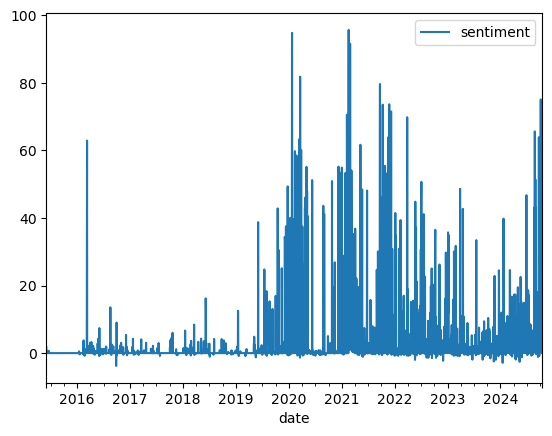

In [47]:
newSeries = series.resample('1d').sum()
# this plots and shows the time series
newSeries.plot()
plt.show()

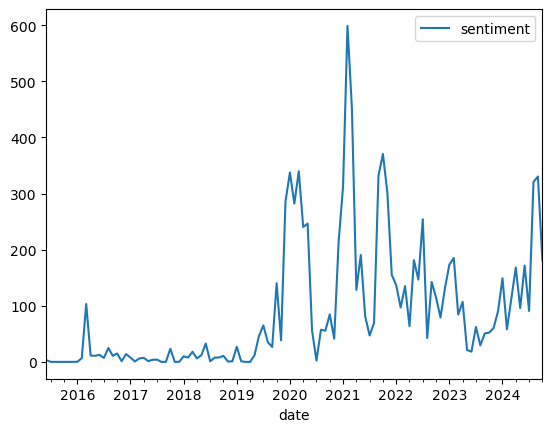

In [48]:
newSeries = series.resample('1ME').sum()
# this plots and shows the time series
newSeries.plot()
plt.show()

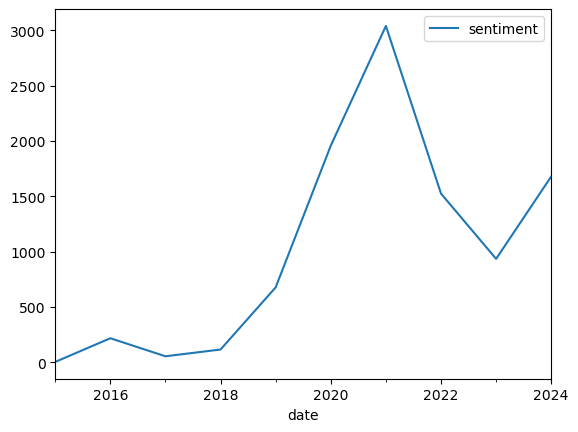

In [49]:
newSeries = series.resample('1YE').sum()
# this plots and shows the time series
newSeries.plot()
plt.show()

## Topic Modelling

In [50]:
lReviews = []
for reviews in reddit_df['content']:
    lTokens = processText(text=reviews, tokenizer=tweetTokeniser, lemmatizer=lemmatizer, stemmer=stemmer, stopwords=lStopwords,slang_dict=slang_dict)
    if len(lTokens) > 0:  # Add only non-empty tokenized reviews
        lReviews.append(lTokens)
    

In [ ]:
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(0)

# Assuming lReviews is your preprocessed tokenized reviews (list of lists of tokens)
# Create a dictionary and corpus
dictionary = corpora.Dictionary(lReviews)
corpus = [dictionary.doc2bow(review) for review in lReviews]

# Function to perform LDA with different parameter combinations and compute coherence
def lda_tuning(corpus, dictionary, texts, limit, start=2, step=1, passes=10, iterations=100, random_state=100):
    coherence_scores = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        # Train the LDA model
        model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics,
                                       random_state=random_state,
                                       passes=passes,
                                       iterations=iterations,
                                       alpha='auto',  # Can also optimize 'alpha'
                                       eta='auto')    # Can also optimize 'eta'
        
        # Calculate the coherence score
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherencemodel.get_coherence()
        coherence_scores.append(coherence_score)
        model_list.append(model)
        
        print(f'Number of topics: {num_topics}, Coherence Score: {coherence_score}')

    return model_list, coherence_scores

# Run the LDA optimization (tuning number of topics)
start = 2  # Min number of topics
limit = 20  # Max number of topics
step = 1  # Step size for topics
passes = 10  # Number of passes 
iterations = 100  # Number of iterations 

model_list, coherence_scores = lda_tuning(corpus=corpus, dictionary=dictionary, texts=lReviews, limit=limit, start=start, step=step, passes=passes, iterations=iterations)

# Plot the coherence scores to find the optimal number of topics
x = range(start, limit, step)
plt.plot(x, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("LDA Model Optimization")
plt.show()

# Select the model with the highest coherence score
best_num_topics = x[coherence_scores.index(max(coherence_scores))]
best_model = model_list[coherence_scores.index(max(coherence_scores))]

print(f'Best Number of Topics: {best_num_topics}')

# Display the topics of the best model
topics = best_model.show_topics(num_topics=best_num_topics, num_words=15)
for topic in topics:
    print(topic)


Number of topics: 2, Coherence Score: 0.7809500992968861
Number of topics: 3, Coherence Score: 0.7571472480547058
Number of topics: 4, Coherence Score: 0.6903651853537985
Number of topics: 5, Coherence Score: 0.5549955028876621
Number of topics: 6, Coherence Score: 0.6045868176996289


In [ ]:
print(f"Number of documents in corpus: {len(corpus)}")
print(f"Number of unique tokens in dictionary: {len(dictionary)}")


In [ ]:
print(coherence_scores)

In [ ]:
lcontent = []

for content in reddit_df['content']:

    # tokenise, filter stopwords and get convert to lower case
    lTokens = processText(text=content, tokenizer=tweetTokeniser, lemmatizer=lemmatizer, stemmer=stemmer, stopwords=lStopwords,slang_dict=slang_dict)
    lcontent.append(' '.join(lTokens))

In [ ]:
#
# Count Vectorizer
#
##
topicNum = best_num_topics
wordNumToDisplay = 15
featureNum = 1500
tfVectorizer = CountVectorizer(max_df=0.90, min_df=5, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(lcontent)
# extract the names of the features (in our case, the words)
tfFeatureNames = tfVectorizer.get_feature_names_out()

#
# LDA MODEL
#
ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

In [ ]:
def display_topics(model, featureNames, numTopWords):
    """
    Prints out the most associated words for each feature.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    @param numTopWords: number of words to print per topic.
    """

    # print out the topic distributions
    for topicId, lTopicDist in enumerate(model.components_):
        print("Topic %d:" % (topicId))
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

In [ ]:
def displayWordcloud(model, featureNames):
    """
    Displays the word cloud of the topic distributions, stored in model.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    """
    normalisedComponents = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    
    topicNum = len(model.components_)
    # number of wordclouds for each row
    plotColNum = 3
    # number of wordclouds for each column
    plotRowNum = int(math.ceil(topicNum / plotColNum))

    for topicId, lTopicDist in enumerate(normalisedComponents):
        lWordProb = {featureNames[i] : wordProb for i,wordProb in enumerate(lTopicDist)}
        wordcloud = WordCloud(background_color='black')
        wordcloud.fit_words(frequencies=lWordProb)
        plt.subplot(plotRowNum, plotColNum, topicId+1)
        plt.title('Topic %d:' % (topicId+1))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

    plt.show(block=True)

In [ ]:
displayWordcloud(ldaModel, tfFeatureNames)

In [ ]:
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)